# (0) Driveのマウント と Signate API

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:

!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=c68b897dc7c86eea92dade3e6db6e690cee06b8791a29cf5eaa5db151f0271fd
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


# (1) 外部ライブラリのインストール

In [6]:
!pip install kanjize

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.8 MB/s eta 0:00:00


In [8]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 22.4 MB/s eta 0:00:00


# (2) 前処理

In [59]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [60]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1")

# Ageの処理
for i in range(len(all_df)):
# for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10代は19歳にする
    if(-1<tmp & tmp<20):
      all_df.loc[i,"Age"] = 19
    elif(tmp>60):
      all_df.loc[i,"Age"] = 61
    else:
      # 10歳で分けて5足す
      tmp = tmp//10 * 10
      all_df.loc[i,"Age"] = tmp + 5

# int型に変換
all_df["Age"] = all_df["Age"].astype(int)

print(all_df.groupby("Age").size())

Age
-1     193
 18     17
 19     28
 20     47
 21     58
 22     81
 23     74
 24     96
 25    193
 26    123
 27    122
 28    160
 29    158
 30    194
 31    217
 32    234
 33    263
 34    234
 35    469
 36    257
 37    238
 38    206
 39    204
 40    188
 41    186
 42    198
 43    170
 44    129
 45    354
 46    146
 47    144
 48    125
 49    136
 50    165
 51    156
 52    154
 53    131
 54    131
 55    252
 56     97
 57     86
 58     63
 59     53
 60     30
 61     14
 65      4
dtype: int64


In [61]:
# カテゴリ列の追加
all_df["Age_cls"] = all_df["Age"].copy()

all_df.loc[all_df["Age"]<0,"Age_cls"] = "不明"
all_df.loc[(all_df["Age"]>=10) & (all_df["Age"]<=20),"Age_cls"] = "20歳以下"
all_df.loc[(all_df["Age"]>=21) & (all_df["Age"]<=25),"Age_cls"] = "21〜25歳"
all_df.loc[(all_df["Age"]>=26) & (all_df["Age"]<=30),"Age_cls"] = "26〜30歳"
all_df.loc[(all_df["Age"]>=31) & (all_df["Age"]<=35),"Age_cls"] = "31〜35歳"
all_df.loc[(all_df["Age"]>=36) & (all_df["Age"]<=40),"Age_cls"] = "36〜40歳"
all_df.loc[(all_df["Age"]>=41) & (all_df["Age"]<=45),"Age_cls"] = "41〜45歳"
all_df.loc[(all_df["Age"]>=46) & (all_df["Age"]<=50),"Age_cls"] = "46〜50歳"
all_df.loc[(all_df["Age"]>=51) & (all_df["Age"]<=55),"Age_cls"] = "51〜55歳"
all_df.loc[all_df["Age"]>=56,"Age_cls"] = "56歳以上"

# 元のカラムを削除する
# all_df = all_df.drop("Age",axis=1)

all_df['Age_cls'] = all_df['Age_cls'].astype('object')
print(all_df.groupby(["Age_cls"]).size())

Age_cls
20歳以下       92
21〜25歳     502
26〜30歳     757
31〜35歳    1417
36〜40歳    1093
41〜45歳    1037
46〜50歳     716
51〜55歳     824
56歳以上      347
不明         193
dtype: int64


<ipython-input-61-6e1667c3d861>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["Age"]<0,"Age_cls"] = "不明"


In [62]:
#########################
# "TypeofContact"の処理 #
#########################
print(all_df.groupby("TypeofContact").size())

TypeofContact
Company Invited    2516
Self Enquiry       4444
dtype: int64


In [63]:
#########################
# "CityTier"の処理 #
#########################
print(all_df.groupby("CityTier").size())

CityTier
1    2991
2    3160
3     827
dtype: int64


In [64]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(len(all_df)):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

# int型に変換
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("int")

# 秒に換算
all_df["DurationOfPitch"] = all_df["DurationOfPitch"] * 60
print(all_df.groupby("DurationOfPitch").size())

DurationOfPitch
-60      252
 240       3
 300      43
 360     167
 420     446
 480     671
 540     654
 600     467
 660     306
 720     293
 780     397
 840     518
 900     569
 960     527
 1020    312
 1080    133
 1140     50
 1200     66
 1260     65
 1320     84
 1380    104
 1440     86
 1500     79
 1560     64
 1620     57
 1680     56
 1740     48
 1800     65
 1860     86
 1920     93
 1980     69
 2040     75
 2100     58
 2160     15
dtype: int64


In [65]:
# カテゴリ列の追加
all_df["DurationOfPitch_cls"] = all_df["DurationOfPitch"].copy()

all_df.loc[all_df["DurationOfPitch"]<0,"DurationOfPitch_cls"] = "不明"
all_df.loc[(all_df["DurationOfPitch"]>0) & (all_df["DurationOfPitch"]<=400),"DurationOfPitch_cls"] = "400s以下"
all_df.loc[(all_df["DurationOfPitch"]>400) & (all_df["DurationOfPitch"]<=500),"DurationOfPitch_cls"] = "401〜500s"
all_df.loc[(all_df["DurationOfPitch"]>500) & (all_df["DurationOfPitch"]<=600),"DurationOfPitch_cls"] = "501〜600s"
all_df.loc[(all_df["DurationOfPitch"]>600) & (all_df["DurationOfPitch"]<=700),"DurationOfPitch_cls"] = "601〜700s"
all_df.loc[(all_df["DurationOfPitch"]>700) & (all_df["DurationOfPitch"]<=800),"DurationOfPitch_cls"] = "701〜800s"
all_df.loc[(all_df["DurationOfPitch"]>800) & (all_df["DurationOfPitch"]<=900),"DurationOfPitch_cls"] = "801〜900s"
all_df.loc[(all_df["DurationOfPitch"]>900) & (all_df["DurationOfPitch"]<=1000),"DurationOfPitch_cls"] = "901〜1000s"
all_df.loc[(all_df["DurationOfPitch"]>1000) & (all_df["DurationOfPitch"]<=1100),"DurationOfPitch_cls"] = "1001〜1100s"
all_df.loc[(all_df["DurationOfPitch"]>1100) & (all_df["DurationOfPitch"]<=1200),"DurationOfPitch_cls"] = "1101〜1200s"
all_df.loc[(all_df["DurationOfPitch"]>1200) & (all_df["DurationOfPitch"]<=1300),"DurationOfPitch_cls"] = "1201〜1300s"
all_df.loc[(all_df["DurationOfPitch"]>1300) & (all_df["DurationOfPitch"]<=1400),"DurationOfPitch_cls"] = "1301〜1400s"
all_df.loc[(all_df["DurationOfPitch"]>1400) & (all_df["DurationOfPitch"]<=1500),"DurationOfPitch_cls"] = "1401〜1500s"
all_df.loc[all_df["DurationOfPitch"]>1500,"DurationOfPitch_cls"] = "1501s以上"

# 元のカラムを削除
# all_df = all_df.drop("DurationOfPitch", axis=1)

all_df["DurationOfPitch_cls"] = all_df["DurationOfPitch_cls"].astype("object")
print(all_df.groupby(["DurationOfPitch_cls"]).size())

DurationOfPitch_cls
1001〜1100s     445
1101〜1200s     116
1201〜1300s      65
1301〜1400s     188
1401〜1500s     165
1501s以上        686
400s以下         213
401〜500s      1117
501〜600s      1121
601〜700s       306
701〜800s       690
801〜900s      1087
901〜1000s      527
不明             252
dtype: int64


<ipython-input-65-57a532ae39e6>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["DurationOfPitch"]<0,"DurationOfPitch_cls"] = "不明"


In [66]:
####################
# "Occupation"の処理 #
####################
print(all_df.groupby(["Occupation"]).size())

Occupation
Large Business     721
Salaried          2801
Small Business    3456
dtype: int64


In [67]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(len(all_df)):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1]).lower()
  if(head == "f"):
    all_df.loc[i,"Gender"] = "Female"
  else:
    all_df.loc[i,"Gender"] = "Male"

# カテゴリ型にキャスト
all_df["Gender"] = all_df["Gender"].astype("object")
print(all_df.groupby(["Gender"]).size())

Gender
Female    2760
Male      4218
dtype: int64


In [68]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df.groupby(["NumberOfPersonVisiting"]).size())

NumberOfPersonVisiting
1.0     686
2.0    3163
3.0    2773
4.0     356
dtype: int64


In [69]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# 欠損を-1で埋める
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df.groupby(["NumberOfFollowups"]).size())

NumberOfFollowups
-1.0      57
 1.0     178
 2.0     213
 3.0    2561
 4.0    2777
 5.0    1122
 6.0      70
dtype: int64


In [70]:
# カテゴリ列の追加
all_df["NumberOfFollowups_cls"] = all_df["NumberOfFollowups"].copy()

all_df.loc[all_df["NumberOfFollowups"]==-1,"NumberOfFollowups_cls"] = "不明"
all_df.loc[all_df["NumberOfFollowups"]==1,"NumberOfFollowups_cls"] = "1回"
all_df.loc[all_df["NumberOfFollowups"]==2,"NumberOfFollowups_cls"] = "2回"
all_df.loc[all_df["NumberOfFollowups"]==3,"NumberOfFollowups_cls"] = "3回"
all_df.loc[all_df["NumberOfFollowups"]==4,"NumberOfFollowups_cls"] = "4回"
all_df.loc[all_df["NumberOfFollowups"]==5,"NumberOfFollowups_cls"] = "5回"
all_df.loc[all_df["NumberOfFollowups"]==6,"NumberOfFollowups_cls"] = "6回"

# 元のカラムを削除する
# all_df = all_df.drop("NumberOfFollowups", axis=1)

all_df["NumberOfFollowups_cls"] = all_df["NumberOfFollowups_cls"].astype("object")
print(all_df.groupby(["NumberOfFollowups_cls"]).size())

NumberOfFollowups_cls
1回     178
2回     213
3回    2561
4回    2777
5回    1122
6回      70
不明      57
dtype: int64


<ipython-input-70-90adc46ed6cf>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["NumberOfFollowups"]==-1,"NumberOfFollowups_cls"] = "不明"


In [71]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

all_df["ProductPitched"] = all_df["ProductPitched"].astype("object")

# 分布の確認
print(all_df.groupby(["ProductPitched"]).size())

ProductPitched
Basic          2347
Deluxe         2091
King            286
Standard       1614
SuperDeluxe     640
dtype: int64


In [72]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
print(all_df.groupby(["PreferredPropertyStar"]).size())

PreferredPropertyStar
3.0    4328
4.0    2254
5.0     396
dtype: int64


In [73]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips_num"] = [0]*len(all_df)
all_df["NumberOfTrips_num"] = -1

all_df["NumberOfTrips_num"] = all_df["NumberOfTrips_num"].astype(int)

all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

for i in range(len(all_df)):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][2:3])

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][3:4])*2

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][4:5])*4

  elif(head == "-1"):
    all_df.loc[i,"NumberOfTrips_num"] = -1

  else:
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"])

print(all_df.groupby(["NumberOfTrips_num"]).size())

NumberOfTrips_num
-1      64
 1     801
 2    2277
 3    1706
 4     333
 5     977
 6     281
 7     513
 8      26
dtype: int64


In [74]:
# 名前を元に戻す
all_df["NumberOfTrips"] = all_df["NumberOfTrips_num"].copy()
all_df = all_df.drop("NumberOfTrips_num", axis=1)

In [75]:
#########################
# "Passport"の処理 #
#########################
# カテゴリ型に変更
all_df.loc[all_df["Passport"]==0,"Passport"] = "パスポート非所持"
all_df.loc[all_df["Passport"]==1,"Passport"] = "パスポート所持"
print(all_df.groupby(["Passport"]).size())

Passport
パスポート所持      690
パスポート非所持    6288
dtype: int64


<ipython-input-75-96949273968e>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'パスポート非所持' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["Passport"]==0,"Passport"] = "パスポート非所持"


In [76]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df.groupby(["PitchSatisfactionScore"]).size())

PitchSatisfactionScore
1    1439
2    2500
3    1344
4    1452
5     243
dtype: int64


In [77]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

all_df["Designation"] = all_df["Designation"].astype("object")

# 分布の確認
print(all_df.groupby(["Designation"]).size())

Designation
AVP                635
Executive         2330
Manager           2117
Senior Manager    1632
VP                 264
dtype: int64


In [78]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(len(all_df)):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

print(all_df.groupby(["MonthlyIncome"]).size())

MonthlyIncome
-1.0         105
 200000.0      5
 238890.0      1
 239340.0      1
 240000.0      2
            ... 
 578460.0      1
 578490.0      1
 578670.0      1
 579015.0      1
 600000.0     10
Length: 4586, dtype: int64


In [79]:
all_df["MonthlyIncome_cls"] = all_df["MonthlyIncome"].copy()

all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "不明"
all_df.loc[(all_df["MonthlyIncome"]>0) & (all_df["MonthlyIncome"]<=250000),"MonthlyIncome_cls"] = "25万円以下"
all_df.loc[(all_df["MonthlyIncome"]>250000) & (all_df["MonthlyIncome"]<=300000),"MonthlyIncome_cls"] = "25〜30万円"
all_df.loc[(all_df["MonthlyIncome"]>300000) & (all_df["MonthlyIncome"]<=350000),"MonthlyIncome_cls"] = "30〜35万円"
all_df.loc[(all_df["MonthlyIncome"]>350000) & (all_df["MonthlyIncome"]<=400000),"MonthlyIncome_cls"] = "35〜40万円"
all_df.loc[(all_df["MonthlyIncome"]>400000), "MonthlyIncome_cls"] = "40万円以上"

# all_df = all_df.drop("MonthlyIncome", axis=1)

print(all_df.groupby(["MonthlyIncome_cls"]).size())

MonthlyIncome_cls
25〜30万円    1679
25万円以下       71
30〜35万円    2035
35〜40万円    1554
40万円以上     1534
不明          105
dtype: int64


<ipython-input-79-149bd5a7df1c>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "不明"


In [80]:
# ProdTaken
print(all_df.groupby(["ProdTaken"]).size())

ProdTaken
0.0    2992
1.0     497
dtype: int64


In [81]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(len(all_df)):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」、「わからない」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭") or (cont[i][-1:] == "い")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」
  else:
    c_other.append(cont[i])

In [82]:
# 新たなカラムを追加
all_df["CarHolder"] = "自動車未所有" # 車所有
all_df["NumofChild"] = "不明" # 子供の数
all_df["Married"] = "独身" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車所有",
              "車未所持","自動車未所有","車保有なし","乗用車なし","自家用車なし","車なし"]

# 子供
c_child_x = ['子育て状況不明', '子の数不詳', '子供の数不明','わからない',"子供有り"]
c_child_0 = ['子供なし', '子供無し', '無子', '子供ゼロ', '非育児家庭']
c_child_1 = ["こども1人","1児","子供1人","子供有り(1人)"]
c_child_2 = ["こども2人","2児","子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児","子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(len(all_df)):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        if(tmp[j] in ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車所有"]):
          all_df.loc[i, "CarHolder"] = "自動車所有"
      # 子供の情報
      if(tmp[j] in c_child_x):
        all_df.loc[i, "NumofChild"] = "不明"
      if(tmp[j] in c_child_0):
        all_df.loc[i, "NumofChild"] = "子供なし"
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = "子供1人"
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = "子供2人"
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = "子供3人"
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "結婚済み"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "離婚済み"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [83]:
# 車保有率
all_df["CarHolder"] = all_df["CarHolder"].astype("object")
print(all_df.groupby(["CarHolder"]).size())

CarHolder
自動車所有     3359
自動車未所有    3619
dtype: int64


In [84]:
# 子供の数
all_df["NumofChild"] = all_df["NumofChild"].astype("object")
print(all_df.groupby(["NumofChild"]).size())

NumofChild
不明       395
子供1人    2945
子供2人    1600
子供3人     129
子供なし    1909
dtype: int64


In [85]:
# 婚姻歴
all_df["Married"] = all_df["Married"].astype("object")
print(all_df.groupby(["Married"]).size())

Married
独身      2444
結婚済み    2846
離婚済み    1688
dtype: int64


# (3) データエンジニアリング

In [86]:
# カラム全体
all_df.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls',
       'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [87]:
# 追加したカテゴリ列は削除する
# all_df = all_df.drop(["Age_cls", "DurationOfPitch_cls", "NumberOfFollowups_cls", "MonthlyIncome_cls"], axis=1)

In [88]:
# # Occupationを小規模、大規模、サラリーのワンホットにする
# all_df["LargeBusiness"] = 0
# all_df["SmallBusiness"] = 0
# all_df["Salaried"] = 0

# # LargeBusinessの区分け
# all_df.loc[all_df["Occupation"]=="Large Business", "LargeBusiness"] = 1
# # SmallBusinessの区分け
# all_df.loc[all_df["Occupation"]=="Small Business", "SmallBusiness"] = 1
# # Salariedの区分け
# all_df.loc[all_df["Occupation"]=="Salaried", "Salaried"] = 1
# # 元のカラムを削除
# all_df = all_df.drop("Occupation", axis=1)

In [89]:
# # Occupationを結婚済み、離婚、独身に分ける
# all_df["Marry"] = 0
# all_df["Divorced"] = 0
# all_df["Single"] = 0

# # LargeBusinessの区分け
# all_df.loc[all_df["Married"]=="結婚済み", "Marry"] = 1
# # SmallBusinessの区分け
# all_df.loc[all_df["Married"]=="離婚済み", "Divorced"] = 1
# # Salariedの区分け
# all_df.loc[all_df["Married"]=="独身", "Single"] = 1
# # 元のカラムを削除
# all_df = all_df.drop("Married", axis=1)

In [90]:
# # GenderをMaleに変更する
# # Gender: 女性(0)、男性(1) -> Male
# all_df.rename(columns={"Gender":"Male"}, inplace=True)

# # Maleを1にする
# all_df.loc[all_df["Male"]=="Male", "Male"] = 1
# all_df.loc[all_df["Male"]=="Female", "Male"] = 0

In [91]:
# # ProductPitchedを区分けする
# # ProductPitched: Basic(1), Standard(2), Deluxe(3), SuperDeluxe(4), King(5)
# all_df.loc[all_df["ProductPitched"]=="Basic", "ProductPitched"] = 1
# all_df.loc[all_df["ProductPitched"]=="Standard", "ProductPitched"] = 2
# all_df.loc[all_df["ProductPitched"]=="Deluxe", "ProductPitched"] = 3
# all_df.loc[all_df["ProductPitched"]=="SuperDeluxe", "ProductPitched"] = 4
# all_df.loc[all_df["ProductPitched"]=="King", "ProductPitched"] = 5

In [92]:
# # Designationを区分けする
# # Designation: Manager(1), Senior Manager(2), AVP(3), VP(4), Executive(5)
# all_df.loc[all_df["Designation"]=="Manager", "Designation"] = 1
# all_df.loc[all_df["Designation"]=="Senior Manager", "Designation"] = 2
# all_df.loc[all_df["Designation"]=="AVP", "Designation"] = 3
# all_df.loc[all_df["Designation"]=="VP", "Designation"] = 4
# all_df.loc[all_df["Designation"]=="Executive", "Designation"] = 5

In [93]:
# # 自動車保有をラベルエンコード
# # CarHolder: 自動車未所有(0)、自動車所有(1)
# all_df.loc[all_df["CarHolder"]=="自動車所有","CarHolder"] = 1
# all_df.loc[all_df["CarHolder"]=="自動車未所有","CarHolder"] = 0

In [94]:
# PreferredPropertyStarは1始まりにする
all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

In [95]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6978 entries, 0 to 6977
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6978 non-null   int64  
 1   Age                     6978 non-null   int64  
 2   TypeofContact           6960 non-null   object 
 3   CityTier                6978 non-null   int64  
 4   DurationOfPitch         6978 non-null   int64  
 5   Occupation              6978 non-null   object 
 6   Gender                  6978 non-null   object 
 7   NumberOfPersonVisiting  6978 non-null   float64
 8   NumberOfFollowups       6978 non-null   float64
 9   ProductPitched          6978 non-null   object 
 10  PreferredPropertyStar   6978 non-null   float64
 11  NumberOfTrips           6978 non-null   int64  
 12  Passport                6978 non-null   object 
 13  PitchSatisfactionScore  6978 non-null   int64  
 14  Designation             6978 non-null   

In [96]:
# 結合を戻す
train = all_df.iloc[:len(train_df)].copy()
test = all_df.iloc[len(train_df):].reset_index(drop=True).copy()

In [97]:
# 欠損値を最頻値で補完
train["TypeofContact"] = train["TypeofContact"].fillna(train["TypeofContact"].mode()[0])
test["TypeofContact"] = test["TypeofContact"].fillna(test["TypeofContact"].mode()[0])

In [99]:
# 一時的に「-1」としていた欠損値も最頻値で補完
train.loc[train["Age"]==-1,"Age"] = train.loc[train["Age"]>0,"Age"].mode()[0]
test.loc[test["Age"]==-1,"Age"] = test.loc[test["Age"]>0,"Age"].mode()[0]

train.loc[train["DurationOfPitch"]==-1,"DurationOfPitch"] = train.loc[train["DurationOfPitch"]>0,"DurationOfPitch"].mode()[0]
test.loc[test["DurationOfPitch"]==-1,"DurationOfPitch"] = test.loc[test["DurationOfPitch"]>0,"DurationOfPitch"].mode()[0]

train.loc[train["NumberOfFollowups"]==-1,"NumberOfFollowups"] = train.loc[train["NumberOfFollowups"]>0,"NumberOfFollowups"].mode()[0]
test.loc[test["NumberOfFollowups"]==-1,"NumberOfFollowups"] = test.loc[test["NumberOfFollowups"]>0,"NumberOfFollowups"].mode()[0]

train.loc[train["MonthlyIncome"]==-1,"MonthlyIncome"] = train.loc[train["MonthlyIncome"]>0,"MonthlyIncome"].mode()[0]
test.loc[test["MonthlyIncome"]==-1,"MonthlyIncome"] = test.loc[test["MonthlyIncome"]>0,"MonthlyIncome"].mode()[0]

train.loc[train["NumberOfTrips"]==-1,"NumberOfTrips"] = train.loc[train["NumberOfTrips"]>0,"NumberOfTrips"].mode()[0]
test.loc[test["NumberOfTrips"]==-1,"NumberOfTrips"] = test.loc[test["NumberOfTrips"]>0,"NumberOfTrips"].mode()[0]

In [48]:
# # TypeofContactをCompanyInvitedに変更
# # TypeofContact: 個人(0)、法人(1) -> CompanyInvited
# train.rename(columns={"TypeofContact":"CompanyInvited"}, inplace=True)
# test.rename(columns={"TypeofContact":"CompanyInvited"}, inplace=True)

# # CompanyInvitedを1にする
# train.loc[train["CompanyInvited"]=="Company Invited", "CompanyInvited"] = 1
# train.loc[train["CompanyInvited"]=="Self Enquiry", "CompanyInvited"] = 0

# test.loc[test["CompanyInvited"]=="Company Invited", "CompanyInvited"] = 1
# test.loc[test["CompanyInvited"]=="Self Enquiry", "CompanyInvited"] = 0

In [49]:
# # NumofChild: 子供なし(0)、子供１人(1)、子供2人(2)、子供3人(3)
# # 不明は最頻値にする
# train.loc[train["NumofChild"]=="不明","NumofChild"] = train["NumofChild"].mode()[0]
# train.loc[train["NumofChild"]=="子供なし", "NumofChild"] = 0
# train.loc[train["NumofChild"]=="子供1人", "NumofChild"] = 1
# train.loc[train["NumofChild"]=="子供2人", "NumofChild"] = 2
# train.loc[train["NumofChild"]=="子供3人", "NumofChild"] = 3

# test.loc[test["NumofChild"]=="不明","NumofChild"] = test["NumofChild"].mode()[0]
# test.loc[test["NumofChild"]=="子供なし", "NumofChild"] = 0
# test.loc[test["NumofChild"]=="子供1人", "NumofChild"] = 1
# test.loc[test["NumofChild"]=="子供2人", "NumofChild"] = 2
# test.loc[test["NumofChild"]=="子供3人", "NumofChild"] = 3

In [100]:
# 欠損なし
print(train.isnull().sum())

id                        0
Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups         0
ProductPitched            0
PreferredPropertyStar     0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
Designation               0
MonthlyIncome             0
ProdTaken                 0
Age_cls                   0
DurationOfPitch_cls       0
NumberOfFollowups_cls     0
MonthlyIncome_cls         0
CarHolder                 0
NumofChild                0
Married                   0
dtype: int64


In [101]:
# 欠損なし
print(test.isnull().sum())

id                           0
Age                          0
TypeofContact                0
CityTier                     0
DurationOfPitch              0
Occupation                   0
Gender                       0
NumberOfPersonVisiting       0
NumberOfFollowups            0
ProductPitched               0
PreferredPropertyStar        0
NumberOfTrips                0
Passport                     0
PitchSatisfactionScore       0
Designation                  0
MonthlyIncome                0
ProdTaken                 3489
Age_cls                      0
DurationOfPitch_cls          0
NumberOfFollowups_cls        0
MonthlyIncome_cls            0
CarHolder                    0
NumofChild                   0
Married                      0
dtype: int64


In [102]:
train.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls',
       'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [103]:
train.dtypes

,0
id,int64
Age,int64
TypeofContact,object
CityTier,int64
DurationOfPitch,int64
Occupation,object
Gender,object
NumberOfPersonVisiting,float64
NumberOfFollowups,float64
ProductPitched,object


In [104]:
# # キャストする
# # ['CompanyInvited', 'Male', 'ProductPitched', 'Designation', 'CarHolder', 'NumofChild']
# train["CompanyInvited"] = train["CompanyInvited"].astype(int)
# test["CompanyInvited"] = test["CompanyInvited"].astype(int)
# train["Male"] = train["Male"].astype(int)
# test["Male"] = test["Male"].astype(int)
# train["ProductPitched"] = train["ProductPitched"].astype(int)
# test["ProductPitched"] = test["ProductPitched"].astype(int)
# train["Designation"] = train["Designation"].astype(int)
# test["Designation"] = test["Designation"].astype(int)
# train["CarHolder"] = train["CarHolder"].astype(int)
# test["CarHolder"] = test["CarHolder"].astype(int)
# train["NumofChild"] = train["NumofChild"].astype(int)
# test["NumofChild"] = test["NumofChild"].astype(int)

In [105]:
train.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls',
       'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [106]:
# 順番を整列させる
col = ['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls',
       'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married'
       ]

train = train.reindex(columns=col)
test = test.reindex(columns=col)

In [107]:
# 訓練データをx,yに分割
X = train.drop(["id", "ProdTaken"], axis=1)
y = train["ProdTaken"]

In [108]:
# テストデータから目的変数を落とす
test = test.drop("ProdTaken",axis=1)

In [111]:
# カテゴリ列一覧
categorical_features = test.select_dtypes(include=['object']).columns.tolist()
print(categorical_features)

['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'Passport', 'Designation', 'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls', 'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married']


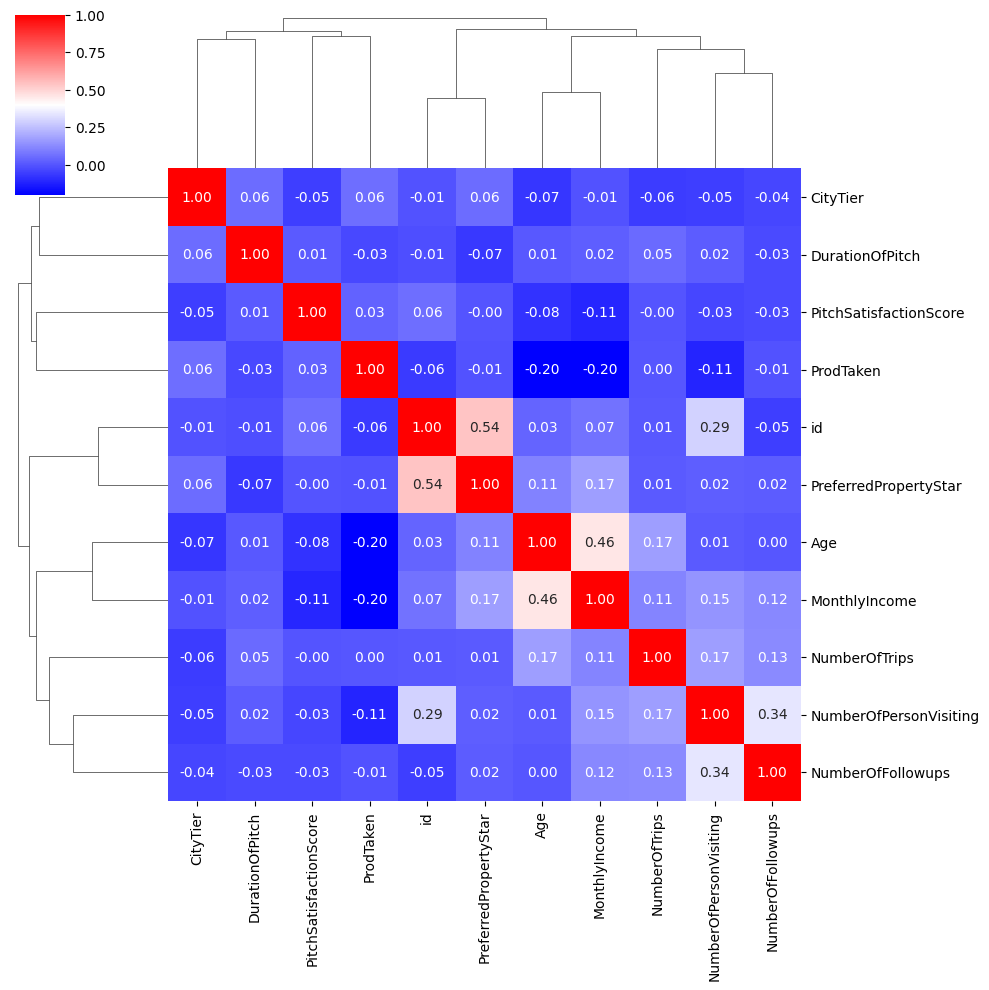

In [112]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

train_corr = train.drop(categorical_features,axis=1).corr()
sns.clustermap(train_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [ ]:
# for feature in train.columns:
#     print(train.groupby(feature).size())
#     print("")

# (4) モデル構築と学習

In [113]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in test.columns if c not in RMV2]
TARGET = "ProdTaken"

In [114]:
CATS = []
for c in FEATURES:
  if test[c].dtype == "object":
    CATS.append(c)
print(CATS)

['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'Passport', 'Designation', 'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls', 'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married']


In [123]:
train[CATS] = train[CATS].astype('category')

In [117]:
X[CATS] = X[CATS].astype('category')

In [119]:
test[CATS] = test[CATS].astype('category')

In [118]:
y[CATS] = y[CATS].astype('category')

KeyError: "None of [Index(['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'Passport',\n       'Designation', 'Age_cls', 'DurationOfPitch_cls',\n       'NumberOfFollowups_cls', 'MonthlyIncome_cls', 'CarHolder', 'NumofChild',\n       'Married'],\n      dtype='object')] are in the [index]"

In [121]:
X.dtypes

,0
Age,int64
TypeofContact,category
CityTier,int64
DurationOfPitch,int64
Occupation,category
Gender,category
NumberOfPersonVisiting,float64
NumberOfFollowups,float64
ProductPitched,category
PreferredPropertyStar,float64


In [ ]:
# import pandas as pd
# import numpy as np
# import optuna
# from sklearn.model_selection import train_test_split, StratifiedKFold
# import sklearn.metrics

In [124]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

def objective(trial):

  lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'n_estimators': 3000,
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'num_leaves': trial.suggest_int('num_leaves', 16, 256),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),

    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

  # 複数シードの平均を取る
  seed = [42, 77, 2025]
  FOLDS = 5 # 分割数
  oof_score = np.zeros(len(seed))

  # SEEDごとのスコアを出す
  for j, seed in enumerate(seed):

    print("#"*25)
    print(f"### seed =  {seed}")
    print("#"*25)

    oof_lgb = np.zeros(len(train))

    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

    # 各FOLDのスコアを出す
    for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

      print("#"*25)
      print(f"### Fold {i+1}")
      print("#"*25)

      # インデックスに割り振る
      x_train = train.loc[train_index, FEATURES].copy()
      y_train = train.loc[train_index, TARGET]
      x_valid = train.loc[test_index, FEATURES].copy()
      y_valid = train.loc[test_index, TARGET]

      # データセット作成
      lgb_train = lgb.Dataset(x_train, y_train)
      lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

      # 学習
      model_lgb = lgb.train(lgbm_params,
                            lgb_train,
                            num_boost_round = 2000,
                            valid_sets = [lgb_train, lgb_eval],
                            valid_names = ["train", "valid"],
                            categorical_feature = CATS,
                            callbacks = [
                                lgb.early_stopping(stopping_rounds=100, verbose=False),
                                lgb.log_evaluation(100),])

      # valid予測
      oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    # AUCの算出
    oof_score[j] = roc_auc_score(train[TARGET],oof_lgb)

  score = np.mean(oof_score)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-06-03 11:48:01,674] A new study created in memory with name: no-name-98931732-58a9-41b2-8d78-bebc0e487468
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.940022	valid's auc: 0.817993
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.932235	valid's auc: 0.829314
[200]	train's auc: 0.964832	valid's auc: 0.843194
[300]	train's auc: 0.985397	valid's auc: 0.84597
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.936729	valid's auc: 0.80029
[200]	train's auc: 0.966835	valid's auc: 0.807575
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.938478	valid's auc: 0.8169
[200]	train's auc: 0.967527	valid's auc: 0.831116
[300]	train's auc: 0.985681	valid's auc: 0.82808
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.938727	valid's auc: 0.791342
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.936003	valid's auc: 0.839632
[200]	train's auc: 0.966971	valid's auc: 0.836003
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.93841	valid's auc: 0.811137
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.936918	valid's auc: 0.795332
[200]	train's auc: 0.966543	valid's auc: 0.795906
[300]	train's auc: 0.985808	valid's auc: 0.798283
[400]	train's auc: 0.995633	valid's auc: 0.799329
[500]	train's auc: 0.999173	valid's auc: 0.798233
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.936179	valid's auc: 0.824455
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.938057	valid's auc: 0.845681
[200]	train's auc: 0.967054	valid's auc: 0.850799
[300]	train's auc: 0.986287	valid's auc: 0.848282
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.939143	valid's auc: 0.821722
[200]	train's auc: 0.968685	valid's auc: 0.833411
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.934973	valid's auc: 0.858863
[200]	train's auc: 0.966063	valid's auc: 0.860017
[300]	train's auc: 0.986926	valid's auc: 0.862441
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.938177	valid's auc: 0.811605
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.942887	valid's auc: 0.781302
[200]	train's auc: 0.969092	valid's auc: 0.786462
[300]	train's auc: 0.98611	valid's auc: 0.786715
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.934858	valid's auc: 0.834431


[I 2025-06-03 11:48:24,224] Trial 0 finished with value: 0.8099873752317829 and parameters: {'feature_fraction': 0.9064224868764499, 'num_leaves': 95, 'bagging_fraction': 0.9797011632528042, 'bagging_freq': 3, 'lambda_l1': 0.08253923969521873, 'lambda_l2': 4.345825421848869e-07, 'min_data_in_leaf': 27}. Best is trial 0 with value: 0.8099873752317829.


[200]	train's auc: 0.96535	valid's auc: 0.834043
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862671	valid's auc: 0.831756
[200]	train's auc: 0.882158	valid's auc: 0.835452
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857131	valid's auc: 0.832977
[200]	train's auc: 0.875161	valid's auc: 0.846254
[300]	train's auc: 0.892501	valid's auc: 0.852759
[400]	train's auc: 0.90734	valid's auc: 0.853545
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863368	valid's auc: 0.799337
[200]	train's auc: 0.884407	valid's auc: 0.812111
[300]	train's auc: 0.900833	valid's auc: 0.815973
[400]	train's auc: 0.914352	valid's auc: 0.817035
[500]	train's auc: 0.926117	valid's auc: 0.818081
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862099	valid's auc: 0.83491
[200]	train's auc: 0.881754	valid's auc: 0.838063
[300]	train's auc: 0.897478	valid's auc: 0.840154
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865728	valid's auc: 0.802507
[200]	train's auc: 0.885411	valid's auc: 0.808368
[300]	train's auc: 0.902455	valid's auc: 0.813233
[400]	train's auc: 0.916852	valid's auc: 0.813587
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.858847	valid's auc: 0.832843


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881545	valid's auc: 0.844916
[300]	train's auc: 0.899148	valid's auc: 0.846371
[400]	train's auc: 0.91434	valid's auc: 0.846756
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860814	valid's auc: 0.799532
[200]	train's auc: 0.883619	valid's auc: 0.80786
[300]	train's auc: 0.900874	valid's auc: 0.812692
[400]	train's auc: 0.914954	valid's auc: 0.814298
[500]	train's auc: 0.926179	valid's auc: 0.816037
[600]	train's auc: 0.936332	valid's auc: 0.815268
#########################
### Fold 3
#########################
[100]	train's auc: 0.861487	valid's auc: 0.800155


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882925	valid's auc: 0.810492
[300]	train's auc: 0.899775	valid's auc: 0.812954
[400]	train's auc: 0.913413	valid's auc: 0.811942
#########################
### Fold 4
#########################
[100]	train's auc: 0.859795	valid's auc: 0.837524


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.858764	valid's auc: 0.848628


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877536	valid's auc: 0.852623
[300]	train's auc: 0.895261	valid's auc: 0.854684
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.859876	valid's auc: 0.821288


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880923	valid's auc: 0.830669
[300]	train's auc: 0.8967	valid's auc: 0.833562
[400]	train's auc: 0.911137	valid's auc: 0.837023
[500]	train's auc: 0.922653	valid's auc: 0.836254
#########################
### Fold 2
#########################
[100]	train's auc: 0.856288	valid's auc: 0.859666


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877632	valid's auc: 0.863662
[300]	train's auc: 0.895973	valid's auc: 0.864164
[400]	train's auc: 0.910898	valid's auc: 0.865702
[500]	train's auc: 0.922288	valid's auc: 0.864833
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863156	valid's auc: 0.809346
[200]	train's auc: 0.881984	valid's auc: 0.821285
[300]	train's auc: 0.898546	valid's auc: 0.824792
[400]	train's auc: 0.912693	valid's auc: 0.825214
#########################
### Fold 4
#########################
[100]	train's auc: 0.863623	valid's auc: 0.788773


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88427	valid's auc: 0.80147
[300]	train's auc: 0.9019	valid's auc: 0.808738
[400]	train's auc: 0.916653	valid's auc: 0.810475
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:48:41,457] Trial 1 finished with value: 0.8281545332601671 and parameters: {'feature_fraction': 0.7419195067037585, 'num_leaves': 155, 'bagging_fraction': 0.8509898415094777, 'bagging_freq': 5, 'lambda_l1': 0.6257665602369769, 'lambda_l2': 0.3510004499869046, 'min_data_in_leaf': 91}. Best is trial 1 with value: 0.8281545332601671.


[100]	train's auc: 0.863169	valid's auc: 0.832556
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_fea

[100]	train's auc: 0.862062	valid's auc: 0.834799
#########################
### Fold 2
#########################
[100]	train's auc: 0.854824	valid's auc: 0.825686
[200]	train's auc: 0.873402	valid's auc: 0.843027
[300]	train's auc: 0.89038	valid's auc: 0.848612
[400]	train's auc: 0.904313	valid's auc: 0.851622
[500]	train's auc: 0.918047	valid's auc: 0.84995
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864433	valid's auc: 0.799531
[200]	train's auc: 0.883279	valid's auc: 0.8097
[300]	train's auc: 0.899833	valid's auc: 0.814404
[400]	train's auc: 0.91246	valid's auc: 0.815416
[500]	train's auc: 0.924962	valid's auc: 0.815956
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8612	valid's auc: 0.832583
[200]	train's auc: 0.880856	valid's auc: 0.835888
[300]	train's auc: 0.895795	valid's auc: 0.839649
[400]	train's auc: 0.910067	valid's auc: 0.838839
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.86663	valid's auc: 0.802507
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.859033	valid's auc: 0.832475
[200]	train's auc: 0.87976	valid's auc: 0.844482
[300]	train's auc: 0.897107	valid's auc: 0.845067
[400]	train's auc: 0.911875	valid's auc: 0.845535
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863834	valid's auc: 0.803278
[200]	train's auc: 0.883284	valid's auc: 0.809231
[300]	train's auc: 0.900704	valid's auc: 0.81311
[400]	train's auc: 0.914469	valid's auc: 0.815669
[500]	train's auc: 0.925944	valid's auc: 0.817559
[600]	train's auc: 0.936612	valid's auc: 0.816589
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862586	valid's auc: 0.79975
[200]	train's auc: 0.88114	valid's auc: 0.809396
[300]	train's auc: 0.897572	valid's auc: 0.813865
[400]	train's auc: 0.911299	valid's auc: 0.814404
[500]	train's auc: 0.922807	valid's auc: 0.815872
[600]	train's auc: 0.933089	valid's auc: 0.814809
#########################
### Fold 4
#########################
[100]	train's auc: 0.859858	valid's auc: 0.83792


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878249	valid's auc: 0.841352
[300]	train's auc: 0.895213	valid's auc: 0.837962
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859219	valid's auc: 0.850562
[200]	train's auc: 0.876533	valid's auc: 0.852708
[300]	train's auc: 0.892935	valid's auc: 0.853772
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860986	valid's auc: 0.828094
[200]	train's auc: 0.879412	valid's auc: 0.833913
[300]	train's auc: 0.894731	valid's auc: 0.835217
[400]	train's auc: 0.908891	valid's auc: 0.836622
#########################
### Fold 2
#########################
[100]	train's auc: 0.857178	valid's auc: 0.858955


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876192	valid's auc: 0.864565
[300]	train's auc: 0.893366	valid's auc: 0.86714
[400]	train's auc: 0.907745	valid's auc: 0.867609
[500]	train's auc: 0.920371	valid's auc: 0.865652
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863196	valid's auc: 0.810526
[200]	train's auc: 0.880972	valid's auc: 0.819733
[300]	train's auc: 0.896877	valid's auc: 0.823882
[400]	train's auc: 0.910924	valid's auc: 0.825281
#########################
### Fold 4
#########################
[100]	train's auc: 0.863462	valid's auc: 0.790796


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88308	valid's auc: 0.802853
[300]	train's auc: 0.900876	valid's auc: 0.806765
[400]	train's auc: 0.915394	valid's auc: 0.807693
[500]	train's auc: 0.927213	valid's auc: 0.806765
#########################
### Fold 5
#########################
[100]	train's auc: 0.863152	valid's auc: 0.832658


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:48:52,698] Trial 2 finished with value: 0.8197541980940904 and parameters: {'feature_fraction': 0.6539451373910056, 'num_leaves': 114, 'bagging_fraction': 0.8588715943477516, 'bagging_freq': 5, 'lambda_l1': 6.03610600569438e-08, 'lambda_l2': 2.202906803816062, 'min_data_in_leaf': 88}. Best is trial 1 with value: 0.8281545332601671.


[200]	train's auc: 0.879694	valid's auc: 0.832286
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869566	valid's auc: 0.832793
[200]	train's auc: 0.889861	valid's auc: 0.837308
[300]	train's auc: 0.907734	valid's auc: 0.835652
#########################
### Fold 2
#########################
[100]	train's auc: 0.866724	valid's auc: 0.834933


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883919	valid's auc: 0.846455
[300]	train's auc: 0.902055	valid's auc: 0.851957
[400]	train's auc: 0.916662	valid's auc: 0.854716
[500]	train's auc: 0.930197	valid's auc: 0.853177
#########################
### Fold 3
#########################
[100]	train's auc: 0.871662	valid's auc: 0.802381


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891754	valid's auc: 0.811656
[300]	train's auc: 0.909144	valid's auc: 0.818266
[400]	train's auc: 0.922584	valid's auc: 0.818536
[500]	train's auc: 0.935712	valid's auc: 0.817979
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87032	valid's auc: 0.834792
[200]	train's auc: 0.889744	valid's auc: 0.836613
[300]	train's auc: 0.906457	valid's auc: 0.839278
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873785	valid's auc: 0.800682
[200]	train's auc: 0.893836	valid's auc: 0.806527
[300]	train's auc: 0.911934	valid's auc: 0.810446
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868775	valid's auc: 0.836237
[200]	train's auc: 0.889381	valid's auc: 0.844197
[300]	train's auc: 0.906903	valid's auc: 0.845067
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869373	valid's auc: 0.799398
[200]	train's auc: 0.891842	valid's auc: 0.808645
[300]	train's auc: 0.910322	valid's auc: 0.813311
[400]	train's auc: 0.9245	valid's auc: 0.815033
[500]	train's auc: 0.936732	valid's auc: 0.815502
[600]	train's auc: 0.947087	valid's auc: 0.813512
#########################
### Fold 3
#########################
[100]	train's auc: 0.871487	valid's auc: 0.799936


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891472	valid's auc: 0.809025
[300]	train's auc: 0.908706	valid's auc: 0.812533
[400]	train's auc: 0.922217	valid's auc: 0.812347
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866686	valid's auc: 0.839261
[200]	train's auc: 0.886206	valid's auc: 0.8398
[300]	train's auc: 0.904374	valid's auc: 0.836208
#########################
### Fold 5
#########################
[100]	train's auc: 0.866233	valid's auc: 0.851458


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886299	valid's auc: 0.855681
[300]	train's auc: 0.903687	valid's auc: 0.856069
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86707	valid's auc: 0.821555
[200]	train's auc: 0.888327	valid's auc: 0.834013
[300]	train's auc: 0.904579	valid's auc: 0.835585
[400]	train's auc: 0.919741	valid's auc: 0.837742
[500]	train's auc: 0.932608	valid's auc: 0.835033
#########################
### Fold 2
#########################
[100]	train's auc: 0.86339	valid's auc: 0.860644


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884308	valid's auc: 0.863261
[300]	train's auc: 0.903177	valid's auc: 0.865585
[400]	train's auc: 0.918843	valid's auc: 0.867793
[500]	train's auc: 0.931543	valid's auc: 0.866605
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871276	valid's auc: 0.811875
[200]	train's auc: 0.890938	valid's auc: 0.823544
[300]	train's auc: 0.908089	valid's auc: 0.828199
[400]	train's auc: 0.922099	valid's auc: 0.828317
#########################
### Fold 4
#########################
[100]	train's auc: 0.872917	valid's auc: 0.794051


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892691	valid's auc: 0.804725
[300]	train's auc: 0.910307	valid's auc: 0.808165
[400]	train's auc: 0.925397	valid's auc: 0.808115
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:49:04,267] Trial 3 finished with value: 0.8293950422678673 and parameters: {'feature_fraction': 0.6501018469066744, 'num_leaves': 148, 'bagging_fraction': 0.8886475019923564, 'bagging_freq': 5, 'lambda_l1': 2.9269197984009552e-08, 'lambda_l2': 5.627939073327267e-05, 'min_data_in_leaf': 96}. Best is trial 3 with value: 0.8293950422678673.


[100]	train's auc: 0.870746	valid's auc: 0.827084
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888601	valid's auc: 0.83505
[200]	train's auc: 0.911665	valid's auc: 0.834649
#########################
### Fold 2
#########################
[100]	train's auc: 0.881676	valid's auc: 0.834699


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.905891	valid's auc: 0.842308
[300]	train's auc: 0.926895	valid's auc: 0.843779
[400]	train's auc: 0.944383	valid's auc: 0.84495
[500]	train's auc: 0.956448	valid's auc: 0.8449
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.889054	valid's auc: 0.805282
[200]	train's auc: 0.912678	valid's auc: 0.811757
[300]	train's auc: 0.932161	valid's auc: 0.812094
[400]	train's auc: 0.948136	valid's auc: 0.815737
[500]	train's auc: 0.960622	valid's auc: 0.816023
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888074	valid's auc: 0.835838
[200]	train's auc: 0.912551	valid's auc: 0.841014
[300]	train's auc: 0.932507	valid's auc: 0.8398
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8944	valid's auc: 0.804618
[200]	train's auc: 0.917662	valid's auc: 0.810446
[300]	train's auc: 0.936112	valid's auc: 0.811037
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881411	valid's auc: 0.841104
[200]	train's auc: 0.907364	valid's auc: 0.847542
[300]	train's auc: 0.929506	valid's auc: 0.848428
[400]	train's auc: 0.947151	valid's auc: 0.848595
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.886267	valid's auc: 0.813896
[200]	train's auc: 0.914086	valid's auc: 0.819983
[300]	train's auc: 0.934302	valid's auc: 0.819716
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887927	valid's auc: 0.804531
[200]	train's auc: 0.912075	valid's auc: 0.814624
[300]	train's auc: 0.930717	valid's auc: 0.816917
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.89042	valid's auc: 0.833021
#########################
### Fold 5
#########################
[100]	train's auc: 0.884761	valid's auc: 0.854059
[200]	train's auc: 0.91082	valid's auc: 0.855478
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.882684	valid's auc: 0.828729


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.909028	valid's auc: 0.833679
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885	valid's auc: 0.860585
[200]	train's auc: 0.913016	valid's auc: 0.866455
[300]	train's auc: 0.932496	valid's auc: 0.86699
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887158	valid's auc: 0.806951
[200]	train's auc: 0.911892	valid's auc: 0.819244
[300]	train's auc: 0.930633	valid's auc: 0.823527
[400]	train's auc: 0.945783	valid's auc: 0.822836
[500]	train's auc: 0.958503	valid's auc: 0.822752
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884879	valid's auc: 0.789776
[200]	train's auc: 0.913411	valid's auc: 0.800374
[300]	train's auc: 0.933869	valid's auc: 0.806108
[400]	train's auc: 0.950474	valid's auc: 0.806647
#########################
### Fold 5
#########################
[100]	train's auc: 0.882818	valid's auc: 0.833029


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:49:17,568] Trial 4 finished with value: 0.8221537334524078 and parameters: {'feature_fraction': 0.7408061856965121, 'num_leaves': 169, 'bagging_fraction': 0.6884457179284066, 'bagging_freq': 4, 'lambda_l1': 0.0032945449158771427, 'lambda_l2': 4.732755919710519, 'min_data_in_leaf': 13}. Best is trial 3 with value: 0.8293950422678673.


[200]	train's auc: 0.907962	valid's auc: 0.837353
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848682	valid's auc: 0.833545
[200]	train's auc: 0.864196	valid's auc: 0.837241
[300]	train's auc: 0.876099	valid's auc: 0.836338
#########################
### Fold 2
#########################
[100]	train's auc: 0.837776	valid's auc: 0.815895


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856605	valid's auc: 0.833328
[300]	train's auc: 0.869757	valid's auc: 0.841405
[400]	train's auc: 0.880392	valid's auc: 0.844214
[500]	train's auc: 0.88954	valid's auc: 0.846756
[600]	train's auc: 0.897397	valid's auc: 0.848495
[700]	train's auc: 0.90495	valid's auc: 0.849164
#########################
### Fold 3
#########################
[100]	train's auc: 0.852067	valid's auc: 0.798385


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866772	valid's auc: 0.805636
[300]	train's auc: 0.878615	valid's auc: 0.811673
[400]	train's auc: 0.888406	valid's auc: 0.815281
[500]	train's auc: 0.897174	valid's auc: 0.817372
[600]	train's auc: 0.904777	valid's auc: 0.818637
[700]	train's auc: 0.911628	valid's auc: 0.818435
#########################
### Fold 4
#########################
[100]	train's auc: 0.848029	valid's auc: 0.82835


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863166	valid's auc: 0.832347
[300]	train's auc: 0.875147	valid's auc: 0.834556
[400]	train's auc: 0.88523	valid's auc: 0.83577
[500]	train's auc: 0.894012	valid's auc: 0.836681
[600]	train's auc: 0.902034	valid's auc: 0.836664
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848655	valid's auc: 0.801848
[200]	train's auc: 0.864975	valid's auc: 0.808588
[300]	train's auc: 0.878234	valid's auc: 0.812574
[400]	train's auc: 0.888794	valid's auc: 0.81477
[500]	train's auc: 0.898102	valid's auc: 0.813875
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.842979	valid's auc: 0.827793


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860671	valid's auc: 0.839732
[300]	train's auc: 0.873927	valid's auc: 0.845903
[400]	train's auc: 0.884515	valid's auc: 0.848428
[500]	train's auc: 0.893737	valid's auc: 0.848512
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845724	valid's auc: 0.796806
[200]	train's auc: 0.864276	valid's auc: 0.805953
[300]	train's auc: 0.877479	valid's auc: 0.809064
[400]	train's auc: 0.887654	valid's auc: 0.811856
[500]	train's auc: 0.896804	valid's auc: 0.813261
[600]	train's auc: 0.904235	valid's auc: 0.814615
[700]	train's auc: 0.911151	valid's auc: 0.81495
[800]	train's auc: 0.917598	valid's auc: 0.8149
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847945	valid's auc: 0.796968
[200]	train's auc: 0.86383	valid's auc: 0.807575
[300]	train's auc: 0.876079	valid's auc: 0.813544
[400]	train's auc: 0.886074	valid's auc: 0.816344
[500]	train's auc: 0.894789	valid's auc: 0.816985
[600]	train's auc: 0.901985	valid's auc: 0.818671
[700]	train's auc: 0.909083	valid's auc: 0.81916
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845363	valid's auc: 0.832709
[200]	train's auc: 0.861623	valid's auc: 0.835163
[300]	train's auc: 0.875021	valid's auc: 0.836816
[400]	train's auc: 0.885488	valid's auc: 0.836546
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844618	valid's auc: 0.848637
[200]	train's auc: 0.860732	valid's auc: 0.851779
[300]	train's auc: 0.872612	valid's auc: 0.854532
[400]	train's auc: 0.882272	valid's auc: 0.855208
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845187	valid's auc: 0.816304


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861788	valid's auc: 0.826237
[300]	train's auc: 0.874082	valid's auc: 0.829565
[400]	train's auc: 0.884104	valid's auc: 0.833462
[500]	train's auc: 0.892463	valid's auc: 0.835033
[600]	train's auc: 0.899905	valid's auc: 0.835953
[700]	train's auc: 0.90662	valid's auc: 0.835284
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842728	valid's auc: 0.851246
[200]	train's auc: 0.858538	valid's auc: 0.858445
[300]	train's auc: 0.871165	valid's auc: 0.86189
[400]	train's auc: 0.881246	valid's auc: 0.86291
[500]	train's auc: 0.890466	valid's auc: 0.862358
#########################
### Fold 3
#########################
[100]	train's auc: 0.847935	valid's auc: 0.803587


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863173	valid's auc: 0.813595
[300]	train's auc: 0.87553	valid's auc: 0.821234
[400]	train's auc: 0.885282	valid's auc: 0.825214
[500]	train's auc: 0.893871	valid's auc: 0.826748
[600]	train's auc: 0.901496	valid's auc: 0.827136
[700]	train's auc: 0.908464	valid's auc: 0.827338
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845344	valid's auc: 0.787154
[200]	train's auc: 0.864585	valid's auc: 0.79798
[300]	train's auc: 0.878457	valid's auc: 0.805855
[400]	train's auc: 0.888597	valid's auc: 0.809598
[500]	train's auc: 0.89848	valid's auc: 0.8112
[600]	train's auc: 0.906381	valid's auc: 0.813005
[700]	train's auc: 0.912731	valid's auc: 0.813882
[800]	train's auc: 0.919392	valid's auc: 0.812718
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84819	valid's auc: 0.833418
[200]	train's auc: 0.863683	valid's auc: 0.83455
[300]	train's auc: 0.875648	valid's auc: 0.833333


[I 2025-06-03 11:49:31,805] Trial 5 finished with value: 0.8310654927784175 and parameters: {'feature_fraction': 0.5099289100943818, 'num_leaves': 92, 'bagging_fraction': 0.8952135523193185, 'bagging_freq': 1, 'lambda_l1': 0.49008827919937353, 'lambda_l2': 7.9352601032626815, 'min_data_in_leaf': 99}. Best is trial 5 with value: 0.8310654927784175.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "cate

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840623	valid's auc: 0.824975
[200]	train's auc: 0.859005	valid's auc: 0.837291
[300]	train's auc: 0.868564	valid's auc: 0.837676
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834189	valid's auc: 0.813972
[200]	train's auc: 0.849546	valid's auc: 0.83056
[300]	train's auc: 0.859739	valid's auc: 0.839406
[400]	train's auc: 0.866496	valid's auc: 0.844047
[500]	train's auc: 0.871759	valid's auc: 0.847726
[600]	train's auc: 0.875794	valid's auc: 0.8499
[700]	train's auc: 0.878729	valid's auc: 0.850769
[800]	train's auc: 0.881627	valid's auc: 0.851137
[900]	train's auc: 0.883514	valid's auc: 0.851338
[1000]	train's auc: 0.885305	valid's auc: 0.851338
#########################
### Fold 3
#########################
[100]	train's auc: 0.840305	valid's auc: 0.79739


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859314	valid's auc: 0.807423
[300]	train's auc: 0.869019	valid's auc: 0.814168
[400]	train's auc: 0.8763	valid's auc: 0.81658
[500]	train's auc: 0.880953	valid's auc: 0.817339
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.841346	valid's auc: 0.826875
#########################
### Fold 5
#########################
[100]	train's auc: 0.840472	valid's auc: 0.795041
[200]	train's auc: 0.857608	valid's auc: 0.802
[300]	train's auc: 0.869365	valid's auc: 0.811138
[400]	train's auc: 0.877314	valid's auc: 0.816206
[500]	train's auc: 0.88279	valid's auc: 0.817101
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.833603	valid's auc: 0.815184


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850246	valid's auc: 0.834548
[300]	train's auc: 0.861374	valid's auc: 0.841555
[400]	train's auc: 0.86925	valid's auc: 0.847692
[500]	train's auc: 0.875229	valid's auc: 0.849983
#########################
### Fold 2
#########################
[100]	train's auc: 0.839091	valid's auc: 0.796037


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858221	valid's auc: 0.806998
[300]	train's auc: 0.869925	valid's auc: 0.81311
[400]	train's auc: 0.876147	valid's auc: 0.814766
[500]	train's auc: 0.881485	valid's auc: 0.81796
[600]	train's auc: 0.885648	valid's auc: 0.819181
[700]	train's auc: 0.888791	valid's auc: 0.820301
[800]	train's auc: 0.890813	valid's auc: 0.820702
[900]	train's auc: 0.892755	valid's auc: 0.822341
[1000]	train's auc: 0.894353	valid's auc: 0.822726
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839795	valid's auc: 0.790821
[200]	train's auc: 0.857375	valid's auc: 0.804051
[300]	train's auc: 0.867838	valid's auc: 0.809598
[400]	train's auc: 0.874978	valid's auc: 0.812077
[500]	train's auc: 0.880133	valid's auc: 0.814084
[600]	train's auc: 0.884511	valid's auc: 0.814489
#########################
### Fold 4
#########################
[100]	train's auc: 0.840195	valid's auc: 0.81959


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858504	valid's auc: 0.830745
[300]	train's auc: 0.868233	valid's auc: 0.832482
[400]	train's auc: 0.875831	valid's auc: 0.832802
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841669	valid's auc: 0.840048
[200]	train's auc: 0.857353	valid's auc: 0.847767
[300]	train's auc: 0.863486	valid's auc: 0.849549
[400]	train's auc: 0.869793	valid's auc: 0.850715
[500]	train's auc: 0.874189	valid's auc: 0.850681
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.837332	valid's auc: 0.805627


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855173	valid's auc: 0.820151
[300]	train's auc: 0.865575	valid's auc: 0.826104
[400]	train's auc: 0.873244	valid's auc: 0.829799
[500]	train's auc: 0.877658	valid's auc: 0.830936
[600]	train's auc: 0.880707	valid's auc: 0.831957
[700]	train's auc: 0.883776	valid's auc: 0.833261
[800]	train's auc: 0.886262	valid's auc: 0.833378
#########################
### Fold 2
#########################
[100]	train's auc: 0.83039	valid's auc: 0.855736


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852448	valid's auc: 0.865318
[300]	train's auc: 0.861378	valid's auc: 0.868696
#########################
### Fold 3
#########################
[100]	train's auc: 0.843155	valid's auc: 0.798283


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858296	valid's auc: 0.803241
[300]	train's auc: 0.868628	valid's auc: 0.812853
[400]	train's auc: 0.875316	valid's auc: 0.817339
[500]	train's auc: 0.880568	valid's auc: 0.820104
[600]	train's auc: 0.884603	valid's auc: 0.82115
[700]	train's auc: 0.887975	valid's auc: 0.822431
[800]	train's auc: 0.89014	valid's auc: 0.823274
[900]	train's auc: 0.892084	valid's auc: 0.823443
[1000]	train's auc: 0.893679	valid's auc: 0.824337
[1100]	train's auc: 0.895279	valid's auc: 0.824151
#########################
### Fold 4
#########################
[100]	train's auc: 0.841511	valid's auc: 0.780122


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856193	valid's auc: 0.789978
[300]	train's auc: 0.867338	valid's auc: 0.799329
[400]	train's auc: 0.87463	valid's auc: 0.804371
[500]	train's auc: 0.881205	valid's auc: 0.808536
[600]	train's auc: 0.884791	valid's auc: 0.810863
[700]	train's auc: 0.888453	valid's auc: 0.812094
#########################
### Fold 5
#########################
[100]	train's auc: 0.838467	valid's auc: 0.823452


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856228	valid's auc: 0.829516
[300]	train's auc: 0.866484	valid's auc: 0.832641
[400]	train's auc: 0.873049	valid's auc: 0.833587


[I 2025-06-03 11:49:45,188] Trial 6 finished with value: 0.8264124631927036 and parameters: {'feature_fraction': 0.7824173624600503, 'num_leaves': 218, 'bagging_fraction': 0.7788093429125376, 'bagging_freq': 5, 'lambda_l1': 9.859526066192009, 'lambda_l2': 0.0001824085754735051, 'min_data_in_leaf': 22}. Best is trial 5 with value: 0.8310654927784175.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "ca

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.857427	valid's auc: 0.836605
[200]	train's auc: 0.880079	valid's auc: 0.83913
#########################
### Fold 2
#########################
[100]	train's auc: 0.853647	valid's auc: 0.827249


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87472	valid's auc: 0.848278
[300]	train's auc: 0.891013	valid's auc: 0.850585
#########################
### Fold 3
#########################
[100]	train's auc: 0.860517	valid's auc: 0.797305


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880578	valid's auc: 0.810189
[300]	train's auc: 0.897715	valid's auc: 0.812128
[400]	train's auc: 0.910873	valid's auc: 0.814084
[500]	train's auc: 0.920457	valid's auc: 0.813308
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857917	valid's auc: 0.83007
[200]	train's auc: 0.878421	valid's auc: 0.835618
[300]	train's auc: 0.893657	valid's auc: 0.839379
[400]	train's auc: 0.907297	valid's auc: 0.838013
#########################
### Fold 5
#########################
[100]	train's auc: 0.862661	valid's auc: 0.79021


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883722	valid's auc: 0.809348
[300]	train's auc: 0.899694	valid's auc: 0.811763
[400]	train's auc: 0.912773	valid's auc: 0.811746
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85585	valid's auc: 0.83796
[200]	train's auc: 0.877367	valid's auc: 0.84913
[300]	train's auc: 0.89223	valid's auc: 0.849916
#########################
### Fold 2
#########################
[100]	train's auc: 0.86216	valid's auc: 0.798478


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882201	valid's auc: 0.806355
[300]	train's auc: 0.897229	valid's auc: 0.813378
[400]	train's auc: 0.911961	valid's auc: 0.812692
#########################
### Fold 3
#########################
[100]	train's auc: 0.86126	valid's auc: 0.800105


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88135	valid's auc: 0.81228
[300]	train's auc: 0.896109	valid's auc: 0.816243
[400]	train's auc: 0.911024	valid's auc: 0.815973
#########################
### Fold 4
#########################
[100]	train's auc: 0.855999	valid's auc: 0.827591


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

#########################
### Fold 5
#########################
[100]	train's auc: 0.85399	valid's auc: 0.850664
[200]	train's auc: 0.874453	valid's auc: 0.855326
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858892	valid's auc: 0.824498
[200]	train's auc: 0.879284	valid's auc: 0.834047
[300]	train's auc: 0.894405	valid's auc: 0.838261
[400]	train's auc: 0.906212	valid's auc: 0.838645
[500]	train's auc: 0.917426	valid's auc: 0.839281
#########################
### Fold 2
#########################
[100]	train's auc: 0.854396	valid's auc: 0.852701


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876643	valid's auc: 0.862157
[300]	train's auc: 0.891251	valid's auc: 0.866656
[400]	train's auc: 0.906646	valid's auc: 0.863027
#########################
### Fold 3
#########################
[100]	train's auc: 0.862979	valid's auc: 0.810779


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881517	valid's auc: 0.821909
[300]	train's auc: 0.895953	valid's auc: 0.822583
#########################
### Fold 4
#########################
[100]	train's auc: 0.860417	valid's auc: 0.785619


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884055	valid's auc: 0.808671
[300]	train's auc: 0.899751	valid's auc: 0.810391
[400]	train's auc: 0.91171	valid's auc: 0.811571
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85996	valid's auc: 0.824947
[200]	train's auc: 0.878689	valid's auc: 0.829921


[I 2025-06-03 11:49:55,638] Trial 7 finished with value: 0.8240484574111333 and parameters: {'feature_fraction': 0.7990376379417656, 'num_leaves': 141, 'bagging_fraction': 0.6463305687139792, 'bagging_freq': 7, 'lambda_l1': 0.001495066477131373, 'lambda_l2': 3.135409352553007e-07, 'min_data_in_leaf': 90}. Best is trial 5 with value: 0.8310654927784175.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", 

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849215	valid's auc: 0.821931
[200]	train's auc: 0.873044	valid's auc: 0.827876
[300]	train's auc: 0.887741	valid's auc: 0.833127
#########################
### Fold 2
#########################
[100]	train's auc: 0.84592	valid's auc: 0.82143


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864837	valid's auc: 0.841463
[300]	train's auc: 0.878066	valid's auc: 0.847023
[400]	train's auc: 0.889916	valid's auc: 0.849649
[500]	train's auc: 0.899174	valid's auc: 0.851371
[600]	train's auc: 0.906283	valid's auc: 0.850067
#########################
### Fold 3
#########################
[100]	train's auc: 0.857642	valid's auc: 0.804649


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877187	valid's auc: 0.814607
[300]	train's auc: 0.890189	valid's auc: 0.81518
[400]	train's auc: 0.900904	valid's auc: 0.816141
[500]	train's auc: 0.909183	valid's auc: 0.816748
[600]	train's auc: 0.915415	valid's auc: 0.819396
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856624	valid's auc: 0.82475
[200]	train's auc: 0.875805	valid's auc: 0.830956
[300]	train's auc: 0.888143	valid's auc: 0.833966
[400]	train's auc: 0.897764	valid's auc: 0.833645
#########################
### Fold 5
#########################
[100]	train's auc: 0.854504	valid's auc: 0.806155


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875462	valid's auc: 0.811459
[300]	train's auc: 0.891633	valid's auc: 0.813435
[400]	train's auc: 0.90282	valid's auc: 0.815935
[500]	train's auc: 0.911119	valid's auc: 0.814753
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843747	valid's auc: 0.82908
[200]	train's auc: 0.867466	valid's auc: 0.841906
[300]	train's auc: 0.882856	valid's auc: 0.848863
[400]	train's auc: 0.895325	valid's auc: 0.851304
[500]	train's auc: 0.904355	valid's auc: 0.85107
#########################
### Fold 2
#########################
[100]	train's auc: 0.855694	valid's auc: 0.809967


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875041	valid's auc: 0.812659
[300]	train's auc: 0.889973	valid's auc: 0.814064
[400]	train's auc: 0.900462	valid's auc: 0.816421
[500]	train's auc: 0.90934	valid's auc: 0.818729
[600]	train's auc: 0.915364	valid's auc: 0.819716
[700]	train's auc: 0.921172	valid's auc: 0.819833
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858019	valid's auc: 0.793924
[200]	train's auc: 0.872939	valid's auc: 0.809885
[300]	train's auc: 0.886809	valid's auc: 0.812077
[400]	train's auc: 0.897801	valid's auc: 0.812566
#########################
### Fold 4
#########################
[100]	train's auc: 0.851738	valid's auc: 0.823384


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871141	valid's auc: 0.827785
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85328	valid's auc: 0.843679
[200]	train's auc: 0.870401	valid's auc: 0.850917
[300]	train's auc: 0.882946	valid's auc: 0.852218
[400]	train's auc: 0.892594	valid's auc: 0.852505
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.850829	valid's auc: 0.818177


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872112	valid's auc: 0.824808
[300]	train's auc: 0.88681	valid's auc: 0.830719
[400]	train's auc: 0.896255	valid's auc: 0.83306
[500]	train's auc: 0.904156	valid's auc: 0.836304
[600]	train's auc: 0.910884	valid's auc: 0.837542
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842908	valid's auc: 0.85454
[200]	train's auc: 0.869569	valid's auc: 0.863052
[300]	train's auc: 0.883746	valid's auc: 0.865418
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849809	valid's auc: 0.802474
[200]	train's auc: 0.873968	valid's auc: 0.815754
[300]	train's auc: 0.886831	valid's auc: 0.819784
[400]	train's auc: 0.897041	valid's auc: 0.820492
[500]	train's auc: 0.904854	valid's auc: 0.820694
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848789	valid's auc: 0.792474
[200]	train's auc: 0.874256	valid's auc: 0.803747
[300]	train's auc: 0.888138	valid's auc: 0.810037
[400]	train's auc: 0.899609	valid's auc: 0.811571
[500]	train's auc: 0.908065	valid's auc: 0.814067
[600]	train's auc: 0.915919	valid's auc: 0.814421
#########################
### Fold 5
#########################
[100]	train's auc: 0.846606	valid's auc: 0.817979


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:50:09,015] Trial 8 finished with value: 0.8301873406212678 and parameters: {'feature_fraction': 0.9092411691025861, 'num_leaves': 46, 'bagging_fraction': 0.8771082038003752, 'bagging_freq': 4, 'lambda_l1': 5.134864068965113, 'lambda_l2': 0.00016405055338267622, 'min_data_in_leaf': 40}. Best is trial 5 with value: 0.8310654927784175.


[200]	train's auc: 0.871511	valid's auc: 0.829212
[300]	train's auc: 0.884971	valid's auc: 0.830208
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87123	valid's auc: 0.834599
[200]	train's auc: 0.890501	valid's auc: 0.837074
#########################
### Fold 2
#########################
[100]	train's auc: 0.866245	valid's auc: 0.837191


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88352	valid's auc: 0.848997
[300]	train's auc: 0.900927	valid's auc: 0.853244
[400]	train's auc: 0.914573	valid's auc: 0.855502
[500]	train's auc: 0.926928	valid's auc: 0.854164
#########################
### Fold 3
#########################
[100]	train's auc: 0.871026	valid's auc: 0.803578


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890269	valid's auc: 0.808705
[300]	train's auc: 0.907434	valid's auc: 0.813764
[400]	train's auc: 0.92125	valid's auc: 0.816563
[500]	train's auc: 0.93311	valid's auc: 0.817794
[600]	train's auc: 0.943081	valid's auc: 0.818081
#########################
### Fold 4
#########################
[100]	train's auc: 0.871	valid's auc: 0.836917


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889835	valid's auc: 0.840745
[300]	train's auc: 0.905566	valid's auc: 0.840171
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874239	valid's auc: 0.800632
[200]	train's auc: 0.891781	valid's auc: 0.808385
[300]	train's auc: 0.909081	valid's auc: 0.812354
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867505	valid's auc: 0.837174
[200]	train's auc: 0.887213	valid's auc: 0.845853
[300]	train's auc: 0.904507	valid's auc: 0.847692
[400]	train's auc: 0.918949	valid's auc: 0.847408
#########################
### Fold 2
#########################
[100]	train's auc: 0.869971	valid's auc: 0.803043


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891446	valid's auc: 0.811171
[300]	train's auc: 0.909078	valid's auc: 0.81413
[400]	train's auc: 0.922355	valid's auc: 0.815485
[500]	train's auc: 0.93391	valid's auc: 0.817023
#########################
### Fold 3
#########################
[100]	train's auc: 0.87065	valid's auc: 0.798907


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890029	valid's auc: 0.812195
[300]	train's auc: 0.906472	valid's auc: 0.814253
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867544	valid's auc: 0.837608
[200]	train's auc: 0.88681	valid's auc: 0.839396
#########################
### Fold 5
#########################
[100]	train's auc: 0.86752	valid's auc: 0.855545


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886072	valid's auc: 0.858417
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869827	valid's auc: 0.831003
[200]	train's auc: 0.887185	valid's auc: 0.839415
[300]	train's auc: 0.902821	valid's auc: 0.837074
#########################
### Fold 2
#########################
[100]	train's auc: 0.864485	valid's auc: 0.858679


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885539	valid's auc: 0.863027
[300]	train's auc: 0.902859	valid's auc: 0.865268
[400]	train's auc: 0.917225	valid's auc: 0.865702
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871094	valid's auc: 0.815197
[200]	train's auc: 0.888881	valid's auc: 0.824657
[300]	train's auc: 0.904589	valid's auc: 0.827423
[400]	train's auc: 0.917451	valid's auc: 0.828249
#########################
### Fold 4
#########################
[100]	train's auc: 0.874938	valid's auc: 0.789751


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893265	valid's auc: 0.800594
[300]	train's auc: 0.909391	valid's auc: 0.805501
[400]	train's auc: 0.922964	valid's auc: 0.807406
[500]	train's auc: 0.935588	valid's auc: 0.805889
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:50:20,733] Trial 9 finished with value: 0.8264869968473946 and parameters: {'feature_fraction': 0.558901255829093, 'num_leaves': 85, 'bagging_fraction': 0.7840729542945024, 'bagging_freq': 5, 'lambda_l1': 0.0015592530054307642, 'lambda_l2': 0.00984356314381091, 'min_data_in_leaf': 84}. Best is trial 5 with value: 0.8310654927784175.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_

[100]	train's auc: 0.870157	valid's auc: 0.833333
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865055	valid's auc: 0.837324
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859325	valid's auc: 0.831505
[200]	train's auc: 0.876121	valid's auc: 0.842993
[300]	train's auc: 0.890462	valid's auc: 0.848829
[400]	train's auc: 0.902913	valid's auc: 0.85005
#########################
### Fold 3
#########################
[100]	train's auc: 0.866037	valid's auc: 0.806513


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883881	valid's auc: 0.814674
[300]	train's auc: 0.897306	valid's auc: 0.816259
[400]	train's auc: 0.90956	valid's auc: 0.819581
[500]	train's auc: 0.919135	valid's auc: 0.820543
[600]	train's auc: 0.928433	valid's auc: 0.819733
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865448	valid's auc: 0.83631
[200]	train's auc: 0.882618	valid's auc: 0.840205
[300]	train's auc: 0.896201	valid's auc: 0.843443
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868108	valid's auc: 0.803757
[200]	train's auc: 0.885323	valid's auc: 0.811797
[300]	train's auc: 0.89904	valid's auc: 0.815783
[400]	train's auc: 0.910787	valid's auc: 0.81678
[500]	train's auc: 0.920604	valid's auc: 0.815749
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862771	valid's auc: 0.83908


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880689	valid's auc: 0.847258
[300]	train's auc: 0.895836	valid's auc: 0.84903
[400]	train's auc: 0.906696	valid's auc: 0.850368
[500]	train's auc: 0.917367	valid's auc: 0.849732
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866647	valid's auc: 0.806171
[200]	train's auc: 0.883583	valid's auc: 0.81301
[300]	train's auc: 0.896853	valid's auc: 0.8151
[400]	train's auc: 0.908944	valid's auc: 0.816003
[500]	train's auc: 0.919407	valid's auc: 0.816856
[600]	train's auc: 0.928478	valid's auc: 0.816873
#########################
### Fold 3
#########################
[100]	train's auc: 0.86681	valid's auc: 0.80061


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884243	valid's auc: 0.810661
[300]	train's auc: 0.898098	valid's auc: 0.816951
[400]	train's auc: 0.909303	valid's auc: 0.820931
[500]	train's auc: 0.919432	valid's auc: 0.820374
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863549	valid's auc: 0.835011
[200]	train's auc: 0.881605	valid's auc: 0.837726
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862013	valid's auc: 0.855224
[200]	train's auc: 0.878006	valid's auc: 0.859228
[300]	train's auc: 0.891713	valid's auc: 0.859886
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862074	valid's auc: 0.827692
[200]	train's auc: 0.88038	valid's auc: 0.838997
[300]	train's auc: 0.893817	valid's auc: 0.842492
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857574	valid's auc: 0.857508
[200]	train's auc: 0.876542	valid's auc: 0.864515
[300]	train's auc: 0.891154	valid's auc: 0.866639
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.865036	valid's auc: 0.803713
#########################
### Fold 4
#########################
[100]	train's auc: 0.867351	valid's auc: 0.792179
[200]	train's auc: 0.885982	valid's auc: 0.804658
[300]	train's auc: 0.899899	valid's auc: 0.808941
[400]	train's auc: 0.911417	valid's auc: 0.809531
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:50:32,104] Trial 10 finished with value: 0.8155276355100298 and parameters: {'feature_fraction': 0.5000396733292564, 'num_leaves': 24, 'bagging_fraction': 0.5220438085679395, 'bagging_freq': 1, 'lambda_l1': 4.013526027391e-06, 'lambda_l2': 0.050699264688030446, 'min_data_in_leaf': 64}. Best is trial 5 with value: 0.8310654927784175.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_

[100]	train's auc: 0.864154	valid's auc: 0.833164
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840746	valid's auc: 0.821714
[200]	train's auc: 0.863315	valid's auc: 0.829314
[300]	train's auc: 0.874687	valid's auc: 0.833194
[400]	train's auc: 0.884568	valid's auc: 0.833077
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836746	valid's auc: 0.813336
[200]	train's auc: 0.855862	valid's auc: 0.834657
[300]	train's auc: 0.865955	valid's auc: 0.843863
[400]	train's auc: 0.874191	valid's auc: 0.846873
[500]	train's auc: 0.879977	valid's auc: 0.84908
[600]	train's auc: 0.884536	valid's auc: 0.849197
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84605	valid's auc: 0.8069
[200]	train's auc: 0.864892	valid's auc: 0.816192
[300]	train's auc: 0.875191	valid's auc: 0.817271
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848421	valid's auc: 0.821116
[200]	train's auc: 0.862741	valid's auc: 0.824775
[300]	train's auc: 0.872874	valid's auc: 0.827541
[400]	train's auc: 0.88116	valid's auc: 0.827642
[500]	train's auc: 0.887152	valid's auc: 0.828738
[600]	train's auc: 0.891508	valid's auc: 0.829059
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836433	valid's auc: 0.793335
[200]	train's auc: 0.861548	valid's auc: 0.805792
[300]	train's auc: 0.875759	valid's auc: 0.811442
[400]	train's auc: 0.885813	valid's auc: 0.812405
[500]	train's auc: 0.892748	valid's auc: 0.813385
[600]	train's auc: 0.897857	valid's auc: 0.812608
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835066	valid's auc: 0.813403
[200]	train's auc: 0.855432	valid's auc: 0.833278
[300]	train's auc: 0.867511	valid's auc: 0.843896
[400]	train's auc: 0.876209	valid's auc: 0.849482
[500]	train's auc: 0.88405	valid's auc: 0.851756
[600]	train's auc: 0.890023	valid's auc: 0.852074
[700]	train's auc: 0.894344	valid's auc: 0.852425
#########################
### Fold 2
#########################
[100]	train's auc: 0.842266	valid's auc: 0.801438


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862716	valid's auc: 0.804172
#########################
### Fold 3
#########################
[100]	train's auc: 0.83922	valid's auc: 0.787685


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863148	valid's auc: 0.802912
[300]	train's auc: 0.874068	valid's auc: 0.81002
[400]	train's auc: 0.882745	valid's auc: 0.811791
[500]	train's auc: 0.889326	valid's auc: 0.811909
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839828	valid's auc: 0.822001
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840431	valid's auc: 0.834313
[200]	train's auc: 0.860345	valid's auc: 0.844743
[300]	train's auc: 0.870606	valid's auc: 0.846306
[400]	train's auc: 0.878614	valid's auc: 0.847573
[500]	train's auc: 0.88468	valid's auc: 0.848147
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842988	valid's auc: 0.807107
[200]	train's auc: 0.859727	valid's auc: 0.818729
[300]	train's auc: 0.870631	valid's auc: 0.82801
[400]	train's auc: 0.879431	valid's auc: 0.831923
[500]	train's auc: 0.885186	valid's auc: 0.833094
[600]	train's auc: 0.889233	valid's auc: 0.833545
#########################
### Fold 2
#########################
[100]	train's auc: 0.833541	valid's auc: 0.856756


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857725	valid's auc: 0.863645
[300]	train's auc: 0.868647	valid's auc: 0.865978
[400]	train's auc: 0.877015	valid's auc: 0.866689
[500]	train's auc: 0.883268	valid's auc: 0.866522
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838381	valid's auc: 0.79352
[200]	train's auc: 0.86336	valid's auc: 0.806428
[300]	train's auc: 0.873165	valid's auc: 0.812061
[400]	train's auc: 0.880947	valid's auc: 0.813915
[500]	train's auc: 0.887619	valid's auc: 0.815231
[600]	train's auc: 0.89213	valid's auc: 0.817305
[700]	train's auc: 0.89614	valid's auc: 0.816833
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837709	valid's auc: 0.776572
[200]	train's auc: 0.861696	valid's auc: 0.795214
[300]	train's auc: 0.873293	valid's auc: 0.803553
[400]	train's auc: 0.881844	valid's auc: 0.808081
[500]	train's auc: 0.888309	valid's auc: 0.811082
[600]	train's auc: 0.893496	valid's auc: 0.811909
[700]	train's auc: 0.898011	valid's auc: 0.81319
[800]	train's auc: 0.90207	valid's auc: 0.813899
[900]	train's auc: 0.90488	valid's auc: 0.814067
[1000]	train's auc: 0.906558	valid's auc: 0.814641
[1100]	train's auc: 0.907108	valid's auc: 0.814775
[1200]	train's auc: 0.907531	valid's auc: 0.81486
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838869	valid's auc: 0.814153
[200]	train's auc: 0.863455	valid's auc: 0.824398


[I 2025-06-03 11:50:45,702] Trial 11 finished with value: 0.8255980849446051 and parameters: {'feature_fraction': 0.9658696939206521, 'num_leaves': 30, 'bagging_fraction': 0.9913819594824986, 'bagging_freq': 1, 'lambda_l1': 9.317181078816002, 'lambda_l2': 0.002555539710592767, 'min_data_in_leaf': 43}. Best is trial 5 with value: 0.8310654927784175.


[300]	train's auc: 0.873978	valid's auc: 0.825209
[400]	train's auc: 0.882542	valid's auc: 0.824364
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.89245	valid's auc: 0.830134
[200]	train's auc: 0.920309	valid's auc: 0.834365
[300]	train's auc: 0.943432	valid's auc: 0.832625
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887418	valid's auc: 0.829181
[200]	train's auc: 0.914295	valid's auc: 0.845886
[300]	train's auc: 0.9388	valid's auc: 0.847809
[400]	train's auc: 0.957703	valid's auc: 0.847776
#########################
### Fold 3
#########################
[100]	train's auc: 0.890855	valid's auc: 0.80712


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.919428	valid's auc: 0.816243
[300]	train's auc: 0.942053	valid's auc: 0.818232
[400]	train's auc: 0.960313	valid's auc: 0.818131
#########################
### Fold 4
#########################
[100]	train's auc: 0.893933	valid's auc: 0.823696


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.919657	valid's auc: 0.830846
[300]	train's auc: 0.941681	valid's auc: 0.829784
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.896555	valid's auc: 0.806865
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.889514	valid's auc: 0.835201
[200]	train's auc: 0.918305	valid's auc: 0.840485
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.895166	valid's auc: 0.808077
[200]	train's auc: 0.922168	valid's auc: 0.813863
[300]	train's auc: 0.94367	valid's auc: 0.812492
#########################
### Fold 3
#########################
[100]	train's auc: 0.890523	valid's auc: 0.795417


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.9185	valid's auc: 0.803663
[300]	train's auc: 0.941551	valid's auc: 0.810914
[400]	train's auc: 0.960273	valid's auc: 0.811791
[500]	train's auc: 0.973375	valid's auc: 0.81405
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.891838	valid's auc: 0.831436
#########################
### Fold 5
#########################
[100]	train's auc: 0.887796	valid's auc: 0.850647
[200]	train's auc: 0.915234	valid's auc: 0.854143
[300]	train's auc: 0.939807	valid's auc: 0.854447
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.893373	valid's auc: 0.828746


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.920371	valid's auc: 0.835084
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885799	valid's auc: 0.861488
[200]	train's auc: 0.915299	valid's auc: 0.864247
[300]	train's auc: 0.940879	valid's auc: 0.863729
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.892114	valid's auc: 0.809211
[200]	train's auc: 0.91887	valid's auc: 0.817693
[300]	train's auc: 0.941446	valid's auc: 0.816883
#########################
### Fold 4
#########################
[100]	train's auc: 0.896007	valid's auc: 0.794169


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.92331	valid's auc: 0.799379
[300]	train's auc: 0.94505	valid's auc: 0.799734
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.889107	valid's auc: 0.823063
[200]	train's auc: 0.916592	valid's auc: 0.827945


[I 2025-06-03 11:50:57,507] Trial 12 finished with value: 0.81482421713884 and parameters: {'feature_fraction': 0.9089710286021624, 'num_leaves': 61, 'bagging_fraction': 0.9207128251121179, 'bagging_freq': 2, 'lambda_l1': 0.05572557420361781, 'lambda_l2': 4.691116230125149e-06, 'min_data_in_leaf': 59}. Best is trial 5 with value: 0.8310654927784175.


[300]	train's auc: 0.939566	valid's auc: 0.825428
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.906122	valid's auc: 0.833161
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.899069	valid's auc: 0.831204
[200]	train's auc: 0.928099	valid's auc: 0.843378
#########################
### Fold 3
#########################
[100]	train's auc: 0.903733	valid's auc: 0.809025


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.933101	valid's auc: 0.814168
[300]	train's auc: 0.957064	valid's auc: 0.815045
#########################
### Fold 4
#########################
[100]	train's auc: 0.907894	valid's auc: 0.827524


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.934097	valid's auc: 0.830559
[300]	train's auc: 0.956361	valid's auc: 0.831622
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.909438	valid's auc: 0.797963
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.903849	valid's auc: 0.839298
[200]	train's auc: 0.933719	valid's auc: 0.843177
[300]	train's auc: 0.956094	valid's auc: 0.84097
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.911663	valid's auc: 0.811421
#########################
### Fold 3
#########################
[100]	train's auc: 0.906964	valid's auc: 0.800189


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.933818	valid's auc: 0.810104
[300]	train's auc: 0.95656	valid's auc: 0.815146
[400]	train's auc: 0.973545	valid's auc: 0.815686
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.905076	valid's auc: 0.831166
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.901317	valid's auc: 0.848519
[200]	train's auc: 0.929677	valid's auc: 0.853113
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.907358	valid's auc: 0.831706
[200]	train's auc: 0.934058	valid's auc: 0.840334
[300]	train's auc: 0.955716	valid's auc: 0.842776
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.903205	valid's auc: 0.859465
[200]	train's auc: 0.933388	valid's auc: 0.86102
[300]	train's auc: 0.958164	valid's auc: 0.862676
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.90749	valid's auc: 0.812128
[200]	train's auc: 0.935388	valid's auc: 0.820239
[300]	train's auc: 0.955892	valid's auc: 0.818317
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.91047	valid's auc: 0.789396
[200]	train's auc: 0.93722	valid's auc: 0.798975
[300]	train's auc: 0.959338	valid's auc: 0.796732
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.90217	valid's auc: 0.823807
[200]	train's auc: 0.930636	valid's auc: 0.825209


[I 2025-06-03 11:51:05,898] Trial 13 finished with value: 0.8206405321411535 and parameters: {'feature_fraction': 0.8508079445621972, 'num_leaves': 57, 'bagging_fraction': 0.8170222056038527, 'bagging_freq': 7, 'lambda_l1': 2.1486040402890266e-05, 'lambda_l2': 1.5139361796150014e-05, 'min_data_in_leaf': 42}. Best is trial 5 with value: 0.8310654927784175.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.866959	valid's auc: 0.834732
#########################
### Fold 2
#########################
[100]	train's auc: 0.862585	valid's auc: 0.839716


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879969	valid's auc: 0.846923
[300]	train's auc: 0.895949	valid's auc: 0.848545
[400]	train's auc: 0.91002	valid's auc: 0.849849
[500]	train's auc: 0.922953	valid's auc: 0.850251
#########################
### Fold 3
#########################
[100]	train's auc: 0.867342	valid's auc: 0.802111


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887521	valid's auc: 0.812516
[300]	train's auc: 0.905069	valid's auc: 0.817828
[400]	train's auc: 0.918651	valid's auc: 0.820762
[500]	train's auc: 0.929834	valid's auc: 0.821521
#########################
### Fold 4
#########################
[100]	train's auc: 0.865766	valid's auc: 0.839396
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.871778	valid's auc: 0.800159
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.864371	valid's auc: 0.838211


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884091	valid's auc: 0.84709
[300]	train's auc: 0.9017	valid's auc: 0.848378
#########################
### Fold 2
#########################
[100]	train's auc: 0.866448	valid's auc: 0.800535


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88871	valid's auc: 0.810753
[300]	train's auc: 0.904818	valid's auc: 0.81413
[400]	train's auc: 0.918718	valid's auc: 0.815485
#########################
### Fold 3
#########################
[100]	train's auc: 0.8677	valid's auc: 0.797761


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88726	valid's auc: 0.808941
[300]	train's auc: 0.903119	valid's auc: 0.813899
[400]	train's auc: 0.916194	valid's auc: 0.816327
[500]	train's auc: 0.927712	valid's auc: 0.815905
#########################
### Fold 4
#########################
[100]	train's auc: 0.86608	valid's auc: 0.836613


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885488	valid's auc: 0.838047
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864165	valid's auc: 0.855985
[200]	train's auc: 0.88221	valid's auc: 0.85818
[300]	train's auc: 0.898687	valid's auc: 0.859228
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86769	valid's auc: 0.832559
[200]	train's auc: 0.8857	valid's auc: 0.837525
[300]	train's auc: 0.901269	valid's auc: 0.839649
[400]	train's auc: 0.914312	valid's auc: 0.839247
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862128	valid's auc: 0.856421
[200]	train's auc: 0.882484	valid's auc: 0.862793
[300]	train's auc: 0.898662	valid's auc: 0.865084
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869218	valid's auc: 0.810897
[200]	train's auc: 0.887323	valid's auc: 0.817727
[300]	train's auc: 0.902942	valid's auc: 0.822617
[400]	train's auc: 0.916661	valid's auc: 0.823747
#########################
### Fold 4
#########################
[100]	train's auc: 0.86926	valid's auc: 0.791825


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888642	valid's auc: 0.800155
[300]	train's auc: 0.906631	valid's auc: 0.805113
[400]	train's auc: 0.919644	valid's auc: 0.808334
[500]	train's auc: 0.931851	valid's auc: 0.80626
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:51:16,216] Trial 14 finished with value: 0.8167184927748307 and parameters: {'feature_fraction': 0.6574068374194957, 'num_leaves': 69, 'bagging_fraction': 0.706808417394098, 'bagging_freq': 3, 'lambda_l1': 0.3752670962201986, 'lambda_l2': 1.4585167868483496e-08, 'min_data_in_leaf': 74}. Best is trial 5 with value: 0.8310654927784175.


[100]	train's auc: 0.864778	valid's auc: 0.831762
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885937	valid's auc: 0.82847
[200]	train's auc: 0.916557	valid's auc: 0.837709
#########################
### Fold 2
#########################
[100]	train's auc: 0.87345	valid's auc: 0.820025


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.90561	valid's auc: 0.840719
[300]	train's auc: 0.930367	valid's auc: 0.842826
[400]	train's auc: 0.951038	valid's auc: 0.843428
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.889895	valid's auc: 0.804202
[200]	train's auc: 0.918344	valid's auc: 0.815349
[300]	train's auc: 0.940567	valid's auc: 0.820425
[400]	train's auc: 0.957325	valid's auc: 0.821015
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887969	valid's auc: 0.820307
[200]	train's auc: 0.917872	valid's auc: 0.832229
[300]	train's auc: 0.939919	valid's auc: 0.830559
#########################
### Fold 5
#########################
[100]	train's auc: 0.896979	valid's auc: 0.806383


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.921364	valid's auc: 0.806037
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885139	valid's auc: 0.836814
[200]	train's auc: 0.915265	valid's auc: 0.842191
#########################
### Fold 2
#########################
[100]	train's auc: 0.89025	valid's auc: 0.815025


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.91794	valid's auc: 0.816873
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.887805	valid's auc: 0.795619
#########################
### Fold 4
#########################
[100]	train's auc: 0.886849	valid's auc: 0.835863
#########################
### Fold 5
#########################
[100]	train's auc: 0.886498	valid's auc: 0.841112


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.91396	valid's auc: 0.851407
[300]	train's auc: 0.936396	valid's auc: 0.852252
[400]	train's auc: 0.955471	valid's auc: 0.851593
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88728	valid's auc: 0.830008
[200]	train's auc: 0.91668	valid's auc: 0.837291
[300]	train's auc: 0.93723	valid's auc: 0.836622
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883756	valid's auc: 0.854457
[200]	train's auc: 0.912261	valid's auc: 0.863679
[300]	train's auc: 0.938288	valid's auc: 0.8649
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884754	valid's auc: 0.810492
[200]	train's auc: 0.913865	valid's auc: 0.820829
[300]	train's auc: 0.936654	valid's auc: 0.821015
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.890613	valid's auc: 0.797727
[200]	train's auc: 0.917775	valid's auc: 0.802516
[300]	train's auc: 0.942224	valid's auc: 0.803005
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882582	valid's auc: 0.824465
[200]	train's auc: 0.913181	valid's auc: 0.829583


[I 2025-06-03 11:51:27,583] Trial 15 finished with value: 0.8237174831520315 and parameters: {'feature_fraction': 0.9975976592329991, 'num_leaves': 112, 'bagging_fraction': 0.9406240147235492, 'bagging_freq': 2, 'lambda_l1': 1.0765337387605325, 'lambda_l2': 0.0009585805748658572, 'min_data_in_leaf': 43}. Best is trial 5 with value: 0.8310654927784175.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.863012	valid's auc: 0.843946
#########################
### Fold 2
#########################
[100]	train's auc: 0.857001	valid's auc: 0.828545


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876569	valid's auc: 0.842441
[300]	train's auc: 0.891367	valid's auc: 0.847575
[400]	train's auc: 0.902985	valid's auc: 0.849967
[500]	train's auc: 0.915301	valid's auc: 0.852676
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862026	valid's auc: 0.800206
[200]	train's auc: 0.881528	valid's auc: 0.810138
[300]	train's auc: 0.897205	valid's auc: 0.816141
[400]	train's auc: 0.909572	valid's auc: 0.817356
[500]	train's auc: 0.920002	valid's auc: 0.818081
[600]	train's auc: 0.928989	valid's auc: 0.818755
[700]	train's auc: 0.937115	valid's auc: 0.817659
#########################
### Fold 4
#########################
[100]	train's auc: 0.863134	valid's auc: 0.835736


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881648	valid's auc: 0.839328
[300]	train's auc: 0.896263	valid's auc: 0.840829
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865518	valid's auc: 0.798841
[200]	train's auc: 0.884078	valid's auc: 0.818216
[300]	train's auc: 0.898211	valid's auc: 0.819128
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859847	valid's auc: 0.842007
[200]	train's auc: 0.878916	valid's auc: 0.848311
[300]	train's auc: 0.894505	valid's auc: 0.851438
[400]	train's auc: 0.906551	valid's auc: 0.85102
#########################
### Fold 2
#########################
[100]	train's auc: 0.863685	valid's auc: 0.799682


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884449	valid's auc: 0.809599
[300]	train's auc: 0.899244	valid's auc: 0.815134
[400]	train's auc: 0.911441	valid's auc: 0.816438
[500]	train's auc: 0.922521	valid's auc: 0.817174
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864275	valid's auc: 0.794894
[200]	train's auc: 0.883645	valid's auc: 0.807845
[300]	train's auc: 0.897715	valid's auc: 0.812229
[400]	train's auc: 0.909493	valid's auc: 0.814539
[500]	train's auc: 0.920291	valid's auc: 0.813865
[600]	train's auc: 0.929617	valid's auc: 0.814438
#########################
### Fold 4
#########################
[100]	train's auc: 0.861344	valid's auc: 0.837052


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881294	valid's auc: 0.839783
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860283	valid's auc: 0.856306
[200]	train's auc: 0.877934	valid's auc: 0.857437
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861332	valid's auc: 0.828863
[200]	train's auc: 0.880032	valid's auc: 0.837207
[300]	train's auc: 0.894849	valid's auc: 0.840719
[400]	train's auc: 0.906362	valid's auc: 0.842742
[500]	train's auc: 0.917457	valid's auc: 0.841304
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857886	valid's auc: 0.854465
[200]	train's auc: 0.877098	valid's auc: 0.862258
[300]	train's auc: 0.891809	valid's auc: 0.863395
[400]	train's auc: 0.904656	valid's auc: 0.8649
[500]	train's auc: 0.915929	valid's auc: 0.865669
[600]	train's auc: 0.926741	valid's auc: 0.864114
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865686	valid's auc: 0.805905
[200]	train's auc: 0.882212	valid's auc: 0.813915
[300]	train's auc: 0.896667	valid's auc: 0.817642
[400]	train's auc: 0.909226	valid's auc: 0.820475
[500]	train's auc: 0.919431	valid's auc: 0.819396
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865593	valid's auc: 0.790998
[200]	train's auc: 0.88522	valid's auc: 0.803966
[300]	train's auc: 0.900693	valid's auc: 0.808738
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862361	valid's auc: 0.831475
[200]	train's auc: 0.881452	valid's auc: 0.83411


[I 2025-06-03 11:51:39,283] Trial 16 finished with value: 0.830812862917254 and parameters: {'feature_fraction': 0.5902006650277687, 'num_leaves': 256, 'bagging_fraction': 0.5846323313109909, 'bagging_freq': 3, 'lambda_l1': 0.039953386249496854, 'lambda_l2': 0.09379979606374404, 'min_data_in_leaf': 73}. Best is trial 5 with value: 0.8310654927784175.


[300]	train's auc: 0.89627	valid's auc: 0.833789
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859433	valid's auc: 0.839348
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856415	valid's auc: 0.830987
[200]	train's auc: 0.872814	valid's auc: 0.845401
[300]	train's auc: 0.887011	valid's auc: 0.850535
[400]	train's auc: 0.89827	valid's auc: 0.849833
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861722	valid's auc: 0.802533
[200]	train's auc: 0.879846	valid's auc: 0.813224
[300]	train's auc: 0.89323	valid's auc: 0.817288
[400]	train's auc: 0.904713	valid's auc: 0.819699
[500]	train's auc: 0.915219	valid's auc: 0.820172
[600]	train's auc: 0.924234	valid's auc: 0.820779
[700]	train's auc: 0.932298	valid's auc: 0.821959
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859515	valid's auc: 0.829632
[200]	train's auc: 0.877457	valid's auc: 0.834303
[300]	train's auc: 0.892042	valid's auc: 0.836866
[400]	train's auc: 0.903789	valid's auc: 0.837271
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863467	valid's auc: 0.799027
[200]	train's auc: 0.881339	valid's auc: 0.814922
[300]	train's auc: 0.895967	valid's auc: 0.816645
[400]	train's auc: 0.907376	valid's auc: 0.816307
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854869	valid's auc: 0.840385
[200]	train's auc: 0.876161	valid's auc: 0.850619
[300]	train's auc: 0.889865	valid's auc: 0.849849
#########################
### Fold 2
#########################
[100]	train's auc: 0.859823	valid's auc: 0.800987


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880231	valid's auc: 0.812207
[300]	train's auc: 0.894026	valid's auc: 0.817508
[400]	train's auc: 0.905143	valid's auc: 0.820686
[500]	train's auc: 0.915993	valid's auc: 0.820585
#########################
### Fold 3
#########################
[100]	train's auc: 0.862333	valid's auc: 0.799194


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879277	valid's auc: 0.81002
[300]	train's auc: 0.893033	valid's auc: 0.814708
[400]	train's auc: 0.904085	valid's auc: 0.818114
[500]	train's auc: 0.913894	valid's auc: 0.819396
[600]	train's auc: 0.923243	valid's auc: 0.819076
#########################
### Fold 4
#########################
[100]	train's auc: 0.858903	valid's auc: 0.834733


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876556	valid's auc: 0.840812
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854939	valid's auc: 0.853214
[200]	train's auc: 0.873302	valid's auc: 0.85791
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85853	valid's auc: 0.824849
[200]	train's auc: 0.87629	valid's auc: 0.83597
[300]	train's auc: 0.889921	valid's auc: 0.83893
[400]	train's auc: 0.901008	valid's auc: 0.841923
[500]	train's auc: 0.91124	valid's auc: 0.841605
#########################
### Fold 2
#########################
[100]	train's auc: 0.855255	valid's auc: 0.856739


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873034	valid's auc: 0.861906
[300]	train's auc: 0.886752	valid's auc: 0.864532
[400]	train's auc: 0.899355	valid's auc: 0.865569
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861262	valid's auc: 0.808098
[200]	train's auc: 0.877401	valid's auc: 0.814978
[300]	train's auc: 0.891918	valid's auc: 0.823764
[400]	train's auc: 0.903516	valid's auc: 0.82518
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861898	valid's auc: 0.790341
[200]	train's auc: 0.881397	valid's auc: 0.804978
[300]	train's auc: 0.895261	valid's auc: 0.807929
[400]	train's auc: 0.906876	valid's auc: 0.809733
#########################
### Fold 5
#########################
[100]	train's auc: 0.860703	valid's auc: 0.828198


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877625	valid's auc: 0.830225
[300]	train's auc: 0.89151	valid's auc: 0.832219


[I 2025-06-03 11:51:50,743] Trial 17 finished with value: 0.8308931126868161 and parameters: {'feature_fraction': 0.5731748048421833, 'num_leaves': 237, 'bagging_fraction': 0.562308876358965, 'bagging_freq': 2, 'lambda_l1': 0.021456724121336194, 'lambda_l2': 0.28760193990706906, 'min_data_in_leaf': 76}. Best is trial 5 with value: 0.8310654927784175.


[400]	train's auc: 0.903295	valid's auc: 0.829533
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83839	valid's auc: 0.833043
[200]	train's auc: 0.852538	valid's auc: 0.840284
[300]	train's auc: 0.862432	valid's auc: 0.839365
#########################
### Fold 2
#########################
[100]	train's auc: 0.830513	valid's auc: 0.819766
[200]	train's auc: 0.846029	valid's auc: 0.834565


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.856586	valid's auc: 0.843395
[400]	train's auc: 0.86371	valid's auc: 0.845217
[500]	train's auc: 0.870117	valid's auc: 0.848194
[600]	train's auc: 0.876573	valid's auc: 0.849916
[700]	train's auc: 0.881489	valid's auc: 0.851137
[800]	train's auc: 0.886999	valid's auc: 0.851806
[900]	train's auc: 0.890948	valid's auc: 0.850786
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839509	valid's auc: 0.793056
[200]	train's auc: 0.854498	valid's auc: 0.807811
[300]	train's auc: 0.864168	valid's auc: 0.812313
[400]	train's auc: 0.871671	valid's auc: 0.816917
[500]	train's auc: 0.877774	valid's auc: 0.818317
[600]	train's auc: 0.883525	valid's auc: 0.819413
[700]	train's auc: 0.888888	valid's auc: 0.819531
#########################
### Fold 4
#########################
[100]	train's auc: 0.83759	valid's auc: 0.831875


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849276	valid's auc: 0.83604
[300]	train's auc: 0.860225	valid's auc: 0.838131
[400]	train's auc: 0.867932	valid's auc: 0.839952
[500]	train's auc: 0.874841	valid's auc: 0.841082
[600]	train's auc: 0.880654	valid's auc: 0.842229
#########################
### Fold 5
#########################
[100]	train's auc: 0.837203	valid's auc: 0.79776


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852442	valid's auc: 0.803047
[300]	train's auc: 0.863892	valid's auc: 0.811358
[400]	train's auc: 0.872561	valid's auc: 0.815023
[500]	train's auc: 0.878844	valid's auc: 0.816425
[600]	train's auc: 0.884782	valid's auc: 0.816678
[700]	train's auc: 0.889661	valid's auc: 0.817135
[800]	train's auc: 0.894081	valid's auc: 0.817033
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.829238	valid's auc: 0.82046
[200]	train's auc: 0.846957	valid's auc: 0.837826
[300]	train's auc: 0.858033	valid's auc: 0.846187
[400]	train's auc: 0.866359	valid's auc: 0.848378
[500]	train's auc: 0.873178	valid's auc: 0.849114
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836359	valid's auc: 0.788779
[200]	train's auc: 0.853879	valid's auc: 0.803595
[300]	train's auc: 0.864272	valid's auc: 0.810418
[400]	train's auc: 0.871421	valid's auc: 0.813896
[500]	train's auc: 0.87818	valid's auc: 0.815385
[600]	train's auc: 0.883907	valid's auc: 0.817826
[700]	train's auc: 0.889102	valid's auc: 0.819548
[800]	train's auc: 0.893451	valid's auc: 0.820418
[900]	train's auc: 0.897524	valid's auc: 0.820719
[1000]	train's auc: 0.901269	valid's auc: 0.821739
[1100]	train's auc: 0.904947	valid's auc: 0.821171
#########################
### Fold 3
#########################
[100]	train's auc: 0.840743	valid's auc: 0.795037
[200]	train's auc: 0.853105	valid's auc: 0.805045


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.863153	valid's auc: 0.810374
[400]	train's auc: 0.870589	valid's auc: 0.814404
[500]	train's auc: 0.877653	valid's auc: 0.816293
[600]	train's auc: 0.883529	valid's auc: 0.818452
[700]	train's auc: 0.888487	valid's auc: 0.81862
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836632	valid's auc: 0.829379
[200]	train's auc: 0.851484	valid's auc: 0.83631
[300]	train's auc: 0.861211	valid's auc: 0.838519
[400]	train's auc: 0.869151	valid's auc: 0.840458
[500]	train's auc: 0.875572	valid's auc: 0.838923
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833351	valid's auc: 0.852083
[200]	train's auc: 0.848713	valid's auc: 0.85514
[300]	train's auc: 0.858476	valid's auc: 0.85715
[400]	train's auc: 0.866372	valid's auc: 0.858603
[500]	train's auc: 0.872059	valid's auc: 0.858451
[600]	train's auc: 0.877752	valid's auc: 0.859194
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837235	valid's auc: 0.811045
[200]	train's auc: 0.849467	valid's auc: 0.819532
[300]	train's auc: 0.859532	valid's auc: 0.828144
[400]	train's auc: 0.866034	valid's auc: 0.83291
[500]	train's auc: 0.872712	valid's auc: 0.835502
[600]	train's auc: 0.878467	valid's auc: 0.83786
[700]	train's auc: 0.883182	valid's auc: 0.839582
[800]	train's auc: 0.887801	valid's auc: 0.840518
[900]	train's auc: 0.892153	valid's auc: 0.840485
#########################
### Fold 2
#########################
[100]	train's auc: 0.833593	valid's auc: 0.854181
[200]	train's auc: 0.847312	valid's auc: 0.860201


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.857193	valid's auc: 0.864482
[400]	train's auc: 0.865599	valid's auc: 0.866555
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838406	valid's auc: 0.800425
[200]	train's auc: 0.850948	valid's auc: 0.805636
[300]	train's auc: 0.862951	valid's auc: 0.815298
[400]	train's auc: 0.870169	valid's auc: 0.820509
[500]	train's auc: 0.876917	valid's auc: 0.821369
[600]	train's auc: 0.882183	valid's auc: 0.822651
[700]	train's auc: 0.887042	valid's auc: 0.825129
[800]	train's auc: 0.891492	valid's auc: 0.825669
[900]	train's auc: 0.895102	valid's auc: 0.825821
#########################
### Fold 4
#########################
[100]	train's auc: 0.835063	valid's auc: 0.7854


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852158	valid's auc: 0.796715
[300]	train's auc: 0.863863	valid's auc: 0.805433
[400]	train's auc: 0.871895	valid's auc: 0.810273
[500]	train's auc: 0.878964	valid's auc: 0.811959
[600]	train's auc: 0.885257	valid's auc: 0.814253
[700]	train's auc: 0.890403	valid's auc: 0.815315
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836065	valid's auc: 0.82982
[200]	train's auc: 0.850673	valid's auc: 0.833671
[300]	train's auc: 0.862068	valid's auc: 0.83487


[I 2025-06-03 11:52:05,165] Trial 18 finished with value: 0.8335296986912564 and parameters: {'feature_fraction': 0.5130523651482931, 'num_leaves': 191, 'bagging_fraction': 0.547796873985132, 'bagging_freq': 2, 'lambda_l1': 0.011854856881369573, 'lambda_l2': 8.891772320259726, 'min_data_in_leaf': 99}. Best is trial 18 with value: 0.8335296986912564.


[400]	train's auc: 0.870595	valid's auc: 0.833908
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839474	valid's auc: 0.834548
[200]	train's auc: 0.853315	valid's auc: 0.838294
[300]	train's auc: 0.864905	valid's auc: 0.839181
#########################
### Fold 2
#########################
[100]	train's auc: 0.83082	valid's auc: 0.810945


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848195	valid's auc: 0.830167
[300]	train's auc: 0.859529	valid's auc: 0.842007
[400]	train's auc: 0.868	valid's auc: 0.846773
[500]	train's auc: 0.874728	valid's auc: 0.847826
[600]	train's auc: 0.881045	valid's auc: 0.849883
[700]	train's auc: 0.886465	valid's auc: 0.850117
#########################
### Fold 3
#########################
[100]	train's auc: 0.842055	valid's auc: 0.795425


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857313	valid's auc: 0.804658
[300]	train's auc: 0.867218	valid's auc: 0.811251
[400]	train's auc: 0.875673	valid's auc: 0.816462
[500]	train's auc: 0.882204	valid's auc: 0.818266
[600]	train's auc: 0.888056	valid's auc: 0.819666
[700]	train's auc: 0.893196	valid's auc: 0.821723
[800]	train's auc: 0.897773	valid's auc: 0.822162
[900]	train's auc: 0.902234	valid's auc: 0.822111
[1000]	train's auc: 0.906331	valid's auc: 0.82228
#########################
### Fold 4
#########################
[100]	train's auc: 0.836671	valid's auc: 0.828991


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851167	valid's auc: 0.833612
[300]	train's auc: 0.862931	valid's auc: 0.83803
[400]	train's auc: 0.871608	valid's auc: 0.838687
[500]	train's auc: 0.878611	valid's auc: 0.839935
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838638	valid's auc: 0.798655
[200]	train's auc: 0.85459	valid's auc: 0.80629
[300]	train's auc: 0.866274	valid's auc: 0.813334
[400]	train's auc: 0.875456	valid's auc: 0.818199
[500]	train's auc: 0.882486	valid's auc: 0.819094
[600]	train's auc: 0.888502	valid's auc: 0.819567
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834686	valid's auc: 0.823319
[200]	train's auc: 0.850611	valid's auc: 0.836438
[300]	train's auc: 0.861724	valid's auc: 0.845117
[400]	train's auc: 0.869915	valid's auc: 0.847375
[500]	train's auc: 0.876985	valid's auc: 0.848562
[600]	train's auc: 0.88356	valid's auc: 0.849415
[700]	train's auc: 0.889449	valid's auc: 0.849448
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839501	valid's auc: 0.792742
[200]	train's auc: 0.854105	valid's auc: 0.802642
[300]	train's auc: 0.866313	valid's auc: 0.809064
[400]	train's auc: 0.875001	valid's auc: 0.813395
[500]	train's auc: 0.882404	valid's auc: 0.815151
[600]	train's auc: 0.888809	valid's auc: 0.817157
[700]	train's auc: 0.89387	valid's auc: 0.818278
[800]	train's auc: 0.898691	valid's auc: 0.819365
[900]	train's auc: 0.903214	valid's auc: 0.820234
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839219	valid's auc: 0.791538
[200]	train's auc: 0.853859	valid's auc: 0.799734
[300]	train's auc: 0.865425	valid's auc: 0.808604
[400]	train's auc: 0.873964	valid's auc: 0.814
[500]	train's auc: 0.880988	valid's auc: 0.815602
[600]	train's auc: 0.887303	valid's auc: 0.817676
[700]	train's auc: 0.89261	valid's auc: 0.817845
#########################
### Fold 4
#########################
[100]	train's auc: 0.838894	valid's auc: 0.830956


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852298	valid's auc: 0.83636
[300]	train's auc: 0.863842	valid's auc: 0.839665
[400]	train's auc: 0.872303	valid's auc: 0.840289
#########################
### Fold 5
#########################
[100]	train's auc: 0.835632	valid's auc: 0.846272


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849624	valid's auc: 0.853451
[300]	train's auc: 0.860052	valid's auc: 0.857775
[400]	train's auc: 0.868045	valid's auc: 0.857235
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.84025	valid's auc: 0.814574


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852562	valid's auc: 0.823796
[300]	train's auc: 0.862644	valid's auc: 0.829649
[400]	train's auc: 0.870543	valid's auc: 0.834314
[500]	train's auc: 0.876903	valid's auc: 0.836672
[600]	train's auc: 0.882976	valid's auc: 0.839247
[700]	train's auc: 0.888359	valid's auc: 0.839866
[800]	train's auc: 0.893057	valid's auc: 0.841037
[900]	train's auc: 0.897647	valid's auc: 0.841187
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834528	valid's auc: 0.854022
[200]	train's auc: 0.849067	valid's auc: 0.860217
[300]	train's auc: 0.860185	valid's auc: 0.863946
[400]	train's auc: 0.868456	valid's auc: 0.865351
[500]	train's auc: 0.875177	valid's auc: 0.866187
[600]	train's auc: 0.881727	valid's auc: 0.86592
#########################
### Fold 3
#########################
[100]	train's auc: 0.839036	valid's auc: 0.79427
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.840036	valid's auc: 0.789464
[200]	train's auc: 0.85513	valid's auc: 0.799329
[300]	train's auc: 0.866772	valid's auc: 0.807339
[400]	train's auc: 0.875139	valid's auc: 0.81174
[500]	train's auc: 0.882643	valid's auc: 0.814286
[600]	train's auc: 0.889168	valid's auc: 0.816462
[700]	train's auc: 0.89431	valid's auc: 0.817811
[800]	train's auc: 0.89964	valid's auc: 0.817389
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837964	valid's auc: 0.827996
[200]	train's auc: 0.854419	valid's auc: 0.832033


[I 2025-06-03 11:52:19,788] Trial 19 finished with value: 0.8249921767682746 and parameters: {'feature_fraction': 0.5031842227670948, 'num_leaves': 189, 'bagging_fraction': 0.6201692721399104, 'bagging_freq': 1, 'lambda_l1': 7.435288677091878e-05, 'lambda_l2': 9.291629546976672, 'min_data_in_leaf': 100}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.866076	valid's auc: 0.834955
[400]	train's auc: 0.873692	valid's auc: 0.83531
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863467	valid's auc: 0.83602
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857417	valid's auc: 0.833846
[200]	train's auc: 0.874445	valid's auc: 0.844632
[300]	train's auc: 0.890173	valid's auc: 0.849415
[400]	train's auc: 0.903514	valid's auc: 0.84913
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865701	valid's auc: 0.806496
[200]	train's auc: 0.882242	valid's auc: 0.812701
[300]	train's auc: 0.897804	valid's auc: 0.815956
[400]	train's auc: 0.91006	valid's auc: 0.817423
[500]	train's auc: 0.921215	valid's auc: 0.818974
[600]	train's auc: 0.93045	valid's auc: 0.818536
#########################
### Fold 4
#########################
[100]	train's auc: 0.862893	valid's auc: 0.837001


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880919	valid's auc: 0.838013
[300]	train's auc: 0.895327	valid's auc: 0.838839
[400]	train's auc: 0.907896	valid's auc: 0.83889
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86606	valid's auc: 0.799652
[200]	train's auc: 0.883389	valid's auc: 0.809652
[300]	train's auc: 0.898856	valid's auc: 0.815327
[400]	train's auc: 0.911858	valid's auc: 0.816729
[500]	train's auc: 0.922052	valid's auc: 0.816611
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860095	valid's auc: 0.837492
[200]	train's auc: 0.880115	valid's auc: 0.846137
[300]	train's auc: 0.895051	valid's auc: 0.848512
[400]	train's auc: 0.907863	valid's auc: 0.849716
[500]	train's auc: 0.919513	valid's auc: 0.847375
#########################
### Fold 2
#########################
[100]	train's auc: 0.865538	valid's auc: 0.803411


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884445	valid's auc: 0.811355
[300]	train's auc: 0.898882	valid's auc: 0.813746
[400]	train's auc: 0.911416	valid's auc: 0.817124
[500]	train's auc: 0.921962	valid's auc: 0.817492
#########################
### Fold 3
#########################
[100]	train's auc: 0.86482	valid's auc: 0.80029


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883287	valid's auc: 0.811302
[300]	train's auc: 0.897409	valid's auc: 0.815703
[400]	train's auc: 0.909181	valid's auc: 0.8169
[500]	train's auc: 0.920262	valid's auc: 0.819767
#########################
### Fold 4
#########################
[100]	train's auc: 0.86084	valid's auc: 0.837827


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879694	valid's auc: 0.838384
#########################
### Fold 5
#########################
[100]	train's auc: 0.858335	valid's auc: 0.852471


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876914	valid's auc: 0.855224
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859836	valid's auc: 0.825184
[200]	train's auc: 0.879862	valid's auc: 0.835017
[300]	train's auc: 0.894308	valid's auc: 0.837609
[400]	train's auc: 0.906515	valid's auc: 0.840569
[500]	train's auc: 0.917638	valid's auc: 0.838645
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857961	valid's auc: 0.858478
[200]	train's auc: 0.877271	valid's auc: 0.864482
[300]	train's auc: 0.891975	valid's auc: 0.866237
[400]	train's auc: 0.905302	valid's auc: 0.865786
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865279	valid's auc: 0.810155
[200]	train's auc: 0.882219	valid's auc: 0.819699
[300]	train's auc: 0.896866	valid's auc: 0.826226
[400]	train's auc: 0.90872	valid's auc: 0.826462
#########################
### Fold 4
#########################
[100]	train's auc: 0.866918	valid's auc: 0.790948


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885107	valid's auc: 0.800728
[300]	train's auc: 0.899767	valid's auc: 0.803629
[400]	train's auc: 0.913037	valid's auc: 0.804556
[500]	train's auc: 0.924399	valid's auc: 0.804809
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:52:35,139] Trial 20 finished with value: 0.8194967487635259 and parameters: {'feature_fraction': 0.5449724780153229, 'num_leaves': 194, 'bagging_fraction': 0.7364829507912273, 'bagging_freq': 2, 'lambda_l1': 7.8959785696957e-07, 'lambda_l2': 1.2705699669329686, 'min_data_in_leaf': 81}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest

[100]	train's auc: 0.861685	valid's auc: 0.830901
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856251	valid's auc: 0.841656
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851979	valid's auc: 0.833094
[200]	train's auc: 0.869211	valid's auc: 0.845702
[300]	train's auc: 0.88226	valid's auc: 0.851455
[400]	train's auc: 0.892438	valid's auc: 0.850033
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85846	valid's auc: 0.800172
[200]	train's auc: 0.875904	valid's auc: 0.813528
[300]	train's auc: 0.889082	valid's auc: 0.817035
[400]	train's auc: 0.899935	valid's auc: 0.819447
[500]	train's auc: 0.908881	valid's auc: 0.820644
#########################
### Fold 4
#########################
[100]	train's auc: 0.85762	valid's auc: 0.83088


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874107	valid's auc: 0.835365
[300]	train's auc: 0.887203	valid's auc: 0.83604
[400]	train's auc: 0.898148	valid's auc: 0.839278
[500]	train's auc: 0.907641	valid's auc: 0.839429
[600]	train's auc: 0.91615	valid's auc: 0.84152
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859335	valid's auc: 0.800142
[200]	train's auc: 0.876926	valid's auc: 0.814331
[300]	train's auc: 0.89079	valid's auc: 0.816037
[400]	train's auc: 0.901571	valid's auc: 0.816695
[500]	train's auc: 0.910168	valid's auc: 0.815885
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851944	valid's auc: 0.839716
[200]	train's auc: 0.87203	valid's auc: 0.847441
[300]	train's auc: 0.886029	valid's auc: 0.848829
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85864	valid's auc: 0.799699
[200]	train's auc: 0.877556	valid's auc: 0.811823
[300]	train's auc: 0.890665	valid's auc: 0.815117
[400]	train's auc: 0.900772	valid's auc: 0.818779
[500]	train's auc: 0.910389	valid's auc: 0.820184
[600]	train's auc: 0.918988	valid's auc: 0.819833
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859783	valid's auc: 0.802229
[200]	train's auc: 0.875213	valid's auc: 0.810695
[300]	train's auc: 0.889007	valid's auc: 0.815501
[400]	train's auc: 0.899169	valid's auc: 0.816023
[500]	train's auc: 0.908679	valid's auc: 0.81803
[600]	train's auc: 0.916552	valid's auc: 0.81916
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856637	valid's auc: 0.830408
[200]	train's auc: 0.873949	valid's auc: 0.838991
#########################
### Fold 5
#########################
[100]	train's auc: 0.852843	valid's auc: 0.8534


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870728	valid's auc: 0.85661
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857158	valid's auc: 0.82602
[200]	train's auc: 0.872636	valid's auc: 0.834465
[300]	train's auc: 0.88492	valid's auc: 0.838311
[400]	train's auc: 0.895306	valid's auc: 0.84311
[500]	train's auc: 0.904222	valid's auc: 0.841957
[600]	train's auc: 0.913042	valid's auc: 0.844515
[700]	train's auc: 0.91998	valid's auc: 0.844799
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85116	valid's auc: 0.856957
[200]	train's auc: 0.869762	valid's auc: 0.861806
[300]	train's auc: 0.882754	valid's auc: 0.864231
[400]	train's auc: 0.893517	valid's auc: 0.866856
[500]	train's auc: 0.904356	valid's auc: 0.866906
#########################
### Fold 3
#########################
[100]	train's auc: 0.859336	valid's auc: 0.807373


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874194	valid's auc: 0.812027
[300]	train's auc: 0.888044	valid's auc: 0.823578
[400]	train's auc: 0.898058	valid's auc: 0.824809
[500]	train's auc: 0.907914	valid's auc: 0.823949
#########################
### Fold 4
#########################
[100]	train's auc: 0.859615	valid's auc: 0.78938


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877496	valid's auc: 0.804152
[300]	train's auc: 0.890478	valid's auc: 0.80803
[400]	train's auc: 0.901965	valid's auc: 0.810728
[500]	train's auc: 0.912183	valid's auc: 0.809851
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:52:47,183] Trial 21 finished with value: 0.8245393708059408 and parameters: {'feature_fraction': 0.6074694681777353, 'num_leaves': 247, 'bagging_fraction': 0.50533351252297, 'bagging_freq': 2, 'lambda_l1': 0.02023644289896649, 'lambda_l2': 0.2641782254324718, 'min_data_in_leaf': 75}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_u

[100]	train's auc: 0.856774	valid's auc: 0.828486
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851949	valid's auc: 0.839448
[200]	train's auc: 0.867356	valid's auc: 0.842508
#########################
### Fold 2
#########################
[100]	train's auc: 0.845967	valid's auc: 0.830033


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860599	valid's auc: 0.842793
[300]	train's auc: 0.872378	valid's auc: 0.849047
[400]	train's auc: 0.882422	valid's auc: 0.851355
[500]	train's auc: 0.890102	valid's auc: 0.851405
#########################
### Fold 3
#########################
[100]	train's auc: 0.854372	valid's auc: 0.802094


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868512	valid's auc: 0.810931
[300]	train's auc: 0.879504	valid's auc: 0.815585
[400]	train's auc: 0.889248	valid's auc: 0.820138
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850439	valid's auc: 0.833173
[200]	train's auc: 0.865245	valid's auc: 0.838063
[300]	train's auc: 0.87678	valid's auc: 0.838839
[400]	train's auc: 0.887463	valid's auc: 0.838721
[500]	train's auc: 0.895939	valid's auc: 0.8398
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852098	valid's auc: 0.799787
[200]	train's auc: 0.868406	valid's auc: 0.80999
[300]	train's auc: 0.880867	valid's auc: 0.816087
[400]	train's auc: 0.890523	valid's auc: 0.818283
[500]	train's auc: 0.899377	valid's auc: 0.816543
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.8474	valid's auc: 0.835385


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863401	valid's auc: 0.846154
[300]	train's auc: 0.875196	valid's auc: 0.849281
[400]	train's auc: 0.885202	valid's auc: 0.849699
[500]	train's auc: 0.893559	valid's auc: 0.848311
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852637	valid's auc: 0.801856
[200]	train's auc: 0.86784	valid's auc: 0.811237
[300]	train's auc: 0.879354	valid's auc: 0.814599
[400]	train's auc: 0.888918	valid's auc: 0.819682
[500]	train's auc: 0.897519	valid's auc: 0.821321
[600]	train's auc: 0.904736	valid's auc: 0.821722
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851221	valid's auc: 0.793132
[200]	train's auc: 0.866995	valid's auc: 0.805636
[300]	train's auc: 0.879503	valid's auc: 0.813848
[400]	train's auc: 0.889245	valid's auc: 0.817035
[500]	train's auc: 0.897806	valid's auc: 0.817541
[600]	train's auc: 0.904974	valid's auc: 0.818114
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848116	valid's auc: 0.83507
[200]	train's auc: 0.864418	valid's auc: 0.840273
[300]	train's auc: 0.876557	valid's auc: 0.84007
#########################
### Fold 5
#########################
[100]	train's auc: 0.849293	valid's auc: 0.852826


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862911	valid's auc: 0.857319
[300]	train's auc: 0.873551	valid's auc: 0.85813
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849145	valid's auc: 0.824013


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864343	valid's auc: 0.833244
[300]	train's auc: 0.875847	valid's auc: 0.837659
[400]	train's auc: 0.884874	valid's auc: 0.840619
[500]	train's auc: 0.893015	valid's auc: 0.842575
[600]	train's auc: 0.900206	valid's auc: 0.844298
[700]	train's auc: 0.906713	valid's auc: 0.845702
#########################
### Fold 2
#########################
[100]	train's auc: 0.845208	valid's auc: 0.858829


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860546	valid's auc: 0.864983
[300]	train's auc: 0.872401	valid's auc: 0.866338
#########################
### Fold 3
#########################
[100]	train's auc: 0.851623	valid's auc: 0.801234


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866843	valid's auc: 0.813308
[300]	train's auc: 0.879389	valid's auc: 0.818907
[400]	train's auc: 0.888422	valid's auc: 0.823224
[500]	train's auc: 0.896461	valid's auc: 0.824118
[600]	train's auc: 0.903215	valid's auc: 0.824522
[700]	train's auc: 0.909853	valid's auc: 0.824742
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853446	valid's auc: 0.791589
[200]	train's auc: 0.868443	valid's auc: 0.807018
[300]	train's auc: 0.880129	valid's auc: 0.812145
[400]	train's auc: 0.890428	valid's auc: 0.815399
[500]	train's auc: 0.898903	valid's auc: 0.81513
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:52:59,455] Trial 22 finished with value: 0.8275089485217904 and parameters: {'feature_fraction': 0.5573238149657873, 'num_leaves': 227, 'bagging_fraction': 0.5526485122997384, 'bagging_freq': 1, 'lambda_l1': 0.011466775222161045, 'lambda_l2': 0.8408620744521504, 'min_data_in_leaf': 99}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: sugges

[100]	train's auc: 0.850378	valid's auc: 0.830006
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867867	valid's auc: 0.837625
[200]	train's auc: 0.886268	valid's auc: 0.838294
#########################
### Fold 2
#########################
[100]	train's auc: 0.864365	valid's auc: 0.830435


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881423	valid's auc: 0.844666
[300]	train's auc: 0.897139	valid's auc: 0.850585
[400]	train's auc: 0.910235	valid's auc: 0.850936
#########################
### Fold 3
#########################
[100]	train's auc: 0.868747	valid's auc: 0.808486


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887394	valid's auc: 0.814202
[300]	train's auc: 0.903609	valid's auc: 0.817406
[400]	train's auc: 0.916634	valid's auc: 0.81975
[500]	train's auc: 0.928153	valid's auc: 0.820779
#########################
### Fold 4
#########################
[100]	train's auc: 0.867327	valid's auc: 0.833612


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885847	valid's auc: 0.839278
[300]	train's auc: 0.901781	valid's auc: 0.839733
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874242	valid's auc: 0.801274
[200]	train's auc: 0.892264	valid's auc: 0.811797
[300]	train's auc: 0.90753	valid's auc: 0.812777
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.865939	valid's auc: 0.84092


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886361	valid's auc: 0.847425
[300]	train's auc: 0.901893	valid's auc: 0.848177
#########################
### Fold 2
#########################
[100]	train's auc: 0.867433	valid's auc: 0.802441


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889665	valid's auc: 0.81413
[300]	train's auc: 0.905328	valid's auc: 0.815786
[400]	train's auc: 0.917458	valid's auc: 0.817023
[500]	train's auc: 0.928675	valid's auc: 0.815769
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87088	valid's auc: 0.803646
[200]	train's auc: 0.88823	valid's auc: 0.812364
[300]	train's auc: 0.903223	valid's auc: 0.816732
[400]	train's auc: 0.915933	valid's auc: 0.818991
[500]	train's auc: 0.927308	valid's auc: 0.820037
#########################
### Fold 4
#########################
[100]	train's auc: 0.867595	valid's auc: 0.837929


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886309	valid's auc: 0.837743
#########################
### Fold 5
#########################
[100]	train's auc: 0.862826	valid's auc: 0.854735


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881691	valid's auc: 0.85617
[300]	train's auc: 0.896508	valid's auc: 0.85639
[400]	train's auc: 0.910654	valid's auc: 0.856846
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867253	valid's auc: 0.82796
[200]	train's auc: 0.886185	valid's auc: 0.839047
[300]	train's auc: 0.900735	valid's auc: 0.839515
[400]	train's auc: 0.913867	valid's auc: 0.840585
[500]	train's auc: 0.925134	valid's auc: 0.839365
#########################
### Fold 2
#########################
[100]	train's auc: 0.862531	valid's auc: 0.858512


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881751	valid's auc: 0.863679
[300]	train's auc: 0.89726	valid's auc: 0.866906
[400]	train's auc: 0.911273	valid's auc: 0.866823
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869483	valid's auc: 0.810661
[200]	train's auc: 0.88686	valid's auc: 0.817254
[300]	train's auc: 0.902514	valid's auc: 0.824607
[400]	train's auc: 0.915317	valid's auc: 0.82577
[500]	train's auc: 0.926874	valid's auc: 0.823477
#########################
### Fold 4
#########################
[100]	train's auc: 0.87124	valid's auc: 0.789363


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891341	valid's auc: 0.802398
[300]	train's auc: 0.90655	valid's auc: 0.806276
[400]	train's auc: 0.920272	valid's auc: 0.808216
[500]	train's auc: 0.931723	valid's auc: 0.807626
#########################
### Fold 5
#########################
[100]	train's auc: 0.868808	valid's auc: 0.829246


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:53:10,765] Trial 23 finished with value: 0.8302558219190365 and parameters: {'feature_fraction': 0.6132972500744561, 'num_leaves': 209, 'bagging_fraction': 0.5887336752759277, 'bagging_freq': 2, 'lambda_l1': 0.0006166086371241058, 'lambda_l2': 0.029706002085269398, 'min_data_in_leaf': 67}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.887105	valid's auc: 0.831746
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840088	valid's auc: 0.836589
[200]	train's auc: 0.859834	valid's auc: 0.838344
[300]	train's auc: 0.871965	valid's auc: 0.840518
#########################
### Fold 2
#########################
[100]	train's auc: 0.83435	valid's auc: 0.811095


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852132	valid's auc: 0.828478
[300]	train's auc: 0.865944	valid's auc: 0.838712
[400]	train's auc: 0.876148	valid's auc: 0.843411
[500]	train's auc: 0.884418	valid's auc: 0.847441
[600]	train's auc: 0.89099	valid's auc: 0.848077
[700]	train's auc: 0.897548	valid's auc: 0.849866
[800]	train's auc: 0.903574	valid's auc: 0.84893
#########################
### Fold 3
#########################
[100]	train's auc: 0.842596	valid's auc: 0.79357


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860922	valid's auc: 0.806985
[300]	train's auc: 0.87455	valid's auc: 0.815383
[400]	train's auc: 0.884503	valid's auc: 0.817153
[500]	train's auc: 0.892749	valid's auc: 0.818958
[600]	train's auc: 0.899573	valid's auc: 0.819548
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839849	valid's auc: 0.828333
[200]	train's auc: 0.857989	valid's auc: 0.836394
[300]	train's auc: 0.870061	valid's auc: 0.838907
[400]	train's auc: 0.880141	valid's auc: 0.839311
[500]	train's auc: 0.888311	valid's auc: 0.840677
#########################
### Fold 5
#########################
[100]	train's auc: 0.842376	valid's auc: 0.796983


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860598	valid's auc: 0.809787
[300]	train's auc: 0.873282	valid's auc: 0.815817
[400]	train's auc: 0.884177	valid's auc: 0.817827
[500]	train's auc: 0.892776	valid's auc: 0.818368
[600]	train's auc: 0.90029	valid's auc: 0.816797
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834156	valid's auc: 0.823813
[200]	train's auc: 0.854572	valid's auc: 0.839448
[300]	train's auc: 0.868522	valid's auc: 0.849298
[400]	train's auc: 0.878583	valid's auc: 0.851756
[500]	train's auc: 0.887262	valid's auc: 0.852224
[600]	train's auc: 0.895269	valid's auc: 0.853395
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838608	valid's auc: 0.791873
[200]	train's auc: 0.860198	valid's auc: 0.805301
[300]	train's auc: 0.87336	valid's auc: 0.812274
[400]	train's auc: 0.883361	valid's auc: 0.813244
[500]	train's auc: 0.892231	valid's auc: 0.815201
[600]	train's auc: 0.899366	valid's auc: 0.816589
[700]	train's auc: 0.906006	valid's auc: 0.815886
#########################
### Fold 3
#########################
[100]	train's auc: 0.83683	valid's auc: 0.785316


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85934	valid's auc: 0.803916
[300]	train's auc: 0.871164	valid's auc: 0.810695
[400]	train's auc: 0.880976	valid's auc: 0.81341
[500]	train's auc: 0.889508	valid's auc: 0.814118
[600]	train's auc: 0.896801	valid's auc: 0.814455
[700]	train's auc: 0.903269	valid's auc: 0.81491
#########################
### Fold 4
#########################
[100]	train's auc: 0.840102	valid's auc: 0.823224


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85804	valid's auc: 0.831521
[300]	train's auc: 0.871027	valid's auc: 0.835804
[400]	train's auc: 0.880507	valid's auc: 0.835534
#########################
### Fold 5
#########################
[100]	train's auc: 0.839866	valid's auc: 0.842244


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857026	valid's auc: 0.850242
[300]	train's auc: 0.868104	valid's auc: 0.853316
[400]	train's auc: 0.877277	valid's auc: 0.853772
[500]	train's auc: 0.885339	valid's auc: 0.854042
[600]	train's auc: 0.892895	valid's auc: 0.854262
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.839922	valid's auc: 0.811948


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856335	valid's auc: 0.826221
[300]	train's auc: 0.86875	valid's auc: 0.834766
[400]	train's auc: 0.878095	valid's auc: 0.836656
[500]	train's auc: 0.886587	valid's auc: 0.838294
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837306	valid's auc: 0.846664
[200]	train's auc: 0.853947	valid's auc: 0.859114
[300]	train's auc: 0.866385	valid's auc: 0.862843
[400]	train's auc: 0.876599	valid's auc: 0.863027
#########################
### Fold 3
#########################
[100]	train's auc: 0.842843	valid's auc: 0.796884


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859128	valid's auc: 0.807626
[300]	train's auc: 0.871748	valid's auc: 0.814017
[400]	train's auc: 0.882009	valid's auc: 0.819076
[500]	train's auc: 0.890143	valid's auc: 0.822077
[600]	train's auc: 0.89694	valid's auc: 0.82373
[700]	train's auc: 0.903084	valid's auc: 0.823932
#########################
### Fold 4
#########################
[100]	train's auc: 0.839541	valid's auc: 0.783882
[200]	train's auc: 0.859222	valid's auc: 0.797103


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.873036	valid's auc: 0.807744
[400]	train's auc: 0.883826	valid's auc: 0.81201
[500]	train's auc: 0.892499	valid's auc: 0.812988
[600]	train's auc: 0.900272	valid's auc: 0.814809
[700]	train's auc: 0.906855	valid's auc: 0.815383
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837755	valid's auc: 0.82265
[200]	train's auc: 0.859519	valid's auc: 0.832539
[300]	train's auc: 0.871403	valid's auc: 0.833283


[I 2025-06-03 11:53:24,328] Trial 24 finished with value: 0.8328641635911728 and parameters: {'feature_fraction': 0.6923551642187066, 'num_leaves': 175, 'bagging_fraction': 0.6319361650849283, 'bagging_freq': 3, 'lambda_l1': 0.00010425082014589591, 'lambda_l2': 8.688065122770286, 'min_data_in_leaf': 81}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", 

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840801	valid's auc: 0.838027
[200]	train's auc: 0.859222	valid's auc: 0.838043
[300]	train's auc: 0.871531	valid's auc: 0.839699
#########################
### Fold 2
#########################
[100]	train's auc: 0.834071	valid's auc: 0.812299
[200]	train's auc: 0.852497	valid's auc: 0.831237


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.864969	valid's auc: 0.840268
[400]	train's auc: 0.874604	valid's auc: 0.84495
[500]	train's auc: 0.883472	valid's auc: 0.847776
[600]	train's auc: 0.890619	valid's auc: 0.848428
[700]	train's auc: 0.897088	valid's auc: 0.850184
[800]	train's auc: 0.902915	valid's auc: 0.848462
#########################
### Fold 3
#########################
[100]	train's auc: 0.844041	valid's auc: 0.794287


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861386	valid's auc: 0.804725
[300]	train's auc: 0.874224	valid's auc: 0.813511
[400]	train's auc: 0.883667	valid's auc: 0.816445
[500]	train's auc: 0.89192	valid's auc: 0.818688
[600]	train's auc: 0.898751	valid's auc: 0.819514
#########################
### Fold 4
#########################
[100]	train's auc: 0.840168	valid's auc: 0.828949
[200]	train's auc: 0.857325	valid's auc: 0.83464


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.869382	valid's auc: 0.835669
#########################
### Fold 5
#########################
[100]	train's auc: 0.842337	valid's auc: 0.795539


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.835035	valid's auc: 0.825284
[200]	train's auc: 0.854866	valid's auc: 0.839682
[300]	train's auc: 0.868779	valid's auc: 0.848445
[400]	train's auc: 0.877921	valid's auc: 0.852007
[500]	train's auc: 0.886392	valid's auc: 0.851538
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839869	valid's auc: 0.792742
[200]	train's auc: 0.860344	valid's auc: 0.806054
[300]	train's auc: 0.872846	valid's auc: 0.81214
[400]	train's auc: 0.882308	valid's auc: 0.814766
[500]	train's auc: 0.890701	valid's auc: 0.817191
[600]	train's auc: 0.897789	valid's auc: 0.818579
[700]	train's auc: 0.90428	valid's auc: 0.817876
#########################
### Fold 3
#########################
[100]	train's auc: 0.837414	valid's auc: 0.787457


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85949	valid's auc: 0.804742
[300]	train's auc: 0.871486	valid's auc: 0.811875
[400]	train's auc: 0.880989	valid's auc: 0.814168
[500]	train's auc: 0.889356	valid's auc: 0.814624
[600]	train's auc: 0.896902	valid's auc: 0.816361
[700]	train's auc: 0.902903	valid's auc: 0.818317
[800]	train's auc: 0.908777	valid's auc: 0.818098
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840194	valid's auc: 0.826327
[200]	train's auc: 0.85744	valid's auc: 0.834859
[300]	train's auc: 0.869674	valid's auc: 0.838654
[400]	train's auc: 0.879217	valid's auc: 0.83776
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84068	valid's auc: 0.845774
[200]	train's auc: 0.856121	valid's auc: 0.849076
[300]	train's auc: 0.867102	valid's auc: 0.851948
[400]	train's auc: 0.876531	valid's auc: 0.852353
[500]	train's auc: 0.885059	valid's auc: 0.85264
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840387	valid's auc: 0.814465
[200]	train's auc: 0.857061	valid's auc: 0.826555
[300]	train's auc: 0.869268	valid's auc: 0.835184
[400]	train's auc: 0.878383	valid's auc: 0.840184
[500]	train's auc: 0.886438	valid's auc: 0.840217
#########################
### Fold 2
#########################
[100]	train's auc: 0.837984	valid's auc: 0.848411


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854537	valid's auc: 0.858763
[300]	train's auc: 0.866338	valid's auc: 0.861823
[400]	train's auc: 0.875752	valid's auc: 0.86189
#########################
### Fold 3
#########################
[100]	train's auc: 0.84247	valid's auc: 0.796412


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85853	valid's auc: 0.807507
[300]	train's auc: 0.871536	valid's auc: 0.81491
[400]	train's auc: 0.882031	valid's auc: 0.821234
[500]	train's auc: 0.890112	valid's auc: 0.823662
[600]	train's auc: 0.897108	valid's auc: 0.824438
#########################
### Fold 4
#########################
[100]	train's auc: 0.840697	valid's auc: 0.784709


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858513	valid's auc: 0.799447
[300]	train's auc: 0.8723	valid's auc: 0.812297
[400]	train's auc: 0.883378	valid's auc: 0.815062
[500]	train's auc: 0.892254	valid's auc: 0.815366
[600]	train's auc: 0.899463	valid's auc: 0.817187
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:53:36,435] Trial 25 finished with value: 0.8193509317939723 and parameters: {'feature_fraction': 0.6766507920012979, 'num_leaves': 124, 'bagging_fraction': 0.6445438224047306, 'bagging_freq': 3, 'lambda_l1': 0.0001817210701767508, 'lambda_l2': 7.363402422396479, 'min_data_in_leaf': 94}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: sugges

[100]	train's auc: 0.838015	valid's auc: 0.822886
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.861385	valid's auc: 0.837358
[200]	train's auc: 0.879488	valid's auc: 0.837575
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854328	valid's auc: 0.825251
[200]	train's auc: 0.874213	valid's auc: 0.841672
[300]	train's auc: 0.8899	valid's auc: 0.846455
[400]	train's auc: 0.903299	valid's auc: 0.848344
[500]	train's auc: 0.914703	valid's auc: 0.847425
#########################
### Fold 3
#########################
[100]	train's auc: 0.860465	valid's auc: 0.800695


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881174	valid's auc: 0.812398
[300]	train's auc: 0.896315	valid's auc: 0.816917
[400]	train's auc: 0.909172	valid's auc: 0.818199
[500]	train's auc: 0.919883	valid's auc: 0.817861
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859776	valid's auc: 0.835534
[200]	train's auc: 0.878602	valid's auc: 0.840627
[300]	train's auc: 0.893671	valid's auc: 0.841554
[400]	train's auc: 0.906828	valid's auc: 0.840694
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861632	valid's auc: 0.800057
[200]	train's auc: 0.882934	valid's auc: 0.813689
[300]	train's auc: 0.898222	valid's auc: 0.817084
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859145	valid's auc: 0.835
[200]	train's auc: 0.878606	valid's auc: 0.845686
[300]	train's auc: 0.893975	valid's auc: 0.847843
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862482	valid's auc: 0.801739
[200]	train's auc: 0.881669	valid's auc: 0.809933
[300]	train's auc: 0.896786	valid's auc: 0.812023
[400]	train's auc: 0.910322	valid's auc: 0.814097
[500]	train's auc: 0.921484	valid's auc: 0.815652
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86194	valid's auc: 0.801285
[200]	train's auc: 0.879941	valid's auc: 0.809733
[300]	train's auc: 0.895538	valid's auc: 0.813831
[400]	train's auc: 0.908317	valid's auc: 0.815484
[500]	train's auc: 0.919446	valid's auc: 0.815619
[600]	train's auc: 0.929036	valid's auc: 0.816597
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858764	valid's auc: 0.836866
[200]	train's auc: 0.878501	valid's auc: 0.839547
[300]	train's auc: 0.894155	valid's auc: 0.838822
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856917	valid's auc: 0.848384
[200]	train's auc: 0.875154	valid's auc: 0.853687
[300]	train's auc: 0.891291	valid's auc: 0.856728
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857106	valid's auc: 0.822492
[200]	train's auc: 0.877351	valid's auc: 0.836589
[300]	train's auc: 0.892685	valid's auc: 0.839983
[400]	train's auc: 0.904692	valid's auc: 0.840418
[500]	train's auc: 0.915915	valid's auc: 0.84092
[600]	train's auc: 0.926115	valid's auc: 0.841957
[700]	train's auc: 0.934821	valid's auc: 0.841505
#########################
### Fold 2
#########################
[100]	train's auc: 0.854106	valid's auc: 0.851789


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874986	valid's auc: 0.865134
[300]	train's auc: 0.890342	valid's auc: 0.865368
#########################
### Fold 3
#########################
[100]	train's auc: 0.861155	valid's auc: 0.804995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879878	valid's auc: 0.81744
[300]	train's auc: 0.895752	valid's auc: 0.821976
[400]	train's auc: 0.908707	valid's auc: 0.824236
[500]	train's auc: 0.919332	valid's auc: 0.824522
#########################
### Fold 4
#########################
[100]	train's auc: 0.862121	valid's auc: 0.7911


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882319	valid's auc: 0.808317
[300]	train's auc: 0.898786	valid's auc: 0.812701
[400]	train's auc: 0.911679	valid's auc: 0.812752
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862108	valid's auc: 0.831289
[200]	train's auc: 0.879417	valid's auc: 0.834752


[I 2025-06-03 11:53:48,451] Trial 26 finished with value: 0.831857679051134 and parameters: {'feature_fraction': 0.7174455417660358, 'num_leaves': 168, 'bagging_fraction': 0.674894895314508, 'bagging_freq': 1, 'lambda_l1': 2.136064315923256e-05, 'lambda_l2': 1.1877009449845548, 'min_data_in_leaf': 82}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "c

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.883874	valid's auc: 0.832676
[200]	train's auc: 0.905308	valid's auc: 0.834532
#########################
### Fold 2
#########################
[100]	train's auc: 0.880111	valid's auc: 0.840819


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.902379	valid's auc: 0.84786
[300]	train's auc: 0.921646	valid's auc: 0.849114
#########################
### Fold 3
#########################
[100]	train's auc: 0.883952	valid's auc: 0.805636


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.907331	valid's auc: 0.81287
[300]	train's auc: 0.926311	valid's auc: 0.816715
[400]	train's auc: 0.942931	valid's auc: 0.817288
#########################
### Fold 4
#########################
[100]	train's auc: 0.884665	valid's auc: 0.832549


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.906547	valid's auc: 0.840391
[300]	train's auc: 0.925842	valid's auc: 0.841385
#########################
### Fold 5
#########################
[100]	train's auc: 0.889308	valid's auc: 0.802625


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.910527	valid's auc: 0.808807
[300]	train's auc: 0.928342	valid's auc: 0.808199
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.883328	valid's auc: 0.838813


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.90535	valid's auc: 0.843528
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887984	valid's auc: 0.808127
[200]	train's auc: 0.91015	valid's auc: 0.813846
[300]	train's auc: 0.929806	valid's auc: 0.816037
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884795	valid's auc: 0.802617
[200]	train's auc: 0.907701	valid's auc: 0.814152
[300]	train's auc: 0.92685	valid's auc: 0.816141
[400]	train's auc: 0.942244	valid's auc: 0.815703
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.884062	valid's auc: 0.833679
#########################
### Fold 5
#########################
[100]	train's auc: 0.880039	valid's auc: 0.854583
[200]	train's auc: 0.902805	valid's auc: 0.858485
[300]	train's auc: 0.922832	valid's auc: 0.856947
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884251	valid's auc: 0.834181
[200]	train's auc: 0.905291	valid's auc: 0.836522
#########################
### Fold 2
#########################
[100]	train's auc: 0.878965	valid's auc: 0.859181


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.904799	valid's auc: 0.864783
[300]	train's auc: 0.924749	valid's auc: 0.863595
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885883	valid's auc: 0.811032
[200]	train's auc: 0.90668	valid's auc: 0.821234
[300]	train's auc: 0.925401	valid's auc: 0.822887
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887004	valid's auc: 0.787423
[200]	train's auc: 0.91031	valid's auc: 0.797221
[300]	train's auc: 0.929466	valid's auc: 0.800762
[400]	train's auc: 0.946112	valid's auc: 0.800172
#########################
### Fold 5
#########################
[100]	train's auc: 0.882394	valid's auc: 0.83281


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:53:59,265] Trial 27 finished with value: 0.8229423331432444 and parameters: {'feature_fraction': 0.7048663900801375, 'num_leaves': 171, 'bagging_fraction': 0.666731907293678, 'bagging_freq': 4, 'lambda_l1': 1.2030466988403642e-05, 'lambda_l2': 0.005046752107294052, 'min_data_in_leaf': 53}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.904709	valid's auc: 0.831914
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854931	valid's auc: 0.841538


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.847311	valid's auc: 0.820084


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868358	valid's auc: 0.835936
[300]	train's auc: 0.882652	valid's auc: 0.842324
[400]	train's auc: 0.894358	valid's auc: 0.84592
[500]	train's auc: 0.905464	valid's auc: 0.846706
#########################
### Fold 3
#########################
[100]	train's auc: 0.855572	valid's auc: 0.79685


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874363	valid's auc: 0.806597
[300]	train's auc: 0.889061	valid's auc: 0.814135
[400]	train's auc: 0.900886	valid's auc: 0.81631
[500]	train's auc: 0.910626	valid's auc: 0.81631
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85472	valid's auc: 0.833342
[200]	train's auc: 0.872986	valid's auc: 0.836512
[300]	train's auc: 0.887537	valid's auc: 0.838013
#########################
### Fold 5
#########################
[100]	train's auc: 0.85822	valid's auc: 0.796628


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876769	valid's auc: 0.811966
[300]	train's auc: 0.891197	valid's auc: 0.816087
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852183	valid's auc: 0.837793


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871965	valid's auc: 0.847057
[300]	train's auc: 0.886261	valid's auc: 0.851304
[400]	train's auc: 0.897942	valid's auc: 0.851739
#########################
### Fold 2
#########################
[100]	train's auc: 0.856451	valid's auc: 0.798963


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875709	valid's auc: 0.807441
[300]	train's auc: 0.890263	valid's auc: 0.813094
[400]	train's auc: 0.902837	valid's auc: 0.814983
[500]	train's auc: 0.913484	valid's auc: 0.815368
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852796	valid's auc: 0.792971
[200]	train's auc: 0.873978	valid's auc: 0.806546
[300]	train's auc: 0.88846	valid's auc: 0.811841
[400]	train's auc: 0.899905	valid's auc: 0.814809
[500]	train's auc: 0.910106	valid's auc: 0.816344
[600]	train's auc: 0.918993	valid's auc: 0.817845
[700]	train's auc: 0.926823	valid's auc: 0.818452
[800]	train's auc: 0.934406	valid's auc: 0.817541
#########################
### Fold 4
#########################
[100]	train's auc: 0.854267	valid's auc: 0.832954


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872875	valid's auc: 0.836832
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852851	valid's auc: 0.852657
[200]	train's auc: 0.869267	valid's auc: 0.854431
[300]	train's auc: 0.882775	valid's auc: 0.856812
[400]	train's auc: 0.894956	valid's auc: 0.856576
[500]	train's auc: 0.905345	valid's auc: 0.857741
[600]	train's auc: 0.915147	valid's auc: 0.857741
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853607	valid's auc: 0.823813
[200]	train's auc: 0.872023	valid's auc: 0.834465
[300]	train's auc: 0.886669	valid's auc: 0.83893
[400]	train's auc: 0.896884	valid's auc: 0.841522
[500]	train's auc: 0.907478	valid's auc: 0.840719
#########################
### Fold 2
#########################
[100]	train's auc: 0.851079	valid's auc: 0.853378


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868428	valid's auc: 0.862224
[300]	train's auc: 0.883018	valid's auc: 0.864281
#########################
### Fold 3
#########################
[100]	train's auc: 0.857578	valid's auc: 0.804067


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873954	valid's auc: 0.814152
[300]	train's auc: 0.887986	valid's auc: 0.817996
[400]	train's auc: 0.900332	valid's auc: 0.821453
[500]	train's auc: 0.909845	valid's auc: 0.821807
[600]	train's auc: 0.918594	valid's auc: 0.8212
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856279	valid's auc: 0.788806
[200]	train's auc: 0.876443	valid's auc: 0.803578
[300]	train's auc: 0.890982	valid's auc: 0.812668
[400]	train's auc: 0.903401	valid's auc: 0.813325
[500]	train's auc: 0.914556	valid's auc: 0.811403
#########################
### Fold 5
#########################
[100]	train's auc: 0.852767	valid's auc: 0.82982


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:54:11,364] Trial 28 finished with value: 0.8294918799786241 and parameters: {'feature_fraction': 0.6978363896609159, 'num_leaves': 193, 'bagging_fraction': 0.6138647145521551, 'bagging_freq': 3, 'lambda_l1': 4.524116186670135e-07, 'lambda_l2': 1.3739055675097656, 'min_data_in_leaf': 83}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.873692	valid's auc: 0.833131
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.889018	valid's auc: 0.832107
[200]	train's auc: 0.912513	valid's auc: 0.833746
#########################
### Fold 2
#########################
[100]	train's auc: 0.884068	valid's auc: 0.836338


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.90803	valid's auc: 0.847007
[300]	train's auc: 0.928587	valid's auc: 0.846137
#########################
### Fold 3
#########################
[100]	train's auc: 0.887459	valid's auc: 0.801352


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.914111	valid's auc: 0.811571
[300]	train's auc: 0.93511	valid's auc: 0.817474
[400]	train's auc: 0.95189	valid's auc: 0.818249
[500]	train's auc: 0.964203	valid's auc: 0.819581
[600]	train's auc: 0.97347	valid's auc: 0.818856
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888594	valid's auc: 0.833865
[200]	train's auc: 0.911683	valid's auc: 0.842347
[300]	train's auc: 0.932876	valid's auc: 0.839362
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.894111	valid's auc: 0.807084
[200]	train's auc: 0.916351	valid's auc: 0.810631
[300]	train's auc: 0.937005	valid's auc: 0.80955
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.886036	valid's auc: 0.837023
[200]	train's auc: 0.912827	valid's auc: 0.841104
[300]	train's auc: 0.934242	valid's auc: 0.84189
#########################
### Fold 2
#########################
[100]	train's auc: 0.890968	valid's auc: 0.808445


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.916764	valid's auc: 0.813428
[300]	train's auc: 0.935563	valid's auc: 0.816756
[400]	train's auc: 0.952979	valid's auc: 0.814398
#########################
### Fold 3
#########################
[100]	train's auc: 0.887116	valid's auc: 0.799531


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.913168	valid's auc: 0.810627
[300]	train's auc: 0.933629	valid's auc: 0.811926
[400]	train's auc: 0.949245	valid's auc: 0.815399
[500]	train's auc: 0.963448	valid's auc: 0.813814
#########################
### Fold 4
#########################
[100]	train's auc: 0.887766	valid's auc: 0.835736


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.912207	valid's auc: 0.831352
#########################
### Fold 5
#########################
[100]	train's auc: 0.88492	valid's auc: 0.854245


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.908738	valid's auc: 0.8584
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88909	valid's auc: 0.833428
[200]	train's auc: 0.91237	valid's auc: 0.839013
[300]	train's auc: 0.932394	valid's auc: 0.841823
[400]	train's auc: 0.94857	valid's auc: 0.842475
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883407	valid's auc: 0.86301
[200]	train's auc: 0.911122	valid's auc: 0.864415
[300]	train's auc: 0.931682	valid's auc: 0.864916
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.890394	valid's auc: 0.813494
[200]	train's auc: 0.913034	valid's auc: 0.82233
[300]	train's auc: 0.933213	valid's auc: 0.825011
[400]	train's auc: 0.949999	valid's auc: 0.823089
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.892449	valid's auc: 0.790762
[200]	train's auc: 0.91762	valid's auc: 0.797052
[300]	train's auc: 0.938573	valid's auc: 0.800037
#########################
### Fold 5
#########################
[100]	train's auc: 0.885368	valid's auc: 0.827151


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.911668	valid's auc: 0.827776
[300]	train's auc: 0.932774	valid's auc: 0.829482


[I 2025-06-03 11:54:23,866] Trial 29 finished with value: 0.8296131512784372 and parameters: {'feature_fraction': 0.8302810261182266, 'num_leaves': 167, 'bagging_fraction': 0.7273759481377736, 'bagging_freq': 3, 'lambda_l1': 7.699730926351627e-05, 'lambda_l2': 0.12615864130290674, 'min_data_in_leaf': 52}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.86542	valid's auc: 0.839515
[200]	train's auc: 0.884306	valid's auc: 0.839833
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861061	valid's auc: 0.834448
[200]	train's auc: 0.879934	valid's auc: 0.846054
[300]	train's auc: 0.895344	valid's auc: 0.848161
[400]	train's auc: 0.909485	valid's auc: 0.84913
#########################
### Fold 3
#########################
[100]	train's auc: 0.867532	valid's auc: 0.806597


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885977	valid's auc: 0.816259
[300]	train's auc: 0.901416	valid's auc: 0.819092
[400]	train's auc: 0.915286	valid's auc: 0.821504
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865167	valid's auc: 0.836731
[200]	train's auc: 0.884193	valid's auc: 0.83948
[300]	train's auc: 0.89922	valid's auc: 0.840762
[400]	train's auc: 0.912679	valid's auc: 0.841301
[500]	train's auc: 0.923718	valid's auc: 0.842549
[600]	train's auc: 0.933894	valid's auc: 0.840289
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869138	valid's auc: 0.803959
[200]	train's auc: 0.888025	valid's auc: 0.813756
[300]	train's auc: 0.903579	valid's auc: 0.816712
[400]	train's auc: 0.916109	valid's auc: 0.816594
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86423	valid's auc: 0.837993
[200]	train's auc: 0.882991	valid's auc: 0.848395
[300]	train's auc: 0.899866	valid's auc: 0.849732
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867737	valid's auc: 0.8051
[200]	train's auc: 0.88719	valid's auc: 0.811355
[300]	train's auc: 0.902454	valid's auc: 0.81413
[400]	train's auc: 0.915113	valid's auc: 0.816656
[500]	train's auc: 0.926722	valid's auc: 0.817659
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867645	valid's auc: 0.800931
[200]	train's auc: 0.885344	valid's auc: 0.810239
[300]	train's auc: 0.901103	valid's auc: 0.816377
[400]	train's auc: 0.913638	valid's auc: 0.818603
#########################
### Fold 4
#########################
[100]	train's auc: 0.864436	valid's auc: 0.839531


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884272	valid's auc: 0.842212
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863307	valid's auc: 0.853333
[200]	train's auc: 0.881631	valid's auc: 0.858265
[300]	train's auc: 0.896127	valid's auc: 0.858805
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864048	valid's auc: 0.829682
[200]	train's auc: 0.882825	valid's auc: 0.841873
[300]	train's auc: 0.898428	valid's auc: 0.845936
[400]	train's auc: 0.911399	valid's auc: 0.846538
[500]	train's auc: 0.922992	valid's auc: 0.846873
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860267	valid's auc: 0.855151
[200]	train's auc: 0.879773	valid's auc: 0.862625
[300]	train's auc: 0.896083	valid's auc: 0.86209
[400]	train's auc: 0.909274	valid's auc: 0.864181
[500]	train's auc: 0.921932	valid's auc: 0.864599
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866858	valid's auc: 0.806664
[200]	train's auc: 0.884777	valid's auc: 0.819649
[300]	train's auc: 0.90029	valid's auc: 0.821656
[400]	train's auc: 0.914041	valid's auc: 0.820897
#########################
### Fold 4
#########################
[100]	train's auc: 0.868328	valid's auc: 0.793781


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887969	valid's auc: 0.807609
[300]	train's auc: 0.904631	valid's auc: 0.812448
[400]	train's auc: 0.917984	valid's auc: 0.81233
#########################
### Fold 5
#########################
[100]	train's auc: 0.866658	valid's auc: 0.829398


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:54:36,296] Trial 30 finished with value: 0.8327393057094796 and parameters: {'feature_fraction': 0.7137054474788757, 'num_leaves': 187, 'bagging_fraction': 0.541077300072258, 'bagging_freq': 1, 'lambda_l1': 1.806619835843568e-06, 'lambda_l2': 0.02302788096884352, 'min_data_in_leaf': 67}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.884944	valid's auc: 0.83134
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858253	valid's auc: 0.838344
[200]	train's auc: 0.876128	valid's auc: 0.839666
[300]	train's auc: 0.890178	valid's auc: 0.836756
#########################
### Fold 2
#########################
[100]	train's auc: 0.855473	valid's auc: 0.834599


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871673	valid's auc: 0.8449
[300]	train's auc: 0.88534	valid's auc: 0.848144
[400]	train's auc: 0.8973	valid's auc: 0.849983
[500]	train's auc: 0.907057	valid's auc: 0.848612
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86037	valid's auc: 0.804405
[200]	train's auc: 0.87771	valid's auc: 0.815113
[300]	train's auc: 0.891483	valid's auc: 0.818991
[400]	train's auc: 0.903518	valid's auc: 0.821538
[500]	train's auc: 0.913404	valid's auc: 0.8226
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8587	valid's auc: 0.833274
[200]	train's auc: 0.876044	valid's auc: 0.836529
[300]	train's auc: 0.889706	valid's auc: 0.839412
[400]	train's auc: 0.901306	valid's auc: 0.839986
#########################
### Fold 5
#########################
[100]	train's auc: 0.859355	valid's auc: 0.799821


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878196	valid's auc: 0.811239
[300]	train's auc: 0.893214	valid's auc: 0.815597
[400]	train's auc: 0.904651	valid's auc: 0.815986
[500]	train's auc: 0.914478	valid's auc: 0.813537
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855954	valid's auc: 0.839097
[200]	train's auc: 0.873568	valid's auc: 0.847391
[300]	train's auc: 0.888461	valid's auc: 0.849783
[400]	train's auc: 0.899874	valid's auc: 0.851221
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861777	valid's auc: 0.802157
[200]	train's auc: 0.877629	valid's auc: 0.811722
[300]	train's auc: 0.890997	valid's auc: 0.815268
[400]	train's auc: 0.902942	valid's auc: 0.817759
[500]	train's auc: 0.913594	valid's auc: 0.821388
[600]	train's auc: 0.923092	valid's auc: 0.818462
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859827	valid's auc: 0.796867
[200]	train's auc: 0.87754	valid's auc: 0.806563
[300]	train's auc: 0.892152	valid's auc: 0.810829
[400]	train's auc: 0.903081	valid's auc: 0.813342
[500]	train's auc: 0.912988	valid's auc: 0.813173
#########################
### Fold 4
#########################
[100]	train's auc: 0.856493	valid's auc: 0.835939


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875203	valid's auc: 0.842245
[300]	train's auc: 0.889281	valid's auc: 0.838165
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856546	valid's auc: 0.848502
[200]	train's auc: 0.873624	valid's auc: 0.852674
[300]	train's auc: 0.886094	valid's auc: 0.85487
[400]	train's auc: 0.898282	valid's auc: 0.854904
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856988	valid's auc: 0.831221
[200]	train's auc: 0.875209	valid's auc: 0.839565
[300]	train's auc: 0.888989	valid's auc: 0.841957
[400]	train's auc: 0.899761	valid's auc: 0.844164
[500]	train's auc: 0.909351	valid's auc: 0.844214
#########################
### Fold 2
#########################
[100]	train's auc: 0.853416	valid's auc: 0.852926


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871093	valid's auc: 0.864599
[300]	train's auc: 0.886427	valid's auc: 0.864883
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859513	valid's auc: 0.80368
[200]	train's auc: 0.877225	valid's auc: 0.817541
[300]	train's auc: 0.890944	valid's auc: 0.822178
[400]	train's auc: 0.902315	valid's auc: 0.824489
#########################
### Fold 4
#########################
[100]	train's auc: 0.861023	valid's auc: 0.793848


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878788	valid's auc: 0.809885
[300]	train's auc: 0.894088	valid's auc: 0.814759
[400]	train's auc: 0.905809	valid's auc: 0.816023
#########################
### Fold 5
#########################
[100]	train's auc: 0.859293	valid's auc: 0.828063


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:54:45,024] Trial 31 finished with value: 0.8330730819856752 and parameters: {'feature_fraction': 0.7202239137946616, 'num_leaves': 180, 'bagging_fraction': 0.5291583958285102, 'bagging_freq': 1, 'lambda_l1': 1.790614987025231e-06, 'lambda_l2': 0.019065102503082777, 'min_data_in_leaf': 80}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.876769	valid's auc: 0.831661
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866686	valid's auc: 0.839967
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861893	valid's auc: 0.836505
[200]	train's auc: 0.880593	valid's auc: 0.847876
[300]	train's auc: 0.897308	valid's auc: 0.853896
[400]	train's auc: 0.911367	valid's auc: 0.852709
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866509	valid's auc: 0.806597
[200]	train's auc: 0.886556	valid's auc: 0.813258
[300]	train's auc: 0.903134	valid's auc: 0.817001
[400]	train's auc: 0.916573	valid's auc: 0.818216
[500]	train's auc: 0.927778	valid's auc: 0.8183
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867287	valid's auc: 0.832988
[200]	train's auc: 0.886534	valid's auc: 0.837558
#########################
### Fold 5
#########################
[100]	train's auc: 0.871528	valid's auc: 0.800412


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891215	valid's auc: 0.812202
[300]	train's auc: 0.906752	valid's auc: 0.812371
[400]	train's auc: 0.919814	valid's auc: 0.808402
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864882	valid's auc: 0.843378
[200]	train's auc: 0.885109	valid's auc: 0.84786
[300]	train's auc: 0.90144	valid's auc: 0.848495
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86922	valid's auc: 0.80587
[200]	train's auc: 0.891378	valid's auc: 0.814532
[300]	train's auc: 0.907398	valid's auc: 0.816104
[400]	train's auc: 0.920029	valid's auc: 0.817408
#########################
### Fold 3
#########################
[100]	train's auc: 0.870462	valid's auc: 0.806563


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887981	valid's auc: 0.814084
[300]	train's auc: 0.903603	valid's auc: 0.816209
[400]	train's auc: 0.916237	valid's auc: 0.819683
[500]	train's auc: 0.927922	valid's auc: 0.820374
#########################
### Fold 4
#########################
[100]	train's auc: 0.864867	valid's auc: 0.836664


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88472	valid's auc: 0.837136
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862342	valid's auc: 0.854532
[200]	train's auc: 0.88183	valid's auc: 0.856947
[300]	train's auc: 0.89815	valid's auc: 0.855833
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.866146	valid's auc: 0.828311


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885488	valid's auc: 0.838679
[300]	train's auc: 0.90029	valid's auc: 0.841003
[400]	train's auc: 0.913271	valid's auc: 0.844164
[500]	train's auc: 0.924621	valid's auc: 0.846555
#########################
### Fold 2
#########################
[100]	train's auc: 0.862497	valid's auc: 0.856572


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881057	valid's auc: 0.864933
[300]	train's auc: 0.896943	valid's auc: 0.864582
#########################
### Fold 3
#########################
[100]	train's auc: 0.868278	valid's auc: 0.812819


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885893	valid's auc: 0.819109
[300]	train's auc: 0.902919	valid's auc: 0.82658
[400]	train's auc: 0.915096	valid's auc: 0.826377
#########################
### Fold 4
#########################
[100]	train's auc: 0.868521	valid's auc: 0.793022


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890787	valid's auc: 0.806799
[300]	train's auc: 0.906144	valid's auc: 0.811032
#########################
### Fold 5
#########################
[100]	train's auc: 0.867578	valid's auc: 0.829972


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:54:56,629] Trial 32 finished with value: 0.8296306358651014 and parameters: {'feature_fraction': 0.7738087468698591, 'num_leaves': 204, 'bagging_fraction': 0.5403566729979684, 'bagging_freq': 2, 'lambda_l1': 1.238125165772879e-06, 'lambda_l2': 0.0016378321233207844, 'min_data_in_leaf': 66}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.886476	valid's auc: 0.829077
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.855113	valid's auc: 0.839883


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871532	valid's auc: 0.839716
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851198	valid's auc: 0.834498
[200]	train's auc: 0.865573	valid's auc: 0.845652
[300]	train's auc: 0.878174	valid's auc: 0.84995
[400]	train's auc: 0.889292	valid's auc: 0.850167
#########################
### Fold 3
#########################
[100]	train's auc: 0.857411	valid's auc: 0.804067


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872891	valid's auc: 0.814978
[300]	train's auc: 0.885189	valid's auc: 0.817592
[400]	train's auc: 0.895824	valid's auc: 0.820441
[500]	train's auc: 0.904439	valid's auc: 0.821453
#########################
### Fold 4
#########################
[100]	train's auc: 0.854822	valid's auc: 0.834236


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870657	valid's auc: 0.838721
[300]	train's auc: 0.883353	valid's auc: 0.839497
[400]	train's auc: 0.894199	valid's auc: 0.840121
[500]	train's auc: 0.903198	valid's auc: 0.841133
#########################
### Fold 5
#########################
[100]	train's auc: 0.855585	valid's auc: 0.797541


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873489	valid's auc: 0.810682
[300]	train's auc: 0.887392	valid's auc: 0.816087
[400]	train's auc: 0.897445	valid's auc: 0.815581
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852553	valid's auc: 0.839097


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868213	valid's auc: 0.84796
[300]	train's auc: 0.881614	valid's auc: 0.850151
#########################
### Fold 2
#########################
[100]	train's auc: 0.857118	valid's auc: 0.801856


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873131	valid's auc: 0.810936
[300]	train's auc: 0.88548	valid's auc: 0.815284
[400]	train's auc: 0.895392	valid's auc: 0.816037
[500]	train's auc: 0.905045	valid's auc: 0.818696
[600]	train's auc: 0.913897	valid's auc: 0.817375
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856813	valid's auc: 0.797474
[200]	train's auc: 0.872073	valid's auc: 0.806529
[300]	train's auc: 0.884883	valid's auc: 0.811335
[400]	train's auc: 0.895146	valid's auc: 0.814489
[500]	train's auc: 0.904473	valid's auc: 0.814674
[600]	train's auc: 0.912163	valid's auc: 0.816091
[700]	train's auc: 0.91922	valid's auc: 0.81604
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852846	valid's auc: 0.834219
[200]	train's auc: 0.870155	valid's auc: 0.839767
[300]	train's auc: 0.883241	valid's auc: 0.837945
#########################
### Fold 5
#########################
[100]	train's auc: 0.853129	valid's auc: 0.851508


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868103	valid's auc: 0.854447
[300]	train's auc: 0.879674	valid's auc: 0.857353
[400]	train's auc: 0.890411	valid's auc: 0.857049
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.853488	valid's auc: 0.829398


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869868	valid's auc: 0.839097
[300]	train's auc: 0.882567	valid's auc: 0.842776
[400]	train's auc: 0.892457	valid's auc: 0.844482
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849672	valid's auc: 0.855435
[200]	train's auc: 0.866677	valid's auc: 0.86413
[300]	train's auc: 0.879326	valid's auc: 0.863478
#########################
### Fold 3
#########################
[100]	train's auc: 0.855084	valid's auc: 0.803612


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871408	valid's auc: 0.813764
[300]	train's auc: 0.884228	valid's auc: 0.819497
[400]	train's auc: 0.895422	valid's auc: 0.820947
#########################
### Fold 4
#########################
[100]	train's auc: 0.856463	valid's auc: 0.790762


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874267	valid's auc: 0.809598
[300]	train's auc: 0.887689	valid's auc: 0.816394
[400]	train's auc: 0.89776	valid's auc: 0.817575
[500]	train's auc: 0.90687	valid's auc: 0.816917
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:55:08,849] Trial 33 finished with value: 0.8322165614004885 and parameters: {'feature_fraction': 0.7331599092898117, 'num_leaves': 183, 'bagging_fraction': 0.5051766630272381, 'bagging_freq': 1, 'lambda_l1': 1.5982545839962163e-07, 'lambda_l2': 0.01663071012962773, 'min_data_in_leaf': 89}. Best is trial 18 with value: 0.8335296986912564.


[100]	train's auc: 0.855316	valid's auc: 0.828029
[200]	train's auc: 0.872016	valid's auc: 0.828874


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.863835	valid's auc: 0.836221
#########################
### Fold 2
#########################
[100]	train's auc: 0.860281	valid's auc: 0.828278


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877879	valid's auc: 0.845134
[300]	train's auc: 0.893183	valid's auc: 0.851288
[400]	train's auc: 0.905779	valid's auc: 0.850702
#########################
### Fold 3
#########################
[100]	train's auc: 0.866285	valid's auc: 0.807828


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884167	valid's auc: 0.813342
[300]	train's auc: 0.899407	valid's auc: 0.817794
[400]	train's auc: 0.912603	valid's auc: 0.820475
[500]	train's auc: 0.923898	valid's auc: 0.822263
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864955	valid's auc: 0.834067
[200]	train's auc: 0.882538	valid's auc: 0.837979
[300]	train's auc: 0.898213	valid's auc: 0.83808
[400]	train's auc: 0.91088	valid's auc: 0.839632
#########################
### Fold 5
#########################
[100]	train's auc: 0.871189	valid's auc: 0.80423


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88815	valid's auc: 0.814753
[300]	train's auc: 0.902984	valid's auc: 0.815665
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.86231	valid's auc: 0.841756


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882882	valid's auc: 0.8499
[300]	train's auc: 0.898491	valid's auc: 0.850753
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865955	valid's auc: 0.804298
[200]	train's auc: 0.885908	valid's auc: 0.815217
[300]	train's auc: 0.901786	valid's auc: 0.816873
[400]	train's auc: 0.914045	valid's auc: 0.818896
[500]	train's auc: 0.925213	valid's auc: 0.818244
#########################
### Fold 3
#########################
[100]	train's auc: 0.867923	valid's auc: 0.804809


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884128	valid's auc: 0.811588
[300]	train's auc: 0.899374	valid's auc: 0.815484
[400]	train's auc: 0.911537	valid's auc: 0.817963
[500]	train's auc: 0.922226	valid's auc: 0.818839
#########################
### Fold 4
#########################
[100]	train's auc: 0.864283	valid's auc: 0.83593


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882501	valid's auc: 0.836917
[300]	train's auc: 0.897705	valid's auc: 0.835652
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858967	valid's auc: 0.853873
[200]	train's auc: 0.878389	valid's auc: 0.856812
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862574	valid's auc: 0.825585


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882095	valid's auc: 0.836856
[300]	train's auc: 0.896854	valid's auc: 0.839498
[400]	train's auc: 0.909466	valid's auc: 0.843344
[500]	train's auc: 0.92035	valid's auc: 0.842408
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859857	valid's auc: 0.858244
[200]	train's auc: 0.878822	valid's auc: 0.864247
[300]	train's auc: 0.89387	valid's auc: 0.865736
[400]	train's auc: 0.907022	valid's auc: 0.867258
#########################
### Fold 3
#########################
[100]	train's auc: 0.865814	valid's auc: 0.806344


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882508	valid's auc: 0.813477
[300]	train's auc: 0.898743	valid's auc: 0.823005
[400]	train's auc: 0.91123	valid's auc: 0.824775
[500]	train's auc: 0.922379	valid's auc: 0.823764
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866961	valid's auc: 0.789245
[200]	train's auc: 0.886933	valid's auc: 0.804877
[300]	train's auc: 0.90216	valid's auc: 0.806411
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865038	valid's auc: 0.825918
[200]	train's auc: 0.882599	valid's auc: 0.829769


[I 2025-06-03 11:55:20,747] Trial 34 finished with value: 0.8307765487757203 and parameters: {'feature_fraction': 0.6261255112440416, 'num_leaves': 151, 'bagging_fraction': 0.5909236790562699, 'bagging_freq': 2, 'lambda_l1': 1.5127976023943475e-08, 'lambda_l2': 0.5246527251922503, 'min_data_in_leaf': 69}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.897609	valid's auc: 0.832219
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86096	valid's auc: 0.838679
[200]	train's auc: 0.878215	valid's auc: 0.842759
#########################
### Fold 2
#########################
[100]	train's auc: 0.854689	valid's auc: 0.831288


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872596	valid's auc: 0.843679
[300]	train's auc: 0.88724	valid's auc: 0.847174
[400]	train's auc: 0.900127	valid's auc: 0.849632
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863571	valid's auc: 0.805855
[200]	train's auc: 0.88042	valid's auc: 0.812415
[300]	train's auc: 0.894772	valid's auc: 0.816951
[400]	train's auc: 0.908084	valid's auc: 0.820273
[500]	train's auc: 0.917777	valid's auc: 0.820155
#########################
### Fold 4
#########################
[100]	train's auc: 0.860178	valid's auc: 0.83631


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877487	valid's auc: 0.839632
[300]	train's auc: 0.89225	valid's auc: 0.839935
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864168	valid's auc: 0.803199
[200]	train's auc: 0.882766	valid's auc: 0.810648
[300]	train's auc: 0.896929	valid's auc: 0.815834
[400]	train's auc: 0.909113	valid's auc: 0.816611
[500]	train's auc: 0.919205	valid's auc: 0.816087
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857797	valid's auc: 0.833094
[200]	train's auc: 0.877406	valid's auc: 0.842709
[300]	train's auc: 0.892549	valid's auc: 0.845033
[400]	train's auc: 0.904716	valid's auc: 0.846405
#########################
### Fold 2
#########################
[100]	train's auc: 0.862837	valid's auc: 0.803378


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880689	valid's auc: 0.810134
[300]	train's auc: 0.895175	valid's auc: 0.811806
[400]	train's auc: 0.907014	valid's auc: 0.814264
[500]	train's auc: 0.918432	valid's auc: 0.816204
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861505	valid's auc: 0.802196
[200]	train's auc: 0.878296	valid's auc: 0.81174
[300]	train's auc: 0.892893	valid's auc: 0.815484
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857932	valid's auc: 0.837945
[200]	train's auc: 0.876724	valid's auc: 0.842094
[300]	train's auc: 0.892449	valid's auc: 0.839261
#########################
### Fold 5
#########################
[100]	train's auc: 0.85673	valid's auc: 0.8465


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874219	valid's auc: 0.85286
[300]	train's auc: 0.888357	valid's auc: 0.855258
[400]	train's auc: 0.901415	valid's auc: 0.855529
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858307	valid's auc: 0.833177
[200]	train's auc: 0.875385	valid's auc: 0.841054
[300]	train's auc: 0.890084	valid's auc: 0.843528
[400]	train's auc: 0.902219	valid's auc: 0.844565
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853599	valid's auc: 0.854916
[200]	train's auc: 0.873192	valid's auc: 0.862676
[300]	train's auc: 0.889733	valid's auc: 0.863077
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860438	valid's auc: 0.803899
[200]	train's auc: 0.878373	valid's auc: 0.81776
[300]	train's auc: 0.893313	valid's auc: 0.821807
[400]	train's auc: 0.905362	valid's auc: 0.823123
[500]	train's auc: 0.915129	valid's auc: 0.823274
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863528	valid's auc: 0.793528
[200]	train's auc: 0.882998	valid's auc: 0.806007
[300]	train's auc: 0.89792	valid's auc: 0.810104
[400]	train's auc: 0.910767	valid's auc: 0.811555
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859209	valid's auc: 0.830023
[200]	train's auc: 0.876728	valid's auc: 0.833874


[I 2025-06-03 11:55:32,714] Trial 35 finished with value: 0.8323622662893583 and parameters: {'feature_fraction': 0.7638946161925964, 'num_leaves': 178, 'bagging_fraction': 0.5430380450287134, 'bagging_freq': 1, 'lambda_l1': 3.1970680530538187e-06, 'lambda_l2': 2.278323529518446, 'min_data_in_leaf': 59}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.891862	valid's auc: 0.832877
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856095	valid's auc: 0.841789
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851251	valid's auc: 0.82898
[200]	train's auc: 0.868629	valid's auc: 0.840836
[300]	train's auc: 0.88192	valid's auc: 0.848395
[400]	train's auc: 0.892314	valid's auc: 0.848997
[500]	train's auc: 0.902617	valid's auc: 0.852358
[600]	train's auc: 0.911092	valid's auc: 0.850017
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856045	valid's auc: 0.796074
#########################
### Fold 4
#########################
[100]	train's auc: 0.854393	valid's auc: 0.83464


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872157	valid's auc: 0.83695
[300]	train's auc: 0.885721	valid's auc: 0.83835
#########################
### Fold 5
#########################
[100]	train's auc: 0.859199	valid's auc: 0.797574


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876422	valid's auc: 0.816814
[300]	train's auc: 0.890278	valid's auc: 0.817557
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851334	valid's auc: 0.839097


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870115	valid's auc: 0.848679
[300]	train's auc: 0.884156	valid's auc: 0.852642
[400]	train's auc: 0.895529	valid's auc: 0.851455
#########################
### Fold 2
#########################
[100]	train's auc: 0.856889	valid's auc: 0.799231


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875304	valid's auc: 0.811037
[300]	train's auc: 0.889234	valid's auc: 0.816505
[400]	train's auc: 0.900307	valid's auc: 0.818027
[500]	train's auc: 0.910115	valid's auc: 0.818562
[600]	train's auc: 0.917822	valid's auc: 0.819398
[700]	train's auc: 0.925707	valid's auc: 0.819064
#########################
### Fold 3
#########################
[100]	train's auc: 0.855075	valid's auc: 0.793267


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87371	valid's auc: 0.80572
[300]	train's auc: 0.887549	valid's auc: 0.810459
[400]	train's auc: 0.899023	valid's auc: 0.812061
[500]	train's auc: 0.908941	valid's auc: 0.813359
[600]	train's auc: 0.916634	valid's auc: 0.813308
[700]	train's auc: 0.924213	valid's auc: 0.813696
#########################
### Fold 4
#########################
[100]	train's auc: 0.853407	valid's auc: 0.833224


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872586	valid's auc: 0.834927
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851546	valid's auc: 0.856035
[200]	train's auc: 0.868605	valid's auc: 0.858332
[300]	train's auc: 0.881735	valid's auc: 0.857843
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854993	valid's auc: 0.830351
[200]	train's auc: 0.872658	valid's auc: 0.839699
[300]	train's auc: 0.885267	valid's auc: 0.843963
[400]	train's auc: 0.895753	valid's auc: 0.844649
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850992	valid's auc: 0.854398
[200]	train's auc: 0.868611	valid's auc: 0.861171
[300]	train's auc: 0.881981	valid's auc: 0.863545
[400]	train's auc: 0.893247	valid's auc: 0.86398
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858051	valid's auc: 0.804455
[200]	train's auc: 0.874336	valid's auc: 0.814152
[300]	train's auc: 0.886767	valid's auc: 0.81862
[400]	train's auc: 0.898128	valid's auc: 0.822178
[500]	train's auc: 0.906946	valid's auc: 0.820728
#########################
### Fold 4
#########################
[100]	train's auc: 0.857663	valid's auc: 0.789869


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87606	valid's auc: 0.808637
[300]	train's auc: 0.889838	valid's auc: 0.814556
[400]	train's auc: 0.901127	valid's auc: 0.816057
[500]	train's auc: 0.910602	valid's auc: 0.81577
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:55:43,966] Trial 36 finished with value: 0.8245540533755116 and parameters: {'feature_fraction': 0.6819204147492588, 'num_leaves': 130, 'bagging_fraction': 0.5729116623310677, 'bagging_freq': 3, 'lambda_l1': 1.1867201537643758e-07, 'lambda_l2': 0.0008093747050257066, 'min_data_in_leaf': 93}. Best is trial 18 with value: 0.8335296986912564.


[100]	train's auc: 0.856195	valid's auc: 0.826509
[200]	train's auc: 0.87388	valid's auc: 0.828486
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859172	valid's auc: 0.837726
[200]	train's auc: 0.881335	valid's auc: 0.837977
#########################
### Fold 2
#########################
[100]	train's auc: 0.853642	valid's auc: 0.830217


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873284	valid's auc: 0.846271
[300]	train's auc: 0.890108	valid's auc: 0.85092
[400]	train's auc: 0.902512	valid's auc: 0.851572
[500]	train's auc: 0.91322	valid's auc: 0.853495
#########################
### Fold 3
#########################
[100]	train's auc: 0.858364	valid's auc: 0.795872


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879672	valid's auc: 0.810408
[300]	train's auc: 0.896061	valid's auc: 0.816209
[400]	train's auc: 0.908145	valid's auc: 0.816259
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858151	valid's auc: 0.829615
[200]	train's auc: 0.878473	valid's auc: 0.834758
[300]	train's auc: 0.894229	valid's auc: 0.837203
[400]	train's auc: 0.906035	valid's auc: 0.840323
[500]	train's auc: 0.916773	valid's auc: 0.83921
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861572	valid's auc: 0.791688
[200]	train's auc: 0.882899	valid's auc: 0.809685
[300]	train's auc: 0.898191	valid's auc: 0.814584
[400]	train's auc: 0.911216	valid's auc: 0.812185
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856056	valid's auc: 0.839231
[200]	train's auc: 0.8767	valid's auc: 0.846806
[300]	train's auc: 0.891608	valid's auc: 0.847391
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863031	valid's auc: 0.800652
[200]	train's auc: 0.880816	valid's auc: 0.806555
[300]	train's auc: 0.897441	valid's auc: 0.811923
[400]	train's auc: 0.909978	valid's auc: 0.815719
[500]	train's auc: 0.921866	valid's auc: 0.81602
[600]	train's auc: 0.931749	valid's auc: 0.818294
[700]	train's auc: 0.939828	valid's auc: 0.818244
#########################
### Fold 3
#########################
[100]	train's auc: 0.858424	valid's auc: 0.79615


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878752	valid's auc: 0.808857
[300]	train's auc: 0.896195	valid's auc: 0.813797
[400]	train's auc: 0.908902	valid's auc: 0.813966
[500]	train's auc: 0.918401	valid's auc: 0.816243
[600]	train's auc: 0.928579	valid's auc: 0.816006
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855513	valid's auc: 0.828384
[200]	train's auc: 0.878414	valid's auc: 0.837912
[300]	train's auc: 0.894464	valid's auc: 0.837844
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852265	valid's auc: 0.851137
[200]	train's auc: 0.872976	valid's auc: 0.855782
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.857888	valid's auc: 0.825552


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87765	valid's auc: 0.834348
[300]	train's auc: 0.89265	valid's auc: 0.837441
#########################
### Fold 2
#########################
[100]	train's auc: 0.854569	valid's auc: 0.849799


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875569	valid's auc: 0.862809
[300]	train's auc: 0.890735	valid's auc: 0.867074
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86226	valid's auc: 0.80889
[200]	train's auc: 0.880458	valid's auc: 0.823662
[300]	train's auc: 0.895252	valid's auc: 0.825602
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861434	valid's auc: 0.787036
[200]	train's auc: 0.881863	valid's auc: 0.805703
[300]	train's auc: 0.897551	valid's auc: 0.811791
[400]	train's auc: 0.910016	valid's auc: 0.814337
[500]	train's auc: 0.921041	valid's auc: 0.812566
#########################
### Fold 5
#########################
[100]	train's auc: 0.85969	valid's auc: 0.829685


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:55:55,653] Trial 37 finished with value: 0.8314727939831502 and parameters: {'feature_fraction': 0.832415441259324, 'num_leaves': 159, 'bagging_fraction': 0.6165610554596752, 'bagging_freq': 6, 'lambda_l1': 0.0068132424071950335, 'lambda_l2': 0.1280261437348869, 'min_data_in_leaf': 86}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.87884	valid's auc: 0.828823
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858821	valid's auc: 0.8401
[200]	train's auc: 0.876606	valid's auc: 0.837876
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855437	valid's auc: 0.832358
[200]	train's auc: 0.872054	valid's auc: 0.843896
[300]	train's auc: 0.885792	valid's auc: 0.8499
[400]	train's auc: 0.897208	valid's auc: 0.850686
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860582	valid's auc: 0.801184
[200]	train's auc: 0.877775	valid's auc: 0.810695
[300]	train's auc: 0.892102	valid's auc: 0.813612
[400]	train's auc: 0.903738	valid's auc: 0.817035
[500]	train's auc: 0.913156	valid's auc: 0.819463
[600]	train's auc: 0.921814	valid's auc: 0.819143
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857793	valid's auc: 0.830256
[200]	train's auc: 0.875323	valid's auc: 0.835517
[300]	train's auc: 0.890239	valid's auc: 0.837035
[400]	train's auc: 0.902103	valid's auc: 0.83781
[500]	train's auc: 0.911914	valid's auc: 0.837389
#########################
### Fold 5
#########################
[100]	train's auc: 0.861796	valid's auc: 0.798588


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879691	valid's auc: 0.812033
[300]	train's auc: 0.894442	valid's auc: 0.815429
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.855898	valid's auc: 0.837659


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87533	valid's auc: 0.84801
[300]	train's auc: 0.889473	valid's auc: 0.848411
#########################
### Fold 2
#########################
[100]	train's auc: 0.861818	valid's auc: 0.799298


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881209	valid's auc: 0.812308
[300]	train's auc: 0.894675	valid's auc: 0.815452
[400]	train's auc: 0.905109	valid's auc: 0.817793
[500]	train's auc: 0.915797	valid's auc: 0.820485
#########################
### Fold 3
#########################
[100]	train's auc: 0.861256	valid's auc: 0.80368


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878239	valid's auc: 0.812448
[300]	train's auc: 0.891774	valid's auc: 0.815619
[400]	train's auc: 0.902956	valid's auc: 0.817625
[500]	train's auc: 0.912387	valid's auc: 0.820205
[600]	train's auc: 0.921501	valid's auc: 0.818755
#########################
### Fold 4
#########################
[100]	train's auc: 0.857909	valid's auc: 0.834834


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875549	valid's auc: 0.838721
[300]	train's auc: 0.889158	valid's auc: 0.838131
#########################
### Fold 5
#########################
[100]	train's auc: 0.85522	valid's auc: 0.852302


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872641	valid's auc: 0.853502
[300]	train's auc: 0.886602	valid's auc: 0.855883
[400]	train's auc: 0.89823	valid's auc: 0.856018
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858575	valid's auc: 0.824348
[200]	train's auc: 0.875719	valid's auc: 0.835635
[300]	train's auc: 0.888633	valid's auc: 0.839448
[400]	train's auc: 0.899401	valid's auc: 0.842157
[500]	train's auc: 0.90983	valid's auc: 0.843645
[600]	train's auc: 0.918535	valid's auc: 0.844532
[700]	train's auc: 0.926202	valid's auc: 0.844582
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852957	valid's auc: 0.855669
[200]	train's auc: 0.87031	valid's auc: 0.862692
[300]	train's auc: 0.884257	valid's auc: 0.863094
[400]	train's auc: 0.896869	valid's auc: 0.865452
[500]	train's auc: 0.908382	valid's auc: 0.86393
#########################
### Fold 3
#########################
[100]	train's auc: 0.860048	valid's auc: 0.807069


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876647	valid's auc: 0.814978
[300]	train's auc: 0.890854	valid's auc: 0.825096
[400]	train's auc: 0.901387	valid's auc: 0.826698
[500]	train's auc: 0.911223	valid's auc: 0.827406
[600]	train's auc: 0.920192	valid's auc: 0.825129
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860326	valid's auc: 0.791555
[200]	train's auc: 0.879976	valid's auc: 0.805282
[300]	train's auc: 0.894253	valid's auc: 0.810408
[400]	train's auc: 0.905896	valid's auc: 0.811234
#########################
### Fold 5
#########################
[100]	train's auc: 0.858225	valid's auc: 0.825428


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876003	valid's auc: 0.828384
[300]	train's auc: 0.890225	valid's auc: 0.830428


[I 2025-06-03 11:56:08,549] Trial 38 finished with value: 0.8325563900336063 and parameters: {'feature_fraction': 0.6458946991613438, 'num_leaves': 208, 'bagging_fraction': 0.5325446985791455, 'bagging_freq': 2, 'lambda_l1': 0.00030200980831348565, 'lambda_l2': 0.007762235184363274, 'min_data_in_leaf': 78}. Best is trial 18 with value: 0.8335296986912564.


[400]	train's auc: 0.901507	valid's auc: 0.827675
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849507	valid's auc: 0.839281
[200]	train's auc: 0.864603	valid's auc: 0.842709
#########################
### Fold 2
#########################
[100]	train's auc: 0.842562	valid's auc: 0.820778


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860123	valid's auc: 0.838763
[300]	train's auc: 0.871261	valid's auc: 0.843428
[400]	train's auc: 0.883515	valid's auc: 0.847324
[500]	train's auc: 0.891412	valid's auc: 0.850017
[600]	train's auc: 0.899979	valid's auc: 0.851906
[700]	train's auc: 0.907173	valid's auc: 0.852124
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851499	valid's auc: 0.80013
[200]	train's auc: 0.868287	valid's auc: 0.809059
[300]	train's auc: 0.879459	valid's auc: 0.814809
[400]	train's auc: 0.890667	valid's auc: 0.818232
[500]	train's auc: 0.899377	valid's auc: 0.818738
#########################
### Fold 4
#########################
[100]	train's auc: 0.846006	valid's auc: 0.831377


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865271	valid's auc: 0.833865
[300]	train's auc: 0.877838	valid's auc: 0.837878
[400]	train's auc: 0.887908	valid's auc: 0.839429
[500]	train's auc: 0.89743	valid's auc: 0.838603
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849942	valid's auc: 0.795007
[200]	train's auc: 0.868361	valid's auc: 0.813773
[300]	train's auc: 0.881536	valid's auc: 0.818232
[400]	train's auc: 0.891431	valid's auc: 0.819195
[500]	train's auc: 0.90102	valid's auc: 0.81928
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.841944	valid's auc: 0.833462


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859733	valid's auc: 0.843796
[300]	train's auc: 0.874955	valid's auc: 0.850368
[400]	train's auc: 0.885691	valid's auc: 0.852943
[500]	train's auc: 0.894933	valid's auc: 0.851505
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84924	valid's auc: 0.802291
[200]	train's auc: 0.867393	valid's auc: 0.809983
[300]	train's auc: 0.880845	valid's auc: 0.816839
[400]	train's auc: 0.891634	valid's auc: 0.819682
[500]	train's auc: 0.899478	valid's auc: 0.817425
#########################
### Fold 3
#########################
[100]	train's auc: 0.847515	valid's auc: 0.791926


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866212	valid's auc: 0.807238
[300]	train's auc: 0.878223	valid's auc: 0.812044
[400]	train's auc: 0.888175	valid's auc: 0.812887
[500]	train's auc: 0.897263	valid's auc: 0.814944
[600]	train's auc: 0.904618	valid's auc: 0.815501
[700]	train's auc: 0.911576	valid's auc: 0.816276
[800]	train's auc: 0.918069	valid's auc: 0.815349
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849738	valid's auc: 0.831268
[200]	train's auc: 0.865486	valid's auc: 0.836006
[300]	train's auc: 0.877141	valid's auc: 0.838654
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846845	valid's auc: 0.84911
[200]	train's auc: 0.862238	valid's auc: 0.850005
[300]	train's auc: 0.874504	valid's auc: 0.853079
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844996	valid's auc: 0.82107
[200]	train's auc: 0.864348	valid's auc: 0.83607
[300]	train's auc: 0.87718	valid's auc: 0.841037
[400]	train's auc: 0.886459	valid's auc: 0.843763
[500]	train's auc: 0.894512	valid's auc: 0.843746
#########################
### Fold 2
#########################
[100]	train's auc: 0.841973	valid's auc: 0.849047


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861558	valid's auc: 0.861488
[300]	train's auc: 0.872586	valid's auc: 0.862191
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852605	valid's auc: 0.801875
[200]	train's auc: 0.867116	valid's auc: 0.815804
[300]	train's auc: 0.879404	valid's auc: 0.817878
[400]	train's auc: 0.888937	valid's auc: 0.819666
[500]	train's auc: 0.897613	valid's auc: 0.821403
[600]	train's auc: 0.905937	valid's auc: 0.821217
#########################
### Fold 4
#########################
[100]	train's auc: 0.845895	valid's auc: 0.783663


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86706	valid's auc: 0.801892
[300]	train's auc: 0.880036	valid's auc: 0.808924
[400]	train's auc: 0.891252	valid's auc: 0.810779
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849625	valid's auc: 0.82955
[200]	train's auc: 0.864947	valid's auc: 0.834955


[I 2025-06-03 11:56:21,180] Trial 39 finished with value: 0.8329181864807383 and parameters: {'feature_fraction': 0.7221929005480666, 'num_leaves': 219, 'bagging_fraction': 0.5018778965816729, 'bagging_freq': 4, 'lambda_l1': 5.4815231370577155e-06, 'lambda_l2': 3.3260332444592238, 'min_data_in_leaf': 71}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.877469	valid's auc: 0.832404
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85113	valid's auc: 0.837441
[200]	train's auc: 0.871848	valid's auc: 0.837207
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848341	valid's auc: 0.828219
[200]	train's auc: 0.86638	valid's auc: 0.838595
[300]	train's auc: 0.880811	valid's auc: 0.84607
[400]	train's auc: 0.893532	valid's auc: 0.848495
[500]	train's auc: 0.902888	valid's auc: 0.848127
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852458	valid's auc: 0.796412
[200]	train's auc: 0.874283	valid's auc: 0.812128
[300]	train's auc: 0.88737	valid's auc: 0.814691
[400]	train's auc: 0.899983	valid's auc: 0.818772
[500]	train's auc: 0.910024	valid's auc: 0.818266
#########################
### Fold 4
#########################
[100]	train's auc: 0.852204	valid's auc: 0.829328


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87126	valid's auc: 0.831504
[300]	train's auc: 0.884758	valid's auc: 0.837591
[400]	train's auc: 0.897369	valid's auc: 0.838013
#########################
### Fold 5
#########################
[100]	train's auc: 0.857445	valid's auc: 0.793411


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87636	valid's auc: 0.812287
[300]	train's auc: 0.890747	valid's auc: 0.816155
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848485	valid's auc: 0.833018


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870497	valid's auc: 0.844298
[300]	train's auc: 0.885369	valid's auc: 0.84796
#########################
### Fold 2
#########################
[100]	train's auc: 0.856443	valid's auc: 0.801104


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875894	valid's auc: 0.810619
[300]	train's auc: 0.889933	valid's auc: 0.815368
[400]	train's auc: 0.902698	valid's auc: 0.818796
[500]	train's auc: 0.912964	valid's auc: 0.819515
#########################
### Fold 3
#########################
[100]	train's auc: 0.85211	valid's auc: 0.794683


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873559	valid's auc: 0.811808
[300]	train's auc: 0.888539	valid's auc: 0.81577
[400]	train's auc: 0.900228	valid's auc: 0.816799
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851471	valid's auc: 0.829767
[200]	train's auc: 0.871909	valid's auc: 0.835989
#########################
### Fold 5
#########################
[100]	train's auc: 0.849439	valid's auc: 0.847674


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866364	valid's auc: 0.850715
[300]	train's auc: 0.881263	valid's auc: 0.853248
[400]	train's auc: 0.89347	valid's auc: 0.854363
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848409	valid's auc: 0.819147
[200]	train's auc: 0.8701	valid's auc: 0.83388
[300]	train's auc: 0.884866	valid's auc: 0.83602
[400]	train's auc: 0.895413	valid's auc: 0.840234
#########################
### Fold 2
#########################
[100]	train's auc: 0.84605	valid's auc: 0.848813


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868245	valid's auc: 0.862308
[300]	train's auc: 0.881791	valid's auc: 0.862174
#########################
### Fold 3
#########################
[100]	train's auc: 0.854964	valid's auc: 0.804034


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872694	valid's auc: 0.816698
[300]	train's auc: 0.886506	valid's auc: 0.82147
[400]	train's auc: 0.897902	valid's auc: 0.822162
[500]	train's auc: 0.907702	valid's auc: 0.824657
[600]	train's auc: 0.916532	valid's auc: 0.825163
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854028	valid's auc: 0.787423
[200]	train's auc: 0.875712	valid's auc: 0.805737
[300]	train's auc: 0.889277	valid's auc: 0.812937
[400]	train's auc: 0.90226	valid's auc: 0.815568
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852678	valid's auc: 0.827557
[200]	train's auc: 0.872785	valid's auc: 0.833266
[300]	train's auc: 0.886055	valid's auc: 0.833367


[I 2025-06-03 11:56:32,646] Trial 40 finished with value: 0.8313096045076162 and parameters: {'feature_fraction': 0.8036101195493142, 'num_leaves': 226, 'bagging_fraction': 0.6368770216060304, 'bagging_freq': 4, 'lambda_l1': 0.00010663778183704015, 'lambda_l2': 1.8599120982024608, 'min_data_in_leaf': 89}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848371	valid's auc: 0.838662
[200]	train's auc: 0.863109	valid's auc: 0.84301
[300]	train's auc: 0.876473	valid's auc: 0.840736
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840934	valid's auc: 0.819941
[200]	train's auc: 0.858972	valid's auc: 0.837191
[300]	train's auc: 0.869428	valid's auc: 0.84291
[400]	train's auc: 0.881134	valid's auc: 0.846706
[500]	train's auc: 0.889034	valid's auc: 0.849699
[600]	train's auc: 0.897467	valid's auc: 0.85194
[700]	train's auc: 0.904421	valid's auc: 0.851538
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850202	valid's auc: 0.799927
[200]	train's auc: 0.86621	valid's auc: 0.809919
[300]	train's auc: 0.877197	valid's auc: 0.815787
[400]	train's auc: 0.88834	valid's auc: 0.818856
[500]	train's auc: 0.897113	valid's auc: 0.81975
[600]	train's auc: 0.904466	valid's auc: 0.819784
[700]	train's auc: 0.911961	valid's auc: 0.820576
[800]	train's auc: 0.917844	valid's auc: 0.820408
#########################
### Fold 4
#########################
[100]	train's auc: 0.844897	valid's auc: 0.830838


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86399	valid's auc: 0.834488
[300]	train's auc: 0.8763	valid's auc: 0.838755
[400]	train's auc: 0.886507	valid's auc: 0.840424
[500]	train's auc: 0.895539	valid's auc: 0.840947
#########################
### Fold 5
#########################
[100]	train's auc: 0.84935	valid's auc: 0.793478
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.841035	valid's auc: 0.831221
[200]	train's auc: 0.858682	valid's auc: 0.841405
[300]	train's auc: 0.873565	valid's auc: 0.849331
[400]	train's auc: 0.884266	valid's auc: 0.851689
[500]	train's auc: 0.893307	valid's auc: 0.849833
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847296	valid's auc: 0.800761
[200]	train's auc: 0.865812	valid's auc: 0.808679
[300]	train's auc: 0.879541	valid's auc: 0.816538
[400]	train's auc: 0.890149	valid's auc: 0.819164
[500]	train's auc: 0.898001	valid's auc: 0.818077
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846663	valid's auc: 0.792887
[200]	train's auc: 0.865314	valid's auc: 0.808367
[300]	train's auc: 0.876939	valid's auc: 0.81427
[400]	train's auc: 0.886647	valid's auc: 0.814995
#########################
### Fold 4
#########################
[100]	train's auc: 0.848553	valid's auc: 0.831571


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863703	valid's auc: 0.837254
[300]	train's auc: 0.875728	valid's auc: 0.839008
#########################
### Fold 5
#########################
[100]	train's auc: 0.845359	valid's auc: 0.847252


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860423	valid's auc: 0.850461
[300]	train's auc: 0.872856	valid's auc: 0.853485
[400]	train's auc: 0.882672	valid's auc: 0.854904
[500]	train's auc: 0.890412	valid's auc: 0.855613
[600]	train's auc: 0.899512	valid's auc: 0.856441
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844053	valid's auc: 0.820368
[200]	train's auc: 0.862911	valid's auc: 0.834749
[300]	train's auc: 0.875039	valid's auc: 0.841488
[400]	train's auc: 0.88365	valid's auc: 0.842224
[500]	train's auc: 0.892052	valid's auc: 0.843043
#########################
### Fold 2
#########################
[100]	train's auc: 0.841067	valid's auc: 0.848595


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860229	valid's auc: 0.861906
[300]	train's auc: 0.871199	valid's auc: 0.862023
[400]	train's auc: 0.88136	valid's auc: 0.862274
[500]	train's auc: 0.891177	valid's auc: 0.862893
[600]	train's auc: 0.899024	valid's auc: 0.863344
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851475	valid's auc: 0.800644
[200]	train's auc: 0.866288	valid's auc: 0.814539
[300]	train's auc: 0.878403	valid's auc: 0.816833
[400]	train's auc: 0.88758	valid's auc: 0.818991
[500]	train's auc: 0.895775	valid's auc: 0.821167
[600]	train's auc: 0.903473	valid's auc: 0.821453
[700]	train's auc: 0.90926	valid's auc: 0.820037
#########################
### Fold 4
#########################
[100]	train's auc: 0.844765	valid's auc: 0.783191


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865711	valid's auc: 0.802246
[300]	train's auc: 0.878319	valid's auc: 0.809733
[400]	train's auc: 0.889307	valid's auc: 0.812179
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847589	valid's auc: 0.827151


[I 2025-06-03 11:56:46,210] Trial 41 finished with value: 0.8268801758859753 and parameters: {'feature_fraction': 0.7178448985581422, 'num_leaves': 199, 'bagging_fraction': 0.5031479799043621, 'bagging_freq': 4, 'lambda_l1': 5.239109836793172e-06, 'lambda_l2': 3.768470014830061, 'min_data_in_leaf': 72}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.863939	valid's auc: 0.835141
[300]	train's auc: 0.876527	valid's auc: 0.832928
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85391	valid's auc: 0.836271
[200]	train's auc: 0.869847	valid's auc: 0.839281
[300]	train's auc: 0.88286	valid's auc: 0.839482
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845371	valid's auc: 0.826756
[200]	train's auc: 0.864082	valid's auc: 0.839983
[300]	train's auc: 0.877535	valid's auc: 0.844649
[400]	train's auc: 0.888193	valid's auc: 0.848528
[500]	train's auc: 0.898721	valid's auc: 0.849114
#########################
### Fold 3
#########################
[100]	train's auc: 0.854844	valid's auc: 0.796437


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870837	valid's auc: 0.80948
[300]	train's auc: 0.884048	valid's auc: 0.812128
[400]	train's auc: 0.895147	valid's auc: 0.815366
[500]	train's auc: 0.905499	valid's auc: 0.815872
[600]	train's auc: 0.913083	valid's auc: 0.816445
[700]	train's auc: 0.920399	valid's auc: 0.815585
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851409	valid's auc: 0.832954
[200]	train's auc: 0.868277	valid's auc: 0.839075
[300]	train's auc: 0.882432	valid's auc: 0.841638
[400]	train's auc: 0.893697	valid's auc: 0.842465
[500]	train's auc: 0.903798	valid's auc: 0.841824
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8565	valid's auc: 0.800243
[200]	train's auc: 0.873714	valid's auc: 0.813351
[300]	train's auc: 0.888109	valid's auc: 0.818824
[400]	train's auc: 0.899587	valid's auc: 0.81781
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846531	valid's auc: 0.829891
[200]	train's auc: 0.86613	valid's auc: 0.844783
[300]	train's auc: 0.879565	valid's auc: 0.846522
[400]	train's auc: 0.891855	valid's auc: 0.848813
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854076	valid's auc: 0.801739
[200]	train's auc: 0.870381	valid's auc: 0.813261
[300]	train's auc: 0.88588	valid's auc: 0.815502
[400]	train's auc: 0.896919	valid's auc: 0.818294
[500]	train's auc: 0.907042	valid's auc: 0.819849
[600]	train's auc: 0.914664	valid's auc: 0.820535
#########################
### Fold 3
#########################
[100]	train's auc: 0.851018	valid's auc: 0.797069


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869851	valid's auc: 0.813679
[300]	train's auc: 0.88427	valid's auc: 0.817929
#########################
### Fold 4
#########################
[100]	train's auc: 0.854016	valid's auc: 0.830079


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871178	valid's auc: 0.833662
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849009	valid's auc: 0.846154
[200]	train's auc: 0.864188	valid's auc: 0.851002
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849141	valid's auc: 0.820719


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867755	valid's auc: 0.833562
[300]	train's auc: 0.880535	valid's auc: 0.837625
[400]	train's auc: 0.890822	valid's auc: 0.84102
[500]	train's auc: 0.900454	valid's auc: 0.842926
[600]	train's auc: 0.909317	valid's auc: 0.842124
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844929	valid's auc: 0.853495
[200]	train's auc: 0.865787	valid's auc: 0.861856
[300]	train's auc: 0.877902	valid's auc: 0.863043
[400]	train's auc: 0.890179	valid's auc: 0.863662
[500]	train's auc: 0.899479	valid's auc: 0.86388
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856353	valid's auc: 0.80803
[200]	train's auc: 0.87059	valid's auc: 0.815888
[300]	train's auc: 0.884265	valid's auc: 0.816782
#########################
### Fold 4
#########################
[100]	train's auc: 0.85078	valid's auc: 0.784203


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872901	valid's auc: 0.802196
[300]	train's auc: 0.88674	valid's auc: 0.807322
[400]	train's auc: 0.898064	valid's auc: 0.809953
[500]	train's auc: 0.907985	valid's auc: 0.808873
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85318	valid's auc: 0.827438
[200]	train's auc: 0.869277	valid's auc: 0.830631


[I 2025-06-03 11:57:01,796] Trial 42 finished with value: 0.831730131233031 and parameters: {'feature_fraction': 0.7443623827365562, 'num_leaves': 218, 'bagging_fraction': 0.5285180795907983, 'bagging_freq': 5, 'lambda_l1': 3.048371410439899e-07, 'lambda_l2': 3.9627036942380314, 'min_data_in_leaf': 60}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.883071	valid's auc: 0.83183
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861813	valid's auc: 0.838629
[200]	train's auc: 0.883795	valid's auc: 0.840184
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857863	valid's auc: 0.83357
[200]	train's auc: 0.878796	valid's auc: 0.842977
[300]	train's auc: 0.893677	valid's auc: 0.845368
[400]	train's auc: 0.908373	valid's auc: 0.846271
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862609	valid's auc: 0.798266
[200]	train's auc: 0.883998	valid's auc: 0.811841
[300]	train's auc: 0.898803	valid's auc: 0.81599
[400]	train's auc: 0.913978	valid's auc: 0.819531
[500]	train's auc: 0.924702	valid's auc: 0.819109
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863768	valid's auc: 0.836934
[200]	train's auc: 0.88377	valid's auc: 0.837996
[300]	train's auc: 0.89843	valid's auc: 0.839733
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871147	valid's auc: 0.797118
[200]	train's auc: 0.889535	valid's auc: 0.813841
[300]	train's auc: 0.905762	valid's auc: 0.815378
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862565	valid's auc: 0.842191
[200]	train's auc: 0.882012	valid's auc: 0.845284
[300]	train's auc: 0.899555	valid's auc: 0.848729
[400]	train's auc: 0.914141	valid's auc: 0.84796
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866021	valid's auc: 0.79893
[200]	train's auc: 0.886898	valid's auc: 0.812843
[300]	train's auc: 0.903784	valid's auc: 0.816438
[400]	train's auc: 0.917577	valid's auc: 0.817425
[500]	train's auc: 0.927938	valid's auc: 0.816973
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863986	valid's auc: 0.796934
[200]	train's auc: 0.88425	valid's auc: 0.812347
[300]	train's auc: 0.900595	valid's auc: 0.814033
[400]	train's auc: 0.913899	valid's auc: 0.814371
#########################
### Fold 4
#########################
[100]	train's auc: 0.864119	valid's auc: 0.835627


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883711	valid's auc: 0.835838
#########################
### Fold 5
#########################
[100]	train's auc: 0.859861	valid's auc: 0.854228


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878749	valid's auc: 0.855123
[300]	train's auc: 0.895376	valid's auc: 0.855512
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.860207	valid's auc: 0.827274


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881803	valid's auc: 0.836321
[300]	train's auc: 0.897511	valid's auc: 0.839114
[400]	train's auc: 0.910147	valid's auc: 0.842341
[500]	train's auc: 0.922197	valid's auc: 0.841171
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857302	valid's auc: 0.850585
[200]	train's auc: 0.879956	valid's auc: 0.863077
[300]	train's auc: 0.896844	valid's auc: 0.86107
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869417	valid's auc: 0.815264
[200]	train's auc: 0.884707	valid's auc: 0.820897
#########################
### Fold 4
#########################
[100]	train's auc: 0.86372	valid's auc: 0.788992


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887073	valid's auc: 0.80599
[300]	train's auc: 0.902892	valid's auc: 0.811403
[400]	train's auc: 0.918121	valid's auc: 0.812111
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864924	valid's auc: 0.826695
[200]	train's auc: 0.883812	valid's auc: 0.829431


[I 2025-06-03 11:57:13,492] Trial 43 finished with value: 0.8300399545221419 and parameters: {'feature_fraction': 0.8779058776295449, 'num_leaves': 180, 'bagging_fraction': 0.5683455815209625, 'bagging_freq': 4, 'lambda_l1': 1.734926571412174e-06, 'lambda_l2': 0.32921003851311814, 'min_data_in_leaf': 70}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.884282	valid's auc: 0.832659
#########################
### Fold 2
#########################
[100]	train's auc: 0.878881	valid's auc: 0.836722


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.899521	valid's auc: 0.847224
[300]	train's auc: 0.918508	valid's auc: 0.851388
[400]	train's auc: 0.935644	valid's auc: 0.851003
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883358	valid's auc: 0.804422
[200]	train's auc: 0.905908	valid's auc: 0.814371
[300]	train's auc: 0.924592	valid's auc: 0.815079
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884836	valid's auc: 0.837844
[200]	train's auc: 0.906078	valid's auc: 0.843274
[300]	train's auc: 0.923722	valid's auc: 0.841453
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887528	valid's auc: 0.805834
[200]	train's auc: 0.909189	valid's auc: 0.810327
[300]	train's auc: 0.92671	valid's auc: 0.81379
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.881872	valid's auc: 0.841605


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.903875	valid's auc: 0.845803
[300]	train's auc: 0.923561	valid's auc: 0.847642
#########################
### Fold 2
#########################
[100]	train's auc: 0.887279	valid's auc: 0.808244


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.908881	valid's auc: 0.813997
[300]	train's auc: 0.927215	valid's auc: 0.812492
#########################
### Fold 3
#########################
[100]	train's auc: 0.884144	valid's auc: 0.805113


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.905141	valid's auc: 0.814219
[300]	train's auc: 0.924007	valid's auc: 0.815838
[400]	train's auc: 0.939998	valid's auc: 0.81685
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884077	valid's auc: 0.842701
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880855	valid's auc: 0.853941
[200]	train's auc: 0.90225	valid's auc: 0.859262
[300]	train's auc: 0.920455	valid's auc: 0.860968
[400]	train's auc: 0.936368	valid's auc: 0.859785
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884774	valid's auc: 0.835836
[200]	train's auc: 0.904859	valid's auc: 0.839933
#########################
### Fold 2
#########################
[100]	train's auc: 0.878805	valid's auc: 0.862274


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.90267	valid's auc: 0.865635
[300]	train's auc: 0.922957	valid's auc: 0.866204
[400]	train's auc: 0.938503	valid's auc: 0.866488
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882751	valid's auc: 0.809244
[200]	train's auc: 0.904369	valid's auc: 0.817794
[300]	train's auc: 0.923077	valid's auc: 0.820694
[400]	train's auc: 0.93935	valid's auc: 0.817963
#########################
### Fold 4
#########################
[100]	train's auc: 0.888596	valid's auc: 0.794877


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.908875	valid's auc: 0.803747
[300]	train's auc: 0.927787	valid's auc: 0.806799
[400]	train's auc: 0.943315	valid's auc: 0.805096
#########################
### Fold 5
#########################
[100]	train's auc: 0.8822	valid's auc: 0.831239


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:57:25,721] Trial 44 finished with value: 0.8244509391464653 and parameters: {'feature_fraction': 0.6718546606280791, 'num_leaves': 143, 'bagging_fraction': 0.6026174748136788, 'bagging_freq': 1, 'lambda_l1': 5.971563453563422e-06, 'lambda_l2': 7.665678168516528e-05, 'min_data_in_leaf': 49}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.904579	valid's auc: 0.834127
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86061	valid's auc: 0.840418
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855795	valid's auc: 0.832575
[200]	train's auc: 0.87403	valid's auc: 0.841572
[300]	train's auc: 0.888912	valid's auc: 0.847107
[400]	train's auc: 0.900849	valid's auc: 0.851054
[500]	train's auc: 0.912488	valid's auc: 0.851756
#########################
### Fold 3
#########################
[100]	train's auc: 0.859831	valid's auc: 0.798604


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878446	valid's auc: 0.808806
[300]	train's auc: 0.894736	valid's auc: 0.813915
[400]	train's auc: 0.907119	valid's auc: 0.814118
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858893	valid's auc: 0.828131
[200]	train's auc: 0.878551	valid's auc: 0.833999
[300]	train's auc: 0.894619	valid's auc: 0.836546
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863955	valid's auc: 0.799618
[200]	train's auc: 0.88317	valid's auc: 0.81531
[300]	train's auc: 0.897095	valid's auc: 0.816222
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856935	valid's auc: 0.841304
[200]	train's auc: 0.877457	valid's auc: 0.848395
[300]	train's auc: 0.89222	valid's auc: 0.850585
[400]	train's auc: 0.90483	valid's auc: 0.849298
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861849	valid's auc: 0.797174
[200]	train's auc: 0.88198	valid's auc: 0.809013
[300]	train's auc: 0.897196	valid's auc: 0.814398
[400]	train's auc: 0.909267	valid's auc: 0.813595
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85922	valid's auc: 0.796715
[200]	train's auc: 0.880162	valid's auc: 0.811251
[300]	train's auc: 0.893985	valid's auc: 0.811588
[400]	train's auc: 0.906724	valid's auc: 0.814674
[500]	train's auc: 0.917814	valid's auc: 0.81663
[600]	train's auc: 0.926759	valid's auc: 0.818705
[700]	train's auc: 0.934782	valid's auc: 0.818603
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858828	valid's auc: 0.831554
[200]	train's auc: 0.87764	valid's auc: 0.834792
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856364	valid's auc: 0.853248
[200]	train's auc: 0.874593	valid's auc: 0.856525
[300]	train's auc: 0.888888	valid's auc: 0.857403
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.858082	valid's auc: 0.828211


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87817	valid's auc: 0.839047
[300]	train's auc: 0.893325	valid's auc: 0.84403
[400]	train's auc: 0.90493	valid's auc: 0.842809
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856503	valid's auc: 0.852592
[200]	train's auc: 0.87475	valid's auc: 0.861137
[300]	train's auc: 0.889061	valid's auc: 0.86209
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862735	valid's auc: 0.805602
[200]	train's auc: 0.88104	valid's auc: 0.812145
[300]	train's auc: 0.894126	valid's auc: 0.81749
[400]	train's auc: 0.905837	valid's auc: 0.820627
[500]	train's auc: 0.915624	valid's auc: 0.819548
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862306	valid's auc: 0.79083
[200]	train's auc: 0.882366	valid's auc: 0.807727
[300]	train's auc: 0.898197	valid's auc: 0.813275
[400]	train's auc: 0.910185	valid's auc: 0.811926
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860583	valid's auc: 0.827472
[200]	train's auc: 0.879516	valid's auc: 0.833452


[I 2025-06-03 11:57:34,466] Trial 45 finished with value: 0.8299966913782159 and parameters: {'feature_fraction': 0.7937739348709238, 'num_leaves': 157, 'bagging_fraction': 0.5569597152974168, 'bagging_freq': 3, 'lambda_l1': 3.540550710747811e-05, 'lambda_l2': 0.040387987966605074, 'min_data_in_leaf': 79}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train"

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.841108	valid's auc: 0.833662
[200]	train's auc: 0.858934	valid's auc: 0.840033
[300]	train's auc: 0.87119	valid's auc: 0.840251
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835669	valid's auc: 0.816145
[200]	train's auc: 0.852742	valid's auc: 0.830552
[300]	train's auc: 0.865341	valid's auc: 0.840251
[400]	train's auc: 0.875836	valid's auc: 0.844983
[500]	train's auc: 0.883394	valid's auc: 0.845836
[600]	train's auc: 0.890262	valid's auc: 0.84811
[700]	train's auc: 0.897092	valid's auc: 0.848562
[800]	train's auc: 0.902888	valid's auc: 0.848278
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844721	valid's auc: 0.799278
[200]	train's auc: 0.862527	valid's auc: 0.810492
[300]	train's auc: 0.87388	valid's auc: 0.81491
[400]	train's auc: 0.883455	valid's auc: 0.819818
[500]	train's auc: 0.890897	valid's auc: 0.821453
[600]	train's auc: 0.897723	valid's auc: 0.821757
[700]	train's auc: 0.903265	valid's auc: 0.821099
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841706	valid's auc: 0.829851
[200]	train's auc: 0.857772	valid's auc: 0.834387
[300]	train's auc: 0.869988	valid's auc: 0.838316
[400]	train's auc: 0.879038	valid's auc: 0.838384
[500]	train's auc: 0.887136	valid's auc: 0.83921
[600]	train's auc: 0.894282	valid's auc: 0.838957
[700]	train's auc: 0.900824	valid's auc: 0.8398
[800]	train's auc: 0.907395	valid's auc: 0.839733
#########################
### Fold 5
#########################
[100]	train's auc: 0.843727	valid's auc: 0.801561
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.837716	valid's auc: 0.822759
[200]	train's auc: 0.856117	valid's auc: 0.839197
[300]	train's auc: 0.868435	valid's auc: 0.844632
[400]	train's auc: 0.877945	valid's auc: 0.849114
#########################
### Fold 2
#########################
[100]	train's auc: 0.842804	valid's auc: 0.796622
[200]	train's auc: 0.859564	valid's auc: 0.806338


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.872506	valid's auc: 0.809883
[400]	train's auc: 0.881792	valid's auc: 0.811689
[500]	train's auc: 0.890177	valid's auc: 0.814214
[600]	train's auc: 0.897537	valid's auc: 0.815552
[700]	train's auc: 0.903228	valid's auc: 0.816104
[800]	train's auc: 0.90852	valid's auc: 0.817508
#########################
### Fold 3
#########################
[100]	train's auc: 0.841829	valid's auc: 0.793165


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858792	valid's auc: 0.806732
[300]	train's auc: 0.871856	valid's auc: 0.812044
[400]	train's auc: 0.881612	valid's auc: 0.815888
[500]	train's auc: 0.888874	valid's auc: 0.816512
[600]	train's auc: 0.89568	valid's auc: 0.8183
[700]	train's auc: 0.902059	valid's auc: 0.818823
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840307	valid's auc: 0.824742
[200]	train's auc: 0.857505	valid's auc: 0.834573
[300]	train's auc: 0.870242	valid's auc: 0.83491
#########################
### Fold 5
#########################
[100]	train's auc: 0.839924	valid's auc: 0.84047


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858439	valid's auc: 0.848958
[300]	train's auc: 0.868319	valid's auc: 0.853282
[400]	train's auc: 0.877909	valid's auc: 0.853704
[500]	train's auc: 0.884823	valid's auc: 0.854076
[600]	train's auc: 0.891674	valid's auc: 0.854768
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.838889	valid's auc: 0.813829


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857287	valid's auc: 0.827057
[300]	train's auc: 0.869388	valid's auc: 0.832943
[400]	train's auc: 0.878632	valid's auc: 0.836405
[500]	train's auc: 0.886335	valid's auc: 0.836789
#########################
### Fold 2
#########################
[100]	train's auc: 0.835628	valid's auc: 0.846898


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854039	valid's auc: 0.860452
[300]	train's auc: 0.866653	valid's auc: 0.86311
[400]	train's auc: 0.875889	valid's auc: 0.86398
[500]	train's auc: 0.884118	valid's auc: 0.864181
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84039	valid's auc: 0.793722
[200]	train's auc: 0.858692	valid's auc: 0.805838
[300]	train's auc: 0.871158	valid's auc: 0.814101
[400]	train's auc: 0.880687	valid's auc: 0.818553
[500]	train's auc: 0.888809	valid's auc: 0.820104
[600]	train's auc: 0.895242	valid's auc: 0.820644
[700]	train's auc: 0.901404	valid's auc: 0.819851
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842105	valid's auc: 0.784633
[200]	train's auc: 0.861528	valid's auc: 0.800509
[300]	train's auc: 0.874734	valid's auc: 0.809447
[400]	train's auc: 0.884248	valid's auc: 0.814303
[500]	train's auc: 0.89198	valid's auc: 0.816108
[600]	train's auc: 0.898905	valid's auc: 0.816293
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838778	valid's auc: 0.822388
[200]	train's auc: 0.858389	valid's auc: 0.829854


[I 2025-06-03 11:57:51,956] Trial 46 finished with value: 0.8244702170240695 and parameters: {'feature_fraction': 0.7558413759800929, 'num_leaves': 215, 'bagging_fraction': 0.5238919682053863, 'bagging_freq': 1, 'lambda_l1': 0.0013301600532844443, 'lambda_l2': 8.844927306172748, 'min_data_in_leaf': 63}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.871509	valid's auc: 0.833148
[400]	train's auc: 0.880372	valid's auc: 0.832573


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.8978	valid's auc: 0.841789
[200]	train's auc: 0.919789	valid's auc: 0.839013
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.890019	valid's auc: 0.83388
[200]	train's auc: 0.913706	valid's auc: 0.84393
[300]	train's auc: 0.931968	valid's auc: 0.846438
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.896696	valid's auc: 0.810644
[200]	train's auc: 0.920036	valid's auc: 0.814573
[300]	train's auc: 0.93704	valid's auc: 0.815113
[400]	train's auc: 0.952941	valid's auc: 0.818907
[500]	train's auc: 0.964887	valid's auc: 0.819902
[600]	train's auc: 0.97373	valid's auc: 0.820694
#########################
### Fold 4
#########################
[100]	train's auc: 0.898892	valid's auc: 0.843004


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.921516	valid's auc: 0.842279
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.899809	valid's auc: 0.799601
[200]	train's auc: 0.921428	valid's auc: 0.814229
[300]	train's auc: 0.940611	valid's auc: 0.813233
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.894813	valid's auc: 0.846957


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.914364	valid's auc: 0.849013
[300]	train's auc: 0.936103	valid's auc: 0.849682
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.899722	valid's auc: 0.809331
[200]	train's auc: 0.921385	valid's auc: 0.812692
[300]	train's auc: 0.941472	valid's auc: 0.814916
[400]	train's auc: 0.955218	valid's auc: 0.8149
#########################
### Fold 3
#########################
[100]	train's auc: 0.895248	valid's auc: 0.794995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.920087	valid's auc: 0.809919
[300]	train's auc: 0.937131	valid's auc: 0.809717
[400]	train's auc: 0.951405	valid's auc: 0.812583
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.899232	valid's auc: 0.838468
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.894068	valid's auc: 0.861322
[200]	train's auc: 0.916483	valid's auc: 0.863197
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.896829	valid's auc: 0.835201


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.918414	valid's auc: 0.840736
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.892312	valid's auc: 0.860686
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.899376	valid's auc: 0.815281
[200]	train's auc: 0.919847	valid's auc: 0.821301
[300]	train's auc: 0.936932	valid's auc: 0.820526
#########################
### Fold 4
#########################
[100]	train's auc: 0.89837	valid's auc: 0.787103


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.921701	valid's auc: 0.796513
[300]	train's auc: 0.940712	valid's auc: 0.79653
#########################
### Fold 5
#########################
[100]	train's auc: 0.895236	valid's auc: 0.833249


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:58:01,021] Trial 47 finished with value: 0.8118275158975242 and parameters: {'feature_fraction': 0.5323165173977765, 'num_leaves': 227, 'bagging_fraction': 0.5004504568472631, 'bagging_freq': 4, 'lambda_l1': 5.402095241795487e-08, 'lambda_l2': 0.618297751368446, 'min_data_in_leaf': 24}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: sugges

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.858102	valid's auc: 0.839381
[200]	train's auc: 0.875628	valid's auc: 0.841622
[300]	train's auc: 0.889197	valid's auc: 0.838077
#########################
### Fold 2
#########################
[100]	train's auc: 0.854103	valid's auc: 0.829732


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870079	valid's auc: 0.842308
[300]	train's auc: 0.884691	valid's auc: 0.84796
[400]	train's auc: 0.895513	valid's auc: 0.853863
[500]	train's auc: 0.906183	valid's auc: 0.853478
#########################
### Fold 3
#########################
[100]	train's auc: 0.858668	valid's auc: 0.799413


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874652	valid's auc: 0.809868
[300]	train's auc: 0.889312	valid's auc: 0.813983
[400]	train's auc: 0.9001	valid's auc: 0.81685
[500]	train's auc: 0.910789	valid's auc: 0.818688
[600]	train's auc: 0.918819	valid's auc: 0.818334
#########################
### Fold 4
#########################
[100]	train's auc: 0.856467	valid's auc: 0.834269


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874298	valid's auc: 0.838198
[300]	train's auc: 0.88801	valid's auc: 0.839581
[400]	train's auc: 0.899956	valid's auc: 0.840677
[500]	train's auc: 0.910411	valid's auc: 0.839902
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861212	valid's auc: 0.796223
[200]	train's auc: 0.878071	valid's auc: 0.81053
[300]	train's auc: 0.892423	valid's auc: 0.815327
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854748	valid's auc: 0.835794


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872624	valid's auc: 0.846839
[300]	train's auc: 0.886456	valid's auc: 0.848662
[400]	train's auc: 0.897894	valid's auc: 0.848829
#########################
### Fold 2
#########################
[100]	train's auc: 0.859402	valid's auc: 0.797258


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876046	valid's auc: 0.809097
[300]	train's auc: 0.89145	valid's auc: 0.814415
[400]	train's auc: 0.903064	valid's auc: 0.817341
[500]	train's auc: 0.91289	valid's auc: 0.819532
[600]	train's auc: 0.920943	valid's auc: 0.819247
#########################
### Fold 3
#########################
[100]	train's auc: 0.855824	valid's auc: 0.795248


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875171	valid's auc: 0.810492
[300]	train's auc: 0.889729	valid's auc: 0.815602
[400]	train's auc: 0.899659	valid's auc: 0.816732
[500]	train's auc: 0.910187	valid's auc: 0.817575
[600]	train's auc: 0.918638	valid's auc: 0.820121
#########################
### Fold 4
#########################
[100]	train's auc: 0.855272	valid's auc: 0.82905


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874866	valid's auc: 0.836529
[300]	train's auc: 0.888353	valid's auc: 0.839143
#########################
### Fold 5
#########################
[100]	train's auc: 0.854009	valid's auc: 0.852758


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868997	valid's auc: 0.853366
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.85373	valid's auc: 0.821706


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871918	valid's auc: 0.835251
[300]	train's auc: 0.886126	valid's auc: 0.839214
[400]	train's auc: 0.897193	valid's auc: 0.84107
[500]	train's auc: 0.907287	valid's auc: 0.842876
#########################
### Fold 2
#########################
[100]	train's auc: 0.84944	valid's auc: 0.852776


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869664	valid's auc: 0.861405
[300]	train's auc: 0.883393	valid's auc: 0.861522
#########################
### Fold 3
#########################
[100]	train's auc: 0.861851	valid's auc: 0.810796


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87561	valid's auc: 0.816799
[300]	train's auc: 0.888722	valid's auc: 0.820846
[400]	train's auc: 0.899437	valid's auc: 0.823156
[500]	train's auc: 0.908905	valid's auc: 0.82292
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857495	valid's auc: 0.786901
[200]	train's auc: 0.877313	valid's auc: 0.806108
[300]	train's auc: 0.891856	valid's auc: 0.811824
[400]	train's auc: 0.902918	valid's auc: 0.813022
[500]	train's auc: 0.91372	valid's auc: 0.812465
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856692	valid's auc: 0.831256
[200]	train's auc: 0.873189	valid's auc: 0.83232


[I 2025-06-03 11:58:13,330] Trial 48 finished with value: 0.8317220614238012 and parameters: {'feature_fraction': 0.6471871948033925, 'num_leaves': 187, 'bagging_fraction': 0.5767934179715983, 'bagging_freq': 5, 'lambda_l1': 0.21537341313969452, 'lambda_l2': 6.714350986377423e-07, 'min_data_in_leaf': 84}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.887459	valid's auc: 0.832539
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848307	valid's auc: 0.838896
[200]	train's auc: 0.864021	valid's auc: 0.840134
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840223	valid's auc: 0.825886
[200]	train's auc: 0.857084	valid's auc: 0.842291
[300]	train's auc: 0.868443	valid's auc: 0.849164
[400]	train's auc: 0.878018	valid's auc: 0.850652
[500]	train's auc: 0.885555	valid's auc: 0.850702
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847189	valid's auc: 0.800315
[200]	train's auc: 0.863762	valid's auc: 0.810627
[300]	train's auc: 0.875853	valid's auc: 0.814472
[400]	train's auc: 0.886234	valid's auc: 0.816259
[500]	train's auc: 0.893578	valid's auc: 0.81771
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844689	valid's auc: 0.829514
[200]	train's auc: 0.860057	valid's auc: 0.833375
[300]	train's auc: 0.872485	valid's auc: 0.834826
[400]	train's auc: 0.882469	valid's auc: 0.836546
#########################
### Fold 5
#########################
[100]	train's auc: 0.84813	valid's auc: 0.796781


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864865	valid's auc: 0.810682
[300]	train's auc: 0.877609	valid's auc: 0.81531
[400]	train's auc: 0.888209	valid's auc: 0.816476
[500]	train's auc: 0.895591	valid's auc: 0.816611
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.842733	valid's auc: 0.831589


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860724	valid's auc: 0.844833
[300]	train's auc: 0.87261	valid's auc: 0.848696
[400]	train's auc: 0.882473	valid's auc: 0.849632
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847226	valid's auc: 0.797977
[200]	train's auc: 0.865706	valid's auc: 0.811421
[300]	train's auc: 0.877406	valid's auc: 0.815669
[400]	train's auc: 0.886207	valid's auc: 0.818528
[500]	train's auc: 0.894364	valid's auc: 0.820033
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849169	valid's auc: 0.798764
[200]	train's auc: 0.863674	valid's auc: 0.807659
[300]	train's auc: 0.875981	valid's auc: 0.813528
[400]	train's auc: 0.885687	valid's auc: 0.816681
[500]	train's auc: 0.893375	valid's auc: 0.817356
[600]	train's auc: 0.900748	valid's auc: 0.818536
[700]	train's auc: 0.907726	valid's auc: 0.818367
#########################
### Fold 4
#########################
[100]	train's auc: 0.844883	valid's auc: 0.83287


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861008	valid's auc: 0.838536
[300]	train's auc: 0.873323	valid's auc: 0.838401
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843569	valid's auc: 0.84911
[200]	train's auc: 0.858076	valid's auc: 0.853603
[300]	train's auc: 0.86948	valid's auc: 0.854718
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845583	valid's auc: 0.81893


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861837	valid's auc: 0.831037
[300]	train's auc: 0.873399	valid's auc: 0.835401
[400]	train's auc: 0.881836	valid's auc: 0.84
[500]	train's auc: 0.890396	valid's auc: 0.841672
[600]	train's auc: 0.89774	valid's auc: 0.843662
[700]	train's auc: 0.903738	valid's auc: 0.844331
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840139	valid's auc: 0.852809
[200]	train's auc: 0.856839	valid's auc: 0.861605
[300]	train's auc: 0.868935	valid's auc: 0.863662
[400]	train's auc: 0.87905	valid's auc: 0.863545
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845862	valid's auc: 0.801234
[200]	train's auc: 0.862231	valid's auc: 0.807946
[300]	train's auc: 0.875575	valid's auc: 0.817996
[400]	train's auc: 0.88474	valid's auc: 0.819767
[500]	train's auc: 0.892819	valid's auc: 0.821301
[600]	train's auc: 0.899943	valid's auc: 0.82206
[700]	train's auc: 0.906048	valid's auc: 0.82233
#########################
### Fold 4
#########################
[100]	train's auc: 0.845409	valid's auc: 0.786117


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864455	valid's auc: 0.803663
[300]	train's auc: 0.876668	valid's auc: 0.81029
[400]	train's auc: 0.886891	valid's auc: 0.814118
[500]	train's auc: 0.895578	valid's auc: 0.815163
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845643	valid's auc: 0.827219
[200]	train's auc: 0.862823	valid's auc: 0.83134
[300]	train's auc: 0.874438	valid's auc: 0.832506


[I 2025-06-03 11:58:26,773] Trial 49 finished with value: 0.8316214129697973 and parameters: {'feature_fraction': 0.7253258600915824, 'num_leaves': 239, 'bagging_fraction': 0.5492434602991041, 'bagging_freq': 2, 'lambda_l1': 1.1699599815408272e-05, 'lambda_l2': 3.1737824772987917, 'min_data_in_leaf': 95}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.873136	valid's auc: 0.831271
[200]	train's auc: 0.894912	valid's auc: 0.835753
#########################
### Fold 2
#########################
[100]	train's auc: 0.868745	valid's auc: 0.84199


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889272	valid's auc: 0.853311
[300]	train's auc: 0.908322	valid's auc: 0.85602
#########################
### Fold 3
#########################
[100]	train's auc: 0.87392	valid's auc: 0.801774


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895511	valid's auc: 0.809025
[300]	train's auc: 0.913716	valid's auc: 0.815433
[400]	train's auc: 0.928196	valid's auc: 0.816597
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87469	valid's auc: 0.834252
[200]	train's auc: 0.895417	valid's auc: 0.837001
[300]	train's auc: 0.913437	valid's auc: 0.837085
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877565	valid's auc: 0.798706
[200]	train's auc: 0.898162	valid's auc: 0.805902
[300]	train's auc: 0.916938	valid's auc: 0.809652
[400]	train's auc: 0.930863	valid's auc: 0.809517
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870569	valid's auc: 0.835067
[200]	train's auc: 0.892802	valid's auc: 0.842926
[300]	train's auc: 0.911235	valid's auc: 0.843562
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8753	valid's auc: 0.806104
[200]	train's auc: 0.897768	valid's auc: 0.809214
[300]	train's auc: 0.915824	valid's auc: 0.811973
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873026	valid's auc: 0.79911
[200]	train's auc: 0.89469	valid's auc: 0.81061
[300]	train's auc: 0.912714	valid's auc: 0.816192
[400]	train's auc: 0.928149	valid's auc: 0.815433
#########################
### Fold 4
#########################
[100]	train's auc: 0.870091	valid's auc: 0.839497


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891879	valid's auc: 0.840896
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867707	valid's auc: 0.855191
[200]	train's auc: 0.89004	valid's auc: 0.858974
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.875648	valid's auc: 0.832475


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894326	valid's auc: 0.836973
[300]	train's auc: 0.910993	valid's auc: 0.84005
[400]	train's auc: 0.925517	valid's auc: 0.842174
[500]	train's auc: 0.939226	valid's auc: 0.842124
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867777	valid's auc: 0.857692
[200]	train's auc: 0.890922	valid's auc: 0.864264
[300]	train's auc: 0.911047	valid's auc: 0.865803
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874072	valid's auc: 0.812077
[200]	train's auc: 0.894614	valid's auc: 0.823156
[300]	train's auc: 0.912959	valid's auc: 0.825922
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876967	valid's auc: 0.790746
[200]	train's auc: 0.897865	valid's auc: 0.804118
[300]	train's auc: 0.915468	valid's auc: 0.805568
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874604	valid's auc: 0.829854
[200]	train's auc: 0.893823	valid's auc: 0.832979


[I 2025-06-03 11:58:38,306] Trial 50 finished with value: 0.831913719393007 and parameters: {'feature_fraction': 0.6936148105453129, 'num_leaves': 108, 'bagging_fraction': 0.7745859650900869, 'bagging_freq': 6, 'lambda_l1': 2.0272688154365656e-06, 'lambda_l2': 0.003958836125831253, 'min_data_in_leaf': 77}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.912235	valid's auc: 0.832202
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85843	valid's auc: 0.841355
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855832	valid's auc: 0.834264
[200]	train's auc: 0.87165	valid's auc: 0.845635
[300]	train's auc: 0.885205	valid's auc: 0.852107
[400]	train's auc: 0.896538	valid's auc: 0.853261
[500]	train's auc: 0.906822	valid's auc: 0.85286
#########################
### Fold 3
#########################
[100]	train's auc: 0.860267	valid's auc: 0.802027


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877498	valid's auc: 0.81002
[300]	train's auc: 0.891135	valid's auc: 0.813966
[400]	train's auc: 0.903375	valid's auc: 0.817474
[500]	train's auc: 0.913164	valid's auc: 0.817929
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857023	valid's auc: 0.829379
[200]	train's auc: 0.875431	valid's auc: 0.834033
[300]	train's auc: 0.88984	valid's auc: 0.83631
[400]	train's auc: 0.90126	valid's auc: 0.837912
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862162	valid's auc: 0.800429
[200]	train's auc: 0.880694	valid's auc: 0.812371
[300]	train's auc: 0.895184	valid's auc: 0.815226
[400]	train's auc: 0.906365	valid's auc: 0.81629
[500]	train's auc: 0.914987	valid's auc: 0.815851
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.855427	valid's auc: 0.838445


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875344	valid's auc: 0.849682
[300]	train's auc: 0.88896	valid's auc: 0.849833
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861717	valid's auc: 0.799247
[200]	train's auc: 0.880083	valid's auc: 0.810953
[300]	train's auc: 0.893715	valid's auc: 0.815334
[400]	train's auc: 0.90428	valid's auc: 0.817993
[500]	train's auc: 0.914748	valid's auc: 0.818478
#########################
### Fold 3
#########################
[100]	train's auc: 0.861707	valid's auc: 0.803916


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877833	valid's auc: 0.813123
[300]	train's auc: 0.891635	valid's auc: 0.817187
[400]	train's auc: 0.903032	valid's auc: 0.818974
[500]	train's auc: 0.912684	valid's auc: 0.820812
[600]	train's auc: 0.921741	valid's auc: 0.820981
#########################
### Fold 4
#########################
[100]	train's auc: 0.857575	valid's auc: 0.835391


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875336	valid's auc: 0.83862
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854945	valid's auc: 0.853316
[200]	train's auc: 0.87227	valid's auc: 0.855326
[300]	train's auc: 0.886055	valid's auc: 0.856762
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859545	valid's auc: 0.825518
[200]	train's auc: 0.876224	valid's auc: 0.836187
[300]	train's auc: 0.889065	valid's auc: 0.840753
[400]	train's auc: 0.899793	valid's auc: 0.844465
[500]	train's auc: 0.910459	valid's auc: 0.844749
[600]	train's auc: 0.919218	valid's auc: 0.846622
[700]	train's auc: 0.926689	valid's auc: 0.847843
[800]	train's auc: 0.934125	valid's auc: 0.846923
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853865	valid's auc: 0.854649
[200]	train's auc: 0.871434	valid's auc: 0.863094
[300]	train's auc: 0.885136	valid's auc: 0.862375
[400]	train's auc: 0.897619	valid's auc: 0.864883
#########################
### Fold 3
#########################
[100]	train's auc: 0.861185	valid's auc: 0.807777


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877281	valid's auc: 0.816917
[300]	train's auc: 0.891199	valid's auc: 0.824438
[400]	train's auc: 0.902126	valid's auc: 0.825973
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859731	valid's auc: 0.791167
[200]	train's auc: 0.879004	valid's auc: 0.807575
[300]	train's auc: 0.893352	valid's auc: 0.810391
[400]	train's auc: 0.905144	valid's auc: 0.81169
#########################
### Fold 5
#########################
[100]	train's auc: 0.859399	valid's auc: 0.82732


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876685	valid's auc: 0.830783
[300]	train's auc: 0.891059	valid's auc: 0.830918


[I 2025-06-03 11:58:50,901] Trial 51 finished with value: 0.831105393501831 and parameters: {'feature_fraction': 0.6333991618799942, 'num_leaves': 209, 'bagging_fraction': 0.5390669124642131, 'bagging_freq': 2, 'lambda_l1': 0.00023824247718309705, 'lambda_l2': 0.008686413144649201, 'min_data_in_leaf': 79}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train"

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.867685	valid's auc: 0.837124
[200]	train's auc: 0.886063	valid's auc: 0.839666
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862401	valid's auc: 0.834983
[200]	train's auc: 0.879283	valid's auc: 0.844799
[300]	train's auc: 0.894803	valid's auc: 0.848244
[400]	train's auc: 0.908779	valid's auc: 0.849482
#########################
### Fold 3
#########################
[100]	train's auc: 0.869314	valid's auc: 0.806243


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886545	valid's auc: 0.815551
[300]	train's auc: 0.901735	valid's auc: 0.816462
[400]	train's auc: 0.915188	valid's auc: 0.819885
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868217	valid's auc: 0.835703
[200]	train's auc: 0.886215	valid's auc: 0.838384
[300]	train's auc: 0.901393	valid's auc: 0.840171
[400]	train's auc: 0.915013	valid's auc: 0.839058
#########################
### Fold 5
#########################
[100]	train's auc: 0.870523	valid's auc: 0.800716


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889402	valid's auc: 0.810767
[300]	train's auc: 0.904061	valid's auc: 0.814145
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866154	valid's auc: 0.839331
[200]	train's auc: 0.885386	valid's auc: 0.847408
[300]	train's auc: 0.901275	valid's auc: 0.847324
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869778	valid's auc: 0.806906
[200]	train's auc: 0.887769	valid's auc: 0.811589
[300]	train's auc: 0.902516	valid's auc: 0.812258
[400]	train's auc: 0.915227	valid's auc: 0.814298
[500]	train's auc: 0.92672	valid's auc: 0.816254
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870209	valid's auc: 0.803359
[200]	train's auc: 0.887589	valid's auc: 0.809497
[300]	train's auc: 0.903078	valid's auc: 0.816057
[400]	train's auc: 0.914881	valid's auc: 0.818839
[500]	train's auc: 0.925733	valid's auc: 0.819295
[600]	train's auc: 0.935332	valid's auc: 0.818839
#########################
### Fold 4
#########################
[100]	train's auc: 0.865562	valid's auc: 0.840391


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884463	valid's auc: 0.845635
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865345	valid's auc: 0.853687
[200]	train's auc: 0.882944	valid's auc: 0.856373
[300]	train's auc: 0.89746	valid's auc: 0.857657
[400]	train's auc: 0.910463	valid's auc: 0.85742
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865024	valid's auc: 0.831472
[200]	train's auc: 0.883732	valid's auc: 0.840452
[300]	train's auc: 0.898253	valid's auc: 0.844197
[400]	train's auc: 0.910455	valid's auc: 0.84597
[500]	train's auc: 0.922357	valid's auc: 0.844833
#########################
### Fold 2
#########################
[100]	train's auc: 0.859569	valid's auc: 0.861037


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88069	valid's auc: 0.868428
[300]	train's auc: 0.897693	valid's auc: 0.868311
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868742	valid's auc: 0.803764
[200]	train's auc: 0.886356	valid's auc: 0.817237
[300]	train's auc: 0.901574	valid's auc: 0.821453
[400]	train's auc: 0.913866	valid's auc: 0.824236
#########################
### Fold 4
#########################
[100]	train's auc: 0.870333	valid's auc: 0.795855


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888678	valid's auc: 0.807609
[300]	train's auc: 0.905017	valid's auc: 0.810138
[400]	train's auc: 0.9183	valid's auc: 0.810964
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866944	valid's auc: 0.83107


[I 2025-06-03 11:59:03,618] Trial 52 finished with value: 0.8322770849697112 and parameters: {'feature_fraction': 0.6586609957039569, 'num_leaves': 201, 'bagging_fraction': 0.5294479561307657, 'bagging_freq': 1, 'lambda_l1': 0.0005066400021703522, 'lambda_l2': 0.00033075695456923965, 'min_data_in_leaf': 63}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.884947	valid's auc: 0.832894
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861461	valid's auc: 0.841054
[200]	train's auc: 0.879256	valid's auc: 0.839983
#########################
### Fold 2
#########################
[100]	train's auc: 0.855281	valid's auc: 0.829866


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873071	valid's auc: 0.841488
[300]	train's auc: 0.88774	valid's auc: 0.846538
[400]	train's auc: 0.89972	valid's auc: 0.849599
[500]	train's auc: 0.910453	valid's auc: 0.853562
[600]	train's auc: 0.91959	valid's auc: 0.850886
#########################
### Fold 3
#########################
[100]	train's auc: 0.860682	valid's auc: 0.801437


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87894	valid's auc: 0.809851
[300]	train's auc: 0.893788	valid's auc: 0.81545
[400]	train's auc: 0.904987	valid's auc: 0.817558
[500]	train's auc: 0.915738	valid's auc: 0.817524
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858709	valid's auc: 0.833713
[200]	train's auc: 0.878054	valid's auc: 0.835838
[300]	train's auc: 0.892875	valid's auc: 0.837726
#########################
### Fold 5
#########################
[100]	train's auc: 0.864597	valid's auc: 0.800733


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881899	valid's auc: 0.816222
[300]	train's auc: 0.896002	valid's auc: 0.819685
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.857331	valid's auc: 0.840284


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876121	valid's auc: 0.850886
[300]	train's auc: 0.890466	valid's auc: 0.854983
[400]	train's auc: 0.902395	valid's auc: 0.853211
#########################
### Fold 2
#########################
[100]	train's auc: 0.862019	valid's auc: 0.802692


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882737	valid's auc: 0.812575
[300]	train's auc: 0.896543	valid's auc: 0.816555
[400]	train's auc: 0.907673	valid's auc: 0.816488
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861315	valid's auc: 0.799042
[200]	train's auc: 0.880362	valid's auc: 0.812347
[300]	train's auc: 0.892873	valid's auc: 0.813157
[400]	train's auc: 0.905066	valid's auc: 0.815686
[500]	train's auc: 0.915508	valid's auc: 0.817103
[600]	train's auc: 0.924097	valid's auc: 0.815248
[700]	train's auc: 0.932074	valid's auc: 0.817592
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85943	valid's auc: 0.835087
[200]	train's auc: 0.877881	valid's auc: 0.8383
#########################
### Fold 5
#########################
[100]	train's auc: 0.857824	valid's auc: 0.857589


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874387	valid's auc: 0.859684
[300]	train's auc: 0.887782	valid's auc: 0.859397
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859357	valid's auc: 0.827324
[200]	train's auc: 0.877041	valid's auc: 0.838696
[300]	train's auc: 0.89103	valid's auc: 0.841472
[400]	train's auc: 0.901368	valid's auc: 0.84189
[500]	train's auc: 0.912167	valid's auc: 0.840819
#########################
### Fold 2
#########################
[100]	train's auc: 0.856503	valid's auc: 0.856722


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87556	valid's auc: 0.862977
[300]	train's auc: 0.889081	valid's auc: 0.862893
#########################
### Fold 3
#########################
[100]	train's auc: 0.863527	valid's auc: 0.805113


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879659	valid's auc: 0.813089
[300]	train's auc: 0.893389	valid's auc: 0.819177
[400]	train's auc: 0.905136	valid's auc: 0.823325
[500]	train's auc: 0.914888	valid's auc: 0.821909
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862252	valid's auc: 0.792938
[200]	train's auc: 0.88145	valid's auc: 0.806091
[300]	train's auc: 0.896534	valid's auc: 0.810796
[400]	train's auc: 0.908939	valid's auc: 0.812583
#########################
### Fold 5
#########################
[100]	train's auc: 0.860257	valid's auc: 0.829482


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:59:15,828] Trial 53 finished with value: 0.8322436849259551 and parameters: {'feature_fraction': 0.5889703647825354, 'num_leaves': 175, 'bagging_fraction': 0.52019835094133, 'bagging_freq': 3, 'lambda_l1': 0.0037927654951963254, 'lambda_l2': 0.01318564828515567, 'min_data_in_leaf': 71}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.877898	valid's auc: 0.833671
[300]	train's auc: 0.892427	valid's auc: 0.831526


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.901613	valid's auc: 0.833328
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.895117	valid's auc: 0.844097
[200]	train's auc: 0.920095	valid's auc: 0.848963
[300]	train's auc: 0.941474	valid's auc: 0.850535
[400]	train's auc: 0.958128	valid's auc: 0.849147
#########################
### Fold 3
#########################
[100]	train's auc: 0.901156	valid's auc: 0.810948


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.92505	valid's auc: 0.816226
[300]	train's auc: 0.94589	valid's auc: 0.814624
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.904122	valid's auc: 0.838215
[200]	train's auc: 0.926245	valid's auc: 0.842532
[300]	train's auc: 0.946521	valid's auc: 0.842785
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.906447	valid's auc: 0.808199
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.899521	valid's auc: 0.840903
[200]	train's auc: 0.925528	valid's auc: 0.845351
#########################
### Fold 2
#########################
[100]	train's auc: 0.903974	valid's auc: 0.810385


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.929243	valid's auc: 0.816187
[300]	train's auc: 0.948282	valid's auc: 0.815251
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.901404	valid's auc: 0.807558
[200]	train's auc: 0.92427	valid's auc: 0.813899
[300]	train's auc: 0.943698	valid's auc: 0.817035
[400]	train's auc: 0.960101	valid's auc: 0.817018
#########################
### Fold 4
#########################
[100]	train's auc: 0.9024	valid's auc: 0.834775
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.89879	valid's auc: 0.860072
[200]	train's auc: 0.922929	valid's auc: 0.862201
[300]	train's auc: 0.944056	valid's auc: 0.859751
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.901254	valid's auc: 0.841973
[200]	train's auc: 0.924492	valid's auc: 0.842676
[300]	train's auc: 0.944437	valid's auc: 0.840084
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.897726	valid's auc: 0.863428
[200]	train's auc: 0.921729	valid's auc: 0.867341
[300]	train's auc: 0.943999	valid's auc: 0.867191
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.900416	valid's auc: 0.814725
[200]	train's auc: 0.923953	valid's auc: 0.817271
[300]	train's auc: 0.945798	valid's auc: 0.821285
[400]	train's auc: 0.96085	valid's auc: 0.820374
#########################
### Fold 4
#########################
[100]	train's auc: 0.902514	valid's auc: 0.794523


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.928805	valid's auc: 0.798688
[300]	train's auc: 0.948389	valid's auc: 0.801369
[400]	train's auc: 0.963526	valid's auc: 0.802786
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:59:27,378] Trial 54 finished with value: 0.8167481941560234 and parameters: {'feature_fraction': 0.7453883871675049, 'num_leaves': 218, 'bagging_fraction': 0.5690823752345571, 'bagging_freq': 2, 'lambda_l1': 3.729961085092363e-05, 'lambda_l2': 0.08264667933712513, 'min_data_in_leaf': 32}. Best is trial 18 with value: 0.8335296986912564.


[100]	train's auc: 0.898008	valid's auc: 0.836678
[200]	train's auc: 0.923024	valid's auc: 0.835833


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.855443	valid's auc: 0.83408
[200]	train's auc: 0.872549	valid's auc: 0.837692
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850831	valid's auc: 0.831538
[200]	train's auc: 0.866452	valid's auc: 0.84296
[300]	train's auc: 0.879531	valid's auc: 0.849967
[400]	train's auc: 0.89105	valid's auc: 0.851605
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858151	valid's auc: 0.805214
[200]	train's auc: 0.873768	valid's auc: 0.814641
[300]	train's auc: 0.886609	valid's auc: 0.818587
[400]	train's auc: 0.897373	valid's auc: 0.819969
[500]	train's auc: 0.906281	valid's auc: 0.819767
#########################
### Fold 4
#########################
[100]	train's auc: 0.856378	valid's auc: 0.833932


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871955	valid's auc: 0.83803
[300]	train's auc: 0.88491	valid's auc: 0.839176
[400]	train's auc: 0.895336	valid's auc: 0.840256
[500]	train's auc: 0.904885	valid's auc: 0.841301
[600]	train's auc: 0.913679	valid's auc: 0.841402
#########################
### Fold 5
#########################
[100]	train's auc: 0.857239	valid's auc: 0.800429


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87466	valid's auc: 0.811645
[300]	train's auc: 0.888163	valid's auc: 0.815834
[400]	train's auc: 0.898392	valid's auc: 0.817118
[500]	train's auc: 0.907906	valid's auc: 0.815192
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852704	valid's auc: 0.836438
[200]	train's auc: 0.869826	valid's auc: 0.845836
[300]	train's auc: 0.883459	valid's auc: 0.847659
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857572	valid's auc: 0.800635
[200]	train's auc: 0.874644	valid's auc: 0.810217
[300]	train's auc: 0.887586	valid's auc: 0.811689
[400]	train's auc: 0.898393	valid's auc: 0.814799
[500]	train's auc: 0.908529	valid's auc: 0.817308
[600]	train's auc: 0.917245	valid's auc: 0.81714
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856855	valid's auc: 0.796783
[200]	train's auc: 0.87337	valid's auc: 0.807878
[300]	train's auc: 0.886977	valid's auc: 0.812617
[400]	train's auc: 0.897475	valid's auc: 0.81685
#########################
### Fold 4
#########################
[100]	train's auc: 0.854373	valid's auc: 0.838181


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870562	valid's auc: 0.843224
[300]	train's auc: 0.884267	valid's auc: 0.840745
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853504	valid's auc: 0.853991
[200]	train's auc: 0.868805	valid's auc: 0.856069
[300]	train's auc: 0.880591	valid's auc: 0.857741
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.853403	valid's auc: 0.826472


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870603	valid's auc: 0.836371
[300]	train's auc: 0.883296	valid's auc: 0.840368
[400]	train's auc: 0.893757	valid's auc: 0.843194
[500]	train's auc: 0.90282	valid's auc: 0.843211
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849417	valid's auc: 0.856589
[200]	train's auc: 0.867382	valid's auc: 0.865117
[300]	train's auc: 0.881184	valid's auc: 0.865819
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856537	valid's auc: 0.801791
[200]	train's auc: 0.872856	valid's auc: 0.813713
[300]	train's auc: 0.885604	valid's auc: 0.819312
[400]	train's auc: 0.896433	valid's auc: 0.820812
#########################
### Fold 4
#########################
[100]	train's auc: 0.856704	valid's auc: 0.792735


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874034	valid's auc: 0.811605
[300]	train's auc: 0.888288	valid's auc: 0.81577
[400]	train's auc: 0.899165	valid's auc: 0.81749
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:59:39,275] Trial 55 finished with value: 0.8255015834759 and parameters: {'feature_fraction': 0.704407243724467, 'num_leaves': 190, 'bagging_fraction': 0.518190870658477, 'bagging_freq': 1, 'lambda_l1': 5.868793393977582e-07, 'lambda_l2': 0.02323785428074945, 'min_data_in_leaf': 87}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_u

[100]	train's auc: 0.856289	valid's auc: 0.82808
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87495	valid's auc: 0.83286
[200]	train's auc: 0.895949	valid's auc: 0.836856
[300]	train's auc: 0.914416	valid's auc: 0.833712
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869909	valid's auc: 0.835284
[200]	train's auc: 0.889542	valid's auc: 0.846505
[300]	train's auc: 0.907267	valid's auc: 0.849013
[400]	train's auc: 0.923268	valid's auc: 0.84888
[500]	train's auc: 0.93668	valid's auc: 0.849933
[600]	train's auc: 0.948453	valid's auc: 0.851388
[700]	train's auc: 0.957724	valid's auc: 0.850151
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876674	valid's auc: 0.805518
[200]	train's auc: 0.897286	valid's auc: 0.811133
[300]	train's auc: 0.915249	valid's auc: 0.814624
[400]	train's auc: 0.929977	valid's auc: 0.814539
[500]	train's auc: 0.94305	valid's auc: 0.815652
[600]	train's auc: 0.95328	valid's auc: 0.81486
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874534	valid's auc: 0.836512
[200]	train's auc: 0.895186	valid's auc: 0.837962
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878311	valid's auc: 0.800801
[200]	train's auc: 0.899253	valid's auc: 0.807979
[300]	train's auc: 0.9172	valid's auc: 0.809635
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.871521	valid's auc: 0.838813


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894097	valid's auc: 0.842508
[300]	train's auc: 0.91315	valid's auc: 0.843127
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877008	valid's auc: 0.803227
[200]	train's auc: 0.898158	valid's auc: 0.809783
[300]	train's auc: 0.916209	valid's auc: 0.813612
[400]	train's auc: 0.930741	valid's auc: 0.815619
[500]	train's auc: 0.943225	valid's auc: 0.814615
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876265	valid's auc: 0.803561
[200]	train's auc: 0.89671	valid's auc: 0.811656
[300]	train's auc: 0.913712	valid's auc: 0.812229
[400]	train's auc: 0.928106	valid's auc: 0.813494
[500]	train's auc: 0.941027	valid's auc: 0.815315
[600]	train's auc: 0.952296	valid's auc: 0.815484
#########################
### Fold 4
#########################
[100]	train's auc: 0.872922	valid's auc: 0.840525


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893774	valid's auc: 0.838923
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870775	valid's auc: 0.856018
[200]	train's auc: 0.890582	valid's auc: 0.858147
[300]	train's auc: 0.908446	valid's auc: 0.859937
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.874761	valid's auc: 0.828411


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895726	valid's auc: 0.832157
[300]	train's auc: 0.912691	valid's auc: 0.835134
#########################
### Fold 2
#########################
[100]	train's auc: 0.868948	valid's auc: 0.86194


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890801	valid's auc: 0.863896
[300]	train's auc: 0.91016	valid's auc: 0.865803
#########################
### Fold 3
#########################
[100]	train's auc: 0.875345	valid's auc: 0.810273


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895649	valid's auc: 0.821183
[300]	train's auc: 0.913436	valid's auc: 0.826141
[400]	train's auc: 0.928273	valid's auc: 0.825214
#########################
### Fold 4
#########################
[100]	train's auc: 0.879228	valid's auc: 0.789616


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.899041	valid's auc: 0.800341
[300]	train's auc: 0.916202	valid's auc: 0.806158
#########################
### Fold 5
#########################
[100]	train's auc: 0.873831	valid's auc: 0.825479


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 11:59:52,617] Trial 56 finished with value: 0.8282993415035668 and parameters: {'feature_fraction': 0.6420358701156208, 'num_leaves': 240, 'bagging_fraction': 0.8289104523773277, 'bagging_freq': 2, 'lambda_l1': 0.000655991848687993, 'lambda_l2': 0.21079882566136057, 'min_data_in_leaf': 78}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.893591	valid's auc: 0.831002
[300]	train's auc: 0.912463	valid's auc: 0.831695


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.85654	valid's auc: 0.839348
[200]	train's auc: 0.873651	valid's auc: 0.84092
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850873	valid's auc: 0.830736
[200]	train's auc: 0.867784	valid's auc: 0.842391
[300]	train's auc: 0.881235	valid's auc: 0.848946
[400]	train's auc: 0.89164	valid's auc: 0.851689
[500]	train's auc: 0.901602	valid's auc: 0.854482
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856303	valid's auc: 0.798722
[200]	train's auc: 0.873186	valid's auc: 0.805433
[300]	train's auc: 0.886819	valid's auc: 0.812971
[400]	train's auc: 0.897635	valid's auc: 0.815754
[500]	train's auc: 0.906645	valid's auc: 0.816681
[600]	train's auc: 0.915098	valid's auc: 0.817018
#########################
### Fold 4
#########################
[100]	train's auc: 0.854529	valid's auc: 0.833814


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872499	valid's auc: 0.836259
[300]	train's auc: 0.885573	valid's auc: 0.837591
#########################
### Fold 5
#########################
[100]	train's auc: 0.858435	valid's auc: 0.797963


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875508	valid's auc: 0.815969
[300]	train's auc: 0.888438	valid's auc: 0.818638
[400]	train's auc: 0.899792	valid's auc: 0.817439
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852211	valid's auc: 0.840786


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870041	valid's auc: 0.848194
[300]	train's auc: 0.883716	valid's auc: 0.852659
[400]	train's auc: 0.894214	valid's auc: 0.852408
#########################
### Fold 2
#########################
[100]	train's auc: 0.857189	valid's auc: 0.799983


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874667	valid's auc: 0.810585
[300]	train's auc: 0.887514	valid's auc: 0.815435
[400]	train's auc: 0.89871	valid's auc: 0.816806
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857015	valid's auc: 0.79325
[200]	train's auc: 0.874586	valid's auc: 0.806884
[300]	train's auc: 0.887614	valid's auc: 0.811184
[400]	train's auc: 0.898398	valid's auc: 0.812701
[500]	train's auc: 0.90789	valid's auc: 0.811892
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854911	valid's auc: 0.835399
[200]	train's auc: 0.872487	valid's auc: 0.839463
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853061	valid's auc: 0.856255
[200]	train's auc: 0.869678	valid's auc: 0.857724
[300]	train's auc: 0.881741	valid's auc: 0.857792
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85566	valid's auc: 0.82791
[200]	train's auc: 0.872226	valid's auc: 0.836371
[300]	train's auc: 0.885197	valid's auc: 0.840334
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851901	valid's auc: 0.855686
[200]	train's auc: 0.869242	valid's auc: 0.860786
[300]	train's auc: 0.881991	valid's auc: 0.861739
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857906	valid's auc: 0.803275
#########################
### Fold 4
#########################
[100]	train's auc: 0.858698	valid's auc: 0.788385


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87578	valid's auc: 0.805737
[300]	train's auc: 0.88929	valid's auc: 0.811926
[400]	train's auc: 0.900898	valid's auc: 0.811453
#########################
### Fold 5
#########################
[100]	train's auc: 0.854629	valid's auc: 0.831594


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:00:04,819] Trial 57 finished with value: 0.8242944745119559 and parameters: {'feature_fraction': 0.527735159758269, 'num_leaves': 159, 'bagging_fraction': 0.5852114410915735, 'bagging_freq': 3, 'lambda_l1': 0.002056446187480124, 'lambda_l2': 0.0003522163200986418, 'min_data_in_leaf': 92}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.872664	valid's auc: 0.833452
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864508	valid's auc: 0.839682
[200]	train's auc: 0.884474	valid's auc: 0.839482
#########################
### Fold 2
#########################
[100]	train's auc: 0.859851	valid's auc: 0.831054


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878288	valid's auc: 0.846338
[300]	train's auc: 0.893789	valid's auc: 0.850268
[400]	train's auc: 0.907775	valid's auc: 0.850702
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865541	valid's auc: 0.800256
[200]	train's auc: 0.884385	valid's auc: 0.812954
[300]	train's auc: 0.900163	valid's auc: 0.815754
[400]	train's auc: 0.914013	valid's auc: 0.818755
[500]	train's auc: 0.924873	valid's auc: 0.82002
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863649	valid's auc: 0.831571
[200]	train's auc: 0.883479	valid's auc: 0.837743
[300]	train's auc: 0.899473	valid's auc: 0.838114
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867254	valid's auc: 0.799365
[200]	train's auc: 0.887514	valid's auc: 0.811594
[300]	train's auc: 0.902311	valid's auc: 0.817371
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862648	valid's auc: 0.836288
[200]	train's auc: 0.882671	valid's auc: 0.846672
[300]	train's auc: 0.898849	valid's auc: 0.847709
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866637	valid's auc: 0.802007
[200]	train's auc: 0.885854	valid's auc: 0.812358
[300]	train's auc: 0.901619	valid's auc: 0.81403
[400]	train's auc: 0.914272	valid's auc: 0.816288
[500]	train's auc: 0.92574	valid's auc: 0.816405
#########################
### Fold 3
#########################
[100]	train's auc: 0.866207	valid's auc: 0.802364


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884545	valid's auc: 0.811858
[300]	train's auc: 0.899954	valid's auc: 0.815838
[400]	train's auc: 0.912469	valid's auc: 0.818266
[500]	train's auc: 0.923341	valid's auc: 0.819936
#########################
### Fold 4
#########################
[100]	train's auc: 0.86304	valid's auc: 0.838063


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882595	valid's auc: 0.842515
[300]	train's auc: 0.898536	valid's auc: 0.838316
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861488	valid's auc: 0.851154
[200]	train's auc: 0.879385	valid's auc: 0.855208
[300]	train's auc: 0.89466	valid's auc: 0.859093
[400]	train's auc: 0.908283	valid's auc: 0.858586
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.863738	valid's auc: 0.826756


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882498	valid's auc: 0.836839
[300]	train's auc: 0.897335	valid's auc: 0.837926
[400]	train's auc: 0.909876	valid's auc: 0.839866
[500]	train's auc: 0.921317	valid's auc: 0.841137
[600]	train's auc: 0.931919	valid's auc: 0.839465
#########################
### Fold 2
#########################
[100]	train's auc: 0.85918	valid's auc: 0.856856


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879348	valid's auc: 0.864849
[300]	train's auc: 0.895679	valid's auc: 0.864766
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865972	valid's auc: 0.806192
[200]	train's auc: 0.884419	valid's auc: 0.818216
[300]	train's auc: 0.900063	valid's auc: 0.822937
[400]	train's auc: 0.913319	valid's auc: 0.824657
[500]	train's auc: 0.923827	valid's auc: 0.821892
#########################
### Fold 4
#########################
[100]	train's auc: 0.867581	valid's auc: 0.793208


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887212	valid's auc: 0.80717
[300]	train's auc: 0.902817	valid's auc: 0.810071
[400]	train's auc: 0.915526	valid's auc: 0.810762
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865462	valid's auc: 0.831796
[200]	train's auc: 0.883481	valid's auc: 0.833908


[I 2025-06-03 12:00:18,147] Trial 58 finished with value: 0.8324644838729346 and parameters: {'feature_fraction': 0.672683878732398, 'num_leaves': 209, 'bagging_fraction': 0.5991116730320032, 'bagging_freq': 1, 'lambda_l1': 0.00015258593952479399, 'lambda_l2': 0.006921421956931098, 'min_data_in_leaf': 75}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train"

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.858551	valid's auc: 0.837943
[200]	train's auc: 0.878343	valid's auc: 0.838729
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85597	valid's auc: 0.831455
[200]	train's auc: 0.873899	valid's auc: 0.844398
[300]	train's auc: 0.887521	valid's auc: 0.849749
[400]	train's auc: 0.900405	valid's auc: 0.8499
#########################
### Fold 3
#########################
[100]	train's auc: 0.862513	valid's auc: 0.803106


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879986	valid's auc: 0.81427
[300]	train's auc: 0.894918	valid's auc: 0.817406
[400]	train's auc: 0.907121	valid's auc: 0.819969
[500]	train's auc: 0.917564	valid's auc: 0.820526
#########################
### Fold 4
#########################
[100]	train's auc: 0.859794	valid's auc: 0.831065


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877716	valid's auc: 0.834505
[300]	train's auc: 0.892172	valid's auc: 0.838822
[400]	train's auc: 0.904362	valid's auc: 0.838333
[500]	train's auc: 0.914876	valid's auc: 0.838569
#########################
### Fold 5
#########################
[100]	train's auc: 0.862894	valid's auc: 0.794382
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.855929	valid's auc: 0.837843
[200]	train's auc: 0.877319	valid's auc: 0.847826
[300]	train's auc: 0.891911	valid's auc: 0.848294
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861757	valid's auc: 0.800602
[200]	train's auc: 0.881326	valid's auc: 0.812609
[300]	train's auc: 0.896165	valid's auc: 0.816906
[400]	train's auc: 0.908287	valid's auc: 0.818946
[500]	train's auc: 0.918914	valid's auc: 0.819866
[600]	train's auc: 0.928288	valid's auc: 0.820502
[700]	train's auc: 0.936596	valid's auc: 0.819649
#########################
### Fold 3
#########################
[100]	train's auc: 0.861917	valid's auc: 0.798992


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880578	valid's auc: 0.810492
[300]	train's auc: 0.894975	valid's auc: 0.814286
[400]	train's auc: 0.906878	valid's auc: 0.815973
[500]	train's auc: 0.917513	valid's auc: 0.818367
[600]	train's auc: 0.927014	valid's auc: 0.817271
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857592	valid's auc: 0.834826
[200]	train's auc: 0.877227	valid's auc: 0.841773
#########################
### Fold 5
#########################
[100]	train's auc: 0.856255	valid's auc: 0.853485


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874264	valid's auc: 0.85661
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857785	valid's auc: 0.822408
[200]	train's auc: 0.877518	valid's auc: 0.837007
[300]	train's auc: 0.891353	valid's auc: 0.839716
[400]	train's auc: 0.903046	valid's auc: 0.841739
[500]	train's auc: 0.913733	valid's auc: 0.841104
#########################
### Fold 2
#########################
[100]	train's auc: 0.854464	valid's auc: 0.856388


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873408	valid's auc: 0.862793
[300]	train's auc: 0.888395	valid's auc: 0.866171
[400]	train's auc: 0.901404	valid's auc: 0.867107
[500]	train's auc: 0.912461	valid's auc: 0.866873
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861234	valid's auc: 0.804658
[200]	train's auc: 0.879887	valid's auc: 0.819261
[300]	train's auc: 0.894147	valid's auc: 0.825382
[400]	train's auc: 0.905736	valid's auc: 0.827811
[500]	train's auc: 0.916649	valid's auc: 0.826175
#########################
### Fold 4
#########################
[100]	train's auc: 0.861853	valid's auc: 0.787305


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882511	valid's auc: 0.804354
[300]	train's auc: 0.896819	valid's auc: 0.808115
[400]	train's auc: 0.90953	valid's auc: 0.809312
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86039	valid's auc: 0.827793
[200]	train's auc: 0.877696	valid's auc: 0.832303


[I 2025-06-03 12:00:30,727] Trial 59 finished with value: 0.825404521603776 and parameters: {'feature_fraction': 0.6052970355477956, 'num_leaves': 195, 'bagging_fraction': 0.698788276764388, 'bagging_freq': 2, 'lambda_l1': 1.0130280064416104e-05, 'lambda_l2': 1.1538935702776068e-05, 'min_data_in_leaf': 97}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.892347	valid's auc: 0.834685
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.951183	valid's auc: 0.832107
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.946733	valid's auc: 0.844281
[200]	train's auc: 0.972361	valid's auc: 0.844565
[300]	train's auc: 0.988408	valid's auc: 0.84301
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.949799	valid's auc: 0.802533
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.95077	valid's auc: 0.837018
[200]	train's auc: 0.973463	valid's auc: 0.840627
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.953215	valid's auc: 0.799584
[200]	train's auc: 0.975446	valid's auc: 0.803115
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.948824	valid's auc: 0.846656
[200]	train's auc: 0.973715	valid's auc: 0.846221
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.950144	valid's auc: 0.807709
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.948469	valid's auc: 0.798907
[200]	train's auc: 0.974222	valid's auc: 0.802364
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.950524	valid's auc: 0.826934
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.949213	valid's auc: 0.85438
[200]	train's auc: 0.974333	valid's auc: 0.860275
[300]	train's auc: 0.988896	valid's auc: 0.858535
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.950134	valid's auc: 0.841355
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.950633	valid's auc: 0.861957
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.950734	valid's auc: 0.814725
[200]	train's auc: 0.973401	valid's auc: 0.81486
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.951669	valid's auc: 0.778216
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:00:42,387] Trial 60 finished with value: 0.8147781519778207 and parameters: {'feature_fraction': 0.6907135472445939, 'num_leaves': 168, 'bagging_fraction': 0.6250534257914866, 'bagging_freq': 3, 'lambda_l1': 5.0562798438532576e-05, 'lambda_l2': 0.002698995331602947, 'min_data_in_leaf': 15}. Best is trial 18 with value: 0.8335296986912564.


[100]	train's auc: 0.946529	valid's auc: 0.839448
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862362	valid's auc: 0.835987
[200]	train's auc: 0.881992	valid's auc: 0.840167
[300]	train's auc: 0.896262	valid's auc: 0.837391
#########################
### Fold 2
#########################
[100]	train's auc: 0.857334	valid's auc: 0.830318


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875101	valid's auc: 0.844415
[300]	train's auc: 0.889919	valid's auc: 0.849013
[400]	train's auc: 0.903301	valid's auc: 0.85097
[500]	train's auc: 0.914587	valid's auc: 0.850184
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863383	valid's auc: 0.803157
[200]	train's auc: 0.881654	valid's auc: 0.814657
[300]	train's auc: 0.895868	valid's auc: 0.81803
[400]	train's auc: 0.90918	valid's auc: 0.821976
[500]	train's auc: 0.919904	valid's auc: 0.8212
#########################
### Fold 4
#########################
[100]	train's auc: 0.860428	valid's auc: 0.833308


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878984	valid's auc: 0.839126
[300]	train's auc: 0.89443	valid's auc: 0.840812
[400]	train's auc: 0.907445	valid's auc: 0.841504
[500]	train's auc: 0.918781	valid's auc: 0.841048
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864766	valid's auc: 0.802642
[200]	train's auc: 0.884161	valid's auc: 0.81205
[300]	train's auc: 0.898547	valid's auc: 0.815496
[400]	train's auc: 0.910849	valid's auc: 0.815682
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861682	valid's auc: 0.838997
[200]	train's auc: 0.880947	valid's auc: 0.846472
[300]	train's auc: 0.895813	valid's auc: 0.847458
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864398	valid's auc: 0.80311
[200]	train's auc: 0.883056	valid's auc: 0.810468
[300]	train's auc: 0.897786	valid's auc: 0.811221
[400]	train's auc: 0.909991	valid's auc: 0.814582
[500]	train's auc: 0.921146	valid's auc: 0.816221
#########################
### Fold 3
#########################
[100]	train's auc: 0.863457	valid's auc: 0.797288


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881271	valid's auc: 0.809801
[300]	train's auc: 0.896603	valid's auc: 0.814168
[400]	train's auc: 0.908761	valid's auc: 0.817811
[500]	train's auc: 0.919004	valid's auc: 0.818688
[600]	train's auc: 0.928547	valid's auc: 0.818418
#########################
### Fold 4
#########################
[100]	train's auc: 0.860494	valid's auc: 0.837085


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879521	valid's auc: 0.842701
[300]	train's auc: 0.895231	valid's auc: 0.837929
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.859731	valid's auc: 0.85313
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.860537	valid's auc: 0.828562
[200]	train's auc: 0.879337	valid's auc: 0.84107
[300]	train's auc: 0.892871	valid's auc: 0.844164
[400]	train's auc: 0.904945	valid's auc: 0.846873
[500]	train's auc: 0.916027	valid's auc: 0.846722
[600]	train's auc: 0.925359	valid's auc: 0.843963
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856937	valid's auc: 0.858244
[200]	train's auc: 0.876127	valid's auc: 0.865619
[300]	train's auc: 0.891849	valid's auc: 0.8649
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863005	valid's auc: 0.802921
[200]	train's auc: 0.880849	valid's auc: 0.815686
[300]	train's auc: 0.896028	valid's auc: 0.819497
[400]	train's auc: 0.908651	valid's auc: 0.821049
[500]	train's auc: 0.918221	valid's auc: 0.82007
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865696	valid's auc: 0.794776
[200]	train's auc: 0.883954	valid's auc: 0.807626
[300]	train's auc: 0.899178	valid's auc: 0.811571
[400]	train's auc: 0.912403	valid's auc: 0.810931
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:00:54,930] Trial 61 finished with value: 0.8259877894819899 and parameters: {'feature_fraction': 0.6655960259103859, 'num_leaves': 208, 'bagging_fraction': 0.5499940146732956, 'bagging_freq': 1, 'lambda_l1': 0.00038043861370187337, 'lambda_l2': 0.051751002417534844, 'min_data_in_leaf': 73}. Best is trial 18 with value: 0.8335296986912564.


[100]	train's auc: 0.862128	valid's auc: 0.830833
[200]	train's auc: 0.879973	valid's auc: 0.832506


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.868839	valid's auc: 0.836087
[200]	train's auc: 0.889067	valid's auc: 0.83806
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866039	valid's auc: 0.836538
[200]	train's auc: 0.884622	valid's auc: 0.849281
[300]	train's auc: 0.900995	valid's auc: 0.852441
[400]	train's auc: 0.916541	valid's auc: 0.852375
[500]	train's auc: 0.928693	valid's auc: 0.851656
#########################
### Fold 3
#########################
[100]	train's auc: 0.87026	valid's auc: 0.80454


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889742	valid's auc: 0.813612
[300]	train's auc: 0.906822	valid's auc: 0.815383
[400]	train's auc: 0.921421	valid's auc: 0.818182
[500]	train's auc: 0.932991	valid's auc: 0.821386
#########################
### Fold 4
#########################
[100]	train's auc: 0.869977	valid's auc: 0.836883


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889961	valid's auc: 0.842077
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874029	valid's auc: 0.803216
[200]	train's auc: 0.893398	valid's auc: 0.814297
[300]	train's auc: 0.909135	valid's auc: 0.815564
[400]	train's auc: 0.922593	valid's auc: 0.816104
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86989	valid's auc: 0.837926
[200]	train's auc: 0.888594	valid's auc: 0.844515
[300]	train's auc: 0.905708	valid's auc: 0.846271
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87115	valid's auc: 0.806973
[200]	train's auc: 0.891497	valid's auc: 0.815201
[300]	train's auc: 0.908564	valid's auc: 0.81602
[400]	train's auc: 0.922377	valid's auc: 0.818645
[500]	train's auc: 0.934588	valid's auc: 0.818997
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870826	valid's auc: 0.805922
[200]	train's auc: 0.889799	valid's auc: 0.813275
[300]	train's auc: 0.907131	valid's auc: 0.817221
[400]	train's auc: 0.92117	valid's auc: 0.820745
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869453	valid's auc: 0.84206
[200]	train's auc: 0.889016	valid's auc: 0.840357
#########################
### Fold 5
#########################
[100]	train's auc: 0.867034	valid's auc: 0.849363


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885968	valid's auc: 0.855309
[300]	train's auc: 0.901587	valid's auc: 0.858738
[400]	train's auc: 0.916406	valid's auc: 0.858603
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870305	valid's auc: 0.831187
[200]	train's auc: 0.888983	valid's auc: 0.837809
[300]	train's auc: 0.90442	valid's auc: 0.838746
[400]	train's auc: 0.918816	valid's auc: 0.84005
[500]	train's auc: 0.93004	valid's auc: 0.841304
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865026	valid's auc: 0.859231
[200]	train's auc: 0.88578	valid's auc: 0.866204
[300]	train's auc: 0.902934	valid's auc: 0.865067
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872188	valid's auc: 0.808688
[200]	train's auc: 0.891235	valid's auc: 0.819042
[300]	train's auc: 0.907417	valid's auc: 0.823764
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874248	valid's auc: 0.797221
[200]	train's auc: 0.893503	valid's auc: 0.805096
[300]	train's auc: 0.910538	valid's auc: 0.809059
[400]	train's auc: 0.924198	valid's auc: 0.808199
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870449	valid's auc: 0.828823
[200]	train's auc: 0.888625	valid's auc: 0.833553


[I 2025-06-03 12:01:10,386] Trial 62 finished with value: 0.8310962028857638 and parameters: {'feature_fraction': 0.7196940914531016, 'num_leaves': 231, 'bagging_fraction': 0.5953214613569229, 'bagging_freq': 1, 'lambda_l1': 0.00010238281698532348, 'lambda_l2': 0.005245234657489169, 'min_data_in_leaf': 67}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.866781	valid's auc: 0.838729
#########################
### Fold 2
#########################
[100]	train's auc: 0.860952	valid's auc: 0.831589


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880482	valid's auc: 0.846371
[300]	train's auc: 0.896716	valid's auc: 0.851237
[400]	train's auc: 0.911452	valid's auc: 0.852425
[500]	train's auc: 0.923459	valid's auc: 0.850435
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86713	valid's auc: 0.804556
[200]	train's auc: 0.88802	valid's auc: 0.813814
[300]	train's auc: 0.904756	valid's auc: 0.81916
[400]	train's auc: 0.91843	valid's auc: 0.81889
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865831	valid's auc: 0.833746
[200]	train's auc: 0.885493	valid's auc: 0.836883
[300]	train's auc: 0.901771	valid's auc: 0.839834
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867322	valid's auc: 0.799213
[200]	train's auc: 0.889827	valid's auc: 0.814398
[300]	train's auc: 0.905999	valid's auc: 0.816628
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863987	valid's auc: 0.834532
[200]	train's auc: 0.885133	valid's auc: 0.847107
[300]	train's auc: 0.901827	valid's auc: 0.84801
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867193	valid's auc: 0.801488
[200]	train's auc: 0.888439	valid's auc: 0.811221
[300]	train's auc: 0.904985	valid's auc: 0.813311
[400]	train's auc: 0.919432	valid's auc: 0.815803
[500]	train's auc: 0.931283	valid's auc: 0.814983
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868037	valid's auc: 0.800206
[200]	train's auc: 0.886788	valid's auc: 0.809582
[300]	train's auc: 0.903125	valid's auc: 0.81233
[400]	train's auc: 0.916358	valid's auc: 0.81432
[500]	train's auc: 0.928297	valid's auc: 0.814084
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863894	valid's auc: 0.838181
[200]	train's auc: 0.885747	valid's auc: 0.839834
#########################
### Fold 5
#########################
[100]	train's auc: 0.863209	valid's auc: 0.852184


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882212	valid's auc: 0.858045
[300]	train's auc: 0.898628	valid's auc: 0.859194
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.86299	valid's auc: 0.824114


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883569	valid's auc: 0.835
[300]	train's auc: 0.900425	valid's auc: 0.836438
[400]	train's auc: 0.914017	valid's auc: 0.839013
[500]	train's auc: 0.925799	valid's auc: 0.839749
#########################
### Fold 2
#########################
[100]	train's auc: 0.86003	valid's auc: 0.855117


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882037	valid's auc: 0.865385
[300]	train's auc: 0.899665	valid's auc: 0.865719
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867571	valid's auc: 0.808131
[200]	train's auc: 0.88614	valid's auc: 0.820121
[300]	train's auc: 0.903118	valid's auc: 0.824168
#########################
### Fold 4
#########################
[100]	train's auc: 0.868467	valid's auc: 0.792027


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8894	valid's auc: 0.807996
[300]	train's auc: 0.906581	valid's auc: 0.812077
[400]	train's auc: 0.91989	valid's auc: 0.812044
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868159	valid's auc: 0.831256
[200]	train's auc: 0.88692	valid's auc: 0.834026


[I 2025-06-03 12:01:22,509] Trial 63 finished with value: 0.8288021354508514 and parameters: {'feature_fraction': 0.7731524180534313, 'num_leaves': 215, 'bagging_fraction': 0.6563611999554003, 'bagging_freq': 1, 'lambda_l1': 0.00017301064908073333, 'lambda_l2': 0.0009051515736816763, 'min_data_in_leaf': 80}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("trai

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.861384	valid's auc: 0.840552
#########################
### Fold 2
#########################
[100]	train's auc: 0.858116	valid's auc: 0.832324


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876168	valid's auc: 0.848261
[300]	train's auc: 0.891175	valid's auc: 0.853746
#########################
### Fold 3
#########################
[100]	train's auc: 0.862016	valid's auc: 0.803814


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879978	valid's auc: 0.812887
[300]	train's auc: 0.894927	valid's auc: 0.81685
[400]	train's auc: 0.907924	valid's auc: 0.820172
[500]	train's auc: 0.919196	valid's auc: 0.820829
#########################
### Fold 4
#########################
[100]	train's auc: 0.860656	valid's auc: 0.829767


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879554	valid's auc: 0.834556
[300]	train's auc: 0.895856	valid's auc: 0.836124
[400]	train's auc: 0.908306	valid's auc: 0.837203
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865302	valid's auc: 0.798453
[200]	train's auc: 0.884894	valid's auc: 0.814331
[300]	train's auc: 0.900177	valid's auc: 0.815614
[400]	train's auc: 0.912623	valid's auc: 0.81553
[500]	train's auc: 0.921897	valid's auc: 0.814212
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.858058	valid's auc: 0.839933


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879056	valid's auc: 0.850619
[300]	train's auc: 0.893944	valid's auc: 0.849114
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864312	valid's auc: 0.800167
[200]	train's auc: 0.884622	valid's auc: 0.811338
[300]	train's auc: 0.899358	valid's auc: 0.815819
[400]	train's auc: 0.911091	valid's auc: 0.81806
[500]	train's auc: 0.921701	valid's auc: 0.818077
#########################
### Fold 3
#########################
[100]	train's auc: 0.865009	valid's auc: 0.800189


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881791	valid's auc: 0.81002
[300]	train's auc: 0.89667	valid's auc: 0.814337
[400]	train's auc: 0.908858	valid's auc: 0.816833
[500]	train's auc: 0.9193	valid's auc: 0.818334
#########################
### Fold 4
#########################
[100]	train's auc: 0.860492	valid's auc: 0.834185


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879772	valid's auc: 0.838654
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857809	valid's auc: 0.85264
[200]	train's auc: 0.876771	valid's auc: 0.856593
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.861013	valid's auc: 0.827575


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879306	valid's auc: 0.838679
[300]	train's auc: 0.893985	valid's auc: 0.842174
[400]	train's auc: 0.905987	valid's auc: 0.844348
[500]	train's auc: 0.916606	valid's auc: 0.8451
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855487	valid's auc: 0.855201
[200]	train's auc: 0.87458	valid's auc: 0.864482
[300]	train's auc: 0.88936	valid's auc: 0.865134
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86305	valid's auc: 0.808216
[200]	train's auc: 0.880609	valid's auc: 0.816546
[300]	train's auc: 0.895727	valid's auc: 0.823882
[400]	train's auc: 0.90817	valid's auc: 0.825315
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863441	valid's auc: 0.792246
[200]	train's auc: 0.884694	valid's auc: 0.807676
[300]	train's auc: 0.899051	valid's auc: 0.809278
[400]	train's auc: 0.911903	valid's auc: 0.811774
[500]	train's auc: 0.923364	valid's auc: 0.809801
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:01:34,188] Trial 64 finished with value: 0.8294253040524788 and parameters: {'feature_fraction': 0.6840355912946782, 'num_leaves': 186, 'bagging_fraction': 0.5573363769943886, 'bagging_freq': 2, 'lambda_l1': 2.221762018072823e-05, 'lambda_l2': 0.008214385212175698, 'min_data_in_leaf': 75}. Best is trial 18 with value: 0.8335296986912564.


[100]	train's auc: 0.863921	valid's auc: 0.831104
[200]	train's auc: 0.880495	valid's auc: 0.831256


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.873277	valid's auc: 0.836221
[200]	train's auc: 0.893327	valid's auc: 0.836873
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868517	valid's auc: 0.838344
[200]	train's auc: 0.88806	valid's auc: 0.847508
[300]	train's auc: 0.905245	valid's auc: 0.849632
[400]	train's auc: 0.920888	valid's auc: 0.850284
#########################
### Fold 3
#########################
[100]	train's auc: 0.873161	valid's auc: 0.803696


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894537	valid's auc: 0.811656
[300]	train's auc: 0.911526	valid's auc: 0.815096
[400]	train's auc: 0.926539	valid's auc: 0.818334
[500]	train's auc: 0.937811	valid's auc: 0.819447
#########################
### Fold 4
#########################
[100]	train's auc: 0.872831	valid's auc: 0.83744


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893346	valid's auc: 0.841689
[300]	train's auc: 0.910698	valid's auc: 0.841301
[400]	train's auc: 0.925066	valid's auc: 0.8398
#########################
### Fold 5
#########################
[100]	train's auc: 0.876397	valid's auc: 0.804551


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.896824	valid's auc: 0.809838
[300]	train's auc: 0.913631	valid's auc: 0.811932
[400]	train's auc: 0.927691	valid's auc: 0.812219
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870141	valid's auc: 0.838829
[200]	train's auc: 0.891583	valid's auc: 0.84689
[300]	train's auc: 0.909178	valid's auc: 0.849331
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875806	valid's auc: 0.807375
[200]	train's auc: 0.896416	valid's auc: 0.814097
[300]	train's auc: 0.912793	valid's auc: 0.814097
[400]	train's auc: 0.926897	valid's auc: 0.815903
[500]	train's auc: 0.938655	valid's auc: 0.817475
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873576	valid's auc: 0.803056
[200]	train's auc: 0.892784	valid's auc: 0.81287
[300]	train's auc: 0.910065	valid's auc: 0.814607
[400]	train's auc: 0.924238	valid's auc: 0.817608
[500]	train's auc: 0.936065	valid's auc: 0.819362
[600]	train's auc: 0.946559	valid's auc: 0.817305
#########################
### Fold 4
#########################
[100]	train's auc: 0.87166	valid's auc: 0.836208


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892226	valid's auc: 0.836681
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869818	valid's auc: 0.853856
[200]	train's auc: 0.888849	valid's auc: 0.858941
[300]	train's auc: 0.905752	valid's auc: 0.861508
[400]	train's auc: 0.920889	valid's auc: 0.859515
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.872486	valid's auc: 0.834415


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891646	valid's auc: 0.838027
[300]	train's auc: 0.908217	valid's auc: 0.837893
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867264	valid's auc: 0.861756
[200]	train's auc: 0.889101	valid's auc: 0.866288
[300]	train's auc: 0.907712	valid's auc: 0.86587
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873945	valid's auc: 0.810391
[200]	train's auc: 0.892886	valid's auc: 0.821403
[300]	train's auc: 0.910049	valid's auc: 0.822634
[400]	train's auc: 0.923975	valid's auc: 0.821757
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877361	valid's auc: 0.79454
[200]	train's auc: 0.897126	valid's auc: 0.803511
[300]	train's auc: 0.914189	valid's auc: 0.807491
[400]	train's auc: 0.928179	valid's auc: 0.80916
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871218	valid's auc: 0.830681
[200]	train's auc: 0.891396	valid's auc: 0.835681


[I 2025-06-03 12:01:47,176] Trial 65 finished with value: 0.8311979721466051 and parameters: {'feature_fraction': 0.7061611402320246, 'num_leaves': 253, 'bagging_fraction': 0.6065525220775577, 'bagging_freq': 1, 'lambda_l1': 1.2146460444276904e-06, 'lambda_l2': 0.7584589825501783, 'min_data_in_leaf': 56}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.835099	valid's auc: 0.833913
[200]	train's auc: 0.854163	valid's auc: 0.840268
[300]	train's auc: 0.864639	valid's auc: 0.84087
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830409	valid's auc: 0.815995
[200]	train's auc: 0.846297	valid's auc: 0.830184
[300]	train's auc: 0.857672	valid's auc: 0.840017
[400]	train's auc: 0.866056	valid's auc: 0.84408
[500]	train's auc: 0.872588	valid's auc: 0.847324
[600]	train's auc: 0.878859	valid's auc: 0.848679
[700]	train's auc: 0.884571	valid's auc: 0.848127
#########################
### Fold 3
#########################
[100]	train's auc: 0.838103	valid's auc: 0.796757


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855482	valid's auc: 0.809261
[300]	train's auc: 0.866595	valid's auc: 0.813325
[400]	train's auc: 0.874832	valid's auc: 0.816512
[500]	train's auc: 0.880876	valid's auc: 0.817979
[600]	train's auc: 0.886894	valid's auc: 0.818654
[700]	train's auc: 0.892621	valid's auc: 0.819598
[800]	train's auc: 0.897175	valid's auc: 0.819969
[900]	train's auc: 0.901188	valid's auc: 0.819683
#########################
### Fold 4
#########################
[100]	train's auc: 0.836398	valid's auc: 0.828418
[200]	train's auc: 0.851393	valid's auc: 0.833021


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.861763	valid's auc: 0.833224
[400]	train's auc: 0.869961	valid's auc: 0.836731
[500]	train's auc: 0.877669	valid's auc: 0.838839
[600]	train's auc: 0.883509	valid's auc: 0.840087
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837071	valid's auc: 0.796848
[200]	train's auc: 0.853055	valid's auc: 0.806865
[300]	train's auc: 0.865511	valid's auc: 0.813266
[400]	train's auc: 0.874617	valid's auc: 0.816932
[500]	train's auc: 0.880825	valid's auc: 0.818689
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.828678	valid's auc: 0.821129


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850187	valid's auc: 0.837826
[300]	train's auc: 0.860318	valid's auc: 0.845953
[400]	train's auc: 0.868769	valid's auc: 0.849147
[500]	train's auc: 0.876259	valid's auc: 0.850418
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83887	valid's auc: 0.795652
[200]	train's auc: 0.855301	valid's auc: 0.807341
[300]	train's auc: 0.866196	valid's auc: 0.811171
[400]	train's auc: 0.874211	valid's auc: 0.816722
[500]	train's auc: 0.880903	valid's auc: 0.817676
[600]	train's auc: 0.886545	valid's auc: 0.818161
[700]	train's auc: 0.892182	valid's auc: 0.819632
[800]	train's auc: 0.897393	valid's auc: 0.820385
[900]	train's auc: 0.901933	valid's auc: 0.821104
[1000]	train's auc: 0.905996	valid's auc: 0.821154
#########################
### Fold 3
#########################
[100]	train's auc: 0.835745	valid's auc: 0.789801


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853662	valid's auc: 0.80314
[300]	train's auc: 0.86488	valid's auc: 0.811082
[400]	train's auc: 0.87315	valid's auc: 0.812431
[500]	train's auc: 0.879581	valid's auc: 0.815821
[600]	train's auc: 0.885892	valid's auc: 0.815264
#########################
### Fold 4
#########################
[100]	train's auc: 0.836452	valid's auc: 0.824657
[200]	train's auc: 0.852244	valid's auc: 0.834725


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.862812	valid's auc: 0.83744
[400]	train's auc: 0.87132	valid's auc: 0.83776
#########################
### Fold 5
#########################
[100]	train's auc: 0.833406	valid's auc: 0.845639


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850305	valid's auc: 0.851272
[300]	train's auc: 0.859353	valid's auc: 0.853434
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837763	valid's auc: 0.812274
[200]	train's auc: 0.851815	valid's auc: 0.823829
[300]	train's auc: 0.862467	valid's auc: 0.830786
[400]	train's auc: 0.869777	valid's auc: 0.835301
[500]	train's auc: 0.876358	valid's auc: 0.837759
[600]	train's auc: 0.882101	valid's auc: 0.839615
[700]	train's auc: 0.88734	valid's auc: 0.840953
[800]	train's auc: 0.892241	valid's auc: 0.841355
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831133	valid's auc: 0.846639
[200]	train's auc: 0.848378	valid's auc: 0.860284
[300]	train's auc: 0.857909	valid's auc: 0.863077
[400]	train's auc: 0.867143	valid's auc: 0.865819
[500]	train's auc: 0.874496	valid's auc: 0.866405
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836048	valid's auc: 0.799944
[200]	train's auc: 0.851651	valid's auc: 0.805534
[300]	train's auc: 0.865002	valid's auc: 0.814455
[400]	train's auc: 0.872657	valid's auc: 0.818755
[500]	train's auc: 0.879454	valid's auc: 0.821807
[600]	train's auc: 0.885524	valid's auc: 0.822651
[700]	train's auc: 0.890931	valid's auc: 0.822937
#########################
### Fold 4
#########################
[100]	train's auc: 0.835644	valid's auc: 0.781859


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852806	valid's auc: 0.795113
[300]	train's auc: 0.864538	valid's auc: 0.805737
[400]	train's auc: 0.873634	valid's auc: 0.81174
[500]	train's auc: 0.881437	valid's auc: 0.813157
[600]	train's auc: 0.887717	valid's auc: 0.815315
[700]	train's auc: 0.893527	valid's auc: 0.81577


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:02:01,817] Trial 66 finished with value: 0.8256322695531476 and parameters: {'feature_fraction': 0.7402137291160599, 'num_leaves': 203, 'bagging_fraction': 0.5164574856698397, 'bagging_freq': 2, 'lambda_l1': 2.6773880913072477e-07, 'lambda_l2': 9.990308610397898, 'min_data_in_leaf': 85}. Best is trial 18 with value: 0.8335296986912564.


#########################
### Fold 5
#########################
[100]	train's auc: 0.832802	valid's auc: 0.821476
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857611	valid's auc: 0.837742
[200]	train's auc: 0.874068	valid's auc: 0.840953
[300]	train's auc: 0.887443	valid's auc: 0.8399
#########################
### Fold 2
#########################
[100]	train's auc: 0.852646	valid's auc: 0.835167


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86803	valid's auc: 0.845485
[300]	train's auc: 0.881299	valid's auc: 0.850117
[400]	train's auc: 0.892789	valid's auc: 0.851706
[500]	train's auc: 0.901877	valid's auc: 0.850836
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859774	valid's auc: 0.802111
[200]	train's auc: 0.875196	valid's auc: 0.814641
[300]	train's auc: 0.887781	valid's auc: 0.817103
[400]	train's auc: 0.899004	valid's auc: 0.820914
[500]	train's auc: 0.908229	valid's auc: 0.821656
#########################
### Fold 4
#########################
[100]	train's auc: 0.857242	valid's auc: 0.833409
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.857946	valid's auc: 0.80124
[200]	train's auc: 0.875853	valid's auc: 0.811966
[300]	train's auc: 0.889531	valid's auc: 0.815665
[400]	train's auc: 0.900491	valid's auc: 0.81705
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852985	valid's auc: 0.839749
[200]	train's auc: 0.871098	valid's auc: 0.848579
[300]	train's auc: 0.885072	valid's auc: 0.852625
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858731	valid's auc: 0.801622
[200]	train's auc: 0.875846	valid's auc: 0.810686
[300]	train's auc: 0.888317	valid's auc: 0.815251
[400]	train's auc: 0.899102	valid's auc: 0.817893
[500]	train's auc: 0.908885	valid's auc: 0.819431
[600]	train's auc: 0.91745	valid's auc: 0.819264
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856676	valid's auc: 0.795686
[200]	train's auc: 0.874182	valid's auc: 0.80717
[300]	train's auc: 0.887995	valid's auc: 0.814523
[400]	train's auc: 0.898505	valid's auc: 0.816141
[500]	train's auc: 0.907857	valid's auc: 0.818755
[600]	train's auc: 0.916027	valid's auc: 0.820846
[700]	train's auc: 0.924171	valid's auc: 0.819109
#########################
### Fold 4
#########################
[100]	train's auc: 0.854951	valid's auc: 0.837026


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872447	valid's auc: 0.842094
[300]	train's auc: 0.886099	valid's auc: 0.83975
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855038	valid's auc: 0.855461
[200]	train's auc: 0.869704	valid's auc: 0.85862
[300]	train's auc: 0.881918	valid's auc: 0.858907
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855235	valid's auc: 0.829348
[200]	train's auc: 0.871643	valid's auc: 0.838411
[300]	train's auc: 0.883942	valid's auc: 0.842943
[400]	train's auc: 0.894314	valid's auc: 0.845635
[500]	train's auc: 0.903929	valid's auc: 0.846371
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850355	valid's auc: 0.856087
[200]	train's auc: 0.867917	valid's auc: 0.863177
[300]	train's auc: 0.881778	valid's auc: 0.864365
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856971	valid's auc: 0.800779
[200]	train's auc: 0.87341	valid's auc: 0.813055
[300]	train's auc: 0.886718	valid's auc: 0.818384
[400]	train's auc: 0.89798	valid's auc: 0.821554
[500]	train's auc: 0.907185	valid's auc: 0.820172
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859369	valid's auc: 0.793342
[200]	train's auc: 0.876617	valid's auc: 0.809649
[300]	train's auc: 0.88959	valid's auc: 0.814033
[400]	train's auc: 0.900757	valid's auc: 0.816529
#########################
### Fold 5
#########################
[100]	train's auc: 0.857023	valid's auc: 0.830935


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:02:14,018] Trial 67 finished with value: 0.8245715379621759 and parameters: {'feature_fraction': 0.5682126352404115, 'num_leaves': 195, 'bagging_fraction': 0.5347944648566917, 'bagging_freq': 1, 'lambda_l1': 0.10593588924645653, 'lambda_l2': 0.0018472839739090724, 'min_data_in_leaf': 82}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.874066	valid's auc: 0.833705
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851293	valid's auc: 0.839632
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844559	valid's auc: 0.824699
[200]	train's auc: 0.862152	valid's auc: 0.840368
[300]	train's auc: 0.874251	valid's auc: 0.846388
[400]	train's auc: 0.884033	valid's auc: 0.847458
[500]	train's auc: 0.893904	valid's auc: 0.849097
[600]	train's auc: 0.902268	valid's auc: 0.850167
#########################
### Fold 3
#########################
[100]	train's auc: 0.853621	valid's auc: 0.79798


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869716	valid's auc: 0.809818
[300]	train's auc: 0.881589	valid's auc: 0.813544
[400]	train's auc: 0.892641	valid's auc: 0.816428
[500]	train's auc: 0.901586	valid's auc: 0.816985
[600]	train's auc: 0.90976	valid's auc: 0.815281
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848392	valid's auc: 0.828822
[200]	train's auc: 0.865628	valid's auc: 0.83464
[300]	train's auc: 0.879397	valid's auc: 0.837305
[400]	train's auc: 0.890526	valid's auc: 0.838603
[500]	train's auc: 0.900139	valid's auc: 0.838249
#########################
### Fold 5
#########################
[100]	train's auc: 0.852958	valid's auc: 0.798655


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870039	valid's auc: 0.811831
[300]	train's auc: 0.883366	valid's auc: 0.81656
[400]	train's auc: 0.89404	valid's auc: 0.816712
[500]	train's auc: 0.901931	valid's auc: 0.817658
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.843651	valid's auc: 0.83413


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865326	valid's auc: 0.847926
[300]	train's auc: 0.877241	valid's auc: 0.85005
[400]	train's auc: 0.888177	valid's auc: 0.850268
#########################
### Fold 2
#########################
[100]	train's auc: 0.851702	valid's auc: 0.797191


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871319	valid's auc: 0.809749
[300]	train's auc: 0.883377	valid's auc: 0.814181
[400]	train's auc: 0.893347	valid's auc: 0.816589
[500]	train's auc: 0.90301	valid's auc: 0.817391
[600]	train's auc: 0.910347	valid's auc: 0.817625
[700]	train's auc: 0.917161	valid's auc: 0.81801
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853246	valid's auc: 0.799514
[200]	train's auc: 0.868352	valid's auc: 0.811993
[300]	train's auc: 0.881457	valid's auc: 0.817103
[400]	train's auc: 0.89079	valid's auc: 0.81771
[500]	train's auc: 0.899642	valid's auc: 0.819345
[600]	train's auc: 0.907919	valid's auc: 0.819345
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850697	valid's auc: 0.833696
[200]	train's auc: 0.867104	valid's auc: 0.838468
[300]	train's auc: 0.879887	valid's auc: 0.83894
[400]	train's auc: 0.89022	valid's auc: 0.837305
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847483	valid's auc: 0.851052
[200]	train's auc: 0.864216	valid's auc: 0.855579
[300]	train's auc: 0.875734	valid's auc: 0.855444
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848356	valid's auc: 0.821104


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866094	valid's auc: 0.831187
[300]	train's auc: 0.879023	valid's auc: 0.836589
[400]	train's auc: 0.88868	valid's auc: 0.839097
[500]	train's auc: 0.897116	valid's auc: 0.839331
[600]	train's auc: 0.904969	valid's auc: 0.840769
#########################
### Fold 2
#########################
[100]	train's auc: 0.846566	valid's auc: 0.85505


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863184	valid's auc: 0.863729
[300]	train's auc: 0.87466	valid's auc: 0.8651
[400]	train's auc: 0.885911	valid's auc: 0.86602
[500]	train's auc: 0.895449	valid's auc: 0.864699
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851088	valid's auc: 0.802735
[200]	train's auc: 0.866917	valid's auc: 0.809565
[300]	train's auc: 0.880526	valid's auc: 0.820054
[400]	train's auc: 0.890388	valid's auc: 0.823173
[500]	train's auc: 0.899688	valid's auc: 0.821909
#########################
### Fold 4
#########################
[100]	train's auc: 0.85091	valid's auc: 0.788014


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870694	valid's auc: 0.802752
[300]	train's auc: 0.883587	valid's auc: 0.809194
[400]	train's auc: 0.893835	valid's auc: 0.811959
[500]	train's auc: 0.904219	valid's auc: 0.811673
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849677	valid's auc: 0.826577
[200]	train's auc: 0.866996	valid's auc: 0.832083


[I 2025-06-03 12:02:27,457] Trial 68 finished with value: 0.8303071548721922 and parameters: {'feature_fraction': 0.6224128273343373, 'num_leaves': 179, 'bagging_fraction': 0.5689740803730223, 'bagging_freq': 2, 'lambda_l1': 1.306707377105589, 'lambda_l2': 0.06578400341232381, 'min_data_in_leaf': 76}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.880139	valid's auc: 0.833925
[400]	train's auc: 0.890241	valid's auc: 0.831492
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851387	valid's auc: 0.833261
[200]	train's auc: 0.868628	valid's auc: 0.838094
[300]	train's auc: 0.882247	valid's auc: 0.83801
#########################
### Fold 2
#########################
[100]	train's auc: 0.843952	valid's auc: 0.818696


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862572	valid's auc: 0.834766
[300]	train's auc: 0.876459	valid's auc: 0.844448
[400]	train's auc: 0.888172	valid's auc: 0.847809
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856473	valid's auc: 0.79975
[200]	train's auc: 0.872628	valid's auc: 0.810779
[300]	train's auc: 0.885252	valid's auc: 0.81287
[400]	train's auc: 0.896592	valid's auc: 0.816259
[500]	train's auc: 0.905786	valid's auc: 0.8169
[600]	train's auc: 0.914106	valid's auc: 0.819092
[700]	train's auc: 0.921091	valid's auc: 0.81943
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850297	valid's auc: 0.83007
[200]	train's auc: 0.868651	valid's auc: 0.837591
[300]	train's auc: 0.881849	valid's auc: 0.838738
[400]	train's auc: 0.89393	valid's auc: 0.840323
[500]	train's auc: 0.90339	valid's auc: 0.84179
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854346	valid's auc: 0.802253
[200]	train's auc: 0.872588	valid's auc: 0.810547
[300]	train's auc: 0.886115	valid's auc: 0.816104
[400]	train's auc: 0.89727	valid's auc: 0.818266
[500]	train's auc: 0.906727	valid's auc: 0.817996
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849847	valid's auc: 0.829716
[200]	train's auc: 0.868084	valid's auc: 0.842676
[300]	train's auc: 0.882001	valid's auc: 0.848997
[400]	train's auc: 0.893463	valid's auc: 0.850351
#########################
### Fold 2
#########################
[100]	train's auc: 0.854321	valid's auc: 0.800903


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871917	valid's auc: 0.809599
[300]	train's auc: 0.884924	valid's auc: 0.81092
[400]	train's auc: 0.896443	valid's auc: 0.813679
[500]	train's auc: 0.906023	valid's auc: 0.816137
[600]	train's auc: 0.914841	valid's auc: 0.816589
#########################
### Fold 3
#########################
[100]	train's auc: 0.851354	valid's auc: 0.799312


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868248	valid's auc: 0.809278
[300]	train's auc: 0.882177	valid's auc: 0.813578
[400]	train's auc: 0.893519	valid's auc: 0.815501
[500]	train's auc: 0.90289	valid's auc: 0.816344
#########################
### Fold 4
#########################
[100]	train's auc: 0.848901	valid's auc: 0.832735


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867541	valid's auc: 0.838418
[300]	train's auc: 0.88152	valid's auc: 0.838198
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849278	valid's auc: 0.843401
[200]	train's auc: 0.866051	valid's auc: 0.851272
[300]	train's auc: 0.87887	valid's auc: 0.854059
[400]	train's auc: 0.89073	valid's auc: 0.854684
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84899	valid's auc: 0.819339
[200]	train's auc: 0.866876	valid's auc: 0.830686
[300]	train's auc: 0.879826	valid's auc: 0.831656
[400]	train's auc: 0.890994	valid's auc: 0.835786
[500]	train's auc: 0.899971	valid's auc: 0.838027
[600]	train's auc: 0.908706	valid's auc: 0.837575
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846771	valid's auc: 0.851823
[200]	train's auc: 0.864832	valid's auc: 0.86311
[300]	train's auc: 0.878114	valid's auc: 0.864849
#########################
### Fold 3
#########################
[100]	train's auc: 0.851824	valid's auc: 0.800661


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869818	valid's auc: 0.813612
[300]	train's auc: 0.883084	valid's auc: 0.819666
[400]	train's auc: 0.894914	valid's auc: 0.823477
[500]	train's auc: 0.90395	valid's auc: 0.823207
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853829	valid's auc: 0.79255
[200]	train's auc: 0.871425	valid's auc: 0.805248
[300]	train's auc: 0.885514	valid's auc: 0.809497
[400]	train's auc: 0.897131	valid's auc: 0.811335
[500]	train's auc: 0.906906	valid's auc: 0.813747
[600]	train's auc: 0.915414	valid's auc: 0.813764
[700]	train's auc: 0.923007	valid's auc: 0.812297
#########################
### Fold 5
#########################
[100]	train's auc: 0.852133	valid's auc: 0.830056


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:02:41,236] Trial 69 finished with value: 0.8315299551318608 and parameters: {'feature_fraction': 0.666765484906853, 'num_leaves': 210, 'bagging_fraction': 0.6258337145419104, 'bagging_freq': 1, 'lambda_l1': 0.0008451362021619077, 'lambda_l2': 5.0637043316738195, 'min_data_in_leaf': 68}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.869506	valid's auc: 0.834482
[300]	train's auc: 0.882374	valid's auc: 0.834617


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.891094	valid's auc: 0.828863
[200]	train's auc: 0.917176	valid's auc: 0.831639
[300]	train's auc: 0.938646	valid's auc: 0.829164
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.886012	valid's auc: 0.837508
[200]	train's auc: 0.910161	valid's auc: 0.849783
[300]	train's auc: 0.932784	valid's auc: 0.848512
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.891922	valid's auc: 0.805585
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.891278	valid's auc: 0.826495
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.894803	valid's auc: 0.807895
[200]	train's auc: 0.917719	valid's auc: 0.805885
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.889676	valid's auc: 0.832826
[200]	train's auc: 0.917172	valid's auc: 0.837441
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.893507	valid's auc: 0.809264
[200]	train's auc: 0.919007	valid's auc: 0.812458
[300]	train's auc: 0.939425	valid's auc: 0.815819
[400]	train's auc: 0.95667	valid's auc: 0.817375
#########################
### Fold 3
#########################
[100]	train's auc: 0.89004	valid's auc: 0.795956


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.914634	valid's auc: 0.807373
[300]	train's auc: 0.93712	valid's auc: 0.810071
#########################
### Fold 4
#########################
[100]	train's auc: 0.887696	valid's auc: 0.837119


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.886967	valid's auc: 0.850968


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.890714	valid's auc: 0.824816


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.916256	valid's auc: 0.834231
[300]	train's auc: 0.935782	valid's auc: 0.834381
[400]	train's auc: 0.95333	valid's auc: 0.833963
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884654	valid's auc: 0.865301
[200]	train's auc: 0.911366	valid's auc: 0.864615
#########################
### Fold 3
#########################
[100]	train's auc: 0.891536	valid's auc: 0.808233


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.91506	valid's auc: 0.818755
[300]	train's auc: 0.937213	valid's auc: 0.819598
#########################
### Fold 4
#########################
[100]	train's auc: 0.895318	valid's auc: 0.792955


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.918995	valid's auc: 0.800695
[300]	train's auc: 0.940091	valid's auc: 0.801066
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.889452	valid's auc: 0.827151
[200]	train's auc: 0.913674	valid's auc: 0.828029


[I 2025-06-03 12:02:52,269] Trial 70 finished with value: 0.8121387639562867 and parameters: {'feature_fraction': 0.7294590636736937, 'num_leaves': 232, 'bagging_fraction': 0.9670624452026284, 'bagging_freq': 6, 'lambda_l1': 3.817058079968398e-06, 'lambda_l2': 2.4530769880237154e-08, 'min_data_in_leaf': 65}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.935194	valid's auc: 0.825884
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860635	valid's auc: 0.839197
[200]	train's auc: 0.878143	valid's auc: 0.841622
#########################
### Fold 2
#########################
[100]	train's auc: 0.853648	valid's auc: 0.829916


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871498	valid's auc: 0.842241
[300]	train's auc: 0.886117	valid's auc: 0.846355
[400]	train's auc: 0.899622	valid's auc: 0.849632
[500]	train's auc: 0.910067	valid's auc: 0.849415
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863147	valid's auc: 0.805433
[200]	train's auc: 0.880238	valid's auc: 0.813055
[300]	train's auc: 0.894426	valid's auc: 0.816782
[400]	train's auc: 0.907728	valid's auc: 0.820189
#########################
### Fold 4
#########################
[100]	train's auc: 0.859819	valid's auc: 0.837085


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877145	valid's auc: 0.841048
[300]	train's auc: 0.891574	valid's auc: 0.841385
[400]	train's auc: 0.904005	valid's auc: 0.842448
[500]	train's auc: 0.914445	valid's auc: 0.842431
[600]	train's auc: 0.924493	valid's auc: 0.842414
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864029	valid's auc: 0.803081
[200]	train's auc: 0.882187	valid's auc: 0.810581
[300]	train's auc: 0.89635	valid's auc: 0.814128
[400]	train's auc: 0.908456	valid's auc: 0.815074
[500]	train's auc: 0.918783	valid's auc: 0.814483
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.85754	valid's auc: 0.832793


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876994	valid's auc: 0.843428
[300]	train's auc: 0.891988	valid's auc: 0.845819
[400]	train's auc: 0.904246	valid's auc: 0.847341
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862538	valid's auc: 0.804264
[200]	train's auc: 0.880305	valid's auc: 0.811037
[300]	train's auc: 0.894937	valid's auc: 0.812625
[400]	train's auc: 0.906745	valid's auc: 0.814365
[500]	train's auc: 0.917684	valid's auc: 0.815769
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861571	valid's auc: 0.801909
[200]	train's auc: 0.877887	valid's auc: 0.811302
[300]	train's auc: 0.892692	valid's auc: 0.816006
[400]	train's auc: 0.904802	valid's auc: 0.815888
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85747	valid's auc: 0.836908
[200]	train's auc: 0.87604	valid's auc: 0.840627
[300]	train's auc: 0.891684	valid's auc: 0.837237
#########################
### Fold 5
#########################
[100]	train's auc: 0.856802	valid's auc: 0.847041


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873895	valid's auc: 0.851812
[300]	train's auc: 0.887529	valid's auc: 0.85536
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858259	valid's auc: 0.831271
[200]	train's auc: 0.875061	valid's auc: 0.838696
[300]	train's auc: 0.889739	valid's auc: 0.841773
[400]	train's auc: 0.901626	valid's auc: 0.843311
#########################
### Fold 2
#########################
[100]	train's auc: 0.85383	valid's auc: 0.855736


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872649	valid's auc: 0.863378
[300]	train's auc: 0.88848	valid's auc: 0.864448
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860181	valid's auc: 0.804607
[200]	train's auc: 0.877911	valid's auc: 0.816327
[300]	train's auc: 0.892641	valid's auc: 0.819447
[400]	train's auc: 0.905299	valid's auc: 0.821436
[500]	train's auc: 0.915307	valid's auc: 0.821487
#########################
### Fold 4
#########################
[100]	train's auc: 0.862857	valid's auc: 0.794084


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881978	valid's auc: 0.805905
[300]	train's auc: 0.897318	valid's auc: 0.809868
[400]	train's auc: 0.910189	valid's auc: 0.81255
[500]	train's auc: 0.920202	valid's auc: 0.812212
#########################
### Fold 5
#########################
[100]	train's auc: 0.859233	valid's auc: 0.829263


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:03:04,972] Trial 71 finished with value: 0.8323974596240543 and parameters: {'feature_fraction': 0.758673015014026, 'num_leaves': 176, 'bagging_fraction': 0.5436647188667781, 'bagging_freq': 1, 'lambda_l1': 2.7852598206069755e-06, 'lambda_l2': 2.2687781226929626, 'min_data_in_leaf': 60}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.876211	valid's auc: 0.832675
[300]	train's auc: 0.891581	valid's auc: 0.83281
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858777	valid's auc: 0.840652
[200]	train's auc: 0.875652	valid's auc: 0.841839
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850848	valid's auc: 0.827742
[200]	train's auc: 0.86896	valid's auc: 0.840619
[300]	train's auc: 0.883022	valid's auc: 0.846405
[400]	train's auc: 0.895582	valid's auc: 0.850903
#########################
### Fold 3
#########################
[100]	train's auc: 0.860946	valid's auc: 0.805501


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8775	valid's auc: 0.812853
[300]	train's auc: 0.890825	valid's auc: 0.816057
[400]	train's auc: 0.903685	valid's auc: 0.821369
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857075	valid's auc: 0.835956
[200]	train's auc: 0.873784	valid's auc: 0.838839
[300]	train's auc: 0.887374	valid's auc: 0.840998
[400]	train's auc: 0.899281	valid's auc: 0.841504
#########################
### Fold 5
#########################
[100]	train's auc: 0.859973	valid's auc: 0.800226


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878779	valid's auc: 0.810395
[300]	train's auc: 0.892594	valid's auc: 0.816256
[400]	train's auc: 0.904374	valid's auc: 0.81651
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855366	valid's auc: 0.831237
[200]	train's auc: 0.873996	valid's auc: 0.843261
[300]	train's auc: 0.888342	valid's auc: 0.84612
[400]	train's auc: 0.900291	valid's auc: 0.848411
[500]	train's auc: 0.911143	valid's auc: 0.84505
#########################
### Fold 2
#########################
[100]	train's auc: 0.859035	valid's auc: 0.802191


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876973	valid's auc: 0.808328
[300]	train's auc: 0.890354	valid's auc: 0.810351
[400]	train's auc: 0.901798	valid's auc: 0.813361
[500]	train's auc: 0.912462	valid's auc: 0.815903
[600]	train's auc: 0.921778	valid's auc: 0.814933
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858079	valid's auc: 0.800408
[200]	train's auc: 0.875164	valid's auc: 0.810863
[300]	train's auc: 0.88936	valid's auc: 0.816276
[400]	train's auc: 0.901134	valid's auc: 0.81631
[500]	train's auc: 0.91075	valid's auc: 0.818334
[600]	train's auc: 0.919359	valid's auc: 0.818958
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855353	valid's auc: 0.838232
[200]	train's auc: 0.873313	valid's auc: 0.841622
[300]	train's auc: 0.888329	valid's auc: 0.838181
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854593	valid's auc: 0.8465
[200]	train's auc: 0.871686	valid's auc: 0.853046
[300]	train's auc: 0.884309	valid's auc: 0.855681
[400]	train's auc: 0.897047	valid's auc: 0.8559
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854542	valid's auc: 0.829548
[200]	train's auc: 0.872079	valid's auc: 0.837441
[300]	train's auc: 0.886741	valid's auc: 0.839833
[400]	train's auc: 0.898215	valid's auc: 0.841923
[500]	train's auc: 0.908271	valid's auc: 0.842174
#########################
### Fold 2
#########################
[100]	train's auc: 0.851	valid's auc: 0.853696


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869593	valid's auc: 0.864064
[300]	train's auc: 0.885157	valid's auc: 0.864699
#########################
### Fold 3
#########################
[100]	train's auc: 0.857411	valid's auc: 0.801791


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874332	valid's auc: 0.81427
[300]	train's auc: 0.888789	valid's auc: 0.819936
[400]	train's auc: 0.900968	valid's auc: 0.821099
[500]	train's auc: 0.910775	valid's auc: 0.821386
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859165	valid's auc: 0.794557
[200]	train's auc: 0.878332	valid's auc: 0.805416
[300]	train's auc: 0.893388	valid's auc: 0.810121
[400]	train's auc: 0.905735	valid's auc: 0.812566
[500]	train's auc: 0.915732	valid's auc: 0.812195
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:03:18,085] Trial 72 finished with value: 0.8317691353109745 and parameters: {'feature_fraction': 0.7891181661426132, 'num_leaves': 172, 'bagging_fraction': 0.5411047022219116, 'bagging_freq': 1, 'lambda_l1': 8.535356966954575e-06, 'lambda_l2': 2.6907598331301186, 'min_data_in_leaf': 62}. Best is trial 18 with value: 0.8335296986912564.


[100]	train's auc: 0.856646	valid's auc: 0.828925
[200]	train's auc: 0.873532	valid's auc: 0.832371


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.870614	valid's auc: 0.838127
[200]	train's auc: 0.890749	valid's auc: 0.839883
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867053	valid's auc: 0.840602
[200]	train's auc: 0.884298	valid's auc: 0.848478
[300]	train's auc: 0.899431	valid's auc: 0.849967
[400]	train's auc: 0.914179	valid's auc: 0.852692
[500]	train's auc: 0.925852	valid's auc: 0.849783
#########################
### Fold 3
#########################
[100]	train's auc: 0.87273	valid's auc: 0.808435


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892486	valid's auc: 0.817794
[300]	train's auc: 0.908788	valid's auc: 0.819969
[400]	train's auc: 0.921792	valid's auc: 0.821706
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8711	valid's auc: 0.839564
[200]	train's auc: 0.890259	valid's auc: 0.841942
[300]	train's auc: 0.90605	valid's auc: 0.844168
[400]	train's auc: 0.919941	valid's auc: 0.844168
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875232	valid's auc: 0.804905
[200]	train's auc: 0.894647	valid's auc: 0.810885
[300]	train's auc: 0.909591	valid's auc: 0.814297
[400]	train's auc: 0.923203	valid's auc: 0.813486
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869134	valid's auc: 0.840836
[200]	train's auc: 0.888472	valid's auc: 0.849365
[300]	train's auc: 0.90636	valid's auc: 0.849816
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874618	valid's auc: 0.806639
[200]	train's auc: 0.893674	valid's auc: 0.811522
[300]	train's auc: 0.90922	valid's auc: 0.811003
[400]	train's auc: 0.922086	valid's auc: 0.811522
[500]	train's auc: 0.933899	valid's auc: 0.813712
[600]	train's auc: 0.944652	valid's auc: 0.812559
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871551	valid's auc: 0.800813
[200]	train's auc: 0.890564	valid's auc: 0.810408
[300]	train's auc: 0.906847	valid's auc: 0.813173
[400]	train's auc: 0.920639	valid's auc: 0.817507
[500]	train's auc: 0.932477	valid's auc: 0.817608
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869793	valid's auc: 0.838131
[200]	train's auc: 0.888571	valid's auc: 0.840289
#########################
### Fold 5
#########################
[100]	train's auc: 0.868097	valid's auc: 0.853029


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888214	valid's auc: 0.858501
[300]	train's auc: 0.90361	valid's auc: 0.860309
[400]	train's auc: 0.917772	valid's auc: 0.860157
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.870556	valid's auc: 0.838027


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88961	valid's auc: 0.843127
[300]	train's auc: 0.905233	valid's auc: 0.844214
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863061	valid's auc: 0.855702
[200]	train's auc: 0.884938	valid's auc: 0.863428
[300]	train's auc: 0.90243	valid's auc: 0.864482
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872197	valid's auc: 0.811808
[200]	train's auc: 0.89017	valid's auc: 0.820627
[300]	train's auc: 0.906493	valid's auc: 0.823123
#########################
### Fold 4
#########################
[100]	train's auc: 0.875243	valid's auc: 0.796462


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895144	valid's auc: 0.809076
[300]	train's auc: 0.911339	valid's auc: 0.812516
[400]	train's auc: 0.924077	valid's auc: 0.813477
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870402	valid's auc: 0.828029
[200]	train's auc: 0.889335	valid's auc: 0.829583


[I 2025-06-03 12:03:30,501] Trial 73 finished with value: 0.8325868759795853 and parameters: {'feature_fraction': 0.7633803521171431, 'num_leaves': 163, 'bagging_fraction': 0.5120284818834187, 'bagging_freq': 1, 'lambda_l1': 2.083272687825022e-05, 'lambda_l2': 0.20056428436376156, 'min_data_in_leaf': 56}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.861267	valid's auc: 0.838779
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857369	valid's auc: 0.831472
[200]	train's auc: 0.874863	valid's auc: 0.844565
[300]	train's auc: 0.889735	valid's auc: 0.848478
[400]	train's auc: 0.903408	valid's auc: 0.848144
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863132	valid's auc: 0.806327
[200]	train's auc: 0.88252	valid's auc: 0.816276
[300]	train's auc: 0.896969	valid's auc: 0.81857
[400]	train's auc: 0.909586	valid's auc: 0.821757
#########################
### Fold 4
#########################
[100]	train's auc: 0.861628	valid's auc: 0.831959


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879904	valid's auc: 0.837878
[300]	train's auc: 0.89373	valid's auc: 0.841638
[400]	train's auc: 0.906765	valid's auc: 0.841925
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864833	valid's auc: 0.798402
[200]	train's auc: 0.883383	valid's auc: 0.809449
[300]	train's auc: 0.898686	valid's auc: 0.812625
[400]	train's auc: 0.910885	valid's auc: 0.812219
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858939	valid's auc: 0.834615
[200]	train's auc: 0.878412	valid's auc: 0.847559
[300]	train's auc: 0.894013	valid's auc: 0.849866
[400]	train's auc: 0.906617	valid's auc: 0.849498
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865305	valid's auc: 0.803445
[200]	train's auc: 0.883747	valid's auc: 0.812425
[300]	train's auc: 0.897763	valid's auc: 0.814398
[400]	train's auc: 0.910296	valid's auc: 0.816054
[500]	train's auc: 0.921263	valid's auc: 0.818562
[600]	train's auc: 0.930927	valid's auc: 0.818177
#########################
### Fold 3
#########################
[100]	train's auc: 0.86212	valid's auc: 0.799261


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881639	valid's auc: 0.809346
[300]	train's auc: 0.897306	valid's auc: 0.81341
[400]	train's auc: 0.90973	valid's auc: 0.814826
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861941	valid's auc: 0.834101
[200]	train's auc: 0.880114	valid's auc: 0.840138
[300]	train's auc: 0.895984	valid's auc: 0.836967
#########################
### Fold 5
#########################
[100]	train's auc: 0.859761	valid's auc: 0.852674


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878152	valid's auc: 0.857285
[300]	train's auc: 0.891983	valid's auc: 0.859802
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.860821	valid's auc: 0.831572


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879451	valid's auc: 0.840351
[300]	train's auc: 0.89374	valid's auc: 0.844147
[400]	train's auc: 0.906381	valid's auc: 0.844883
[500]	train's auc: 0.91722	valid's auc: 0.844967
#########################
### Fold 2
#########################
[100]	train's auc: 0.855818	valid's auc: 0.855385


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875604	valid's auc: 0.865151
[300]	train's auc: 0.890989	valid's auc: 0.865351
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863627	valid's auc: 0.806934
[200]	train's auc: 0.881344	valid's auc: 0.816681
[300]	train's auc: 0.896227	valid's auc: 0.821487
[400]	train's auc: 0.90897	valid's auc: 0.821436
#########################
### Fold 4
#########################
[100]	train's auc: 0.864758	valid's auc: 0.793612


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88448	valid's auc: 0.808131
[300]	train's auc: 0.899871	valid's auc: 0.813494
[400]	train's auc: 0.912788	valid's auc: 0.815416
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862916	valid's auc: 0.827455
[200]	train's auc: 0.881272	valid's auc: 0.830394


[I 2025-06-03 12:03:42,775] Trial 74 finished with value: 0.8267442220165916 and parameters: {'feature_fraction': 0.8096054356446001, 'num_leaves': 144, 'bagging_fraction': 0.5157775541601877, 'bagging_freq': 1, 'lambda_l1': 1.8856047998077647e-05, 'lambda_l2': 0.18137366584200404, 'min_data_in_leaf': 70}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.896089	valid's auc: 0.828604
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873615	valid's auc: 0.839465
[200]	train's auc: 0.895212	valid's auc: 0.839716
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870601	valid's auc: 0.843746
[200]	train's auc: 0.891535	valid's auc: 0.850853
[300]	train's auc: 0.907715	valid's auc: 0.856137
[400]	train's auc: 0.922379	valid's auc: 0.852793
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875434	valid's auc: 0.807457
[200]	train's auc: 0.895256	valid's auc: 0.816006
[300]	train's auc: 0.912643	valid's auc: 0.81857
[400]	train's auc: 0.926624	valid's auc: 0.821774
[500]	train's auc: 0.938335	valid's auc: 0.822178
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876201	valid's auc: 0.839328
[200]	train's auc: 0.895494	valid's auc: 0.84233
[300]	train's auc: 0.911897	valid's auc: 0.843089
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878995	valid's auc: 0.804922
[200]	train's auc: 0.899633	valid's auc: 0.812912
[300]	train's auc: 0.917418	valid's auc: 0.812405
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873336	valid's auc: 0.839381
[200]	train's auc: 0.894581	valid's auc: 0.847759
#########################
### Fold 2
#########################
[100]	train's auc: 0.877295	valid's auc: 0.805552


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.899262	valid's auc: 0.813361
[300]	train's auc: 0.915031	valid's auc: 0.814732
[400]	train's auc: 0.928502	valid's auc: 0.815669
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878123	valid's auc: 0.801504
[200]	train's auc: 0.89616	valid's auc: 0.813039
[300]	train's auc: 0.913647	valid's auc: 0.818519
[400]	train's auc: 0.926937	valid's auc: 0.81685
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875267	valid's auc: 0.835382
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871021	valid's auc: 0.857724
[200]	train's auc: 0.891828	valid's auc: 0.85965
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.875183	valid's auc: 0.835569


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893915	valid's auc: 0.84306
[300]	train's auc: 0.909701	valid's auc: 0.842609
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86908	valid's auc: 0.862542
[200]	train's auc: 0.89048	valid's auc: 0.86714
[300]	train's auc: 0.907897	valid's auc: 0.867776
#########################
### Fold 3
#########################
[100]	train's auc: 0.874762	valid's auc: 0.811538


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893514	valid's auc: 0.817727
[300]	train's auc: 0.911448	valid's auc: 0.824843
[400]	train's auc: 0.924718	valid's auc: 0.823679
#########################
### Fold 4
#########################
[100]	train's auc: 0.877345	valid's auc: 0.794557


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.89864	valid's auc: 0.801285
[300]	train's auc: 0.915033	valid's auc: 0.804202
[400]	train's auc: 0.928814	valid's auc: 0.803983
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875039	valid's auc: 0.830124
[200]	train's auc: 0.893739	valid's auc: 0.827506


[I 2025-06-03 12:03:51,418] Trial 75 finished with value: 0.8302535803053616 and parameters: {'feature_fraction': 0.7087155401064923, 'num_leaves': 151, 'bagging_fraction': 0.5002123669313607, 'bagging_freq': 2, 'lambda_l1': 5.698010096272517e-05, 'lambda_l2': 0.024000713092837935, 'min_data_in_leaf': 50}. Best is trial 18 with value: 0.8335296986912564.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train"

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.860155	valid's auc: 0.840686
#########################
### Fold 2
#########################
[100]	train's auc: 0.855064	valid's auc: 0.830334


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873595	valid's auc: 0.844214
[300]	train's auc: 0.888318	valid's auc: 0.849732
[400]	train's auc: 0.901819	valid's auc: 0.851288
[500]	train's auc: 0.912975	valid's auc: 0.849732
#########################
### Fold 3
#########################
[100]	train's auc: 0.861668	valid's auc: 0.801454


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88002	valid's auc: 0.812499
[300]	train's auc: 0.895403	valid's auc: 0.817457
[400]	train's auc: 0.908357	valid's auc: 0.820526
[500]	train's auc: 0.918867	valid's auc: 0.821723
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860045	valid's auc: 0.832735
[200]	train's auc: 0.878156	valid's auc: 0.836192
[300]	train's auc: 0.893372	valid's auc: 0.837676
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863834	valid's auc: 0.800311
[200]	train's auc: 0.88337	valid's auc: 0.813723
[300]	train's auc: 0.897819	valid's auc: 0.818621
[400]	train's auc: 0.91088	valid's auc: 0.81727
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856999	valid's auc: 0.837709
[200]	train's auc: 0.877162	valid's auc: 0.848462
[300]	train's auc: 0.892952	valid's auc: 0.849649
#########################
### Fold 2
#########################
[100]	train's auc: 0.862355	valid's auc: 0.803846


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881098	valid's auc: 0.810585
[300]	train's auc: 0.895539	valid's auc: 0.812843
[400]	train's auc: 0.908217	valid's auc: 0.814883
[500]	train's auc: 0.919326	valid's auc: 0.816054
[600]	train's auc: 0.9289	valid's auc: 0.815234
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860256	valid's auc: 0.798486
[200]	train's auc: 0.87965	valid's auc: 0.809396
[300]	train's auc: 0.894864	valid's auc: 0.813494
[400]	train's auc: 0.907561	valid's auc: 0.817693
[500]	train's auc: 0.917637	valid's auc: 0.819008
[600]	train's auc: 0.927058	valid's auc: 0.819362
#########################
### Fold 4
#########################
[100]	train's auc: 0.858308	valid's auc: 0.838671


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877282	valid's auc: 0.843426
[300]	train's auc: 0.892099	valid's auc: 0.841622
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856502	valid's auc: 0.850377
[200]	train's auc: 0.875177	valid's auc: 0.856424
[300]	train's auc: 0.889119	valid's auc: 0.860089
[400]	train's auc: 0.902648	valid's auc: 0.859684
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859139	valid's auc: 0.828177
[200]	train's auc: 0.877782	valid's auc: 0.838077
[300]	train's auc: 0.892218	valid's auc: 0.840334
[400]	train's auc: 0.903795	valid's auc: 0.842224
[500]	train's auc: 0.914729	valid's auc: 0.842726
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855167	valid's auc: 0.853094
[200]	train's auc: 0.874927	valid's auc: 0.862642
[300]	train's auc: 0.890494	valid's auc: 0.862826
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861034	valid's auc: 0.802078
[200]	train's auc: 0.880112	valid's auc: 0.815602
[300]	train's auc: 0.895294	valid's auc: 0.819362
[400]	train's auc: 0.907782	valid's auc: 0.821453
[500]	train's auc: 0.9173	valid's auc: 0.822853
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862709	valid's auc: 0.79314
[200]	train's auc: 0.882858	valid's auc: 0.80368
[300]	train's auc: 0.898081	valid's auc: 0.809093
[400]	train's auc: 0.91071	valid's auc: 0.811521
#########################
### Fold 5
#########################
[100]	train's auc: 0.861027	valid's auc: 0.831948


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:04:04,648] Trial 76 finished with value: 0.8305985646499318 and parameters: {'feature_fraction': 0.7757988910687936, 'num_leaves': 166, 'bagging_fraction': 0.5812550078645757, 'bagging_freq': 1, 'lambda_l1': 0.00020292733278216808, 'lambda_l2': 0.8340526187028676, 'min_data_in_leaf': 75}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.87868	valid's auc: 0.834381
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852248	valid's auc: 0.833963
[200]	train's auc: 0.871525	valid's auc: 0.84005
[300]	train's auc: 0.886161	valid's auc: 0.837358
#########################
### Fold 2
#########################
[100]	train's auc: 0.849578	valid's auc: 0.823896


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866944	valid's auc: 0.838545
[300]	train's auc: 0.878543	valid's auc: 0.839615
[400]	train's auc: 0.891155	valid's auc: 0.843027
[500]	train's auc: 0.900609	valid's auc: 0.845502
[600]	train's auc: 0.909987	valid's auc: 0.847709
[700]	train's auc: 0.917479	valid's auc: 0.846288
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852041	valid's auc: 0.798511
[200]	train's auc: 0.870831	valid's auc: 0.8054
[300]	train's auc: 0.883568	valid's auc: 0.811639
[400]	train's auc: 0.897615	valid's auc: 0.813157
[500]	train's auc: 0.90779	valid's auc: 0.815298
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85151	valid's auc: 0.833915
[200]	train's auc: 0.87141	valid's auc: 0.834286
[300]	train's auc: 0.885195	valid's auc: 0.837945
[400]	train's auc: 0.897169	valid's auc: 0.840964
#########################
### Fold 5
#########################
[100]	train's auc: 0.857112	valid's auc: 0.800606


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874934	valid's auc: 0.812641
[300]	train's auc: 0.889403	valid's auc: 0.817371
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.846618	valid's auc: 0.83143


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866401	valid's auc: 0.842826
[300]	train's auc: 0.880895	valid's auc: 0.84811
[400]	train's auc: 0.893704	valid's auc: 0.852007
[500]	train's auc: 0.905034	valid's auc: 0.851555
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853773	valid's auc: 0.801187
[200]	train's auc: 0.874495	valid's auc: 0.807425
[300]	train's auc: 0.890214	valid's auc: 0.812508
[400]	train's auc: 0.901952	valid's auc: 0.815301
#########################
### Fold 3
#########################
[100]	train's auc: 0.852142	valid's auc: 0.79728


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873437	valid's auc: 0.814995
[300]	train's auc: 0.885619	valid's auc: 0.817676
[400]	train's auc: 0.89658	valid's auc: 0.820475
[500]	train's auc: 0.906218	valid's auc: 0.820222
#########################
### Fold 4
#########################
[100]	train's auc: 0.852888	valid's auc: 0.828738


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872277	valid's auc: 0.833038
[300]	train's auc: 0.885685	valid's auc: 0.835011
#########################
### Fold 5
#########################
[100]	train's auc: 0.850748	valid's auc: 0.847919


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868507	valid's auc: 0.849836
[300]	train's auc: 0.881642	valid's auc: 0.849633
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848401	valid's auc: 0.821313
[200]	train's auc: 0.869619	valid's auc: 0.829164
[300]	train's auc: 0.883686	valid's auc: 0.83699
[400]	train's auc: 0.895166	valid's auc: 0.838595
[500]	train's auc: 0.904828	valid's auc: 0.837458
#########################
### Fold 2
#########################
[100]	train's auc: 0.842313	valid's auc: 0.852199


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866785	valid's auc: 0.864214
[300]	train's auc: 0.879937	valid's auc: 0.863495
[400]	train's auc: 0.891851	valid's auc: 0.865334
#########################
### Fold 3
#########################
[100]	train's auc: 0.853762	valid's auc: 0.797019


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870818	valid's auc: 0.809851
[300]	train's auc: 0.885476	valid's auc: 0.813157
[400]	train's auc: 0.894902	valid's auc: 0.81427
[500]	train's auc: 0.905294	valid's auc: 0.816175
[600]	train's auc: 0.914852	valid's auc: 0.818266
[700]	train's auc: 0.922564	valid's auc: 0.815146
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849825	valid's auc: 0.781741
[200]	train's auc: 0.872948	valid's auc: 0.800459
[300]	train's auc: 0.88775	valid's auc: 0.80599
[400]	train's auc: 0.900386	valid's auc: 0.806445
[500]	train's auc: 0.910682	valid's auc: 0.810037
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850204	valid's auc: 0.822818
[200]	train's auc: 0.868332	valid's auc: 0.831492


[I 2025-06-03 12:04:21,433] Trial 77 finished with value: 0.8313295548693228 and parameters: {'feature_fraction': 0.9347087640485957, 'num_leaves': 221, 'bagging_fraction': 0.513702833460299, 'bagging_freq': 4, 'lambda_l1': 0.00010872506795203746, 'lambda_l2': 6.00199663851234, 'min_data_in_leaf': 45}. Best is trial 18 with value: 0.8335296986912564.


[300]	train's auc: 0.883527	valid's auc: 0.833097
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873246	valid's auc: 0.839615
[200]	train's auc: 0.894533	valid's auc: 0.84005
#########################
### Fold 2
#########################
[100]	train's auc: 0.86683	valid's auc: 0.836087


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887502	valid's auc: 0.846773
[300]	train's auc: 0.904497	valid's auc: 0.850184
#########################
### Fold 3
#########################
[100]	train's auc: 0.873433	valid's auc: 0.808688


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.89402	valid's auc: 0.813528
[300]	train's auc: 0.911408	valid's auc: 0.817946
[400]	train's auc: 0.925756	valid's auc: 0.819463
[500]	train's auc: 0.937474	valid's auc: 0.821133
#########################
### Fold 4
#########################
[100]	train's auc: 0.873375	valid's auc: 0.83889


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892538	valid's auc: 0.842212
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877342	valid's auc: 0.806459
[200]	train's auc: 0.89755	valid's auc: 0.813402
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.869739	valid's auc: 0.841137


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892001	valid's auc: 0.848294
[300]	train's auc: 0.910127	valid's auc: 0.84893
#########################
### Fold 2
#########################
[100]	train's auc: 0.874214	valid's auc: 0.806622


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897935	valid's auc: 0.813194
[300]	train's auc: 0.914236	valid's auc: 0.814682
[400]	train's auc: 0.928228	valid's auc: 0.815385
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874938	valid's auc: 0.806158
[200]	train's auc: 0.893401	valid's auc: 0.817035
[300]	train's auc: 0.909799	valid's auc: 0.821217
[400]	train's auc: 0.923249	valid's auc: 0.822718
[500]	train's auc: 0.93598	valid's auc: 0.822988
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873237	valid's auc: 0.835905
[200]	train's auc: 0.891766	valid's auc: 0.837692
#########################
### Fold 5
#########################
[100]	train's auc: 0.868224	valid's auc: 0.853502


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887972	valid's auc: 0.856458
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.873764	valid's auc: 0.834047


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891827	valid's auc: 0.84112
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86738	valid's auc: 0.857592
[200]	train's auc: 0.887788	valid's auc: 0.862893
[300]	train's auc: 0.905345	valid's auc: 0.863963
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872363	valid's auc: 0.811824
[200]	train's auc: 0.892126	valid's auc: 0.818367
[300]	train's auc: 0.909703	valid's auc: 0.82464
[400]	train's auc: 0.923061	valid's auc: 0.825517
#########################
### Fold 4
#########################
[100]	train's auc: 0.876756	valid's auc: 0.794759


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897763	valid's auc: 0.806968
[300]	train's auc: 0.913975	valid's auc: 0.810357
[400]	train's auc: 0.92799	valid's auc: 0.810813
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:04:30,406] Trial 78 finished with value: 0.8306897983265009 and parameters: {'feature_fraction': 0.8191551797788399, 'num_leaves': 162, 'bagging_fraction': 0.5575500009019655, 'bagging_freq': 2, 'lambda_l1': 1.0094363135227042e-06, 'lambda_l2': 0.4519171933336623, 'min_data_in_leaf': 56}. Best is trial 18 with value: 0.8335296986912564.


[100]	train's auc: 0.872804	valid's auc: 0.83357
[200]	train's auc: 0.89236	valid's auc: 0.832219


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.871152	valid's auc: 0.837258
#########################
### Fold 2
#########################
[100]	train's auc: 0.866662	valid's auc: 0.83704


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885814	valid's auc: 0.850987
[300]	train's auc: 0.902998	valid's auc: 0.852107
[400]	train's auc: 0.918111	valid's auc: 0.854097
#########################
### Fold 3
#########################
[100]	train's auc: 0.872675	valid's auc: 0.802398


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891443	valid's auc: 0.811184
[300]	train's auc: 0.908829	valid's auc: 0.814556
[400]	train's auc: 0.923521	valid's auc: 0.818249
[500]	train's auc: 0.935917	valid's auc: 0.817069
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871362	valid's auc: 0.838165
[200]	train's auc: 0.891181	valid's auc: 0.840475
[300]	train's auc: 0.907587	valid's auc: 0.839952
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874239	valid's auc: 0.805091
[200]	train's auc: 0.894631	valid's auc: 0.810885
[300]	train's auc: 0.911349	valid's auc: 0.81151
[400]	train's auc: 0.924982	valid's auc: 0.81303
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870876	valid's auc: 0.836522
[200]	train's auc: 0.89076	valid's auc: 0.845518
[300]	train's auc: 0.908822	valid's auc: 0.8451
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874637	valid's auc: 0.804314
[200]	train's auc: 0.893957	valid's auc: 0.810819
[300]	train's auc: 0.910278	valid's auc: 0.813645
[400]	train's auc: 0.925583	valid's auc: 0.815351
[500]	train's auc: 0.937192	valid's auc: 0.814599
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872639	valid's auc: 0.802432
[200]	train's auc: 0.892026	valid's auc: 0.810121
[300]	train's auc: 0.908897	valid's auc: 0.813983
[400]	train's auc: 0.923115	valid's auc: 0.815568
[500]	train's auc: 0.934998	valid's auc: 0.815214
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869681	valid's auc: 0.841689
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869287	valid's auc: 0.852252
[200]	train's auc: 0.887601	valid's auc: 0.856795
[300]	train's auc: 0.905214	valid's auc: 0.860055
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871562	valid's auc: 0.833361
[200]	train's auc: 0.89078	valid's auc: 0.8399
[300]	train's auc: 0.907506	valid's auc: 0.838829
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865251	valid's auc: 0.858946
[200]	train's auc: 0.88723	valid's auc: 0.865084
[300]	train's auc: 0.905169	valid's auc: 0.866304
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871558	valid's auc: 0.809059
[200]	train's auc: 0.890445	valid's auc: 0.818738
[300]	train's auc: 0.908019	valid's auc: 0.824168
[400]	train's auc: 0.922706	valid's auc: 0.824961
#########################
### Fold 4
#########################
[100]	train's auc: 0.875645	valid's auc: 0.795231


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894918	valid's auc: 0.805686
[300]	train's auc: 0.912492	valid's auc: 0.806597
[400]	train's auc: 0.926884	valid's auc: 0.807018
[500]	train's auc: 0.93906	valid's auc: 0.805619
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:04:42,902] Trial 79 finished with value: 0.8255088687203435 and parameters: {'feature_fraction': 0.6788863738675519, 'num_leaves': 185, 'bagging_fraction': 0.6764496206423294, 'bagging_freq': 1, 'lambda_l1': 1.6885343581288327e-05, 'lambda_l2': 0.03386332233502509, 'min_data_in_leaf': 72}. Best is trial 18 with value: 0.8335296986912564.


[100]	train's auc: 0.87175	valid's auc: 0.830276
[200]	train's auc: 0.890769	valid's auc: 0.831087


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851175	valid's auc: 0.841906
#########################
### Fold 2
#########################
[100]	train's auc: 0.844713	valid's auc: 0.828737


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861915	valid's auc: 0.841605
[300]	train's auc: 0.874808	valid's auc: 0.847508
[400]	train's auc: 0.88465	valid's auc: 0.851154
[500]	train's auc: 0.893289	valid's auc: 0.852977
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851492	valid's auc: 0.795214
[200]	train's auc: 0.86779	valid's auc: 0.807187
[300]	train's auc: 0.881561	valid's auc: 0.81314
[400]	train's auc: 0.892516	valid's auc: 0.813932
[500]	train's auc: 0.901366	valid's auc: 0.81599
[600]	train's auc: 0.909154	valid's auc: 0.816782
[700]	train's auc: 0.9156	valid's auc: 0.81631
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847752	valid's auc: 0.830677
[200]	train's auc: 0.865113	valid's auc: 0.835652
[300]	train's auc: 0.879309	valid's auc: 0.838873
[400]	train's auc: 0.889991	valid's auc: 0.839025
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854664	valid's auc: 0.799855
[200]	train's auc: 0.8701	valid's auc: 0.810783
[300]	train's auc: 0.882996	valid's auc: 0.817033
[400]	train's auc: 0.894364	valid's auc: 0.816324
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845687	valid's auc: 0.837642
[200]	train's auc: 0.864358	valid's auc: 0.847676
[300]	train's auc: 0.877504	valid's auc: 0.851271
[400]	train's auc: 0.88789	valid's auc: 0.851104
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853838	valid's auc: 0.798462
[200]	train's auc: 0.871046	valid's auc: 0.810234
[300]	train's auc: 0.883935	valid's auc: 0.815886
[400]	train's auc: 0.893828	valid's auc: 0.818846
[500]	train's auc: 0.902734	valid's auc: 0.822023
[600]	train's auc: 0.910773	valid's auc: 0.82291
#########################
### Fold 3
#########################
[100]	train's auc: 0.850867	valid's auc: 0.794675


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869844	valid's auc: 0.807727
[300]	train's auc: 0.881884	valid's auc: 0.811116
[400]	train's auc: 0.892232	valid's auc: 0.814388
[500]	train's auc: 0.901331	valid's auc: 0.81572
[600]	train's auc: 0.908202	valid's auc: 0.816546
[700]	train's auc: 0.915332	valid's auc: 0.816833
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848551	valid's auc: 0.831015
[200]	train's auc: 0.866037	valid's auc: 0.833881
#########################
### Fold 5
#########################
[100]	train's auc: 0.84622	valid's auc: 0.851677
[200]	train's auc: 0.862686	valid's auc: 0.854971


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.874526	valid's auc: 0.856745
[400]	train's auc: 0.885162	valid's auc: 0.856542
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849593	valid's auc: 0.824883
[200]	train's auc: 0.86612	valid's auc: 0.832475
[300]	train's auc: 0.878687	valid's auc: 0.837475
[400]	train's auc: 0.887286	valid's auc: 0.8401
[500]	train's auc: 0.896714	valid's auc: 0.840485
#########################
### Fold 2
#########################
[100]	train's auc: 0.846899	valid's auc: 0.854682


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862252	valid's auc: 0.860719
[300]	train's auc: 0.875383	valid's auc: 0.863278
[400]	train's auc: 0.886599	valid's auc: 0.863662
[500]	train's auc: 0.895473	valid's auc: 0.864013
[600]	train's auc: 0.903904	valid's auc: 0.863846
#########################
### Fold 3
#########################
[100]	train's auc: 0.853423	valid's auc: 0.803966


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869177	valid's auc: 0.811184
[300]	train's auc: 0.880707	valid's auc: 0.815855
[400]	train's auc: 0.890829	valid's auc: 0.819548
[500]	train's auc: 0.899585	valid's auc: 0.821858
[600]	train's auc: 0.907306	valid's auc: 0.82088
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853137	valid's auc: 0.787019
[200]	train's auc: 0.869792	valid's auc: 0.804691
[300]	train's auc: 0.882972	valid's auc: 0.810914
[400]	train's auc: 0.893431	valid's auc: 0.81228
[500]	train's auc: 0.90222	valid's auc: 0.813089
#########################
### Fold 5
#########################
[100]	train's auc: 0.851085	valid's auc: 0.826982


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:04:56,238] Trial 80 finished with value: 0.8304853631593482 and parameters: {'feature_fraction': 0.7347451099952642, 'num_leaves': 193, 'bagging_fraction': 0.5324869593321038, 'bagging_freq': 3, 'lambda_l1': 7.583956525535618e-06, 'lambda_l2': 1.1980379679253492, 'min_data_in_leaf': 91}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.869259	valid's auc: 0.831746
[300]	train's auc: 0.881859	valid's auc: 0.831002
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863875	valid's auc: 0.838562
[200]	train's auc: 0.882386	valid's auc: 0.840401
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857624	valid's auc: 0.831455
[200]	train's auc: 0.875698	valid's auc: 0.84296
[300]	train's auc: 0.890744	valid's auc: 0.848077
[400]	train's auc: 0.904517	valid's auc: 0.849849
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86584	valid's auc: 0.807609
[200]	train's auc: 0.883727	valid's auc: 0.814421
[300]	train's auc: 0.89871	valid's auc: 0.818013
[400]	train's auc: 0.912206	valid's auc: 0.821993
[500]	train's auc: 0.922246	valid's auc: 0.820441
#########################
### Fold 4
#########################
[100]	train's auc: 0.862809	valid's auc: 0.837541


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880258	valid's auc: 0.840576
[300]	train's auc: 0.895002	valid's auc: 0.841369
[400]	train's auc: 0.908099	valid's auc: 0.842768
[500]	train's auc: 0.919476	valid's auc: 0.842498
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867144	valid's auc: 0.802692
[200]	train's auc: 0.885591	valid's auc: 0.810142
[300]	train's auc: 0.900298	valid's auc: 0.814601
[400]	train's auc: 0.913046	valid's auc: 0.814314
[500]	train's auc: 0.923704	valid's auc: 0.813064
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861273	valid's auc: 0.836137
[200]	train's auc: 0.880426	valid's auc: 0.844231
[300]	train's auc: 0.895828	valid's auc: 0.847659
#########################
### Fold 2
#########################
[100]	train's auc: 0.865576	valid's auc: 0.80607


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884845	valid's auc: 0.811589
[300]	train's auc: 0.899267	valid's auc: 0.812592
[400]	train's auc: 0.911721	valid's auc: 0.815167
[500]	train's auc: 0.922947	valid's auc: 0.816589
#########################
### Fold 3
#########################
[100]	train's auc: 0.865252	valid's auc: 0.801302


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882062	valid's auc: 0.812634
[300]	train's auc: 0.896822	valid's auc: 0.817204
[400]	train's auc: 0.909449	valid's auc: 0.817288
#########################
### Fold 4
#########################
[100]	train's auc: 0.860943	valid's auc: 0.838704


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880021	valid's auc: 0.84147
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859425	valid's auc: 0.848316
[200]	train's auc: 0.877745	valid's auc: 0.854143
[300]	train's auc: 0.892171	valid's auc: 0.856829
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863169	valid's auc: 0.833395
[200]	train's auc: 0.879688	valid's auc: 0.840819
[300]	train's auc: 0.894265	valid's auc: 0.844582
[400]	train's auc: 0.907017	valid's auc: 0.846221
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856477	valid's auc: 0.854816
[200]	train's auc: 0.876608	valid's auc: 0.862676
[300]	train's auc: 0.892947	valid's auc: 0.864013
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863929	valid's auc: 0.807524
[200]	train's auc: 0.881491	valid's auc: 0.818654
[300]	train's auc: 0.896878	valid's auc: 0.821386
[400]	train's auc: 0.910157	valid's auc: 0.82373
[500]	train's auc: 0.920481	valid's auc: 0.822684
#########################
### Fold 4
#########################
[100]	train's auc: 0.865961	valid's auc: 0.794675


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885915	valid's auc: 0.805619
[300]	train's auc: 0.901466	valid's auc: 0.810863
[400]	train's auc: 0.914804	valid's auc: 0.812297
[500]	train's auc: 0.925131	valid's auc: 0.811875
#########################
### Fold 5
#########################
[100]	train's auc: 0.862088	valid's auc: 0.830665


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:05:09,393] Trial 81 finished with value: 0.832064131670594 and parameters: {'feature_fraction': 0.7581191446997623, 'num_leaves': 199, 'bagging_fraction': 0.5451888280160078, 'bagging_freq': 1, 'lambda_l1': 2.6025250473137452e-06, 'lambda_l2': 1.5269833952386618, 'min_data_in_leaf': 60}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.879684	valid's auc: 0.831019
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860539	valid's auc: 0.838361
#########################
### Fold 2
#########################
[100]	train's auc: 0.854818	valid's auc: 0.832174


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872441	valid's auc: 0.843495
[300]	train's auc: 0.886781	valid's auc: 0.84592
[400]	train's auc: 0.900251	valid's auc: 0.848595
[500]	train's auc: 0.910814	valid's auc: 0.849799
#########################
### Fold 3
#########################
[100]	train's auc: 0.863765	valid's auc: 0.80599


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881304	valid's auc: 0.813696
[300]	train's auc: 0.895448	valid's auc: 0.818553
[400]	train's auc: 0.908169	valid's auc: 0.822448
[500]	train's auc: 0.918315	valid's auc: 0.821774
#########################
### Fold 4
#########################
[100]	train's auc: 0.861158	valid's auc: 0.837507


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87912	valid's auc: 0.840778
[300]	train's auc: 0.892865	valid's auc: 0.843544
[400]	train's auc: 0.905003	valid's auc: 0.844218
[500]	train's auc: 0.915529	valid's auc: 0.844893
#########################
### Fold 5
#########################
[100]	train's auc: 0.863548	valid's auc: 0.80173


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881392	valid's auc: 0.810479
[300]	train's auc: 0.895964	valid's auc: 0.814195
[400]	train's auc: 0.908318	valid's auc: 0.814922
[500]	train's auc: 0.918826	valid's auc: 0.814128
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858836	valid's auc: 0.83204
[200]	train's auc: 0.877179	valid's auc: 0.843478
[300]	train's auc: 0.892684	valid's auc: 0.845903
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864335	valid's auc: 0.805886
[200]	train's auc: 0.881333	valid's auc: 0.810452
[300]	train's auc: 0.895075	valid's auc: 0.811288
#########################
### Fold 3
#########################
[100]	train's auc: 0.861561	valid's auc: 0.801858


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878908	valid's auc: 0.80948
[300]	train's auc: 0.893932	valid's auc: 0.815079
#########################
### Fold 4
#########################
[100]	train's auc: 0.85898	valid's auc: 0.837541


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877349	valid's auc: 0.841385
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857725	valid's auc: 0.847167
[200]	train's auc: 0.875835	valid's auc: 0.85313
[300]	train's auc: 0.889251	valid's auc: 0.856221
[400]	train's auc: 0.902047	valid's auc: 0.856204
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.859037	valid's auc: 0.831505


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876745	valid's auc: 0.839264
[300]	train's auc: 0.891583	valid's auc: 0.84102
[400]	train's auc: 0.903431	valid's auc: 0.843328
[500]	train's auc: 0.914151	valid's auc: 0.843846
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854851	valid's auc: 0.853997
[200]	train's auc: 0.874261	valid's auc: 0.864197
[300]	train's auc: 0.889309	valid's auc: 0.8651
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861563	valid's auc: 0.804911
[200]	train's auc: 0.879281	valid's auc: 0.816732
[300]	train's auc: 0.893836	valid's auc: 0.820644
[400]	train's auc: 0.905917	valid's auc: 0.820189
#########################
### Fold 4
#########################
[100]	train's auc: 0.863263	valid's auc: 0.795079


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882531	valid's auc: 0.805602
[300]	train's auc: 0.897832	valid's auc: 0.811605
[400]	train's auc: 0.91021	valid's auc: 0.811504
#########################
### Fold 5
#########################
[100]	train's auc: 0.859843	valid's auc: 0.831171


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:05:22,147] Trial 82 finished with value: 0.8264080920460374 and parameters: {'feature_fraction': 0.7539602651034173, 'num_leaves': 179, 'bagging_fraction': 0.5283199731482006, 'bagging_freq': 1, 'lambda_l1': 5.075857722005583e-06, 'lambda_l2': 2.064756658919032, 'min_data_in_leaf': 58}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.876595	valid's auc: 0.832675
[300]	train's auc: 0.892	valid's auc: 0.831982
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848014	valid's auc: 0.836773
[200]	train's auc: 0.865969	valid's auc: 0.83908
[300]	train's auc: 0.878788	valid's auc: 0.838478
#########################
### Fold 2
#########################
[100]	train's auc: 0.842121	valid's auc: 0.820744


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859503	valid's auc: 0.835719
[300]	train's auc: 0.872987	valid's auc: 0.844415
[400]	train's auc: 0.884124	valid's auc: 0.846756
[500]	train's auc: 0.89271	valid's auc: 0.846304
#########################
### Fold 3
#########################
[100]	train's auc: 0.852179	valid's auc: 0.800248


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869609	valid's auc: 0.810003
[300]	train's auc: 0.881354	valid's auc: 0.814657
[400]	train's auc: 0.892103	valid's auc: 0.818654
[500]	train's auc: 0.900451	valid's auc: 0.82056
[600]	train's auc: 0.908278	valid's auc: 0.820711
#########################
### Fold 4
#########################
[100]	train's auc: 0.84934	valid's auc: 0.832676


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865196	valid's auc: 0.839092
[300]	train's auc: 0.877723	valid's auc: 0.840121
[400]	train's auc: 0.887777	valid's auc: 0.840576
[500]	train's auc: 0.896737	valid's auc: 0.841706
[600]	train's auc: 0.904942	valid's auc: 0.840694
#########################
### Fold 5
#########################
[100]	train's auc: 0.851629	valid's auc: 0.801561


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86861	valid's auc: 0.809044
[300]	train's auc: 0.881724	valid's auc: 0.817371
[400]	train's auc: 0.892529	valid's auc: 0.818959
[500]	train's auc: 0.901101	valid's auc: 0.819347
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845381	valid's auc: 0.827124
[200]	train's auc: 0.863604	valid's auc: 0.842107
[300]	train's auc: 0.876788	valid's auc: 0.846622
[400]	train's auc: 0.888091	valid's auc: 0.848579
[500]	train's auc: 0.897213	valid's auc: 0.846104
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850126	valid's auc: 0.798244
[200]	train's auc: 0.867197	valid's auc: 0.807559
[300]	train's auc: 0.879842	valid's auc: 0.811221
[400]	train's auc: 0.890248	valid's auc: 0.813261
[500]	train's auc: 0.899605	valid's auc: 0.815803
[600]	train's auc: 0.90791	valid's auc: 0.815652
#########################
### Fold 3
#########################
[100]	train's auc: 0.84948	valid's auc: 0.796951


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865364	valid's auc: 0.808216
[300]	train's auc: 0.878778	valid's auc: 0.813359
[400]	train's auc: 0.889761	valid's auc: 0.816479
[500]	train's auc: 0.898149	valid's auc: 0.81749
[600]	train's auc: 0.906071	valid's auc: 0.818401
[700]	train's auc: 0.912875	valid's auc: 0.818637
[800]	train's auc: 0.919534	valid's auc: 0.817322
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846964	valid's auc: 0.832052
[200]	train's auc: 0.864419	valid's auc: 0.838316
[300]	train's auc: 0.87716	valid's auc: 0.838755
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845993	valid's auc: 0.842877
[200]	train's auc: 0.863786	valid's auc: 0.852285
[300]	train's auc: 0.875251	valid's auc: 0.85411
[400]	train's auc: 0.886382	valid's auc: 0.854059
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845029	valid's auc: 0.818779
[200]	train's auc: 0.863233	valid's auc: 0.832057
[300]	train's auc: 0.876594	valid's auc: 0.835017
[400]	train's auc: 0.886714	valid's auc: 0.83801
[500]	train's auc: 0.895209	valid's auc: 0.840033
[600]	train's auc: 0.903017	valid's auc: 0.839247
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842842	valid's auc: 0.850401
[200]	train's auc: 0.861122	valid's auc: 0.862191
[300]	train's auc: 0.874176	valid's auc: 0.86398
#########################
### Fold 3
#########################
[100]	train's auc: 0.846666	valid's auc: 0.794928


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865953	valid's auc: 0.809177
[300]	train's auc: 0.87883	valid's auc: 0.817288
[400]	train's auc: 0.889614	valid's auc: 0.820054
[500]	train's auc: 0.898593	valid's auc: 0.820964
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850271	valid's auc: 0.788587
[200]	train's auc: 0.869546	valid's auc: 0.804776
[300]	train's auc: 0.882438	valid's auc: 0.810695
[400]	train's auc: 0.89359	valid's auc: 0.813511
[500]	train's auc: 0.902431	valid's auc: 0.814371
[600]	train's auc: 0.910337	valid's auc: 0.814624
#########################
### Fold 5
#########################
[100]	train's auc: 0.847774	valid's auc: 0.825124


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:05:41,496] Trial 83 finished with value: 0.8313882851476059 and parameters: {'feature_fraction': 0.7640872150281514, 'num_leaves': 132, 'bagging_fraction': 0.5560126181246102, 'bagging_freq': 1, 'lambda_l1': 1.76768774359781e-06, 'lambda_l2': 5.766969844139816, 'min_data_in_leaf': 65}. Best is trial 18 with value: 0.8335296986912564.


[200]	train's auc: 0.866146	valid's auc: 0.832185
[300]	train's auc: 0.878812	valid's auc: 0.832219
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857089	valid's auc: 0.837876
[200]	train's auc: 0.874544	valid's auc: 0.840033
#########################
### Fold 2
#########################
[100]	train's auc: 0.854038	valid's auc: 0.835309


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868861	valid's auc: 0.84602
[300]	train's auc: 0.88196	valid's auc: 0.849749
[400]	train's auc: 0.894026	valid's auc: 0.851171
[500]	train's auc: 0.902884	valid's auc: 0.850753
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859375	valid's auc: 0.802179
[200]	train's auc: 0.875663	valid's auc: 0.81427
[300]	train's auc: 0.888396	valid's auc: 0.818974
[400]	train's auc: 0.899615	valid's auc: 0.822617
[500]	train's auc: 0.908733	valid's auc: 0.821774
#########################
### Fold 4
#########################
[100]	train's auc: 0.857828	valid's auc: 0.833544


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873907	valid's auc: 0.837743
[300]	train's auc: 0.887589	valid's auc: 0.839767
[400]	train's auc: 0.898324	valid's auc: 0.840323
[500]	train's auc: 0.907499	valid's auc: 0.841908
#########################
### Fold 5
#########################
[100]	train's auc: 0.858441	valid's auc: 0.800851


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876444	valid's auc: 0.811831
[300]	train's auc: 0.890264	valid's auc: 0.815327
[400]	train's auc: 0.901514	valid's auc: 0.816256
[500]	train's auc: 0.911147	valid's auc: 0.815885
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.853651	valid's auc: 0.837776


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870602	valid's auc: 0.847057
[300]	train's auc: 0.884856	valid's auc: 0.849615
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859379	valid's auc: 0.800134
[200]	train's auc: 0.876932	valid's auc: 0.810234
[300]	train's auc: 0.889363	valid's auc: 0.813311
[400]	train's auc: 0.900326	valid's auc: 0.816856
[500]	train's auc: 0.910296	valid's auc: 0.819398
[600]	train's auc: 0.91937	valid's auc: 0.818612
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857854	valid's auc: 0.799093
[200]	train's auc: 0.874804	valid's auc: 0.808334
[300]	train's auc: 0.88873	valid's auc: 0.813578
[400]	train's auc: 0.899621	valid's auc: 0.815922
[500]	train's auc: 0.908924	valid's auc: 0.816108
[600]	train's auc: 0.916897	valid's auc: 0.818047
[700]	train's auc: 0.924754	valid's auc: 0.817979
#########################
### Fold 4
#########################
[100]	train's auc: 0.855464	valid's auc: 0.83523


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872791	valid's auc: 0.842465
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854056	valid's auc: 0.849076
[200]	train's auc: 0.870586	valid's auc: 0.854211
[300]	train's auc: 0.883195	valid's auc: 0.857623
[400]	train's auc: 0.894636	valid's auc: 0.857066
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855057	valid's auc: 0.830585
[200]	train's auc: 0.872229	valid's auc: 0.839398
[300]	train's auc: 0.885085	valid's auc: 0.843746
[400]	train's auc: 0.895668	valid's auc: 0.844181
[500]	train's auc: 0.905523	valid's auc: 0.84602
[600]	train's auc: 0.91411	valid's auc: 0.843261
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850615	valid's auc: 0.852676
[200]	train's auc: 0.869209	valid's auc: 0.862826
[300]	train's auc: 0.882449	valid's auc: 0.863528
#########################
### Fold 3
#########################
[100]	train's auc: 0.85784	valid's auc: 0.802634


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874445	valid's auc: 0.814067
[300]	train's auc: 0.888105	valid's auc: 0.820205
[400]	train's auc: 0.899734	valid's auc: 0.821116
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858475	valid's auc: 0.794084
[200]	train's auc: 0.876725	valid's auc: 0.810661
[300]	train's auc: 0.890724	valid's auc: 0.815197
[400]	train's auc: 0.901942	valid's auc: 0.81599
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856673	valid's auc: 0.826188
[200]	train's auc: 0.873925	valid's auc: 0.8296


[I 2025-06-03 12:05:54,745] Trial 84 finished with value: 0.8335727376738147 and parameters: {'feature_fraction': 0.7110038608616849, 'num_leaves': 173, 'bagging_fraction': 0.5112902831178587, 'bagging_freq': 1, 'lambda_l1': 3.5356665898067764e-05, 'lambda_l2': 0.15463226552697343, 'min_data_in_leaf': 81}. Best is trial 84 with value: 0.8335727376738147.


[300]	train's auc: 0.887408	valid's auc: 0.829246
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857427	valid's auc: 0.841003
[200]	train's auc: 0.873287	valid's auc: 0.839666
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851647	valid's auc: 0.831898
[200]	train's auc: 0.868821	valid's auc: 0.844732
[300]	train's auc: 0.882229	valid's auc: 0.852224
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858366	valid's auc: 0.805163
[200]	train's auc: 0.875179	valid's auc: 0.813831
[300]	train's auc: 0.888698	valid's auc: 0.81717
[400]	train's auc: 0.899385	valid's auc: 0.819716
#########################
### Fold 4
#########################
[100]	train's auc: 0.855755	valid's auc: 0.831841


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873089	valid's auc: 0.83464
[300]	train's auc: 0.88677	valid's auc: 0.838451
[400]	train's auc: 0.898179	valid's auc: 0.838485
#########################
### Fold 5
#########################
[100]	train's auc: 0.859357	valid's auc: 0.798757
[200]	train's auc: 0.876861	valid's auc: 0.811983


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.891121	valid's auc: 0.814347
[400]	train's auc: 0.902637	valid's auc: 0.813621
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852809	valid's auc: 0.839933
[200]	train's auc: 0.872061	valid's auc: 0.849666
[300]	train's auc: 0.885599	valid's auc: 0.851221
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858405	valid's auc: 0.800067
[200]	train's auc: 0.877507	valid's auc: 0.811923
[300]	train's auc: 0.890752	valid's auc: 0.814983
[400]	train's auc: 0.901713	valid's auc: 0.818328
[500]	train's auc: 0.91063	valid's auc: 0.820334
#########################
### Fold 3
#########################
[100]	train's auc: 0.858881	valid's auc: 0.797187


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875484	valid's auc: 0.810104
[300]	train's auc: 0.88948	valid's auc: 0.813882
[400]	train's auc: 0.899932	valid's auc: 0.814202
[500]	train's auc: 0.909089	valid's auc: 0.817288
[600]	train's auc: 0.917922	valid's auc: 0.817136
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855067	valid's auc: 0.832617
[200]	train's auc: 0.872974	valid's auc: 0.835821
[300]	train's auc: 0.88601	valid's auc: 0.834876
#########################
### Fold 5
#########################
[100]	train's auc: 0.853546	valid's auc: 0.853924


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870319	valid's auc: 0.858062
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856326	valid's auc: 0.826304
[200]	train's auc: 0.872306	valid's auc: 0.83811
[300]	train's auc: 0.88474	valid's auc: 0.840652
[400]	train's auc: 0.89482	valid's auc: 0.843662
[500]	train's auc: 0.903949	valid's auc: 0.844247
[600]	train's auc: 0.912455	valid's auc: 0.843512
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851737	valid's auc: 0.853177
[200]	train's auc: 0.868969	valid's auc: 0.862893
[300]	train's auc: 0.882772	valid's auc: 0.863244
[400]	train's auc: 0.894207	valid's auc: 0.863428
#########################
### Fold 3
#########################
[100]	train's auc: 0.857524	valid's auc: 0.804607


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874517	valid's auc: 0.813612
[300]	train's auc: 0.888186	valid's auc: 0.820644
[400]	train's auc: 0.898385	valid's auc: 0.822583
[500]	train's auc: 0.908016	valid's auc: 0.825433
[600]	train's auc: 0.916671	valid's auc: 0.823898
#########################
### Fold 4
#########################
[100]	train's auc: 0.856078	valid's auc: 0.788553


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876049	valid's auc: 0.803089
[300]	train's auc: 0.890123	valid's auc: 0.80889
[400]	train's auc: 0.901696	valid's auc: 0.812364
[500]	train's auc: 0.911807	valid's auc: 0.811656
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857086	valid's auc: 0.829111
[200]	train's auc: 0.875181	valid's auc: 0.829431


[I 2025-06-03 12:06:07,549] Trial 85 finished with value: 0.8324508100295177 and parameters: {'feature_fraction': 0.7140660988022192, 'num_leaves': 206, 'bagging_fraction': 0.5112801578954637, 'bagging_freq': 2, 'lambda_l1': 3.360656106060486e-05, 'lambda_l2': 0.1048390712888034, 'min_data_in_leaf': 82}. Best is trial 84 with value: 0.8335727376738147.


[300]	train's auc: 0.88877	valid's auc: 0.831425
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859061	valid's auc: 0.835301
[200]	train's auc: 0.877631	valid's auc: 0.838645
#########################
### Fold 2
#########################
[100]	train's auc: 0.855217	valid's auc: 0.831263


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871769	valid's auc: 0.844816
[300]	train's auc: 0.886427	valid's auc: 0.851672
[400]	train's auc: 0.899773	valid's auc: 0.852609
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860749	valid's auc: 0.798418
[200]	train's auc: 0.878585	valid's auc: 0.810459
[300]	train's auc: 0.892629	valid's auc: 0.814556
[400]	train's auc: 0.905045	valid's auc: 0.818098
[500]	train's auc: 0.914991	valid's auc: 0.820627
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858702	valid's auc: 0.830087
[200]	train's auc: 0.876825	valid's auc: 0.83405
[300]	train's auc: 0.891169	valid's auc: 0.835804
[400]	train's auc: 0.903576	valid's auc: 0.835787
[500]	train's auc: 0.913741	valid's auc: 0.836748
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860898	valid's auc: 0.797372
[200]	train's auc: 0.880017	valid's auc: 0.811645
[300]	train's auc: 0.894325	valid's auc: 0.81776
[400]	train's auc: 0.906014	valid's auc: 0.817726
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856722	valid's auc: 0.838462
[200]	train's auc: 0.875766	valid's auc: 0.847625
[300]	train's auc: 0.891036	valid's auc: 0.84995
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862138	valid's auc: 0.803378
[200]	train's auc: 0.879098	valid's auc: 0.813545
[300]	train's auc: 0.892987	valid's auc: 0.816589
[400]	train's auc: 0.905207	valid's auc: 0.818896
[500]	train's auc: 0.915681	valid's auc: 0.820686
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858672	valid's auc: 0.796007
[200]	train's auc: 0.877031	valid's auc: 0.809767
[300]	train's auc: 0.892033	valid's auc: 0.813663
[400]	train's auc: 0.903497	valid's auc: 0.816344
[500]	train's auc: 0.913673	valid's auc: 0.817237
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857438	valid's auc: 0.838232
[200]	train's auc: 0.875837	valid's auc: 0.842515
#########################
### Fold 5
#########################
[100]	train's auc: 0.856716	valid's auc: 0.850816


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873104	valid's auc: 0.854329
[300]	train's auc: 0.886873	valid's auc: 0.857708
[400]	train's auc: 0.89979	valid's auc: 0.857437
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857772	valid's auc: 0.827425
[200]	train's auc: 0.875821	valid's auc: 0.837575
[300]	train's auc: 0.889414	valid's auc: 0.838344
[400]	train's auc: 0.901215	valid's auc: 0.841722
[500]	train's auc: 0.911247	valid's auc: 0.841221
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853635	valid's auc: 0.855134
[200]	train's auc: 0.872531	valid's auc: 0.863094
[300]	train's auc: 0.8872	valid's auc: 0.862809
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859958	valid's auc: 0.799953
[200]	train's auc: 0.878647	valid's auc: 0.813831
[300]	train's auc: 0.892879	valid's auc: 0.818536
[400]	train's auc: 0.904741	valid's auc: 0.820475
#########################
### Fold 4
#########################
[100]	train's auc: 0.861667	valid's auc: 0.793983


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880737	valid's auc: 0.810206
[300]	train's auc: 0.895087	valid's auc: 0.812752
[400]	train's auc: 0.907464	valid's auc: 0.811369
#########################
### Fold 5
#########################
[100]	train's auc: 0.860861	valid's auc: 0.829009


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:06:20,227] Trial 86 finished with value: 0.8326852828199142 and parameters: {'feature_fraction': 0.6937358969650165, 'num_leaves': 187, 'bagging_fraction': 0.5955998148902979, 'bagging_freq': 1, 'lambda_l1': 0.00027526222163354997, 'lambda_l2': 0.014720131272364548, 'min_data_in_leaf': 87}. Best is trial 84 with value: 0.8335727376738147.


[200]	train's auc: 0.878551	valid's auc: 0.833333
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855771	valid's auc: 0.83903
[200]	train's auc: 0.871731	valid's auc: 0.840435
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849927	valid's auc: 0.831405
[200]	train's auc: 0.867464	valid's auc: 0.845351
[300]	train's auc: 0.879146	valid's auc: 0.84913
[400]	train's auc: 0.892171	valid's auc: 0.850719
[500]	train's auc: 0.900222	valid's auc: 0.852876
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855695	valid's auc: 0.802162
[200]	train's auc: 0.873605	valid's auc: 0.81255
[300]	train's auc: 0.886208	valid's auc: 0.815163
[400]	train's auc: 0.897325	valid's auc: 0.819312
[500]	train's auc: 0.906926	valid's auc: 0.820307
#########################
### Fold 4
#########################
[100]	train's auc: 0.853233	valid's auc: 0.830087


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871626	valid's auc: 0.832482
[300]	train's auc: 0.884419	valid's auc: 0.836681
[400]	train's auc: 0.89556	valid's auc: 0.838789
[500]	train's auc: 0.905903	valid's auc: 0.837726
#########################
### Fold 5
#########################
[100]	train's auc: 0.857226	valid's auc: 0.792051


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87527	valid's auc: 0.812979
[300]	train's auc: 0.890324	valid's auc: 0.815699
[400]	train's auc: 0.89994	valid's auc: 0.815885
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853316	valid's auc: 0.840117
[200]	train's auc: 0.868949	valid's auc: 0.846923
[300]	train's auc: 0.882547	valid's auc: 0.850418
[400]	train's auc: 0.894806	valid's auc: 0.852441
[500]	train's auc: 0.904366	valid's auc: 0.85
#########################
### Fold 2
#########################
[100]	train's auc: 0.857695	valid's auc: 0.801488


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87382	valid's auc: 0.809615
[300]	train's auc: 0.887582	valid's auc: 0.815535
[400]	train's auc: 0.898933	valid's auc: 0.817492
[500]	train's auc: 0.907284	valid's auc: 0.816856
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855511	valid's auc: 0.795113
[200]	train's auc: 0.873827	valid's auc: 0.811639
[300]	train's auc: 0.887365	valid's auc: 0.813814
[400]	train's auc: 0.898349	valid's auc: 0.817457
[500]	train's auc: 0.908385	valid's auc: 0.817524
#########################
### Fold 4
#########################
[100]	train's auc: 0.855563	valid's auc: 0.835972


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872446	valid's auc: 0.837136
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851834	valid's auc: 0.858586
[200]	train's auc: 0.867995	valid's auc: 0.858704
[300]	train's auc: 0.881115	valid's auc: 0.859498
[400]	train's auc: 0.892002	valid's auc: 0.860326
[500]	train's auc: 0.900743	valid's auc: 0.858485
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.85239	valid's auc: 0.825485


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871122	valid's auc: 0.837057
[300]	train's auc: 0.883936	valid's auc: 0.842625
[400]	train's auc: 0.893983	valid's auc: 0.845502
[500]	train's auc: 0.903688	valid's auc: 0.845167
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849175	valid's auc: 0.851789
[200]	train's auc: 0.868201	valid's auc: 0.862441
[300]	train's auc: 0.880819	valid's auc: 0.862274
[400]	train's auc: 0.891264	valid's auc: 0.863144
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859518	valid's auc: 0.806529
[200]	train's auc: 0.875081	valid's auc: 0.819699
[300]	train's auc: 0.886641	valid's auc: 0.820644
[400]	train's auc: 0.895647	valid's auc: 0.823527
[500]	train's auc: 0.904866	valid's auc: 0.825484
[600]	train's auc: 0.913608	valid's auc: 0.825753
[700]	train's auc: 0.92083	valid's auc: 0.824826
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856688	valid's auc: 0.788081
[200]	train's auc: 0.874468	valid's auc: 0.803764
[300]	train's auc: 0.887894	valid's auc: 0.811453
[400]	train's auc: 0.899944	valid's auc: 0.810948
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855329	valid's auc: 0.828638
[200]	train's auc: 0.872095	valid's auc: 0.830141


[I 2025-06-03 12:06:33,444] Trial 87 finished with value: 0.8336567981866242 and parameters: {'feature_fraction': 0.6956717916553479, 'num_leaves': 153, 'bagging_fraction': 0.5279852787927486, 'bagging_freq': 4, 'lambda_l1': 0.004603414256652151, 'lambda_l2': 0.013858762846118894, 'min_data_in_leaf': 87}. Best is trial 87 with value: 0.8336567981866242.


[300]	train's auc: 0.885173	valid's auc: 0.829685
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85475	valid's auc: 0.84112
[200]	train's auc: 0.871181	valid's auc: 0.839615
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850697	valid's auc: 0.834239
[200]	train's auc: 0.867834	valid's auc: 0.84393
[300]	train's auc: 0.879569	valid's auc: 0.847709
[400]	train's auc: 0.891457	valid's auc: 0.850635
[500]	train's auc: 0.899875	valid's auc: 0.852993
[600]	train's auc: 0.909003	valid's auc: 0.852425
#########################
### Fold 3
#########################
[100]	train's auc: 0.854693	valid's auc: 0.80201


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872025	valid's auc: 0.81201
[300]	train's auc: 0.884229	valid's auc: 0.813764
[400]	train's auc: 0.89645	valid's auc: 0.817288
[500]	train's auc: 0.90533	valid's auc: 0.818013
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852543	valid's auc: 0.833106
[200]	train's auc: 0.870404	valid's auc: 0.834202
[300]	train's auc: 0.883223	valid's auc: 0.84066
[400]	train's auc: 0.894607	valid's auc: 0.840273
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85675	valid's auc: 0.793368
[200]	train's auc: 0.873893	valid's auc: 0.814432
[300]	train's auc: 0.888111	valid's auc: 0.817388
[400]	train's auc: 0.898573	valid's auc: 0.81879
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85067	valid's auc: 0.837876
[200]	train's auc: 0.867145	valid's auc: 0.846756
[300]	train's auc: 0.881531	valid's auc: 0.852341
[400]	train's auc: 0.892748	valid's auc: 0.851789
#########################
### Fold 2
#########################
[100]	train's auc: 0.857309	valid's auc: 0.797207


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873587	valid's auc: 0.810535
[300]	train's auc: 0.887856	valid's auc: 0.817993
[400]	train's auc: 0.898422	valid's auc: 0.820635
[500]	train's auc: 0.907101	valid's auc: 0.821756
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854698	valid's auc: 0.793283
[200]	train's auc: 0.872668	valid's auc: 0.809329
[300]	train's auc: 0.88571	valid's auc: 0.811892
[400]	train's auc: 0.896494	valid's auc: 0.814641
[500]	train's auc: 0.905745	valid's auc: 0.815012
[600]	train's auc: 0.91406	valid's auc: 0.816951
[700]	train's auc: 0.921158	valid's auc: 0.817001
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854228	valid's auc: 0.835871
[200]	train's auc: 0.87174	valid's auc: 0.838873
#########################
### Fold 5
#########################
[100]	train's auc: 0.850745	valid's auc: 0.855681


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866869	valid's auc: 0.856103
[300]	train's auc: 0.879446	valid's auc: 0.857302
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852319	valid's auc: 0.826672
[200]	train's auc: 0.87089	valid's auc: 0.83893
[300]	train's auc: 0.883534	valid's auc: 0.841355
[400]	train's auc: 0.893075	valid's auc: 0.845736
#########################
### Fold 2
#########################
[100]	train's auc: 0.848642	valid's auc: 0.852475


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866801	valid's auc: 0.860535
[300]	train's auc: 0.879775	valid's auc: 0.861137
[400]	train's auc: 0.889376	valid's auc: 0.862074
[500]	train's auc: 0.898741	valid's auc: 0.861973
#########################
### Fold 3
#########################
[100]	train's auc: 0.858094	valid's auc: 0.806462


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872648	valid's auc: 0.814607
[300]	train's auc: 0.885115	valid's auc: 0.820796
[400]	train's auc: 0.895055	valid's auc: 0.822077
[500]	train's auc: 0.903519	valid's auc: 0.823898
#########################
### Fold 4
#########################
[100]	train's auc: 0.853278	valid's auc: 0.785282


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87314	valid's auc: 0.804742
[300]	train's auc: 0.886773	valid's auc: 0.813325
[400]	train's auc: 0.898693	valid's auc: 0.815281
#########################
### Fold 5
#########################
[100]	train's auc: 0.855089	valid's auc: 0.82629


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:06:46,020] Trial 88 finished with value: 0.8327702399781934 and parameters: {'feature_fraction': 0.6988367951201163, 'num_leaves': 148, 'bagging_fraction': 0.5636944864306945, 'bagging_freq': 4, 'lambda_l1': 2.756685420755536e-05, 'lambda_l2': 0.01859682406229632, 'min_data_in_leaf': 97}. Best is trial 87 with value: 0.8336567981866242.


[200]	train's auc: 0.870071	valid's auc: 0.827844
[300]	train's auc: 0.883481	valid's auc: 0.829415


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.85543	valid's auc: 0.838896
[200]	train's auc: 0.871916	valid's auc: 0.840518
#########################
### Fold 2
#########################
[100]	train's auc: 0.850844	valid's auc: 0.833804


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866831	valid's auc: 0.843294
[300]	train's auc: 0.879159	valid's auc: 0.848779
[400]	train's auc: 0.89139	valid's auc: 0.85087
[500]	train's auc: 0.900065	valid's auc: 0.851656
[600]	train's auc: 0.909147	valid's auc: 0.851722
#########################
### Fold 3
#########################
[100]	train's auc: 0.855105	valid's auc: 0.800678


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872929	valid's auc: 0.811066
[300]	train's auc: 0.885307	valid's auc: 0.814826
[400]	train's auc: 0.896832	valid's auc: 0.818789
[500]	train's auc: 0.905541	valid's auc: 0.818671
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852933	valid's auc: 0.832954
[200]	train's auc: 0.870377	valid's auc: 0.834472
[300]	train's auc: 0.883516	valid's auc: 0.838772
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85661	valid's auc: 0.79325
[200]	train's auc: 0.875175	valid's auc: 0.813621
[300]	train's auc: 0.888762	valid's auc: 0.816037
[400]	train's auc: 0.899118	valid's auc: 0.817422
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851377	valid's auc: 0.837843
[200]	train's auc: 0.867711	valid's auc: 0.846304
[300]	train's auc: 0.882539	valid's auc: 0.851104
[400]	train's auc: 0.893669	valid's auc: 0.851154
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856785	valid's auc: 0.796505
[200]	train's auc: 0.873958	valid's auc: 0.811338
[300]	train's auc: 0.888262	valid's auc: 0.817458
[400]	train's auc: 0.898889	valid's auc: 0.821154
[500]	train's auc: 0.907652	valid's auc: 0.82102
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855014	valid's auc: 0.794295
[200]	train's auc: 0.87302	valid's auc: 0.810206
[300]	train's auc: 0.886362	valid's auc: 0.813713
[400]	train's auc: 0.897112	valid's auc: 0.81631
[500]	train's auc: 0.90585	valid's auc: 0.816108
[600]	train's auc: 0.914398	valid's auc: 0.817777
#########################
### Fold 4
#########################
[100]	train's auc: 0.854752	valid's auc: 0.834185
[200]	train's auc: 0.871437	valid's auc: 0.8383


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.883676	valid's auc: 0.837541
#########################
### Fold 5
#########################
[100]	train's auc: 0.850921	valid's auc: 0.857708


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867729	valid's auc: 0.857843
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852839	valid's auc: 0.825017
[200]	train's auc: 0.871703	valid's auc: 0.837258
[300]	train's auc: 0.884235	valid's auc: 0.84102
[400]	train's auc: 0.894018	valid's auc: 0.844498
[500]	train's auc: 0.90357	valid's auc: 0.843679
#########################
### Fold 2
#########################
[100]	train's auc: 0.848997	valid's auc: 0.852709


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868008	valid's auc: 0.861104
[300]	train's auc: 0.881121	valid's auc: 0.862425
[400]	train's auc: 0.890931	valid's auc: 0.864247
[500]	train's auc: 0.900651	valid's auc: 0.864247
[600]	train's auc: 0.909296	valid's auc: 0.865435
#########################
### Fold 3
#########################
[100]	train's auc: 0.859328	valid's auc: 0.806985
[200]	train's auc: 0.873618	valid's auc: 0.814185


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.885953	valid's auc: 0.819396
[400]	train's auc: 0.895802	valid's auc: 0.8212
[500]	train's auc: 0.904892	valid's auc: 0.823865
[600]	train's auc: 0.912948	valid's auc: 0.822988
#########################
### Fold 4
#########################
[100]	train's auc: 0.854677	valid's auc: 0.78567


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873949	valid's auc: 0.805147
[300]	train's auc: 0.887108	valid's auc: 0.811133
[400]	train's auc: 0.899839	valid's auc: 0.813966
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856016	valid's auc: 0.826965
[200]	train's auc: 0.871175	valid's auc: 0.83004


[I 2025-06-03 12:06:59,190] Trial 89 finished with value: 0.8324839859119065 and parameters: {'feature_fraction': 0.6970311580329293, 'num_leaves': 137, 'bagging_fraction': 0.5694117414625052, 'bagging_freq': 4, 'lambda_l1': 0.013058013882767951, 'lambda_l2': 0.01708776385801383, 'min_data_in_leaf': 96}. Best is trial 87 with value: 0.8336567981866242.


[300]	train's auc: 0.884253	valid's auc: 0.832539
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854789	valid's auc: 0.842425
[200]	train's auc: 0.870206	valid's auc: 0.842107
#########################
### Fold 2
#########################
[100]	train's auc: 0.850455	valid's auc: 0.833286


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867143	valid's auc: 0.843445
[300]	train's auc: 0.878838	valid's auc: 0.848194
[400]	train's auc: 0.890708	valid's auc: 0.850318
#########################
### Fold 3
#########################
[100]	train's auc: 0.85433	valid's auc: 0.800256


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872732	valid's auc: 0.810054
[300]	train's auc: 0.884671	valid's auc: 0.81341
[400]	train's auc: 0.896035	valid's auc: 0.815517
[500]	train's auc: 0.90464	valid's auc: 0.815838
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852933	valid's auc: 0.832111
[200]	train's auc: 0.870387	valid's auc: 0.834994
[300]	train's auc: 0.883192	valid's auc: 0.836984
#########################
### Fold 5
#########################
[100]	train's auc: 0.857464	valid's auc: 0.794247


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851081	valid's auc: 0.837625
[200]	train's auc: 0.86738	valid's auc: 0.845987
[300]	train's auc: 0.881079	valid's auc: 0.850602
[400]	train's auc: 0.892508	valid's auc: 0.852023
[500]	train's auc: 0.901162	valid's auc: 0.851054
#########################
### Fold 2
#########################
[100]	train's auc: 0.857226	valid's auc: 0.79786


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872923	valid's auc: 0.810736
[300]	train's auc: 0.886542	valid's auc: 0.816472
[400]	train's auc: 0.89741	valid's auc: 0.820602
[500]	train's auc: 0.90627	valid's auc: 0.821338
#########################
### Fold 3
#########################
[100]	train's auc: 0.855006	valid's auc: 0.794953


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872517	valid's auc: 0.809025
[300]	train's auc: 0.886135	valid's auc: 0.815551
[400]	train's auc: 0.896571	valid's auc: 0.816732
[500]	train's auc: 0.90578	valid's auc: 0.816951
[600]	train's auc: 0.914382	valid's auc: 0.818165
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852729	valid's auc: 0.834758
[200]	train's auc: 0.870549	valid's auc: 0.83776
[300]	train's auc: 0.882919	valid's auc: 0.837372
#########################
### Fold 5
#########################
[100]	train's auc: 0.850097	valid's auc: 0.854498


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866995	valid's auc: 0.8559
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851364	valid's auc: 0.822926


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869052	valid's auc: 0.83704
[300]	train's auc: 0.882141	valid's auc: 0.840368
[400]	train's auc: 0.892124	valid's auc: 0.845084
[500]	train's auc: 0.90182	valid's auc: 0.844883
#########################
### Fold 2
#########################
[100]	train's auc: 0.847305	valid's auc: 0.851739


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866847	valid's auc: 0.861505
[300]	train's auc: 0.880178	valid's auc: 0.861622
[400]	train's auc: 0.890586	valid's auc: 0.863612
[500]	train's auc: 0.900262	valid's auc: 0.863679
[600]	train's auc: 0.908825	valid's auc: 0.86413
#########################
### Fold 3
#########################
[100]	train's auc: 0.857873	valid's auc: 0.806605


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872687	valid's auc: 0.814202
[300]	train's auc: 0.88542	valid's auc: 0.819194
[400]	train's auc: 0.895126	valid's auc: 0.821554
[500]	train's auc: 0.904224	valid's auc: 0.824151
[600]	train's auc: 0.912411	valid's auc: 0.823055
#########################
### Fold 4
#########################
[100]	train's auc: 0.854603	valid's auc: 0.785316


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873471	valid's auc: 0.803174
[300]	train's auc: 0.886382	valid's auc: 0.811757
[400]	train's auc: 0.898308	valid's auc: 0.814
[500]	train's auc: 0.908076	valid's auc: 0.814152
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854808	valid's auc: 0.825749
[200]	train's auc: 0.870458	valid's auc: 0.830631


[I 2025-06-03 12:07:11,468] Trial 90 finished with value: 0.8250720902957855 and parameters: {'feature_fraction': 0.6882880463375121, 'num_leaves': 152, 'bagging_fraction': 0.5788173483133442, 'bagging_freq': 4, 'lambda_l1': 0.0016915349097936963, 'lambda_l2': 0.013913798587280677, 'min_data_in_leaf': 100}. Best is trial 87 with value: 0.8336567981866242.


[300]	train's auc: 0.883539	valid's auc: 0.832624
[400]	train's auc: 0.894988	valid's auc: 0.831813
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852604	valid's auc: 0.836488
[200]	train's auc: 0.867656	valid's auc: 0.839381
#########################
### Fold 2
#########################
[100]	train's auc: 0.847284	valid's auc: 0.832709


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86465	valid's auc: 0.846371
[300]	train's auc: 0.87523	valid's auc: 0.849766
[400]	train's auc: 0.886544	valid's auc: 0.851137
[500]	train's auc: 0.894773	valid's auc: 0.852843
[600]	train's auc: 0.902893	valid's auc: 0.853829
[700]	train's auc: 0.910116	valid's auc: 0.851589
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853565	valid's auc: 0.799464
[200]	train's auc: 0.869502	valid's auc: 0.810863
[300]	train's auc: 0.881512	valid's auc: 0.814995
[400]	train's auc: 0.892972	valid's auc: 0.818485
[500]	train's auc: 0.901606	valid's auc: 0.819379
#########################
### Fold 4
#########################
[100]	train's auc: 0.850165	valid's auc: 0.831672


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868289	valid's auc: 0.833527
#########################
### Fold 5
#########################
[100]	train's auc: 0.85435	valid's auc: 0.789838
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.848939	valid's auc: 0.840535
[200]	train's auc: 0.864201	valid's auc: 0.844465
[300]	train's auc: 0.878014	valid's auc: 0.847609
[400]	train's auc: 0.888571	valid's auc: 0.850686
[500]	train's auc: 0.897349	valid's auc: 0.847642
#########################
### Fold 2
#########################
[100]	train's auc: 0.855527	valid's auc: 0.802308


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869806	valid's auc: 0.813077
[300]	train's auc: 0.883303	valid's auc: 0.818913
[400]	train's auc: 0.894041	valid's auc: 0.820435
[500]	train's auc: 0.901967	valid's auc: 0.821823
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853832	valid's auc: 0.794194
[200]	train's auc: 0.870497	valid's auc: 0.811487
[300]	train's auc: 0.882871	valid's auc: 0.813561
[400]	train's auc: 0.892865	valid's auc: 0.816344
[500]	train's auc: 0.901717	valid's auc: 0.817727
[600]	train's auc: 0.90928	valid's auc: 0.819733
[700]	train's auc: 0.916405	valid's auc: 0.820543
[800]	train's auc: 0.922555	valid's auc: 0.820694
#########################
### Fold 4
#########################
[100]	train's auc: 0.851413	valid's auc: 0.836158


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867992	valid's auc: 0.837726
[300]	train's auc: 0.879776	valid's auc: 0.838974
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846194	valid's auc: 0.849498
[200]	train's auc: 0.862263	valid's auc: 0.853518
[300]	train's auc: 0.874962	valid's auc: 0.855427
[400]	train's auc: 0.885811	valid's auc: 0.856998
[500]	train's auc: 0.893602	valid's auc: 0.855512
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.850028	valid's auc: 0.826856


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866401	valid's auc: 0.837274
[300]	train's auc: 0.878544	valid's auc: 0.84286
[400]	train's auc: 0.888084	valid's auc: 0.84602
[500]	train's auc: 0.896498	valid's auc: 0.845736
#########################
### Fold 2
#########################
[100]	train's auc: 0.8462	valid's auc: 0.853679


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86414	valid's auc: 0.862692
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856395	valid's auc: 0.809143
[200]	train's auc: 0.871019	valid's auc: 0.819463
#########################
### Fold 4
#########################
[100]	train's auc: 0.852564	valid's auc: 0.789144


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870529	valid's auc: 0.804169
[300]	train's auc: 0.88346	valid's auc: 0.811082
[400]	train's auc: 0.894187	valid's auc: 0.813679
[500]	train's auc: 0.902808	valid's auc: 0.813393


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:07:23,091] Trial 91 finished with value: 0.8201781993207012 and parameters: {'feature_fraction': 0.7220775208082058, 'num_leaves': 146, 'bagging_fraction': 0.5251045583264639, 'bagging_freq': 4, 'lambda_l1': 0.031077122285831656, 'lambda_l2': 0.1419080077479676, 'min_data_in_leaf': 98}. Best is trial 87 with value: 0.8336567981866242.


#########################
### Fold 5
#########################
[100]	train's auc: 0.853107	valid's auc: 0.828013


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854155	valid's auc: 0.835201
[200]	train's auc: 0.868976	valid's auc: 0.83597
#########################
### Fold 2
#########################
[100]	train's auc: 0.848296	valid's auc: 0.834339


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862975	valid's auc: 0.846388
[300]	train's auc: 0.876198	valid's auc: 0.849532
[400]	train's auc: 0.886202	valid's auc: 0.852207
[500]	train's auc: 0.895568	valid's auc: 0.851957
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855505	valid's auc: 0.800374
[200]	train's auc: 0.870153	valid's auc: 0.809379
[300]	train's auc: 0.882087	valid's auc: 0.814
[400]	train's auc: 0.892078	valid's auc: 0.816276
[500]	train's auc: 0.901897	valid's auc: 0.816934
[600]	train's auc: 0.909032	valid's auc: 0.820425
[700]	train's auc: 0.915651	valid's auc: 0.819008
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853717	valid's auc: 0.832583
[200]	train's auc: 0.869029	valid's auc: 0.837001
[300]	train's auc: 0.881269	valid's auc: 0.840306
[400]	train's auc: 0.891361	valid's auc: 0.841841
[500]	train's auc: 0.900367	valid's auc: 0.841756
#########################
### Fold 5
#########################
[100]	train's auc: 0.85474	valid's auc: 0.791054


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871796	valid's auc: 0.810142
[300]	train's auc: 0.886013	valid's auc: 0.81803
[400]	train's auc: 0.895743	valid's auc: 0.81678
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.847943	valid's auc: 0.835368
[200]	train's auc: 0.864473	valid's auc: 0.846656


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.876351	valid's auc: 0.846856
[400]	train's auc: 0.888515	valid's auc: 0.848545
[500]	train's auc: 0.898547	valid's auc: 0.849064
#########################
### Fold 2
#########################
[100]	train's auc: 0.858327	valid's auc: 0.805535


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871367	valid's auc: 0.813244
[300]	train's auc: 0.883993	valid's auc: 0.817893
[400]	train's auc: 0.893795	valid's auc: 0.822107
[500]	train's auc: 0.903089	valid's auc: 0.823829
[600]	train's auc: 0.910436	valid's auc: 0.823161
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852505	valid's auc: 0.793983
[200]	train's auc: 0.869643	valid's auc: 0.810509
[300]	train's auc: 0.882479	valid's auc: 0.815855
[400]	train's auc: 0.892285	valid's auc: 0.815754
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84985	valid's auc: 0.832465
[200]	train's auc: 0.866924	valid's auc: 0.83749
[300]	train's auc: 0.879208	valid's auc: 0.838822
[400]	train's auc: 0.890248	valid's auc: 0.837119
#########################
### Fold 5
#########################
[100]	train's auc: 0.848314	valid's auc: 0.851905
[200]	train's auc: 0.863194	valid's auc: 0.854127


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851857	valid's auc: 0.825109


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867388	valid's auc: 0.83898
[300]	train's auc: 0.87991	valid's auc: 0.840652
[400]	train's auc: 0.889122	valid's auc: 0.844666
[500]	train's auc: 0.897855	valid's auc: 0.844816
[600]	train's auc: 0.905022	valid's auc: 0.84597
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84354	valid's auc: 0.853294
[200]	train's auc: 0.863205	valid's auc: 0.862592
[300]	train's auc: 0.875417	valid's auc: 0.86301
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856522	valid's auc: 0.810863
[200]	train's auc: 0.870748	valid's auc: 0.820526
#########################
### Fold 4
#########################
[100]	train's auc: 0.853185	valid's auc: 0.785821


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870166	valid's auc: 0.806361
[300]	train's auc: 0.882993	valid's auc: 0.812533
[400]	train's auc: 0.893269	valid's auc: 0.813089
[500]	train's auc: 0.902523	valid's auc: 0.810391
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:07:32,417] Trial 92 finished with value: 0.8274450625320551 and parameters: {'feature_fraction': 0.7310773174926116, 'num_leaves': 161, 'bagging_fraction': 0.5081404567647563, 'bagging_freq': 5, 'lambda_l1': 0.002753595706020724, 'lambda_l2': 0.3501453149871187, 'min_data_in_leaf': 93}. Best is trial 87 with value: 0.8336567981866242.


[100]	train's auc: 0.853779	valid's auc: 0.826239
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857353	valid's auc: 0.837224
[200]	train's auc: 0.874919	valid's auc: 0.838244
[300]	train's auc: 0.887776	valid's auc: 0.83597
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852968	valid's auc: 0.831087
[200]	train's auc: 0.869067	valid's auc: 0.844298
[300]	train's auc: 0.883515	valid's auc: 0.849247
[400]	train's auc: 0.894168	valid's auc: 0.852759
[500]	train's auc: 0.904312	valid's auc: 0.852157
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857683	valid's auc: 0.798553
[200]	train's auc: 0.874749	valid's auc: 0.809194
[300]	train's auc: 0.888002	valid's auc: 0.812752
[400]	train's auc: 0.899038	valid's auc: 0.81513
[500]	train's auc: 0.909869	valid's auc: 0.816428
[600]	train's auc: 0.917687	valid's auc: 0.817103
#########################
### Fold 4
#########################
[100]	train's auc: 0.856811	valid's auc: 0.831065


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873795	valid's auc: 0.835332
[300]	train's auc: 0.887279	valid's auc: 0.838316
[400]	train's auc: 0.899277	valid's auc: 0.837912
#########################
### Fold 5
#########################
[100]	train's auc: 0.860385	valid's auc: 0.795024


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877629	valid's auc: 0.810767
[300]	train's auc: 0.891991	valid's auc: 0.818418
[400]	train's auc: 0.903196	valid's auc: 0.819668
[500]	train's auc: 0.912162	valid's auc: 0.818857
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853315	valid's auc: 0.834833
[200]	train's auc: 0.871531	valid's auc: 0.84791
[300]	train's auc: 0.884786	valid's auc: 0.84709
[400]	train's auc: 0.896849	valid's auc: 0.849013
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860318	valid's auc: 0.799799
[200]	train's auc: 0.875694	valid's auc: 0.811254
[300]	train's auc: 0.89045	valid's auc: 0.817157
[400]	train's auc: 0.901659	valid's auc: 0.820652
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856451	valid's auc: 0.794548
[200]	train's auc: 0.874371	valid's auc: 0.809835
[300]	train's auc: 0.889232	valid's auc: 0.814202
[400]	train's auc: 0.899384	valid's auc: 0.81717
[500]	train's auc: 0.909066	valid's auc: 0.815416
#########################
### Fold 4
#########################
[100]	train's auc: 0.854562	valid's auc: 0.834328


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874293	valid's auc: 0.837338
[300]	train's auc: 0.887037	valid's auc: 0.838165
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854076	valid's auc: 0.855224
[200]	train's auc: 0.868835	valid's auc: 0.855174
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854687	valid's auc: 0.824181
[200]	train's auc: 0.871569	valid's auc: 0.836773
[300]	train's auc: 0.884894	valid's auc: 0.837124
[400]	train's auc: 0.895716	valid's auc: 0.840502
[500]	train's auc: 0.904578	valid's auc: 0.844114
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849951	valid's auc: 0.853896
[200]	train's auc: 0.869159	valid's auc: 0.860351
[300]	train's auc: 0.881587	valid's auc: 0.86092
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861659	valid's auc: 0.810863
[200]	train's auc: 0.874721	valid's auc: 0.816866
[300]	train's auc: 0.887355	valid's auc: 0.821116
[400]	train's auc: 0.89764	valid's auc: 0.821588
#########################
### Fold 4
#########################
[100]	train's auc: 0.856395	valid's auc: 0.785096


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875624	valid's auc: 0.806715
[300]	train's auc: 0.889769	valid's auc: 0.814219
[400]	train's auc: 0.900258	valid's auc: 0.814337
[500]	train's auc: 0.910863	valid's auc: 0.814388
#########################
### Fold 5
#########################
[100]	train's auc: 0.857364	valid's auc: 0.827472


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872416	valid's auc: 0.830377
[300]	train's auc: 0.88714	valid's auc: 0.832371
[400]	train's auc: 0.897503	valid's auc: 0.832016


[I 2025-06-03 12:07:45,256] Trial 93 finished with value: 0.8322096123980964 and parameters: {'feature_fraction': 0.6556132506940693, 'num_leaves': 125, 'bagging_fraction': 0.5656676144783179, 'bagging_freq': 5, 'lambda_l1': 0.005018509834637563, 'lambda_l2': 0.050017496714048475, 'min_data_in_leaf': 88}. Best is trial 87 with value: 0.8336567981866242.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.856585	valid's auc: 0.838896
[200]	train's auc: 0.873178	valid's auc: 0.841355
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849408	valid's auc: 0.828336
[200]	train's auc: 0.86753	valid's auc: 0.843712
[300]	train's auc: 0.879924	valid's auc: 0.848278
[400]	train's auc: 0.892752	valid's auc: 0.85005
[500]	train's auc: 0.901715	valid's auc: 0.853829
[600]	train's auc: 0.910605	valid's auc: 0.855418
[700]	train's auc: 0.918145	valid's auc: 0.853328
#########################
### Fold 3
#########################
[100]	train's auc: 0.85592	valid's auc: 0.804169


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873992	valid's auc: 0.812313
[300]	train's auc: 0.886567	valid's auc: 0.815248
[400]	train's auc: 0.898204	valid's auc: 0.817794
[500]	train's auc: 0.907081	valid's auc: 0.818165
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853917	valid's auc: 0.833123
[200]	train's auc: 0.872552	valid's auc: 0.832279
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858979	valid's auc: 0.793977
[200]	train's auc: 0.876733	valid's auc: 0.814314
[300]	train's auc: 0.890494	valid's auc: 0.8158
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85322	valid's auc: 0.84087
[200]	train's auc: 0.868883	valid's auc: 0.846371
[300]	train's auc: 0.882961	valid's auc: 0.849699
[400]	train's auc: 0.895173	valid's auc: 0.851622
[500]	train's auc: 0.905249	valid's auc: 0.85005
#########################
### Fold 2
#########################
[100]	train's auc: 0.859381	valid's auc: 0.802007


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874552	valid's auc: 0.810084
[300]	train's auc: 0.887883	valid's auc: 0.815334
[400]	train's auc: 0.899104	valid's auc: 0.818043
[500]	train's auc: 0.908013	valid's auc: 0.817843
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855564	valid's auc: 0.79728
[200]	train's auc: 0.874351	valid's auc: 0.81088
[300]	train's auc: 0.888044	valid's auc: 0.812988
[400]	train's auc: 0.898788	valid's auc: 0.816546
[500]	train's auc: 0.90838	valid's auc: 0.816175
#########################
### Fold 4
#########################
[100]	train's auc: 0.855951	valid's auc: 0.836057


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872658	valid's auc: 0.838991
[300]	train's auc: 0.884768	valid's auc: 0.838552
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852687	valid's auc: 0.856846
[200]	train's auc: 0.868384	valid's auc: 0.855985
[300]	train's auc: 0.881827	valid's auc: 0.857572
[400]	train's auc: 0.892703	valid's auc: 0.858941
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853623	valid's auc: 0.825786
[200]	train's auc: 0.872481	valid's auc: 0.83811
[300]	train's auc: 0.884372	valid's auc: 0.844548
[400]	train's auc: 0.895163	valid's auc: 0.846438
[500]	train's auc: 0.904944	valid's auc: 0.84898
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849911	valid's auc: 0.85413
[200]	train's auc: 0.868747	valid's auc: 0.862559
[300]	train's auc: 0.881873	valid's auc: 0.864448
[400]	train's auc: 0.892788	valid's auc: 0.865686
#########################
### Fold 3
#########################
[100]	train's auc: 0.859858	valid's auc: 0.806867


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874816	valid's auc: 0.818755
[300]	train's auc: 0.886813	valid's auc: 0.819784
[400]	train's auc: 0.896013	valid's auc: 0.823342
[500]	train's auc: 0.905388	valid's auc: 0.826647
[600]	train's auc: 0.914194	valid's auc: 0.826833
#########################
### Fold 4
#########################
[100]	train's auc: 0.857535	valid's auc: 0.787407


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875491	valid's auc: 0.806192
[300]	train's auc: 0.888869	valid's auc: 0.811099
[400]	train's auc: 0.900756	valid's auc: 0.8112
#########################
### Fold 5
#########################
[100]	train's auc: 0.856207	valid's auc: 0.827438


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:07:58,452] Trial 94 finished with value: 0.8332228217791599 and parameters: {'feature_fraction': 0.6999204861558173, 'num_leaves': 172, 'bagging_fraction': 0.5346181323522217, 'bagging_freq': 4, 'lambda_l1': 0.0011119893424887581, 'lambda_l2': 0.003839127287901831, 'min_data_in_leaf': 87}. Best is trial 87 with value: 0.8336567981866242.


[200]	train's auc: 0.872446	valid's auc: 0.830563
[300]	train's auc: 0.885604	valid's auc: 0.828148


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.857308	valid's auc: 0.83893
[200]	train's auc: 0.876015	valid's auc: 0.838294
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854979	valid's auc: 0.832968
[200]	train's auc: 0.872622	valid's auc: 0.841672
[300]	train's auc: 0.885428	valid's auc: 0.846806
[400]	train's auc: 0.898008	valid's auc: 0.847993
[500]	train's auc: 0.90756	valid's auc: 0.847876
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859163	valid's auc: 0.800155
[200]	train's auc: 0.877781	valid's auc: 0.811302
[300]	train's auc: 0.891377	valid's auc: 0.814202
[400]	train's auc: 0.903475	valid's auc: 0.818182
[500]	train's auc: 0.913253	valid's auc: 0.817254
#########################
### Fold 4
#########################
[100]	train's auc: 0.85677	valid's auc: 0.830913


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876322	valid's auc: 0.832701
[300]	train's auc: 0.889904	valid's auc: 0.838384
[400]	train's auc: 0.902375	valid's auc: 0.837844
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861282	valid's auc: 0.794754
[200]	train's auc: 0.881023	valid's auc: 0.815091
[300]	train's auc: 0.895272	valid's auc: 0.816915
[400]	train's auc: 0.90693	valid's auc: 0.817101
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.853186	valid's auc: 0.83592


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873039	valid's auc: 0.846254
[300]	train's auc: 0.888461	valid's auc: 0.849883
[400]	train's auc: 0.901939	valid's auc: 0.849348
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860063	valid's auc: 0.798645
[200]	train's auc: 0.877949	valid's auc: 0.809766
[300]	train's auc: 0.893508	valid's auc: 0.814532
[400]	train's auc: 0.905912	valid's auc: 0.818428
[500]	train's auc: 0.916387	valid's auc: 0.817258
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857204	valid's auc: 0.793132
[200]	train's auc: 0.877928	valid's auc: 0.809666
[300]	train's auc: 0.892337	valid's auc: 0.813325
[400]	train's auc: 0.903763	valid's auc: 0.813983
[500]	train's auc: 0.914438	valid's auc: 0.815703
[600]	train's auc: 0.923671	valid's auc: 0.81658
#########################
### Fold 4
#########################
[100]	train's auc: 0.857663	valid's auc: 0.837203


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876046	valid's auc: 0.839902
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852536	valid's auc: 0.852201
[200]	train's auc: 0.871696	valid's auc: 0.85612
[300]	train's auc: 0.886221	valid's auc: 0.856086
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854805	valid's auc: 0.825552
[200]	train's auc: 0.876204	valid's auc: 0.83796
[300]	train's auc: 0.890867	valid's auc: 0.840585
[400]	train's auc: 0.900586	valid's auc: 0.843294
[500]	train's auc: 0.911014	valid's auc: 0.842375
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854461	valid's auc: 0.854699
[200]	train's auc: 0.872643	valid's auc: 0.86296
[300]	train's auc: 0.887259	valid's auc: 0.861706
#########################
### Fold 3
#########################
[100]	train's auc: 0.862264	valid's auc: 0.804472


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878667	valid's auc: 0.815028
[300]	train's auc: 0.891458	valid's auc: 0.820172
[400]	train's auc: 0.902736	valid's auc: 0.822667
[500]	train's auc: 0.912701	valid's auc: 0.823005
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859792	valid's auc: 0.790611
[200]	train's auc: 0.878637	valid's auc: 0.805821
[300]	train's auc: 0.892591	valid's auc: 0.812516
[400]	train's auc: 0.906247	valid's auc: 0.813106
#########################
### Fold 5
#########################
[100]	train's auc: 0.858638	valid's auc: 0.828942


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:08:11,587] Trial 95 finished with value: 0.8320583034750392 and parameters: {'feature_fraction': 0.701293314220216, 'num_leaves': 171, 'bagging_fraction': 0.6108087313910312, 'bagging_freq': 4, 'lambda_l1': 0.0062947770059178796, 'lambda_l2': 0.004170217277627492, 'min_data_in_leaf': 90}. Best is trial 87 with value: 0.8336567981866242.


[200]	train's auc: 0.876644	valid's auc: 0.83232
[300]	train's auc: 0.8902	valid's auc: 0.833215


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.859118	valid's auc: 0.836505
[200]	train's auc: 0.877957	valid's auc: 0.837274
#########################
### Fold 2
#########################
[100]	train's auc: 0.856109	valid's auc: 0.834231


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873704	valid's auc: 0.843161
[300]	train's auc: 0.886532	valid's auc: 0.847341
[400]	train's auc: 0.900025	valid's auc: 0.846823
#########################
### Fold 3
#########################
[100]	train's auc: 0.859	valid's auc: 0.799177


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878772	valid's auc: 0.810914
[300]	train's auc: 0.892781	valid's auc: 0.814742
[400]	train's auc: 0.90578	valid's auc: 0.817474
[500]	train's auc: 0.916049	valid's auc: 0.818081
[600]	train's auc: 0.924458	valid's auc: 0.817996
#########################
### Fold 4
#########################
[100]	train's auc: 0.859253	valid's auc: 0.829311


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877936	valid's auc: 0.833241
[300]	train's auc: 0.891328	valid's auc: 0.83631
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862354	valid's auc: 0.792085
[200]	train's auc: 0.881207	valid's auc: 0.81276
[300]	train's auc: 0.896155	valid's auc: 0.815243
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854424	valid's auc: 0.836438
[200]	train's auc: 0.874142	valid's auc: 0.845502
[300]	train's auc: 0.890258	valid's auc: 0.850836
[400]	train's auc: 0.903497	valid's auc: 0.850769
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862372	valid's auc: 0.802926
[200]	train's auc: 0.878851	valid's auc: 0.811438
[300]	train's auc: 0.894582	valid's auc: 0.816957
[400]	train's auc: 0.90759	valid's auc: 0.820284
[500]	train's auc: 0.917517	valid's auc: 0.818227
#########################
### Fold 3
#########################
[100]	train's auc: 0.859207	valid's auc: 0.790923


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879528	valid's auc: 0.808536
[300]	train's auc: 0.893532	valid's auc: 0.812465
[400]	train's auc: 0.905035	valid's auc: 0.813325
#########################
### Fold 4
#########################
[100]	train's auc: 0.858609	valid's auc: 0.832381


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878262	valid's auc: 0.837473
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854422	valid's auc: 0.852471
[200]	train's auc: 0.871762	valid's auc: 0.853873
[300]	train's auc: 0.887506	valid's auc: 0.855224
[400]	train's auc: 0.899739	valid's auc: 0.855174
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856047	valid's auc: 0.82612
[200]	train's auc: 0.876503	valid's auc: 0.841488
[300]	train's auc: 0.891376	valid's auc: 0.842826
[400]	train's auc: 0.902087	valid's auc: 0.846054
[500]	train's auc: 0.91236	valid's auc: 0.845134
#########################
### Fold 2
#########################
[100]	train's auc: 0.854448	valid's auc: 0.852023


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874047	valid's auc: 0.860301
[300]	train's auc: 0.887795	valid's auc: 0.860234
[400]	train's auc: 0.899697	valid's auc: 0.862291
[500]	train's auc: 0.91061	valid's auc: 0.863043
[600]	train's auc: 0.920279	valid's auc: 0.863445
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86241	valid's auc: 0.807996
[200]	train's auc: 0.879132	valid's auc: 0.817035
[300]	train's auc: 0.892604	valid's auc: 0.822212
[400]	train's auc: 0.904234	valid's auc: 0.823123
#########################
### Fold 4
#########################
[100]	train's auc: 0.859571	valid's auc: 0.787373


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879633	valid's auc: 0.803798
[300]	train's auc: 0.894702	valid's auc: 0.812027
[400]	train's auc: 0.90832	valid's auc: 0.813275
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860245	valid's auc: 0.826847
[200]	train's auc: 0.876912	valid's auc: 0.828334


[I 2025-06-03 12:08:24,361] Trial 96 finished with value: 0.8324490167385776 and parameters: {'feature_fraction': 0.711011445375687, 'num_leaves': 154, 'bagging_fraction': 0.5927225495715073, 'bagging_freq': 4, 'lambda_l1': 0.001261080096719204, 'lambda_l2': 0.0027029888671134205, 'min_data_in_leaf': 86}. Best is trial 87 with value: 0.8336567981866242.


[300]	train's auc: 0.891644	valid's auc: 0.828317
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855091	valid's auc: 0.841037
[200]	train's auc: 0.870429	valid's auc: 0.839766
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848985	valid's auc: 0.830351
[200]	train's auc: 0.866054	valid's auc: 0.843679
[300]	train's auc: 0.877972	valid's auc: 0.848796
[400]	train's auc: 0.889391	valid's auc: 0.850334
[500]	train's auc: 0.898024	valid's auc: 0.853361
[600]	train's auc: 0.906522	valid's auc: 0.854465
[700]	train's auc: 0.914221	valid's auc: 0.852692
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85446	valid's auc: 0.803005
[200]	train's auc: 0.872356	valid's auc: 0.813578
[300]	train's auc: 0.884454	valid's auc: 0.817861
[400]	train's auc: 0.895746	valid's auc: 0.820155
[500]	train's auc: 0.904227	valid's auc: 0.820998
#########################
### Fold 4
#########################
[100]	train's auc: 0.853257	valid's auc: 0.831858


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870577	valid's auc: 0.835129
[300]	train's auc: 0.882743	valid's auc: 0.839042
#########################
### Fold 5
#########################
[100]	train's auc: 0.856855	valid's auc: 0.791612


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874961	valid's auc: 0.811881
[300]	train's auc: 0.887903	valid's auc: 0.815986
[400]	train's auc: 0.898125	valid's auc: 0.818232
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.850485	valid's auc: 0.839599


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866464	valid's auc: 0.846355
[300]	train's auc: 0.880933	valid's auc: 0.849047
[400]	train's auc: 0.892793	valid's auc: 0.851137
[500]	train's auc: 0.901833	valid's auc: 0.850268
#########################
### Fold 2
#########################
[100]	train's auc: 0.85631	valid's auc: 0.797609


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872456	valid's auc: 0.8099
[300]	train's auc: 0.886597	valid's auc: 0.817609
[400]	train's auc: 0.89679	valid's auc: 0.819967
[500]	train's auc: 0.905353	valid's auc: 0.820836
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854403	valid's auc: 0.79556
[200]	train's auc: 0.873095	valid's auc: 0.812482
[300]	train's auc: 0.885739	valid's auc: 0.814455
[400]	train's auc: 0.896111	valid's auc: 0.817119
[500]	train's auc: 0.905272	valid's auc: 0.818637
#########################
### Fold 4
#########################
[100]	train's auc: 0.852386	valid's auc: 0.834741


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870125	valid's auc: 0.839362
[300]	train's auc: 0.882552	valid's auc: 0.839396
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850093	valid's auc: 0.855968
[200]	train's auc: 0.866092	valid's auc: 0.857049
[300]	train's auc: 0.878841	valid's auc: 0.859025
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852203	valid's auc: 0.8251
[200]	train's auc: 0.870329	valid's auc: 0.838278
[300]	train's auc: 0.882573	valid's auc: 0.84311
[400]	train's auc: 0.893347	valid's auc: 0.847525
[500]	train's auc: 0.902304	valid's auc: 0.846154
#########################
### Fold 2
#########################
[100]	train's auc: 0.84849	valid's auc: 0.853144


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866605	valid's auc: 0.860987
[300]	train's auc: 0.879194	valid's auc: 0.862324
[400]	train's auc: 0.889172	valid's auc: 0.863462
[500]	train's auc: 0.897998	valid's auc: 0.863344
#########################
### Fold 3
#########################
[100]	train's auc: 0.85766	valid's auc: 0.808916


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873092	valid's auc: 0.816614
[300]	train's auc: 0.884796	valid's auc: 0.819261
[400]	train's auc: 0.893774	valid's auc: 0.822347
[500]	train's auc: 0.9028	valid's auc: 0.825736
[600]	train's auc: 0.911273	valid's auc: 0.824286
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854263	valid's auc: 0.786783
[200]	train's auc: 0.872999	valid's auc: 0.804725
[300]	train's auc: 0.886186	valid's auc: 0.810593
[400]	train's auc: 0.897316	valid's auc: 0.814
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854899	valid's auc: 0.828486
[200]	train's auc: 0.870617	valid's auc: 0.831627
[300]	train's auc: 0.883166	valid's auc: 0.831746


[I 2025-06-03 12:08:37,312] Trial 97 finished with value: 0.8335884289695392 and parameters: {'feature_fraction': 0.6873620812308817, 'num_leaves': 183, 'bagging_fraction': 0.5484023793865754, 'bagging_freq': 4, 'lambda_l1': 0.011935775231607293, 'lambda_l2': 0.02243838195271365, 'min_data_in_leaf': 95}. Best is trial 87 with value: 0.8336567981866242.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", 

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.857638	valid's auc: 0.83694
[200]	train's auc: 0.875411	valid's auc: 0.839833
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851549	valid's auc: 0.833896
[200]	train's auc: 0.869415	valid's auc: 0.846522
[300]	train's auc: 0.881393	valid's auc: 0.849348
[400]	train's auc: 0.894677	valid's auc: 0.85097
[500]	train's auc: 0.903146	valid's auc: 0.85306
[600]	train's auc: 0.912669	valid's auc: 0.855067
#########################
### Fold 3
#########################
[100]	train's auc: 0.856213	valid's auc: 0.802634


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874656	valid's auc: 0.810307
[300]	train's auc: 0.887783	valid's auc: 0.814118
[400]	train's auc: 0.899703	valid's auc: 0.815922
[500]	train's auc: 0.908842	valid's auc: 0.817052
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855358	valid's auc: 0.832026
[200]	train's auc: 0.873934	valid's auc: 0.830745
[300]	train's auc: 0.887062	valid's auc: 0.836613
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859914	valid's auc: 0.792017
[200]	train's auc: 0.877742	valid's auc: 0.813098
[300]	train's auc: 0.892317	valid's auc: 0.816915
[400]	train's auc: 0.902937	valid's auc: 0.815513
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854539	valid's auc: 0.839465
[200]	train's auc: 0.870672	valid's auc: 0.845786
[300]	train's auc: 0.885216	valid's auc: 0.849732
[400]	train's auc: 0.897573	valid's auc: 0.851522
[500]	train's auc: 0.907256	valid's auc: 0.850936
#########################
### Fold 2
#########################
[100]	train's auc: 0.859714	valid's auc: 0.804013


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875667	valid's auc: 0.813211
[300]	train's auc: 0.890178	valid's auc: 0.817358
[400]	train's auc: 0.901973	valid's auc: 0.818161
[500]	train's auc: 0.910619	valid's auc: 0.818579
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856771	valid's auc: 0.795037
[200]	train's auc: 0.875729	valid's auc: 0.810762
[300]	train's auc: 0.889449	valid's auc: 0.81029
[400]	train's auc: 0.90103	valid's auc: 0.814084
[500]	train's auc: 0.910585	valid's auc: 0.815635
[600]	train's auc: 0.918937	valid's auc: 0.815028
#########################
### Fold 4
#########################
[100]	train's auc: 0.856868	valid's auc: 0.835627


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873933	valid's auc: 0.838165
[300]	train's auc: 0.886828	valid's auc: 0.838519
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853307	valid's auc: 0.854431
[200]	train's auc: 0.868694	valid's auc: 0.8559
[300]	train's auc: 0.882999	valid's auc: 0.856356
[400]	train's auc: 0.894295	valid's auc: 0.85661
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85456	valid's auc: 0.82602
[200]	train's auc: 0.873213	valid's auc: 0.837425
[300]	train's auc: 0.886022	valid's auc: 0.841906
[400]	train's auc: 0.89671	valid's auc: 0.844615
[500]	train's auc: 0.906354	valid's auc: 0.845134
#########################
### Fold 2
#########################
[100]	train's auc: 0.851634	valid's auc: 0.853712
[200]	train's auc: 0.869901	valid's auc: 0.861923


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.882661	valid's auc: 0.861756
[400]	train's auc: 0.894047	valid's auc: 0.86393
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861422	valid's auc: 0.809666
[200]	train's auc: 0.876551	valid's auc: 0.820576
[300]	train's auc: 0.889301	valid's auc: 0.822381
[400]	train's auc: 0.899126	valid's auc: 0.824809
[500]	train's auc: 0.908075	valid's auc: 0.826765
[600]	train's auc: 0.916695	valid's auc: 0.825467
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857064	valid's auc: 0.788958
[200]	train's auc: 0.876004	valid's auc: 0.805889
[300]	train's auc: 0.890415	valid's auc: 0.811521
[400]	train's auc: 0.902417	valid's auc: 0.81029
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857384	valid's auc: 0.825614
[200]	train's auc: 0.874061	valid's auc: 0.83036


[I 2025-06-03 12:08:50,310] Trial 98 finished with value: 0.8332707923118031 and parameters: {'feature_fraction': 0.7427168955870396, 'num_leaves': 182, 'bagging_fraction': 0.5340851331979909, 'bagging_freq': 4, 'lambda_l1': 0.012135501582991497, 'lambda_l2': 0.03810213145219942, 'min_data_in_leaf': 84}. Best is trial 87 with value: 0.8336567981866242.
<ipython-input-124-69438b6e8791>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", 

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.857394	valid's auc: 0.836104
[200]	train's auc: 0.874377	valid's auc: 0.839649
#########################
### Fold 2
#########################
[100]	train's auc: 0.851031	valid's auc: 0.831973


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86918	valid's auc: 0.845836
[300]	train's auc: 0.881057	valid's auc: 0.848378
[400]	train's auc: 0.894341	valid's auc: 0.84995
[500]	train's auc: 0.902688	valid's auc: 0.851706
[600]	train's auc: 0.911726	valid's auc: 0.852977
[700]	train's auc: 0.91992	valid's auc: 0.850017
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856709	valid's auc: 0.802094
[200]	train's auc: 0.874436	valid's auc: 0.810779
[300]	train's auc: 0.88779	valid's auc: 0.813544
[400]	train's auc: 0.899938	valid's auc: 0.816732
[500]	train's auc: 0.909435	valid's auc: 0.817861
[600]	train's auc: 0.917895	valid's auc: 0.818114
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854248	valid's auc: 0.829902
[200]	train's auc: 0.873752	valid's auc: 0.832836
[300]	train's auc: 0.886983	valid's auc: 0.837726
[400]	train's auc: 0.897699	valid's auc: 0.838367
[500]	train's auc: 0.908826	valid's auc: 0.838502
#########################
### Fold 5
#########################
[100]	train's auc: 0.858964	valid's auc: 0.790683


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877261	valid's auc: 0.810226
[300]	train's auc: 0.891929	valid's auc: 0.816949
[400]	train's auc: 0.902043	valid's auc: 0.816341
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854693	valid's auc: 0.839448


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870665	valid's auc: 0.846087
[300]	train's auc: 0.885028	valid's auc: 0.850736
[400]	train's auc: 0.897046	valid's auc: 0.852843
[500]	train's auc: 0.90693	valid's auc: 0.849933
#########################
### Fold 2
#########################
[100]	train's auc: 0.858601	valid's auc: 0.802074


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874921	valid's auc: 0.813261
[300]	train's auc: 0.889353	valid's auc: 0.819047
[400]	train's auc: 0.901097	valid's auc: 0.82092
[500]	train's auc: 0.910157	valid's auc: 0.818997
#########################
### Fold 3
#########################
[100]	train's auc: 0.857098	valid's auc: 0.79545


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874875	valid's auc: 0.811993
[300]	train's auc: 0.888569	valid's auc: 0.813106
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85697	valid's auc: 0.835112
[200]	train's auc: 0.873599	valid's auc: 0.836276
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852274	valid's auc: 0.854397
[200]	train's auc: 0.868075	valid's auc: 0.856154
[300]	train's auc: 0.881563	valid's auc: 0.85737
[400]	train's auc: 0.893018	valid's auc: 0.857657
[500]	train's auc: 0.901929	valid's auc: 0.85688
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854581	valid's auc: 0.827609


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872148	valid's auc: 0.839164
[300]	train's auc: 0.885159	valid's auc: 0.843361
[400]	train's auc: 0.895706	valid's auc: 0.844816
[500]	train's auc: 0.904818	valid's auc: 0.842793
#########################
### Fold 2
#########################
[100]	train's auc: 0.8507	valid's auc: 0.849482


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869845	valid's auc: 0.860301
[300]	train's auc: 0.882442	valid's auc: 0.861689
[400]	train's auc: 0.893105	valid's auc: 0.863077
[500]	train's auc: 0.90363	valid's auc: 0.862157
#########################
### Fold 3
#########################
[100]	train's auc: 0.860847	valid's auc: 0.811335


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876252	valid's auc: 0.820947
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856485	valid's auc: 0.788941
[200]	train's auc: 0.875328	valid's auc: 0.803814
[300]	train's auc: 0.888996	valid's auc: 0.809868
[400]	train's auc: 0.901111	valid's auc: 0.809666
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858076	valid's auc: 0.827624
[200]	train's auc: 0.874213	valid's auc: 0.831002


[I 2025-06-03 12:09:02,991] Trial 99 finished with value: 0.8325985323706947 and parameters: {'feature_fraction': 0.7444202837305078, 'num_leaves': 172, 'bagging_fraction': 0.5249494742391028, 'bagging_freq': 4, 'lambda_l1': 0.010275757286481262, 'lambda_l2': 0.03431437477254184, 'min_data_in_leaf': 84}. Best is trial 87 with value: 0.8336567981866242.


[300]	train's auc: 0.887421	valid's auc: 0.829617


In [125]:
for i, trial in enumerate(study.best_trials):
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.6956717916553479, 'num_leaves': 153, 'bagging_fraction': 0.5279852787927486, 'bagging_freq': 4, 'lambda_l1': 0.004603414256652151, 'lambda_l2': 0.013858762846118894, 'min_data_in_leaf': 87}
[0.8336567981866242]


In [126]:
print(study.best_trial)
print(study.best_params)

FrozenTrial(number=87, state=1, values=[0.8336567981866242], datetime_start=datetime.datetime(2025, 6, 3, 12, 6, 20, 228721), datetime_complete=datetime.datetime(2025, 6, 3, 12, 6, 33, 444334), params={'feature_fraction': 0.6956717916553479, 'num_leaves': 153, 'bagging_fraction': 0.5279852787927486, 'bagging_freq': 4, 'lambda_l1': 0.004603414256652151, 'lambda_l2': 0.013858762846118894, 'min_data_in_leaf': 87}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=16, step=1), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'min_data_in_leaf': IntDistribution(high=100, log=False, low=10, step

In [128]:
best_params = study.best_params

In [129]:
best_params['eval_metric'] = 'AUC'

In [130]:
best_params

{'feature_fraction': 0.6956717916553479,
 'num_leaves': 153,
 'bagging_fraction': 0.5279852787927486,
 'bagging_freq': 4,
 'lambda_l1': 0.004603414256652151,
 'lambda_l2': 0.013858762846118894,
 'min_data_in_leaf': 87,
 'eval_metric': 'AUC'}

In [131]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'n_estimators': 3000,

    'feature_fraction': 0.6956717916553479,
    'num_leaves':       153,
    'bagging_fraction': 0.5694077729270414,
    'bagging_freq':     4,
    'lambda_l1':        0.004603414256652151,
    'lambda_l2':        0.013858762846118894,
    'min_data_in_leaf': 87,

    # 'max_depth':        4,
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [132]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

score_tmp = []

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}



  FOLDS = 5 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    score_tmp.append(roc_auc_score(y_valid,model_lgb.predict(x_valid, num_iteration =
                                                              model_lgb.best_iteration)))

    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score, models

CPU times: user 31 µs, sys: 1e+03 ns, total: 32 µs
Wall time: 37.2 µs


In [133]:
import statistics
seed = [42, 77, 2025]

score_history = []
tmp_score = 0
models = []

for i in seed:
  tmp_score, tmp_model = objective(i)
  score_history.append(tmp_score)
  models.append(tmp_model)

ave_val = statistics.mean(score_history)
print(ave_val)

#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858974	valid's auc: 0.838729
[200]	train's auc: 0.875992	valid's auc: 0.840167
#########################
### Fold 2
#########################
[100]	train's auc: 0.853114	valid's auc: 0.831865


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869984	valid's auc: 0.842625
[300]	train's auc: 0.882666	valid's auc: 0.848662
[400]	train's auc: 0.89558	valid's auc: 0.850334
[500]	train's auc: 0.905395	valid's auc: 0.852057
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857758	valid's auc: 0.802499
[200]	train's auc: 0.876562	valid's auc: 0.813039
[300]	train's auc: 0.889723	valid's auc: 0.815754
[400]	train's auc: 0.902336	valid's auc: 0.820273
[500]	train's auc: 0.912108	valid's auc: 0.819834
#########################
### Fold 4
#########################
[100]	train's auc: 0.855473	valid's auc: 0.833021


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874359	valid's auc: 0.834067
[300]	train's auc: 0.887352	valid's auc: 0.838552
#########################
### Fold 5
#########################
[100]	train's auc: 0.85913	valid's auc: 0.794078
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854017	valid's auc: 0.839498
[200]	train's auc: 0.871691	valid's auc: 0.848077
[300]	train's auc: 0.886479	valid's auc: 0.853562
[400]	train's auc: 0.898924	valid's auc: 0.851706
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859383	valid's auc: 0.796421
[200]	train's auc: 0.876908	valid's auc: 0.811003
[300]	train's auc: 0.892055	valid's auc: 0.817308
[400]	train's auc: 0.903719	valid's auc: 0.8201
[500]	train's auc: 0.913054	valid's auc: 0.8201
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85675	valid's auc: 0.792794
[200]	train's auc: 0.875664	valid's auc: 0.808857
[300]	train's auc: 0.88971	valid's auc: 0.814303
[400]	train's auc: 0.90079	valid's auc: 0.817912
[500]	train's auc: 0.911097	valid's auc: 0.816883
#########################
### Fold 4
#########################
[100]	train's auc: 0.857005	valid's auc: 0.833569


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874854	valid's auc: 0.838165
[300]	train's auc: 0.887812	valid's auc: 0.836327
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85428	valid's auc: 0.853654
[200]	train's auc: 0.870748	valid's auc: 0.854752
#########################
### Fold 1
#########################
[100]	train's auc: 0.855392	valid's auc: 0.825167


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874983	valid's auc: 0.838177
[300]	train's auc: 0.888709	valid's auc: 0.839599
[400]	train's auc: 0.899023	valid's auc: 0.843478
[500]	train's auc: 0.908886	valid's auc: 0.842324
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850935	valid's auc: 0.853311
[200]	train's auc: 0.870794	valid's auc: 0.861722
[300]	train's auc: 0.885092	valid's auc: 0.862458
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86187	valid's auc: 0.807255
[200]	train's auc: 0.876931	valid's auc: 0.815298
[300]	train's auc: 0.889665	valid's auc: 0.818721
[400]	train's auc: 0.900318	valid's auc: 0.82061
[500]	train's auc: 0.910914	valid's auc: 0.822465
[600]	train's auc: 0.919634	valid's auc: 0.82228
#########################
### Fold 4
#########################
[100]	train's auc: 0.857497	valid's auc: 0.788267


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877497	valid's auc: 0.807676
[300]	train's auc: 0.89144	valid's auc: 0.813292
[400]	train's auc: 0.904614	valid's auc: 0.815281
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857366	valid's auc: 0.82553
[200]	train's auc: 0.874186	valid's auc: 0.829904
[300]	train's auc: 0.888205	valid's auc: 0.830563
0.8261109661534268


In [134]:
print(ave_val)

0.8261109661534268


In [135]:
for i in range(15):
  print(score_tmp[i].tolist())
print("Seed=42 平均", np.average(score_tmp[0:5]))
print("Seed=42 最低", np.min(score_tmp[0:5]))
print("Seed=77 平均", np.average(score_tmp[6:10]))
print("Seed=77 最低", np.min(score_tmp[6:10]))
print("Seed=2025 平均", np.average(score_tmp[10:15]))
print("Seed=2025 最低", np.min(score_tmp[10:15]))

0.8410367892976588
0.8526421404682274
0.8212003170266943
0.8387716901907218
0.797582851930678
0.8540133779264214
0.8215551839464884
0.8181986813038565
0.8393618994620664
0.8550893550893551
0.8443311036789297
0.8635284280936456
0.8239658690409942
0.8164786428559384
0.8322185061315496
Seed=42 平均 0.8302467577827961
Seed=42 最低 0.797582851930678
Seed=77 平均 0.8335512799504416
Seed=77 最低 0.8181986813038565
Seed=2025 平均 0.8361045099602114
Seed=2025 最低 0.8164786428559384


In [136]:
# 各FOLD、SEEDの平均
feature = 0
for i in range(3):
  for j in range(5):
    feature += pd.DataFrame(models[i][j].feature_importance(importance_type="gain"),index=X.columns,columns=['importance'])

feature = feature/15
feature.sort_values("importance", ascending=False)

,importance
Designation,4151.164503
MonthlyIncome,3823.561516
Age,2253.078175
ProductPitched,2083.253773
Passport,2061.996558
Married,1933.268891
CityTier,1263.745057
Gender,1030.910343
NumberOfTrips,877.527069
DurationOfPitch,734.628084


In [ ]:
# import statistics
# seed = [42, 77, 2025]

# tmp_score = []
# score_history = []
# tmp_models = []
# models = []

# for i in seed:
#   tmp_score, tmp_models = objective(i)
#   score_history.append(tmp_score)
#   models.append(tmp_models)

In [137]:
# 各FOLD、SEEDの平均
feature = 0
for i in range(3):
  for j in range(5):
    feature += pd.DataFrame(models[i][j].feature_importance(importance_type="gain"),index=X.columns,columns=['importance'])

feature = feature/15
feature.sort_values("importance", ascending=False)

,importance
Designation,4151.164503
MonthlyIncome,3823.561516
Age,2253.078175
ProductPitched,2083.253773
Passport,2061.996558
Married,1933.268891
CityTier,1263.745057
Gender,1030.910343
NumberOfTrips,877.527069
DurationOfPitch,734.628084


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local

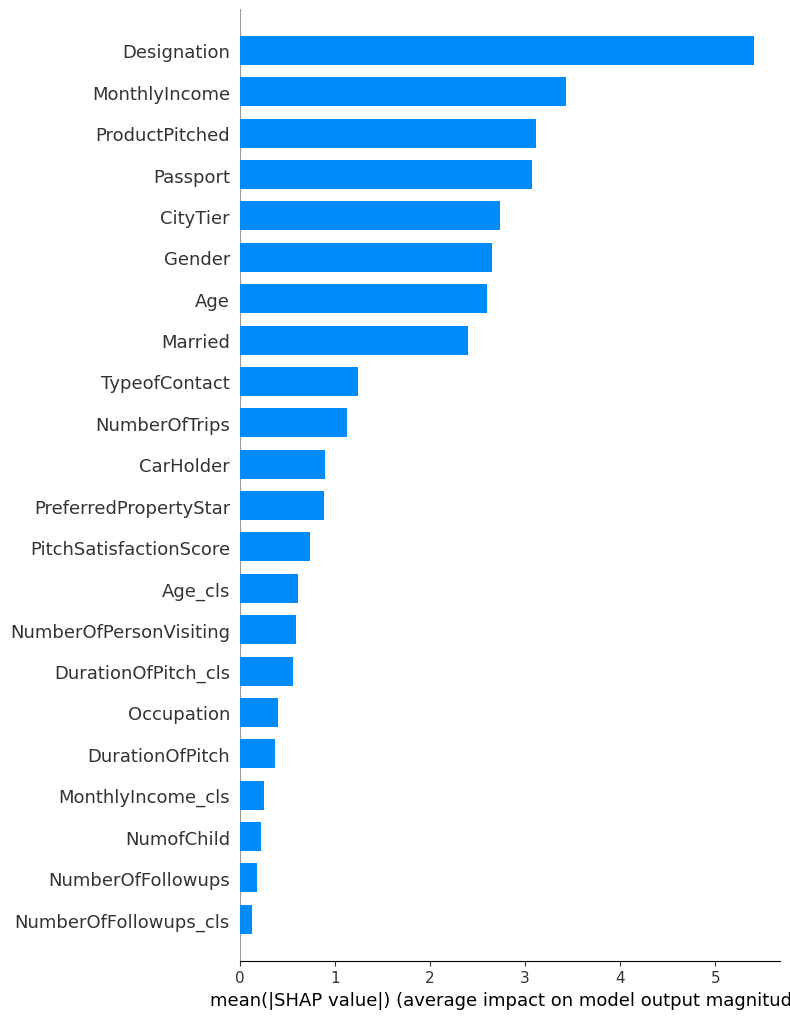

In [138]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()

# 各FOLD、SEEDの和 (相対値なのでこれで良しとする)
shapval = 0
for i in range(3):
  for j in range(5):
    explainer = shap.TreeExplainer(models[i][j])
    shap_values = explainer.shap_values(X)
    shapval = shapval + shap_values

shap.summary_plot(shapval, X,plot_type="bar", max_display=50)

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [ ]:
# テストデータを用いて予測します。
predict = 0
for i in range(3):
  for j in range(5):
    predict = predict + models[i][j].predict(X)
predict = predict / 15
submit[1] = predict

In [ ]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)